In [1]:
import os
import sys
from ef.config.config import Config
from ef.config.components import *

In this example, we compare an exact analytical trajectory of a charged particle moving in a uniform magnetic field with results of a numerical simulation.

A charged particle moves in uniform magnetic field in circular trajectory. 
An exact expressions for the trajectory can be obtained by solving Newton's equation:

$$
m \frac{ d \textbf{v} }{ dt } = \frac{q}{c} [ \textbf{v} \ \textbf{H} ]
$$

We chose z-axis to be directed along the magnetic field. 
Then the previous expression becomes:

\begin{align}
& m v_x' = \frac{q}{c} v_y H_z \\
& m v_y' = -\frac{q}{c} v_x H_z \\
& m v_z' = 0
\end{align}

Performing integration over time (see [Single Particle in Uniform Magnetic Field](https://github.com/epicf/ef/blob/dev/examples/single_particle_in_magnetic_field/Single%20Particle%20in%20Uniform%20Magnetic%20Field.ipynb) [SymPy](http://www.sympy.org/en/index.html) notebook), it is possible to obtain
particle's law of motion:

\begin{align}
&v_x = v_{x0} \cos( \Omega t ) + v_{y0} \sin( \Omega t )
\\
&v_y = -v_{x0} \sin( \Omega t ) + v_{y0} \cos( \Omega t )
\\
&v_z = v_{z0}
\end{align}

\begin{align}
&x = x_0 + \frac{1}{\Omega} \Big[ v_{x0} \sin( \Omega t ) - v_{y0} \cos( \Omega t ) + v_{y0} \Big]
\\
&y = y_0 + \frac{1}{\Omega} \Big[ v_{x0} \cos( \Omega t ) + v_{y0} \sin( \Omega t ) - v_{x0} \Big]
\\
&z = z_0 + v_{z0} t
\end{align}


The parameters of the [circular motion](https://en.wikipedia.org/wiki/Gyroradius) - cyclotron frequency $\Omega$ and Larmor radius $r$ - are

$$
\Omega = \frac{q H_z}{m c},
\qquad
r = \frac{m c v_{\perp}}{q H_z} = \frac{m c (v_x^2 + v_y^2)^{1/2}}{q H_z}
$$


Let's perform some estimates (see below).
Suppose there is an electron (`q = 4.8e-10 [cgs]`, `m = 9.1e-28 [g]`) moving 
in the `1000 [Gs] = 1 * 10^-1 [T]` magnetic field. It's speed along the field (z-axis) corresponds
to 1 keV energy, and it's speed in perpendicular plane corresponds to energy 100 eV (initially distributed
evenly between x- and y-components).

In [2]:
from math import *

m = 9.8e-28
q = 4.8e-10
print( "q = {:.3e} [cgs]".format( q ) )
print( "m = {:.3e} [g]".format( m ) )

ev_to_cgs = 1.60218e-12
E_along = 1000 * ev_to_cgs
v_along = sqrt( 2 * E_along / m )
E_perp = 100 * ev_to_cgs
v_perp = sqrt( 2 * E_perp/2 / m )
print( "E_along = {:.3e} [eV] = {:.3e} [erg]".format( E_along / ev_to_cgs, E_along ) )
print( "E_perp = {:.3e} [eV] = {:.3e} [erg]".format( E_perp / ev_to_cgs, E_perp ) )
print( "v_along = {:.3e} [cm/s]; p_along = {:.3e} [g * cm/s]".format( v_along, v_along * m ) )
print( "v_perp = {:.3e} [cm/s]; p_perp = {:.3e} [g * cm/s]".format( v_perp, v_perp * m ) )

q = 4.800e-10 [cgs]
m = 9.800e-28 [g]
E_along = 1.000e+03 [eV] = 1.602e-09 [erg]
E_perp = 1.000e+02 [eV] = 1.602e-10 [erg]
v_along = 1.808e+09 [cm/s]; p_along = 1.772e-18 [g * cm/s]
v_perp = 4.043e+08 [cm/s]; p_perp = 3.962e-19 [g * cm/s]


It's cyclotron frequency and Larmor radius are `Omega = 1.633e+10 [1/s], r = 3.502e-02 [cm] ~ 0.035 [mm]`.
Gyration period equals to `3.848e-10 [s]` and distance in the direction of the field covered 
during single revolution is `6.959e-01 [cm] ~ 7 [mm]`

In [3]:
H = 1000
speed_of_light = 3.0e10
cyclotron_fr = q * H / m / speed_of_light
cyclotron_period = 2.0 * pi / cyclotron_fr
single_period_distance_along_field = v_along * cyclotron_period
larmor_r = m * speed_of_light * sqrt(2 * E_perp / m) / q / H
print( "H = {:.3e} [Gs]".format( H ) )
print( "c = {:.3e} [cm/s]".format( speed_of_light ) )
print( "Omega = {:.3e} [1/s]".format( cyclotron_fr ) )
print( "Cyclotron period = {:.3e} [s]".format( cyclotron_period ) )
print( "Single period distance along field= {:.3e} [cm]".format( single_period_distance_along_field ) )
print( "Larmor_r = {:.3e} [cm]".format( larmor_r ) )

H = 1.000e+03 [Gs]
c = 3.000e+10 [cm/s]
Omega = 1.633e+10 [1/s]
Cyclotron period = 3.848e-10 [s]
Single period distance along field= 6.959e-01 [cm]
Larmor_r = 3.502e-02 [cm]


Now, to check this, in config file we define a source which
generates a single particle at startup. Config is mostly similar
to ['Singe Particle in Free Space'](https://github.com/epicf/ef/wiki/Single-Particle-In-Free-Space) example, except this time we need nonzero magnetic field:

In [4]:
external_fields = [ExternalMagneticFieldUniformConf(field = (0, 0, 1000))]


Total simulation time has been adjusted to approximately 10 full gyration cycles (more precisely, 3.0e-9/3.848e-10 = 7.8 revolutions ).

In [5]:
ten_revolutions_time = 10 * cyclotron_period
print( "10 revolutions time = {:.3e} [s]".format( ten_revolutions_time ) )

sim_time = 3.0e-9
n_of_revolutions = sim_time / cyclotron_period
n_of_steps = 1000
dt = sim_time / n_of_steps
print( "simulation_time = {:.3e} [s]".format( sim_time ) )
print( "n_of_revolutions = {:.1f}".format( n_of_revolutions ) )
print( "number_of_time_steps = {:d}".format( n_of_steps ) )
print( "time_step_size = {:.3e} [s]".format( dt ) )

10 revolutions time = 3.848e-09 [s]
simulation_time = 3.000e-09 [s]
n_of_revolutions = 7.8
number_of_time_steps = 1000
time_step_size = 3.000e-12 [s]


In [6]:
time_grid = TimeGridConf(total = 3.0e-9, step = 3.0e-12, save_step = 3.0e-12 )

Distance covered is

In [7]:
z_distance = 5
t = z_distance / v_along
print( "z_distance = {:f} [cm]".format( z_distance ) )
print( "t = {:.3e} [s]".format( t ) )


z_distance = 5.000000 [cm]
t = 2.765e-09 [s]


_construct remaining fields and run_

Processing of simulation results is also mostly similar to the [previous example](https://github.com/epicf/ef/wiki/Single-Particle-in-Free-Space).
The law of motion is more complicated this time, and to define it we need not only
particle mass and initial position and momentum, but also it's charge and magnitude of the magnetic field.
All of this can be extracted from the relevant sections of the output `*.h5` files. 
(see functions `eval_an_trajectory_at_num_time_points`, `velocities` and `coords` at 
[plot.py](https://github.com/epicf/ef/blob/dev/examples/single_particle_in_magnetic_field/plot.py))

_functions_

Trajectory plots:

_figures_

Apart from the trajectory, kinetic energy is also plotted. 
In theory, particle should not gain or loss any energy by interacting with magnetic field. 
However, [due to numerical errors](https://en.wikipedia.org/wiki/Energy_drift), this might not be the case in simulations. In this case, the energy is conserved.

_figures_

**Long Simulation Time**  
[Boris](https://en.wikipedia.org/wiki/Particle-in-cell#The_particle_mover) integration scheme is [notable](http://aip.scitation.org/doi/abs/10.1063/1.4818428?journalCode=php) for energy conservation even for long simulation times. 

_config and results_

**Time Step Larger Than Gyration Period**  
In practice it is necessary to keep in mind that time step should not exceed gyration period. 
Otherwise, this will lead to erroneous results.

_config and results_

In [8]:
Config(time_grid=time_grid, spatial_mesh=SpatialMeshConf(size=(2, 2, 5), step=(1, 1, 1)),
       external_fields=external_fields)

Config(time_grid=TimeGridConf(total=3e-09, save_step=3e-12, step=3e-12), spatial_mesh=SpatialMeshConf(size=array([2., 2., 5.]), step=array([1., 1., 1.])), sources=[], inner_regions=[], output_file=OutputFileConf(prefix='out_', suffix='.h5'), boundary_conditions=BoundaryConditionsConf(right=0.0, left=0.0, bottom=0.0, top=0.0, near=0.0, far=0.0), particle_interaction_model=ParticleInteractionModelConf(model='PIC'), external_fields=[ExternalFieldUniformConf(name='ExternalFieldUniform_1', electric_or_magnetic='magnetic', field=array([   0.,    0., 1000.]))])

In [9]:
!ef single_particle_in_magnetic_field.conf

Config file is:  single_particle_in_magnetic_field.conf
[ TimeGrid ]
total_time = 3.0e-9
time_step_size = 3.0e-12
time_save_step = 3.0e-12
[ SpatialMesh ]
grid_x_size = 5.0
grid_x_step = 0.5
grid_y_size = 5.0
grid_y_step = 0.5
grid_z_size = 8.0
grid_z_step = 0.5
[ ParticleSourceBox.emit_single_particle ]
initial_number_of_particles = 1
particles_to_generate_each_step = 0
box_x_left = 2.51
box_x_right = 2.50
box_y_bottom = 2.50
box_y_top = 2.51
box_z_near = 1.00
box_z_far = 1.01
mean_momentum_x = 3.92e-19
mean_momentum_y = 3.92e-19
mean_momentum_z = 1.77e-18
temperature = 0.0
charge = 4.8e-10
mass = 9.8e-28
[ BoundaryConditions ]
boundary_phi_left = 0.0
boundary_phi_right = 0.0
boundary_phi_bottom = 0.0
boundary_phi_top = 0.0
boundary_phi_near = 0.0
boundary_phi_far = 0.0
[ ExternalFieldUniform.mgn_uni ]
electric_or_magnetic = magnetic
field_x = 0.0
field_y = 0.0
field_z = 1000
[ ParticleInteractionModel ]
particle_interaction_model = noninteracting
[ OutputFilename ]
output_filename_pr

Writing to file single_particle_mgn_field_0000045.h5
Time step from 45 to 46 of 1000
Writing step 46 to file
Writing to file single_particle_mgn_field_0000046_new.h5
Writing to file single_particle_mgn_field_0000046.h5
Time step from 46 to 47 of 1000
Writing step 47 to file
Writing to file single_particle_mgn_field_0000047_new.h5
Writing to file single_particle_mgn_field_0000047.h5
Time step from 47 to 48 of 1000
Writing step 48 to file
Writing to file single_particle_mgn_field_0000048_new.h5
Writing to file single_particle_mgn_field_0000048.h5
Time step from 48 to 49 of 1000
Writing step 49 to file
Writing to file single_particle_mgn_field_0000049_new.h5
Writing to file single_particle_mgn_field_0000049.h5
Time step from 49 to 50 of 1000
Writing step 50 to file
Writing to file single_particle_mgn_field_0000050_new.h5
Writing to file single_particle_mgn_field_0000050.h5
Time step from 50 to 51 of 1000
Writing step 51 to file
Writing to file single_particle_mgn_field_0000051_new.h5
Writ

Writing to file single_particle_mgn_field_0000097.h5
Time step from 97 to 98 of 1000
Writing step 98 to file
Writing to file single_particle_mgn_field_0000098_new.h5
Writing to file single_particle_mgn_field_0000098.h5
Time step from 98 to 99 of 1000
Writing step 99 to file
Writing to file single_particle_mgn_field_0000099_new.h5
Writing to file single_particle_mgn_field_0000099.h5
Time step from 99 to 100 of 1000
Writing step 100 to file
Writing to file single_particle_mgn_field_0000100_new.h5
Writing to file single_particle_mgn_field_0000100.h5
Time step from 100 to 101 of 1000
Writing step 101 to file
Writing to file single_particle_mgn_field_0000101_new.h5
Writing to file single_particle_mgn_field_0000101.h5
Time step from 101 to 102 of 1000
Writing step 102 to file
Writing to file single_particle_mgn_field_0000102_new.h5
Writing to file single_particle_mgn_field_0000102.h5
Time step from 102 to 103 of 1000
Writing step 103 to file
Writing to file single_particle_mgn_field_0000103_

Writing to file single_particle_mgn_field_0000147.h5
Time step from 147 to 148 of 1000
Writing step 148 to file
Writing to file single_particle_mgn_field_0000148_new.h5
Writing to file single_particle_mgn_field_0000148.h5
Time step from 148 to 149 of 1000
Writing step 149 to file
Writing to file single_particle_mgn_field_0000149_new.h5
Writing to file single_particle_mgn_field_0000149.h5
Time step from 149 to 150 of 1000
Writing step 150 to file
Writing to file single_particle_mgn_field_0000150_new.h5
Writing to file single_particle_mgn_field_0000150.h5
Time step from 150 to 151 of 1000
Writing step 151 to file
Writing to file single_particle_mgn_field_0000151_new.h5
Writing to file single_particle_mgn_field_0000151.h5
Time step from 151 to 152 of 1000
Writing step 152 to file
Writing to file single_particle_mgn_field_0000152_new.h5
Writing to file single_particle_mgn_field_0000152.h5
Time step from 152 to 153 of 1000
Writing step 153 to file
Writing to file single_particle_mgn_field_0

Writing to file single_particle_mgn_field_0000198.h5
Time step from 198 to 199 of 1000
Writing step 199 to file
Writing to file single_particle_mgn_field_0000199_new.h5
Writing to file single_particle_mgn_field_0000199.h5
Time step from 199 to 200 of 1000
Writing step 200 to file
Writing to file single_particle_mgn_field_0000200_new.h5
Writing to file single_particle_mgn_field_0000200.h5
Time step from 200 to 201 of 1000
Writing step 201 to file
Writing to file single_particle_mgn_field_0000201_new.h5
Writing to file single_particle_mgn_field_0000201.h5
Time step from 201 to 202 of 1000
Writing step 202 to file
Writing to file single_particle_mgn_field_0000202_new.h5
Writing to file single_particle_mgn_field_0000202.h5
Time step from 202 to 203 of 1000
Writing step 203 to file
Writing to file single_particle_mgn_field_0000203_new.h5
Writing to file single_particle_mgn_field_0000203.h5
Time step from 203 to 204 of 1000
Writing step 204 to file
Writing to file single_particle_mgn_field_0

Time step from 249 to 250 of 1000
Writing step 250 to file
Writing to file single_particle_mgn_field_0000250_new.h5
Writing to file single_particle_mgn_field_0000250.h5
Time step from 250 to 251 of 1000
Writing step 251 to file
Writing to file single_particle_mgn_field_0000251_new.h5
Writing to file single_particle_mgn_field_0000251.h5
Time step from 251 to 252 of 1000
Writing step 252 to file
Writing to file single_particle_mgn_field_0000252_new.h5
Writing to file single_particle_mgn_field_0000252.h5
Time step from 252 to 253 of 1000
Writing step 253 to file
Writing to file single_particle_mgn_field_0000253_new.h5
Writing to file single_particle_mgn_field_0000253.h5
Time step from 253 to 254 of 1000
Writing step 254 to file
Writing to file single_particle_mgn_field_0000254_new.h5
Writing to file single_particle_mgn_field_0000254.h5
Time step from 254 to 255 of 1000
Writing step 255 to file
Writing to file single_particle_mgn_field_0000255_new.h5
Writing to file single_particle_mgn_fie

Time step from 300 to 301 of 1000
Writing step 301 to file
Writing to file single_particle_mgn_field_0000301_new.h5
Writing to file single_particle_mgn_field_0000301.h5
Time step from 301 to 302 of 1000
Writing step 302 to file
Writing to file single_particle_mgn_field_0000302_new.h5
Writing to file single_particle_mgn_field_0000302.h5
Time step from 302 to 303 of 1000
Writing step 303 to file
Writing to file single_particle_mgn_field_0000303_new.h5
Writing to file single_particle_mgn_field_0000303.h5
Time step from 303 to 304 of 1000
Writing step 304 to file
Writing to file single_particle_mgn_field_0000304_new.h5
Writing to file single_particle_mgn_field_0000304.h5
Time step from 304 to 305 of 1000
Writing step 305 to file
Writing to file single_particle_mgn_field_0000305_new.h5
Writing to file single_particle_mgn_field_0000305.h5
Time step from 305 to 306 of 1000
Writing step 306 to file
Writing to file single_particle_mgn_field_0000306_new.h5
Writing to file single_particle_mgn_fie

Time step from 350 to 351 of 1000
Writing step 351 to file
Writing to file single_particle_mgn_field_0000351_new.h5
Writing to file single_particle_mgn_field_0000351.h5
Time step from 351 to 352 of 1000
Writing step 352 to file
Writing to file single_particle_mgn_field_0000352_new.h5
Writing to file single_particle_mgn_field_0000352.h5
Time step from 352 to 353 of 1000
Writing step 353 to file
Writing to file single_particle_mgn_field_0000353_new.h5
Writing to file single_particle_mgn_field_0000353.h5
Time step from 353 to 354 of 1000
Writing step 354 to file
Writing to file single_particle_mgn_field_0000354_new.h5
Writing to file single_particle_mgn_field_0000354.h5
Time step from 354 to 355 of 1000
Writing step 355 to file
Writing to file single_particle_mgn_field_0000355_new.h5
Writing to file single_particle_mgn_field_0000355.h5
Time step from 355 to 356 of 1000
Writing step 356 to file
Writing to file single_particle_mgn_field_0000356_new.h5
Writing to file single_particle_mgn_fie

Time step from 400 to 401 of 1000
Writing step 401 to file
Writing to file single_particle_mgn_field_0000401_new.h5
Writing to file single_particle_mgn_field_0000401.h5
Time step from 401 to 402 of 1000
Writing step 402 to file
Writing to file single_particle_mgn_field_0000402_new.h5
Writing to file single_particle_mgn_field_0000402.h5
Time step from 402 to 403 of 1000
Writing step 403 to file
Writing to file single_particle_mgn_field_0000403_new.h5
Writing to file single_particle_mgn_field_0000403.h5
Time step from 403 to 404 of 1000
Writing step 404 to file
Writing to file single_particle_mgn_field_0000404_new.h5
Writing to file single_particle_mgn_field_0000404.h5
Time step from 404 to 405 of 1000
Writing step 405 to file
Writing to file single_particle_mgn_field_0000405_new.h5
Writing to file single_particle_mgn_field_0000405.h5
Time step from 405 to 406 of 1000
Writing step 406 to file
Writing to file single_particle_mgn_field_0000406_new.h5
Writing to file single_particle_mgn_fie

Time step from 451 to 452 of 1000
Writing step 452 to file
Writing to file single_particle_mgn_field_0000452_new.h5
Writing to file single_particle_mgn_field_0000452.h5
Time step from 452 to 453 of 1000
Writing step 453 to file
Writing to file single_particle_mgn_field_0000453_new.h5
Writing to file single_particle_mgn_field_0000453.h5
Time step from 453 to 454 of 1000
Writing step 454 to file
Writing to file single_particle_mgn_field_0000454_new.h5
Writing to file single_particle_mgn_field_0000454.h5
Time step from 454 to 455 of 1000
Writing step 455 to file
Writing to file single_particle_mgn_field_0000455_new.h5
Writing to file single_particle_mgn_field_0000455.h5
Time step from 455 to 456 of 1000
Writing step 456 to file
Writing to file single_particle_mgn_field_0000456_new.h5
Writing to file single_particle_mgn_field_0000456.h5
Time step from 456 to 457 of 1000
Writing step 457 to file
Writing to file single_particle_mgn_field_0000457_new.h5
Writing to file single_particle_mgn_fie

Writing to file single_particle_mgn_field_0000501.h5
Time step from 501 to 502 of 1000
Writing step 502 to file
Writing to file single_particle_mgn_field_0000502_new.h5
Writing to file single_particle_mgn_field_0000502.h5
Time step from 502 to 503 of 1000
Writing step 503 to file
Writing to file single_particle_mgn_field_0000503_new.h5
Writing to file single_particle_mgn_field_0000503.h5
Time step from 503 to 504 of 1000
Writing step 504 to file
Writing to file single_particle_mgn_field_0000504_new.h5
Writing to file single_particle_mgn_field_0000504.h5
Time step from 504 to 505 of 1000
Writing step 505 to file
Writing to file single_particle_mgn_field_0000505_new.h5
Writing to file single_particle_mgn_field_0000505.h5
Time step from 505 to 506 of 1000
Writing step 506 to file
Writing to file single_particle_mgn_field_0000506_new.h5
Writing to file single_particle_mgn_field_0000506.h5
Time step from 506 to 507 of 1000
Writing step 507 to file
Writing to file single_particle_mgn_field_0

Time step from 550 to 551 of 1000
Writing step 551 to file
Writing to file single_particle_mgn_field_0000551_new.h5
Writing to file single_particle_mgn_field_0000551.h5
Time step from 551 to 552 of 1000
Writing step 552 to file
Writing to file single_particle_mgn_field_0000552_new.h5
Writing to file single_particle_mgn_field_0000552.h5
Time step from 552 to 553 of 1000
Writing step 553 to file
Writing to file single_particle_mgn_field_0000553_new.h5
Writing to file single_particle_mgn_field_0000553.h5
Time step from 553 to 554 of 1000
Writing step 554 to file
Writing to file single_particle_mgn_field_0000554_new.h5
Writing to file single_particle_mgn_field_0000554.h5
Time step from 554 to 555 of 1000
Writing step 555 to file
Writing to file single_particle_mgn_field_0000555_new.h5
Writing to file single_particle_mgn_field_0000555.h5
Time step from 555 to 556 of 1000
Writing step 556 to file
Writing to file single_particle_mgn_field_0000556_new.h5
Writing to file single_particle_mgn_fie

Writing to file single_particle_mgn_field_0000599.h5
Time step from 599 to 600 of 1000
Writing step 600 to file
Writing to file single_particle_mgn_field_0000600_new.h5
Writing to file single_particle_mgn_field_0000600.h5
Time step from 600 to 601 of 1000
Writing step 601 to file
Writing to file single_particle_mgn_field_0000601_new.h5
Writing to file single_particle_mgn_field_0000601.h5
Time step from 601 to 602 of 1000
Writing step 602 to file
Writing to file single_particle_mgn_field_0000602_new.h5
Writing to file single_particle_mgn_field_0000602.h5
Time step from 602 to 603 of 1000
Writing step 603 to file
Writing to file single_particle_mgn_field_0000603_new.h5
Writing to file single_particle_mgn_field_0000603.h5
Time step from 603 to 604 of 1000
Writing step 604 to file
Writing to file single_particle_mgn_field_0000604_new.h5
Writing to file single_particle_mgn_field_0000604.h5
Time step from 604 to 605 of 1000
Writing step 605 to file
Writing to file single_particle_mgn_field_0

Time step from 648 to 649 of 1000
Writing step 649 to file
Writing to file single_particle_mgn_field_0000649_new.h5
Writing to file single_particle_mgn_field_0000649.h5
Time step from 649 to 650 of 1000
Writing step 650 to file
Writing to file single_particle_mgn_field_0000650_new.h5
Writing to file single_particle_mgn_field_0000650.h5
Time step from 650 to 651 of 1000
Writing step 651 to file
Writing to file single_particle_mgn_field_0000651_new.h5
Writing to file single_particle_mgn_field_0000651.h5
Time step from 651 to 652 of 1000
Writing step 652 to file
Writing to file single_particle_mgn_field_0000652_new.h5
Writing to file single_particle_mgn_field_0000652.h5
Time step from 652 to 653 of 1000
Writing step 653 to file
Writing to file single_particle_mgn_field_0000653_new.h5
Writing to file single_particle_mgn_field_0000653.h5
Time step from 653 to 654 of 1000
Writing step 654 to file
Writing to file single_particle_mgn_field_0000654_new.h5
Writing to file single_particle_mgn_fie

Writing to file single_particle_mgn_field_0000698.h5
Time step from 698 to 699 of 1000
Writing step 699 to file
Writing to file single_particle_mgn_field_0000699_new.h5
Writing to file single_particle_mgn_field_0000699.h5
Time step from 699 to 700 of 1000
Writing step 700 to file
Writing to file single_particle_mgn_field_0000700_new.h5
Writing to file single_particle_mgn_field_0000700.h5
Time step from 700 to 701 of 1000
Writing step 701 to file
Writing to file single_particle_mgn_field_0000701_new.h5
Writing to file single_particle_mgn_field_0000701.h5
Time step from 701 to 702 of 1000
Writing step 702 to file
Writing to file single_particle_mgn_field_0000702_new.h5
Writing to file single_particle_mgn_field_0000702.h5
Time step from 702 to 703 of 1000
Writing step 703 to file
Writing to file single_particle_mgn_field_0000703_new.h5
Writing to file single_particle_mgn_field_0000703.h5
Time step from 703 to 704 of 1000
Writing step 704 to file
Writing to file single_particle_mgn_field_0

Time step from 749 to 750 of 1000
Writing step 750 to file
Writing to file single_particle_mgn_field_0000750_new.h5
Writing to file single_particle_mgn_field_0000750.h5
Time step from 750 to 751 of 1000
Writing step 751 to file
Writing to file single_particle_mgn_field_0000751_new.h5
Writing to file single_particle_mgn_field_0000751.h5
Time step from 751 to 752 of 1000
Writing step 752 to file
Writing to file single_particle_mgn_field_0000752_new.h5
Writing to file single_particle_mgn_field_0000752.h5
Time step from 752 to 753 of 1000
Writing step 753 to file
Writing to file single_particle_mgn_field_0000753_new.h5
Writing to file single_particle_mgn_field_0000753.h5
Time step from 753 to 754 of 1000
Writing step 754 to file
Writing to file single_particle_mgn_field_0000754_new.h5
Writing to file single_particle_mgn_field_0000754.h5
Time step from 754 to 755 of 1000
Writing step 755 to file
Writing to file single_particle_mgn_field_0000755_new.h5
Writing to file single_particle_mgn_fie

Time step from 798 to 799 of 1000
Writing step 799 to file
Writing to file single_particle_mgn_field_0000799_new.h5
Writing to file single_particle_mgn_field_0000799.h5
Time step from 799 to 800 of 1000
Writing step 800 to file
Writing to file single_particle_mgn_field_0000800_new.h5
Writing to file single_particle_mgn_field_0000800.h5
Time step from 800 to 801 of 1000
Writing step 801 to file
Writing to file single_particle_mgn_field_0000801_new.h5
Writing to file single_particle_mgn_field_0000801.h5
Time step from 801 to 802 of 1000
Writing step 802 to file
Writing to file single_particle_mgn_field_0000802_new.h5
Writing to file single_particle_mgn_field_0000802.h5
Time step from 802 to 803 of 1000
Writing step 803 to file
Writing to file single_particle_mgn_field_0000803_new.h5
Writing to file single_particle_mgn_field_0000803.h5
Time step from 803 to 804 of 1000
Writing step 804 to file
Writing to file single_particle_mgn_field_0000804_new.h5
Writing to file single_particle_mgn_fie

Time step from 848 to 849 of 1000
Writing step 849 to file
Writing to file single_particle_mgn_field_0000849_new.h5
Writing to file single_particle_mgn_field_0000849.h5
Time step from 849 to 850 of 1000
Writing step 850 to file
Writing to file single_particle_mgn_field_0000850_new.h5
Writing to file single_particle_mgn_field_0000850.h5
Time step from 850 to 851 of 1000
Writing step 851 to file
Writing to file single_particle_mgn_field_0000851_new.h5
Writing to file single_particle_mgn_field_0000851.h5
Time step from 851 to 852 of 1000
Writing step 852 to file
Writing to file single_particle_mgn_field_0000852_new.h5
Writing to file single_particle_mgn_field_0000852.h5
Time step from 852 to 853 of 1000
Writing step 853 to file
Writing to file single_particle_mgn_field_0000853_new.h5
Writing to file single_particle_mgn_field_0000853.h5
Time step from 853 to 854 of 1000
Writing step 854 to file
Writing to file single_particle_mgn_field_0000854_new.h5
Writing to file single_particle_mgn_fie

Writing to file single_particle_mgn_field_0000898.h5
Time step from 898 to 899 of 1000
Writing step 899 to file
Writing to file single_particle_mgn_field_0000899_new.h5
Writing to file single_particle_mgn_field_0000899.h5
Time step from 899 to 900 of 1000
Writing step 900 to file
Writing to file single_particle_mgn_field_0000900_new.h5
Writing to file single_particle_mgn_field_0000900.h5
Time step from 900 to 901 of 1000
Writing step 901 to file
Writing to file single_particle_mgn_field_0000901_new.h5
Writing to file single_particle_mgn_field_0000901.h5
Time step from 901 to 902 of 1000
Writing step 902 to file
Writing to file single_particle_mgn_field_0000902_new.h5
Writing to file single_particle_mgn_field_0000902.h5
Time step from 902 to 903 of 1000
Writing step 903 to file
Writing to file single_particle_mgn_field_0000903_new.h5
Writing to file single_particle_mgn_field_0000903.h5
Time step from 903 to 904 of 1000
Writing step 904 to file
Writing to file single_particle_mgn_field_0

Time step from 947 to 948 of 1000
Writing step 948 to file
Writing to file single_particle_mgn_field_0000948_new.h5
Writing to file single_particle_mgn_field_0000948.h5
Time step from 948 to 949 of 1000
Writing step 949 to file
Writing to file single_particle_mgn_field_0000949_new.h5
Writing to file single_particle_mgn_field_0000949.h5
Time step from 949 to 950 of 1000
Writing step 950 to file
Writing to file single_particle_mgn_field_0000950_new.h5
Writing to file single_particle_mgn_field_0000950.h5
Time step from 950 to 951 of 1000
Writing step 951 to file
Writing to file single_particle_mgn_field_0000951_new.h5
Writing to file single_particle_mgn_field_0000951.h5
Time step from 951 to 952 of 1000
Writing step 952 to file
Writing to file single_particle_mgn_field_0000952_new.h5
Writing to file single_particle_mgn_field_0000952.h5
Time step from 952 to 953 of 1000
Writing step 953 to file
Writing to file single_particle_mgn_field_0000953_new.h5
Writing to file single_particle_mgn_fie

Writing to file single_particle_mgn_field_0000996.h5
Time step from 996 to 997 of 1000
Writing step 997 to file
Writing to file single_particle_mgn_field_0000997_new.h5
Writing to file single_particle_mgn_field_0000997.h5
Time step from 997 to 998 of 1000
Writing step 998 to file
Writing to file single_particle_mgn_field_0000998_new.h5
Writing to file single_particle_mgn_field_0000998.h5
Time step from 998 to 999 of 1000
Writing step 999 to file
Writing to file single_particle_mgn_field_0000999_new.h5
Writing to file single_particle_mgn_field_0000999.h5
Time step from 999 to 1000 of 1000
Writing step 1000 to file
Writing to file single_particle_mgn_field_0001000_new.h5
Writing to file single_particle_mgn_field_0001000.h5


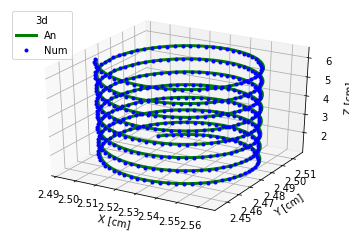

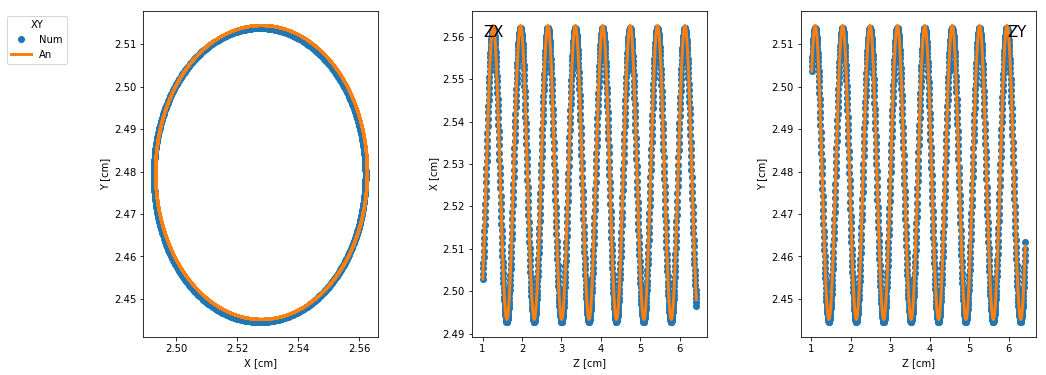

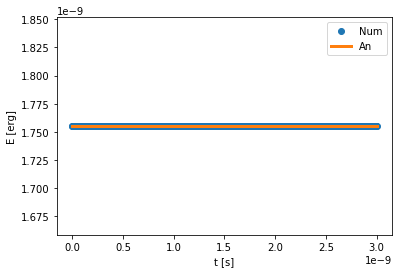

In [13]:
import glob
import os

import h5py
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D


def main():
    num = extract_num_trajectory_from_out_files()
    an = eval_an_trajectory_at_num_time_points(num)
    plot_trajectories(num, an)


def extract_num_trajectory_from_out_files():
    out_files = find_necessary_out_files()

    num_trajectory = []
    for f in out_files:
        num_trajectory.append(extract_time_pos_mom(f))

    num_trajectory = remove_empty_and_sort_by_time(num_trajectory)
    num_trajectory = np.array(num_trajectory,
                              dtype=[('t', 'float'),
                                     ('x', 'float'), ('y', 'float'), ('z', 'float'),
                                     ('px', 'float'), ('py', 'float'), ('pz', 'float')])
    return (num_trajectory)


def remove_empty_and_sort_by_time(num_trajectory):
    removed_empty = [x for x in num_trajectory if x]
    sorted_by_time = sorted(removed_empty, key=lambda x: x[0])
    return (sorted_by_time)


def find_necessary_out_files():
    os.chdir("./")
    h5files = []
    for file in glob.glob("single_particle_mgn_field_[0-9][0-9][0-9][0-9][0-9][0-9][0-9].h5"):
        h5files.append(file)
    return h5files


def extract_time_pos_mom(h5file):
    h5 = h5py.File(h5file, mode="r")
    t = h5["/TimeGrid"].attrs["current_time"]
    t_pos_mom = ()
    if (len(h5["/ParticleSources/emit_single_particle"]) > 0 and
            len(h5["/ParticleSources/emit_single_particle/position_x"]) > 0):
        x = h5["/ParticleSources/emit_single_particle/position_x"][0]
        y = h5["/ParticleSources/emit_single_particle/position_y"][0]
        z = h5["/ParticleSources/emit_single_particle/position_z"][0]
        px = h5["/ParticleSources/emit_single_particle/momentum_x"][0]
        py = h5["/ParticleSources/emit_single_particle/momentum_y"][0]
        pz = h5["/ParticleSources/emit_single_particle/momentum_z"][0]
        t_pos_mom = (t, x, y, z, px, py, pz)
    h5.close()
    return (t_pos_mom)


def eval_an_trajectory_at_num_time_points(num_trajectory):
    initial_out_file = "single_particle_mgn_field_0000000.h5"
    initial_h5 = h5py.File(initial_out_file, mode="r")
    global B0, q, m
    B0 = extract_magn_field(initial_h5)
    q, m = extract_particle_charge_and_mass(initial_h5)
    global x0, y0, z0, px0, py0, pz0, vx0, vy0, vz0
    x0, y0, z0, px0, py0, pz0 = extract_initial_pos_and_mom(initial_h5)
    vx0, vy0, vz0 = px0 / m, py0 / m, pz0 / m
    initial_h5.close()

    global v_perp_len, v_prll
    v_perp_len = np.sqrt(vx0 ** 2 + vy0 ** 2)
    v_prll = vz0

    global speed_of_light, larmor_rad, larmor_freq
    speed_of_light = 3e10  # todo 
    larmor_rad = m / abs(q) * v_perp_len / B0 * speed_of_light
    larmor_freq = abs(q) / m * B0 / speed_of_light

    an_trajectory = np.empty_like(num_trajectory)
    for i, t in enumerate(num_trajectory['t']):
        x, y, z = coords(t)
        vx, vy, vz = velocities(t)
        px, py, pz = vx * m, vy * m, vz * m
        an_trajectory[i] = (t, x, y, z, px, py, pz)

    return (an_trajectory)


def extract_magn_field(h5):
    B0 = h5["/ExternalFields/mgn_uni"].attrs["magnetic_uniform_field_z"]
    return B0


def extract_particle_charge_and_mass(h5):
    q = h5["/ParticleSources/emit_single_particle"].attrs["charge"]
    m = h5["/ParticleSources/emit_single_particle"].attrs["mass"]
    return (q, m)


def extract_initial_pos_and_mom(h5):
    x0 = h5["/ParticleSources/emit_single_particle/position_x"][0]
    y0 = h5["/ParticleSources/emit_single_particle/position_y"][0]
    z0 = h5["/ParticleSources/emit_single_particle/position_z"][0]
    px0 = h5["/ParticleSources/emit_single_particle/momentum_x"][0]
    py0 = h5["/ParticleSources/emit_single_particle/momentum_y"][0]
    pz0 = h5["/ParticleSources/emit_single_particle/momentum_z"][0]
    return (x0, y0, z0, px0, py0, pz0)


def velocities(t):
    sign_larmor_freq = larmor_freq * np.sign(q)
    vx = vx0 * np.cos(sign_larmor_freq * t) + vy0 * np.sin(sign_larmor_freq * t)
    vy = -vx0 * np.sin(sign_larmor_freq * t) + vy0 * np.cos(sign_larmor_freq * t)
    vz = vz0
    return (vx, vy, vz)


def coords(t):
    sign_larmor_freq = larmor_freq * np.sign(q)
    x = x0 + 1 / sign_larmor_freq * (vx0 * np.sin(sign_larmor_freq * t) -
                                     vy0 * np.cos(sign_larmor_freq * t) + vy0)
    y = y0 + 1 / sign_larmor_freq * (vx0 * np.cos(sign_larmor_freq * t) +
                                     vy0 * np.sin(sign_larmor_freq * t) - vx0)
    z = z0 + vz0 * t
    return (x, y, z)


def plot_trajectories(num, an):
    plot_3d(num, an)
    plot_2d(num, an)
    plot_kin_en(num, an)


def plot_3d(num, an):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(an['x'], an['y'], an['z'], 'g-', linewidth=3, label="An")
    ax.plot(num['x'][::2], num['y'][::2], num['z'][::2], 'b.',
            markersize=6, label="Num")
    ax.set_xlabel('X [cm]')
    ax.set_ylabel('Y [cm]')
    ax.set_zlabel('Z [cm]')
    plt.legend(loc='upper left', title="3d")
    plt.show()


def plot_2d(num, an):
    plt.figure(figsize=(16, 6))
    plt.subplots_adjust(left=None, bottom=None,
                        right=None, top=None,
                        wspace=0.4, hspace=None)
    # XY
    ax = plt.subplot(131)
    plt.plot(num['x'], num['y'],
             linestyle='', marker='o',
             label="Num")
    plt.plot(an['x'], an['y'],
             linestyle='-', marker='', lw=3,
             label="An")
    ax.set_xlabel('X [cm]')
    ax.set_ylabel('Y [cm]')
    plt.legend(loc='upper left', title="XY", bbox_to_anchor=(-0.6, 1))
    # ZX
    ax = plt.subplot(132)
    plt.plot(num['z'], num['x'],
             linestyle='', marker='o',
             label="Num")
    plt.plot(an['z'], an['x'],
             linestyle='-', marker='', lw=3,
             label="An")
    ax.set_xlabel('Z [cm]')
    ax.set_ylabel('X [cm]')
    ax.text(0.05, 0.92, 'ZX',
            transform=ax.transAxes, fontsize=15)
    # plt.legend( loc = 'upper left', title="ZX" )
    # ZY
    ax = plt.subplot(133)
    plt.plot(num['z'], num['y'],
             linestyle='', marker='o',
             label="Num")
    plt.plot(an['z'], an['y'],
             linestyle='-', marker='', lw=3,
             label="An")
    ax.set_xlabel('Z [cm]')
    ax.set_ylabel('Y [cm]')
    ax.text(0.88, 0.92, 'ZY',
            transform=ax.transAxes, fontsize=15)
    # plt.legend( loc = 'upper left', title="ZY" )
    plt.show()


def plot_kin_en(num, an):
    E_num = (num['px'] ** 2 + num['py'] ** 2 + num['pz'] ** 2) / (2 * m)
    E_an = (an['px'] ** 2 + an['py'] ** 2 + an['pz'] ** 2) / (2 * m)
    t = num['t']
    plt.figure()
    axes = plt.gca()
    axes.set_xlabel("t [s]")
    axes.set_ylabel("E [erg]")
    # axes.set_ylim( [min( E_an.min(), E_num.min() ),
    #                 max( E_an.max(), E_num.max() ) ] )
    line, = plt.plot(t, E_num, 'o')
    line.set_label("Num")
    line, = plt.plot(t, E_an, ls='solid', lw=3)
    line.set_label("An")
    plt.legend(loc='upper right')
    plt.show()

main()


In [17]:
!ef large_time_step.conf

Config file is:  large_time_step.conf
[ TimeGrid ]
total_time = 3.0e-9
time_step_size = 3.0e-12
time_save_step = 3.0e-12
[ SpatialMesh ]
grid_x_size = 5.0
grid_x_step = 0.5
grid_y_size = 5.0
grid_y_step = 0.5
grid_z_size = 8.0
grid_z_step = 0.5
[ ParticleSourceBox.emit_single_particle ]
initial_number_of_particles = 1
particles_to_generate_each_step = 0
box_x_left = 2.51
box_x_right = 2.50
box_y_bottom = 2.50
box_y_top = 2.51
box_z_near = 1.00
box_z_far = 1.01
mean_momentum_x = 3.92e-19
mean_momentum_y = 3.92e-19
mean_momentum_z = 1.77e-18
temperature = 0.0
charge = 4.8e-10
mass = 9.8e-28
[ BoundaryConditions ]
boundary_phi_left = 0.0
boundary_phi_right = 0.0
boundary_phi_bottom = 0.0
boundary_phi_top = 0.0
boundary_phi_near = 0.0
boundary_phi_far = 0.0
[ ExternalFieldUniform.mgn_uni ]
electric_or_magnetic = magnetic
field_x = 0.0
field_y = 0.0
field_z = 100000
[ ParticleInteractionModel ]
particle_interaction_model = noninteracting
[ OutputFilename ]
output_filename_prefix = large_tim

Time step from 48 to 49 of 1000
Writing step 49 to file
Writing to file large_time_step_0000049_new.h5
Writing to file large_time_step_0000049.h5
Time step from 49 to 50 of 1000
Writing step 50 to file
Writing to file large_time_step_0000050_new.h5
Writing to file large_time_step_0000050.h5
Time step from 50 to 51 of 1000
Writing step 51 to file
Writing to file large_time_step_0000051_new.h5
Writing to file large_time_step_0000051.h5
Time step from 51 to 52 of 1000
Writing step 52 to file
Writing to file large_time_step_0000052_new.h5
Writing to file large_time_step_0000052.h5
Time step from 52 to 53 of 1000
Writing step 53 to file
Writing to file large_time_step_0000053_new.h5
Writing to file large_time_step_0000053.h5
Time step from 53 to 54 of 1000
Writing step 54 to file
Writing to file large_time_step_0000054_new.h5
Writing to file large_time_step_0000054.h5
Time step from 54 to 55 of 1000
Writing step 55 to file
Writing to file large_time_step_0000055_new.h5
Writing to file large

Time step from 108 to 109 of 1000
Writing step 109 to file
Writing to file large_time_step_0000109_new.h5
Writing to file large_time_step_0000109.h5
Time step from 109 to 110 of 1000
Writing step 110 to file
Writing to file large_time_step_0000110_new.h5
Writing to file large_time_step_0000110.h5
Time step from 110 to 111 of 1000
Writing step 111 to file
Writing to file large_time_step_0000111_new.h5
Writing to file large_time_step_0000111.h5
Time step from 111 to 112 of 1000
Writing step 112 to file
Writing to file large_time_step_0000112_new.h5
Writing to file large_time_step_0000112.h5
Time step from 112 to 113 of 1000
Writing step 113 to file
Writing to file large_time_step_0000113_new.h5
Writing to file large_time_step_0000113.h5
Time step from 113 to 114 of 1000
Writing step 114 to file
Writing to file large_time_step_0000114_new.h5
Writing to file large_time_step_0000114.h5
Time step from 114 to 115 of 1000
Writing step 115 to file
Writing to file large_time_step_0000115_new.h5


Time step from 163 to 164 of 1000
Writing step 164 to file
Writing to file large_time_step_0000164_new.h5
Writing to file large_time_step_0000164.h5
Time step from 164 to 165 of 1000
Writing step 165 to file
Writing to file large_time_step_0000165_new.h5
Writing to file large_time_step_0000165.h5
Time step from 165 to 166 of 1000
Writing step 166 to file
Writing to file large_time_step_0000166_new.h5
Writing to file large_time_step_0000166.h5
Time step from 166 to 167 of 1000
Writing step 167 to file
Writing to file large_time_step_0000167_new.h5
Writing to file large_time_step_0000167.h5
Time step from 167 to 168 of 1000
Writing step 168 to file
Writing to file large_time_step_0000168_new.h5
Writing to file large_time_step_0000168.h5
Time step from 168 to 169 of 1000
Writing step 169 to file
Writing to file large_time_step_0000169_new.h5
Writing to file large_time_step_0000169.h5
Time step from 169 to 170 of 1000
Writing step 170 to file
Writing to file large_time_step_0000170_new.h5


Writing to file large_time_step_0000221.h5
Time step from 221 to 222 of 1000
Writing step 222 to file
Writing to file large_time_step_0000222_new.h5
Writing to file large_time_step_0000222.h5
Time step from 222 to 223 of 1000
Writing step 223 to file
Writing to file large_time_step_0000223_new.h5
Writing to file large_time_step_0000223.h5
Time step from 223 to 224 of 1000
Writing step 224 to file
Writing to file large_time_step_0000224_new.h5
Writing to file large_time_step_0000224.h5
Time step from 224 to 225 of 1000
Writing step 225 to file
Writing to file large_time_step_0000225_new.h5
Writing to file large_time_step_0000225.h5
Time step from 225 to 226 of 1000
Writing step 226 to file
Writing to file large_time_step_0000226_new.h5
Writing to file large_time_step_0000226.h5
Time step from 226 to 227 of 1000
Writing step 227 to file
Writing to file large_time_step_0000227_new.h5
Writing to file large_time_step_0000227.h5
Time step from 227 to 228 of 1000
Writing step 228 to file
Writ

Writing to file large_time_step_0000276.h5
Time step from 276 to 277 of 1000
Writing step 277 to file
Writing to file large_time_step_0000277_new.h5
Writing to file large_time_step_0000277.h5
Time step from 277 to 278 of 1000
Writing step 278 to file
Writing to file large_time_step_0000278_new.h5
Writing to file large_time_step_0000278.h5
Time step from 278 to 279 of 1000
Writing step 279 to file
Writing to file large_time_step_0000279_new.h5
Writing to file large_time_step_0000279.h5
Time step from 279 to 280 of 1000
Writing step 280 to file
Writing to file large_time_step_0000280_new.h5
Writing to file large_time_step_0000280.h5
Time step from 280 to 281 of 1000
Writing step 281 to file
Writing to file large_time_step_0000281_new.h5
Writing to file large_time_step_0000281.h5
Time step from 281 to 282 of 1000
Writing step 282 to file
Writing to file large_time_step_0000282_new.h5
Writing to file large_time_step_0000282.h5
Time step from 282 to 283 of 1000
Writing step 283 to file
Writ

Writing to file large_time_step_0000333.h5
Time step from 333 to 334 of 1000
Writing step 334 to file
Writing to file large_time_step_0000334_new.h5
Writing to file large_time_step_0000334.h5
Time step from 334 to 335 of 1000
Writing step 335 to file
Writing to file large_time_step_0000335_new.h5
Writing to file large_time_step_0000335.h5
Time step from 335 to 336 of 1000
Writing step 336 to file
Writing to file large_time_step_0000336_new.h5
Writing to file large_time_step_0000336.h5
Time step from 336 to 337 of 1000
Writing step 337 to file
Writing to file large_time_step_0000337_new.h5
Writing to file large_time_step_0000337.h5
Time step from 337 to 338 of 1000
Writing step 338 to file
Writing to file large_time_step_0000338_new.h5
Writing to file large_time_step_0000338.h5
Time step from 338 to 339 of 1000
Writing step 339 to file
Writing to file large_time_step_0000339_new.h5
Writing to file large_time_step_0000339.h5
Time step from 339 to 340 of 1000
Writing step 340 to file
Writ

Time step from 388 to 389 of 1000
Writing step 389 to file
Writing to file large_time_step_0000389_new.h5
Writing to file large_time_step_0000389.h5
Time step from 389 to 390 of 1000
Writing step 390 to file
Writing to file large_time_step_0000390_new.h5
Writing to file large_time_step_0000390.h5
Time step from 390 to 391 of 1000
Writing step 391 to file
Writing to file large_time_step_0000391_new.h5
Writing to file large_time_step_0000391.h5
Time step from 391 to 392 of 1000
Writing step 392 to file
Writing to file large_time_step_0000392_new.h5
Writing to file large_time_step_0000392.h5
Time step from 392 to 393 of 1000
Writing step 393 to file
Writing to file large_time_step_0000393_new.h5
Writing to file large_time_step_0000393.h5
Time step from 393 to 394 of 1000
Writing step 394 to file
Writing to file large_time_step_0000394_new.h5
Writing to file large_time_step_0000394.h5
Time step from 394 to 395 of 1000
Writing step 395 to file
Writing to file large_time_step_0000395_new.h5


Time step from 444 to 445 of 1000
Writing step 445 to file
Writing to file large_time_step_0000445_new.h5
Writing to file large_time_step_0000445.h5
Time step from 445 to 446 of 1000
Writing step 446 to file
Writing to file large_time_step_0000446_new.h5
Writing to file large_time_step_0000446.h5
Time step from 446 to 447 of 1000
Writing step 447 to file
Writing to file large_time_step_0000447_new.h5
Writing to file large_time_step_0000447.h5
Time step from 447 to 448 of 1000
Writing step 448 to file
Writing to file large_time_step_0000448_new.h5
Writing to file large_time_step_0000448.h5
Time step from 448 to 449 of 1000
Writing step 449 to file
Writing to file large_time_step_0000449_new.h5
Writing to file large_time_step_0000449.h5
Time step from 449 to 450 of 1000
Writing step 450 to file
Writing to file large_time_step_0000450_new.h5
Writing to file large_time_step_0000450.h5
Time step from 450 to 451 of 1000
Writing step 451 to file
Writing to file large_time_step_0000451_new.h5


Time step from 500 to 501 of 1000
Writing step 501 to file
Writing to file large_time_step_0000501_new.h5
Writing to file large_time_step_0000501.h5
Time step from 501 to 502 of 1000
Writing step 502 to file
Writing to file large_time_step_0000502_new.h5
Writing to file large_time_step_0000502.h5
Time step from 502 to 503 of 1000
Writing step 503 to file
Writing to file large_time_step_0000503_new.h5
Writing to file large_time_step_0000503.h5
Time step from 503 to 504 of 1000
Writing step 504 to file
Writing to file large_time_step_0000504_new.h5
Writing to file large_time_step_0000504.h5
Time step from 504 to 505 of 1000
Writing step 505 to file
Writing to file large_time_step_0000505_new.h5
Writing to file large_time_step_0000505.h5
Time step from 505 to 506 of 1000
Writing step 506 to file
Writing to file large_time_step_0000506_new.h5
Writing to file large_time_step_0000506.h5
Time step from 506 to 507 of 1000
Writing step 507 to file
Writing to file large_time_step_0000507_new.h5


Time step from 556 to 557 of 1000
Writing step 557 to file
Writing to file large_time_step_0000557_new.h5
Writing to file large_time_step_0000557.h5
Time step from 557 to 558 of 1000
Writing step 558 to file
Writing to file large_time_step_0000558_new.h5
Writing to file large_time_step_0000558.h5
Time step from 558 to 559 of 1000
Writing step 559 to file
Writing to file large_time_step_0000559_new.h5
Writing to file large_time_step_0000559.h5
Time step from 559 to 560 of 1000
Writing step 560 to file
Writing to file large_time_step_0000560_new.h5
Writing to file large_time_step_0000560.h5
Time step from 560 to 561 of 1000
Writing step 561 to file
Writing to file large_time_step_0000561_new.h5
Writing to file large_time_step_0000561.h5
Time step from 561 to 562 of 1000
Writing step 562 to file
Writing to file large_time_step_0000562_new.h5
Writing to file large_time_step_0000562.h5
Time step from 562 to 563 of 1000
Writing step 563 to file
Writing to file large_time_step_0000563_new.h5


Time step from 612 to 613 of 1000
Writing step 613 to file
Writing to file large_time_step_0000613_new.h5
Writing to file large_time_step_0000613.h5
Time step from 613 to 614 of 1000
Writing step 614 to file
Writing to file large_time_step_0000614_new.h5
Writing to file large_time_step_0000614.h5
Time step from 614 to 615 of 1000
Writing step 615 to file
Writing to file large_time_step_0000615_new.h5
Writing to file large_time_step_0000615.h5
Time step from 615 to 616 of 1000
Writing step 616 to file
Writing to file large_time_step_0000616_new.h5
Writing to file large_time_step_0000616.h5
Time step from 616 to 617 of 1000
Writing step 617 to file
Writing to file large_time_step_0000617_new.h5
Writing to file large_time_step_0000617.h5
Time step from 617 to 618 of 1000
Writing step 618 to file
Writing to file large_time_step_0000618_new.h5
Writing to file large_time_step_0000618.h5
Time step from 618 to 619 of 1000
Writing step 619 to file
Writing to file large_time_step_0000619_new.h5


Writing to file large_time_step_0000669.h5
Time step from 669 to 670 of 1000
Writing step 670 to file
Writing to file large_time_step_0000670_new.h5
Writing to file large_time_step_0000670.h5
Time step from 670 to 671 of 1000
Writing step 671 to file
Writing to file large_time_step_0000671_new.h5
Writing to file large_time_step_0000671.h5
Time step from 671 to 672 of 1000
Writing step 672 to file
Writing to file large_time_step_0000672_new.h5
Writing to file large_time_step_0000672.h5
Time step from 672 to 673 of 1000
Writing step 673 to file
Writing to file large_time_step_0000673_new.h5
Writing to file large_time_step_0000673.h5
Time step from 673 to 674 of 1000
Writing step 674 to file
Writing to file large_time_step_0000674_new.h5
Writing to file large_time_step_0000674.h5
Time step from 674 to 675 of 1000
Writing step 675 to file
Writing to file large_time_step_0000675_new.h5
Writing to file large_time_step_0000675.h5
Time step from 675 to 676 of 1000
Writing step 676 to file
Writ

Time step from 724 to 725 of 1000
Writing step 725 to file
Writing to file large_time_step_0000725_new.h5
Writing to file large_time_step_0000725.h5
Time step from 725 to 726 of 1000
Writing step 726 to file
Writing to file large_time_step_0000726_new.h5
Writing to file large_time_step_0000726.h5
Time step from 726 to 727 of 1000
Writing step 727 to file
Writing to file large_time_step_0000727_new.h5
Writing to file large_time_step_0000727.h5
Time step from 727 to 728 of 1000
Writing step 728 to file
Writing to file large_time_step_0000728_new.h5
Writing to file large_time_step_0000728.h5
Time step from 728 to 729 of 1000
Writing step 729 to file
Writing to file large_time_step_0000729_new.h5
Writing to file large_time_step_0000729.h5
Time step from 729 to 730 of 1000
Writing step 730 to file
Writing to file large_time_step_0000730_new.h5
Writing to file large_time_step_0000730.h5
Time step from 730 to 731 of 1000
Writing step 731 to file
Writing to file large_time_step_0000731_new.h5


Writing to file large_time_step_0000780.h5
Time step from 780 to 781 of 1000
Writing step 781 to file
Writing to file large_time_step_0000781_new.h5
Writing to file large_time_step_0000781.h5
Time step from 781 to 782 of 1000
Writing step 782 to file
Writing to file large_time_step_0000782_new.h5
Writing to file large_time_step_0000782.h5
Time step from 782 to 783 of 1000
Writing step 783 to file
Writing to file large_time_step_0000783_new.h5
Writing to file large_time_step_0000783.h5
Time step from 783 to 784 of 1000
Writing step 784 to file
Writing to file large_time_step_0000784_new.h5
Writing to file large_time_step_0000784.h5
Time step from 784 to 785 of 1000
Writing step 785 to file
Writing to file large_time_step_0000785_new.h5
Writing to file large_time_step_0000785.h5
Time step from 785 to 786 of 1000
Writing step 786 to file
Writing to file large_time_step_0000786_new.h5
Writing to file large_time_step_0000786.h5
Time step from 786 to 787 of 1000
Writing step 787 to file
Writ

Writing to file large_time_step_0000837.h5
Time step from 837 to 838 of 1000
Writing step 838 to file
Writing to file large_time_step_0000838_new.h5
Writing to file large_time_step_0000838.h5
Time step from 838 to 839 of 1000
Writing step 839 to file
Writing to file large_time_step_0000839_new.h5
Writing to file large_time_step_0000839.h5
Time step from 839 to 840 of 1000
Writing step 840 to file
Writing to file large_time_step_0000840_new.h5
Writing to file large_time_step_0000840.h5
Time step from 840 to 841 of 1000
Writing step 841 to file
Writing to file large_time_step_0000841_new.h5
Writing to file large_time_step_0000841.h5
Time step from 841 to 842 of 1000
Writing step 842 to file
Writing to file large_time_step_0000842_new.h5
Writing to file large_time_step_0000842.h5
Time step from 842 to 843 of 1000
Writing step 843 to file
Writing to file large_time_step_0000843_new.h5
Writing to file large_time_step_0000843.h5
Time step from 843 to 844 of 1000
Writing step 844 to file
Writ

Time step from 894 to 895 of 1000
Writing step 895 to file
Writing to file large_time_step_0000895_new.h5
Writing to file large_time_step_0000895.h5
Time step from 895 to 896 of 1000
Writing step 896 to file
Writing to file large_time_step_0000896_new.h5
Writing to file large_time_step_0000896.h5
Time step from 896 to 897 of 1000
Writing step 897 to file
Writing to file large_time_step_0000897_new.h5
Writing to file large_time_step_0000897.h5
Time step from 897 to 898 of 1000
Writing step 898 to file
Writing to file large_time_step_0000898_new.h5
Writing to file large_time_step_0000898.h5
Time step from 898 to 899 of 1000
Writing step 899 to file
Writing to file large_time_step_0000899_new.h5
Writing to file large_time_step_0000899.h5
Time step from 899 to 900 of 1000
Writing step 900 to file
Writing to file large_time_step_0000900_new.h5
Writing to file large_time_step_0000900.h5
Time step from 900 to 901 of 1000
Writing step 901 to file
Writing to file large_time_step_0000901_new.h5


Time step from 950 to 951 of 1000
Writing step 951 to file
Writing to file large_time_step_0000951_new.h5
Writing to file large_time_step_0000951.h5
Time step from 951 to 952 of 1000
Writing step 952 to file
Writing to file large_time_step_0000952_new.h5
Writing to file large_time_step_0000952.h5
Time step from 952 to 953 of 1000
Writing step 953 to file
Writing to file large_time_step_0000953_new.h5
Writing to file large_time_step_0000953.h5
Time step from 953 to 954 of 1000
Writing step 954 to file
Writing to file large_time_step_0000954_new.h5
Writing to file large_time_step_0000954.h5
Time step from 954 to 955 of 1000
Writing step 955 to file
Writing to file large_time_step_0000955_new.h5
Writing to file large_time_step_0000955.h5
Time step from 955 to 956 of 1000
Writing step 956 to file
Writing to file large_time_step_0000956_new.h5
Writing to file large_time_step_0000956.h5
Time step from 956 to 957 of 1000
Writing step 957 to file
Writing to file large_time_step_0000957_new.h5


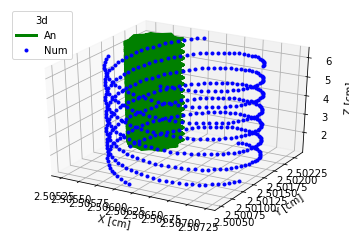

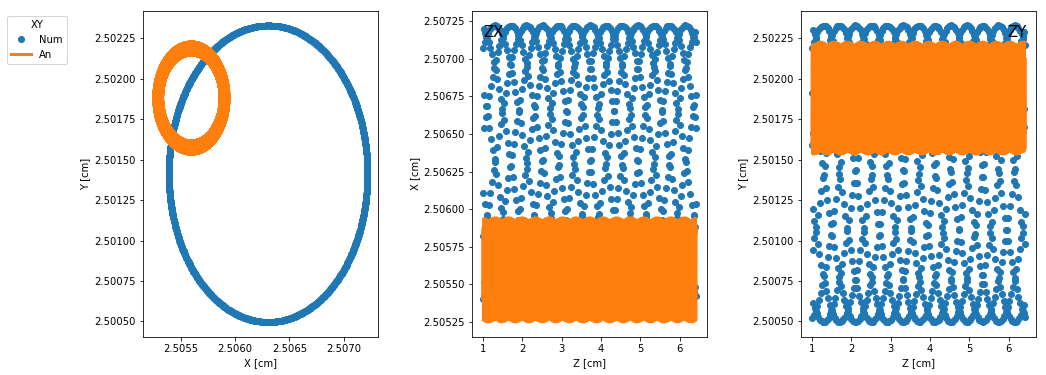

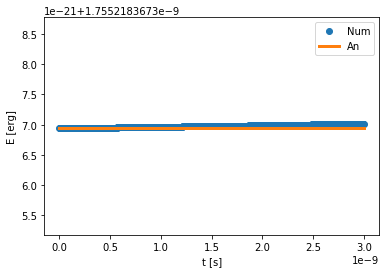

In [20]:
import glob
import os

import h5py
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

def main():
    num = extract_num_trajectory_from_out_files()
    an = eval_an_trajectory_at_num_time_points(num)
    plot_trajectories(num, an)


def extract_num_trajectory_from_out_files():
    out_files = find_necessary_out_files()

    num_trajectory = []
    for f in out_files:
        num_trajectory.append(extract_time_pos_mom(f))

    num_trajectory = remove_empty_and_sort_by_time(num_trajectory)
    num_trajectory = np.array(num_trajectory,
                              dtype=[('t', 'float'),
                                     ('x', 'float'), ('y', 'float'), ('z', 'float'),
                                     ('px', 'float'), ('py', 'float'), ('pz', 'float')])
    return (num_trajectory)


def remove_empty_and_sort_by_time(num_trajectory):
    removed_empty = [x for x in num_trajectory if x]
    sorted_by_time = sorted(removed_empty, key=lambda x: x[0])
    return (sorted_by_time)


def find_necessary_out_files():
    os.chdir("./")
    h5files = []
    for file in glob.glob("large_time_step_[0-9][0-9][0-9][0-9][0-9][0-9][0-9].h5"):
        h5files.append(file)
    return h5files


def extract_time_pos_mom(h5file):
    h5 = h5py.File(h5file, mode="r")
    t = h5["/TimeGrid"].attrs["current_time"]
    t_pos_mom = ()
    if (len(h5["/ParticleSources/emit_single_particle"]) > 0 and
            len(h5["/ParticleSources/emit_single_particle/position_x"]) > 0):
        x = h5["/ParticleSources/emit_single_particle/position_x"][0]
        y = h5["/ParticleSources/emit_single_particle/position_y"][0]
        z = h5["/ParticleSources/emit_single_particle/position_z"][0]
        px = h5["/ParticleSources/emit_single_particle/momentum_x"][0]
        py = h5["/ParticleSources/emit_single_particle/momentum_y"][0]
        pz = h5["/ParticleSources/emit_single_particle/momentum_z"][0]
        t_pos_mom = (t, x, y, z, px, py, pz)
    h5.close()
    return (t_pos_mom)


def eval_an_trajectory_at_num_time_points(num_trajectory):
    initial_out_file = "large_time_step_0000000.h5"
    initial_h5 = h5py.File(initial_out_file, mode="r")
    global B0, q, m
    B0 = extract_magn_field(initial_h5)
    q, m = extract_particle_charge_and_mass(initial_h5)
    global x0, y0, z0, px0, py0, pz0, vx0, vy0, vz0
    x0, y0, z0, px0, py0, pz0 = extract_initial_pos_and_mom(initial_h5)
    vx0, vy0, vz0 = px0 / m, py0 / m, pz0 / m
    initial_h5.close()

    global v_perp_len, v_prll
    v_perp_len = np.sqrt(vx0 ** 2 + vy0 ** 2)
    v_prll = vz0

    global speed_of_light, larmor_rad, larmor_freq
    speed_of_light = 3e10  # todo 
    larmor_rad = m / abs(q) * v_perp_len / B0 * speed_of_light
    larmor_freq = abs(q) / m * B0 / speed_of_light

    an_trajectory = np.empty_like(num_trajectory)
    for i, t in enumerate(num_trajectory['t']):
        x, y, z = coords(t)
        vx, vy, vz = velocities(t)
        px, py, pz = vx * m, vy * m, vz * m
        an_trajectory[i] = (t, x, y, z, px, py, pz)

    return (an_trajectory)


def extract_magn_field(h5):
    B0 = h5["/ExternalFields/mgn_uni"].attrs["magnetic_uniform_field_z"]
    return B0


def extract_particle_charge_and_mass(h5):
    q = h5["/ParticleSources/emit_single_particle"].attrs["charge"]
    m = h5["/ParticleSources/emit_single_particle"].attrs["mass"]
    return (q, m)


def extract_initial_pos_and_mom(h5):
    x0 = h5["/ParticleSources/emit_single_particle/position_x"][0]
    y0 = h5["/ParticleSources/emit_single_particle/position_y"][0]
    z0 = h5["/ParticleSources/emit_single_particle/position_z"][0]
    px0 = h5["/ParticleSources/emit_single_particle/momentum_x"][0]
    py0 = h5["/ParticleSources/emit_single_particle/momentum_y"][0]
    pz0 = h5["/ParticleSources/emit_single_particle/momentum_z"][0]
    return (x0, y0, z0, px0, py0, pz0)


def velocities(t):
    sign_larmor_freq = larmor_freq * np.sign(q)
    vx = vx0 * np.cos(sign_larmor_freq * t) + vy0 * np.sin(sign_larmor_freq * t)
    vy = -vx0 * np.sin(sign_larmor_freq * t) + vy0 * np.cos(sign_larmor_freq * t)
    vz = vz0
    return (vx, vy, vz)


def coords(t):
    sign_larmor_freq = larmor_freq * np.sign(q)
    x = x0 + 1 / sign_larmor_freq * (vx0 * np.sin(sign_larmor_freq * t) -
                                     vy0 * np.cos(sign_larmor_freq * t) + vy0)
    y = y0 + 1 / sign_larmor_freq * (vx0 * np.cos(sign_larmor_freq * t) +
                                     vy0 * np.sin(sign_larmor_freq * t) - vx0)
    z = z0 + vz0 * t
    return (x, y, z)


def plot_trajectories(num, an):
    plot_3d(num, an)
    plot_2d(num, an)
    plot_kin_en(num, an)


def plot_3d(num, an):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(an['x'], an['y'], an['z'], 'g-', linewidth=3, label="An")
    ax.plot(num['x'][::2], num['y'][::2], num['z'][::2], 'b.',
            markersize=6, label="Num")
    ax.set_xlabel('X [cm]')
    ax.set_ylabel('Y [cm]')
    ax.set_zlabel('Z [cm]')
    plt.legend(loc='upper left', title="3d")
    plt.show()


def plot_2d(num, an):
    plt.figure(figsize=(16, 6))
    plt.subplots_adjust(left=None, bottom=None,
                        right=None, top=None,
                        wspace=0.4, hspace=None)
    # XY
    ax = plt.subplot(131)
    plt.plot(num['x'], num['y'],
             linestyle='', marker='o',
             label="Num")
    plt.plot(an['x'], an['y'],
             linestyle='-', marker='', lw=3,
             label="An")
    ax.set_xlabel('X [cm]')
    ax.set_ylabel('Y [cm]')
    plt.legend(loc='upper left', title="XY", bbox_to_anchor=(-0.6, 1))
    # ZX
    ax = plt.subplot(132)
    plt.plot(num['z'], num['x'],
             linestyle='', marker='o',
             label="Num")
    plt.plot(an['z'], an['x'],
             linestyle='-', marker='', lw=3,
             label="An")
    ax.set_xlabel('Z [cm]')
    ax.set_ylabel('X [cm]')
    ax.text(0.05, 0.92, 'ZX',
            transform=ax.transAxes, fontsize=15)
    # plt.legend( loc = 'upper left', title="ZX" )
    # ZY
    ax = plt.subplot(133)
    plt.plot(num['z'], num['y'],
             linestyle='', marker='o',
             label="Num")
    plt.plot(an['z'], an['y'],
             linestyle='-', marker='', lw=3,
             label="An")
    ax.set_xlabel('Z [cm]')
    ax.set_ylabel('Y [cm]')
    ax.text(0.88, 0.92, 'ZY',
            transform=ax.transAxes, fontsize=15)
    # plt.legend( loc = 'upper left', title="ZY" )
    plt.show()


def plot_kin_en(num, an):
    E_num = (num['px'] ** 2 + num['py'] ** 2 + num['pz'] ** 2) / (2 * m)
    E_an = (an['px'] ** 2 + an['py'] ** 2 + an['pz'] ** 2) / (2 * m)
    t = num['t']
    plt.figure()
    axes = plt.gca()
    axes.set_xlabel("t [s]")
    axes.set_ylabel("E [erg]")
    # axes.set_ylim( [min( E_an.min(), E_num.min() ),
    #                 max( E_an.max(), E_num.max() ) ] )
    line, = plt.plot(t, E_num, 'o')
    line.set_label("Num")
    line, = plt.plot(t, E_an, ls='solid', lw=3)
    line.set_label("An")
    plt.legend(loc='upper right')
    plt.show()


main()


In [14]:
!ef long_simulation_time.conf

Config file is:  long_simulation_time.conf
[ TimeGrid ]
total_time = 3.0e-7
time_step_size = 3.0e-12
time_save_step = 3.0e-10
[ SpatialMesh ]
grid_x_size = 5.0
grid_x_step = 0.5
grid_y_size = 5.0
grid_y_step = 0.5
grid_z_size = 800.0
grid_z_step = 50.0
[ ParticleSourceBox.emit_single_particle ]
initial_number_of_particles = 1
particles_to_generate_each_step = 0
box_x_left = 2.51
box_x_right = 2.50
box_y_bottom = 2.50
box_y_top = 2.51
box_z_near = 1.00
box_z_far = 1.01
mean_momentum_x = 3.92e-19
mean_momentum_y = 3.92e-19
mean_momentum_z = 1.77e-18
temperature = 0.0
charge = 4.8e-10
mass = 9.8e-28
[ BoundaryConditions ]
boundary_phi_left = 0.0
boundary_phi_right = 0.0
boundary_phi_bottom = 0.0
boundary_phi_top = 0.0
boundary_phi_near = 0.0
boundary_phi_far = 0.0
[ ExternalFieldUniform.mgn_uni ]
electric_or_magnetic = magnetic
field_x = 0.0
field_y = 0.0
field_z = 1000
[ ParticleInteractionModel ]
particle_interaction_model = noninteracting
[ OutputFilename ]
output_filename_prefix = lon

Time step from 300 to 301 of 100000
Time step from 301 to 302 of 100000
Time step from 302 to 303 of 100000
Time step from 303 to 304 of 100000
Time step from 304 to 305 of 100000
Time step from 305 to 306 of 100000
Time step from 306 to 307 of 100000
Time step from 307 to 308 of 100000
Time step from 308 to 309 of 100000
Time step from 309 to 310 of 100000
Time step from 310 to 311 of 100000
Time step from 311 to 312 of 100000
Time step from 312 to 313 of 100000
Time step from 313 to 314 of 100000
Time step from 314 to 315 of 100000
Time step from 315 to 316 of 100000
Time step from 316 to 317 of 100000
Time step from 317 to 318 of 100000
Time step from 318 to 319 of 100000
Time step from 319 to 320 of 100000
Time step from 320 to 321 of 100000
Time step from 321 to 322 of 100000
Time step from 322 to 323 of 100000
Time step from 323 to 324 of 100000
Time step from 324 to 325 of 100000
Time step from 325 to 326 of 100000
Time step from 326 to 327 of 100000
Time step from 327 to 328 of

Time step from 669 to 670 of 100000
Time step from 670 to 671 of 100000
Time step from 671 to 672 of 100000
Time step from 672 to 673 of 100000
Time step from 673 to 674 of 100000
Time step from 674 to 675 of 100000
Time step from 675 to 676 of 100000
Time step from 676 to 677 of 100000
Time step from 677 to 678 of 100000
Time step from 678 to 679 of 100000
Time step from 679 to 680 of 100000
Time step from 680 to 681 of 100000
Time step from 681 to 682 of 100000
Time step from 682 to 683 of 100000
Time step from 683 to 684 of 100000
Time step from 684 to 685 of 100000
Time step from 685 to 686 of 100000
Time step from 686 to 687 of 100000
Time step from 687 to 688 of 100000
Time step from 688 to 689 of 100000
Time step from 689 to 690 of 100000
Time step from 690 to 691 of 100000
Time step from 691 to 692 of 100000
Time step from 692 to 693 of 100000
Time step from 693 to 694 of 100000
Time step from 694 to 695 of 100000
Time step from 695 to 696 of 100000
Time step from 696 to 697 of

Time step from 1013 to 1014 of 100000
Time step from 1014 to 1015 of 100000
Time step from 1015 to 1016 of 100000
Time step from 1016 to 1017 of 100000
Time step from 1017 to 1018 of 100000
Time step from 1018 to 1019 of 100000
Time step from 1019 to 1020 of 100000
Time step from 1020 to 1021 of 100000
Time step from 1021 to 1022 of 100000
Time step from 1022 to 1023 of 100000
Time step from 1023 to 1024 of 100000
Time step from 1024 to 1025 of 100000
Time step from 1025 to 1026 of 100000
Time step from 1026 to 1027 of 100000
Time step from 1027 to 1028 of 100000
Time step from 1028 to 1029 of 100000
Time step from 1029 to 1030 of 100000
Time step from 1030 to 1031 of 100000
Time step from 1031 to 1032 of 100000
Time step from 1032 to 1033 of 100000
Time step from 1033 to 1034 of 100000
Time step from 1034 to 1035 of 100000
Time step from 1035 to 1036 of 100000
Time step from 1036 to 1037 of 100000
Time step from 1037 to 1038 of 100000
Time step from 1038 to 1039 of 100000
Time step fr

Writing to file long_simulation_0001400.h5
Time step from 1400 to 1401 of 100000
Time step from 1401 to 1402 of 100000
Time step from 1402 to 1403 of 100000
Time step from 1403 to 1404 of 100000
Time step from 1404 to 1405 of 100000
Time step from 1405 to 1406 of 100000
Time step from 1406 to 1407 of 100000
Time step from 1407 to 1408 of 100000
Time step from 1408 to 1409 of 100000
Time step from 1409 to 1410 of 100000
Time step from 1410 to 1411 of 100000
Time step from 1411 to 1412 of 100000
Time step from 1412 to 1413 of 100000
Time step from 1413 to 1414 of 100000
Time step from 1414 to 1415 of 100000
Time step from 1415 to 1416 of 100000
Time step from 1416 to 1417 of 100000
Time step from 1417 to 1418 of 100000
Time step from 1418 to 1419 of 100000
Time step from 1419 to 1420 of 100000
Time step from 1420 to 1421 of 100000
Time step from 1421 to 1422 of 100000
Time step from 1422 to 1423 of 100000
Time step from 1423 to 1424 of 100000
Time step from 1424 to 1425 of 100000
Time st

Time step from 1781 to 1782 of 100000
Time step from 1782 to 1783 of 100000
Time step from 1783 to 1784 of 100000
Time step from 1784 to 1785 of 100000
Time step from 1785 to 1786 of 100000
Time step from 1786 to 1787 of 100000
Time step from 1787 to 1788 of 100000
Time step from 1788 to 1789 of 100000
Time step from 1789 to 1790 of 100000
Time step from 1790 to 1791 of 100000
Time step from 1791 to 1792 of 100000
Time step from 1792 to 1793 of 100000
Time step from 1793 to 1794 of 100000
Time step from 1794 to 1795 of 100000
Time step from 1795 to 1796 of 100000
Time step from 1796 to 1797 of 100000
Time step from 1797 to 1798 of 100000
Time step from 1798 to 1799 of 100000
Time step from 1799 to 1800 of 100000
Writing step 1800 to file
Writing to file long_simulation_0001800_new.h5
Writing to file long_simulation_0001800.h5
Time step from 1800 to 1801 of 100000
Time step from 1801 to 1802 of 100000
Time step from 1802 to 1803 of 100000
Time step from 1803 to 1804 of 100000
Time step 

Time step from 2132 to 2133 of 100000
Time step from 2133 to 2134 of 100000
Time step from 2134 to 2135 of 100000
Time step from 2135 to 2136 of 100000
Time step from 2136 to 2137 of 100000
Time step from 2137 to 2138 of 100000
Time step from 2138 to 2139 of 100000
Time step from 2139 to 2140 of 100000
Time step from 2140 to 2141 of 100000
Time step from 2141 to 2142 of 100000
Time step from 2142 to 2143 of 100000
Time step from 2143 to 2144 of 100000
Time step from 2144 to 2145 of 100000
Time step from 2145 to 2146 of 100000
Time step from 2146 to 2147 of 100000
Time step from 2147 to 2148 of 100000
Time step from 2148 to 2149 of 100000
Time step from 2149 to 2150 of 100000
Time step from 2150 to 2151 of 100000
Time step from 2151 to 2152 of 100000
Time step from 2152 to 2153 of 100000
Time step from 2153 to 2154 of 100000
Time step from 2154 to 2155 of 100000
Time step from 2155 to 2156 of 100000
Time step from 2156 to 2157 of 100000
Time step from 2157 to 2158 of 100000
Time step fr

Time step from 2500 to 2501 of 100000
Time step from 2501 to 2502 of 100000
Time step from 2502 to 2503 of 100000
Time step from 2503 to 2504 of 100000
Time step from 2504 to 2505 of 100000
Time step from 2505 to 2506 of 100000
Time step from 2506 to 2507 of 100000
Time step from 2507 to 2508 of 100000
Time step from 2508 to 2509 of 100000
Time step from 2509 to 2510 of 100000
Time step from 2510 to 2511 of 100000
Time step from 2511 to 2512 of 100000
Time step from 2512 to 2513 of 100000
Time step from 2513 to 2514 of 100000
Time step from 2514 to 2515 of 100000
Time step from 2515 to 2516 of 100000
Time step from 2516 to 2517 of 100000
Time step from 2517 to 2518 of 100000
Time step from 2518 to 2519 of 100000
Time step from 2519 to 2520 of 100000
Time step from 2520 to 2521 of 100000
Time step from 2521 to 2522 of 100000
Time step from 2522 to 2523 of 100000
Time step from 2523 to 2524 of 100000
Time step from 2524 to 2525 of 100000
Time step from 2525 to 2526 of 100000
Time step fr

Writing to file long_simulation_0002900.h5
Time step from 2900 to 2901 of 100000
Time step from 2901 to 2902 of 100000
Time step from 2902 to 2903 of 100000
Time step from 2903 to 2904 of 100000
Time step from 2904 to 2905 of 100000
Time step from 2905 to 2906 of 100000
Time step from 2906 to 2907 of 100000
Time step from 2907 to 2908 of 100000
Time step from 2908 to 2909 of 100000
Time step from 2909 to 2910 of 100000
Time step from 2910 to 2911 of 100000
Time step from 2911 to 2912 of 100000
Time step from 2912 to 2913 of 100000
Time step from 2913 to 2914 of 100000
Time step from 2914 to 2915 of 100000
Time step from 2915 to 2916 of 100000
Time step from 2916 to 2917 of 100000
Time step from 2917 to 2918 of 100000
Time step from 2918 to 2919 of 100000
Time step from 2919 to 2920 of 100000
Time step from 2920 to 2921 of 100000
Time step from 2921 to 2922 of 100000
Time step from 2922 to 2923 of 100000
Time step from 2923 to 2924 of 100000
Time step from 2924 to 2925 of 100000
Time st

Time step from 3240 to 3241 of 100000
Time step from 3241 to 3242 of 100000
Time step from 3242 to 3243 of 100000
Time step from 3243 to 3244 of 100000
Time step from 3244 to 3245 of 100000
Time step from 3245 to 3246 of 100000
Time step from 3246 to 3247 of 100000
Time step from 3247 to 3248 of 100000
Time step from 3248 to 3249 of 100000
Time step from 3249 to 3250 of 100000
Time step from 3250 to 3251 of 100000
Time step from 3251 to 3252 of 100000
Time step from 3252 to 3253 of 100000
Time step from 3253 to 3254 of 100000
Time step from 3254 to 3255 of 100000
Time step from 3255 to 3256 of 100000
Time step from 3256 to 3257 of 100000
Time step from 3257 to 3258 of 100000
Time step from 3258 to 3259 of 100000
Time step from 3259 to 3260 of 100000
Time step from 3260 to 3261 of 100000
Time step from 3261 to 3262 of 100000
Time step from 3262 to 3263 of 100000
Time step from 3263 to 3264 of 100000
Time step from 3264 to 3265 of 100000
Time step from 3265 to 3266 of 100000
Time step fr

Time step from 3600 to 3601 of 100000
Time step from 3601 to 3602 of 100000
Time step from 3602 to 3603 of 100000
Time step from 3603 to 3604 of 100000
Time step from 3604 to 3605 of 100000
Time step from 3605 to 3606 of 100000
Time step from 3606 to 3607 of 100000
Time step from 3607 to 3608 of 100000
Time step from 3608 to 3609 of 100000
Time step from 3609 to 3610 of 100000
Time step from 3610 to 3611 of 100000
Time step from 3611 to 3612 of 100000
Time step from 3612 to 3613 of 100000
Time step from 3613 to 3614 of 100000
Time step from 3614 to 3615 of 100000
Time step from 3615 to 3616 of 100000
Time step from 3616 to 3617 of 100000
Time step from 3617 to 3618 of 100000
Time step from 3618 to 3619 of 100000
Time step from 3619 to 3620 of 100000
Time step from 3620 to 3621 of 100000
Time step from 3621 to 3622 of 100000
Time step from 3622 to 3623 of 100000
Time step from 3623 to 3624 of 100000
Time step from 3624 to 3625 of 100000
Time step from 3625 to 3626 of 100000
Time step fr

Writing to file long_simulation_0004000.h5
Time step from 4000 to 4001 of 100000
Time step from 4001 to 4002 of 100000
Time step from 4002 to 4003 of 100000
Time step from 4003 to 4004 of 100000
Time step from 4004 to 4005 of 100000
Time step from 4005 to 4006 of 100000
Time step from 4006 to 4007 of 100000
Time step from 4007 to 4008 of 100000
Time step from 4008 to 4009 of 100000
Time step from 4009 to 4010 of 100000
Time step from 4010 to 4011 of 100000
Time step from 4011 to 4012 of 100000
Time step from 4012 to 4013 of 100000
Time step from 4013 to 4014 of 100000
Time step from 4014 to 4015 of 100000
Time step from 4015 to 4016 of 100000
Time step from 4016 to 4017 of 100000
Time step from 4017 to 4018 of 100000
Time step from 4018 to 4019 of 100000
Time step from 4019 to 4020 of 100000
Time step from 4020 to 4021 of 100000
Time step from 4021 to 4022 of 100000
Time step from 4022 to 4023 of 100000
Time step from 4023 to 4024 of 100000
Time step from 4024 to 4025 of 100000
Time st

Time step from 4357 to 4358 of 100000
Time step from 4358 to 4359 of 100000
Time step from 4359 to 4360 of 100000
Time step from 4360 to 4361 of 100000
Time step from 4361 to 4362 of 100000
Time step from 4362 to 4363 of 100000
Time step from 4363 to 4364 of 100000
Time step from 4364 to 4365 of 100000
Time step from 4365 to 4366 of 100000
Time step from 4366 to 4367 of 100000
Time step from 4367 to 4368 of 100000
Time step from 4368 to 4369 of 100000
Time step from 4369 to 4370 of 100000
Time step from 4370 to 4371 of 100000
Time step from 4371 to 4372 of 100000
Time step from 4372 to 4373 of 100000
Time step from 4373 to 4374 of 100000
Time step from 4374 to 4375 of 100000
Time step from 4375 to 4376 of 100000
Time step from 4376 to 4377 of 100000
Time step from 4377 to 4378 of 100000
Time step from 4378 to 4379 of 100000
Time step from 4379 to 4380 of 100000
Time step from 4380 to 4381 of 100000
Time step from 4381 to 4382 of 100000
Time step from 4382 to 4383 of 100000
Time step fr

Writing to file long_simulation_0004700.h5
Time step from 4700 to 4701 of 100000
Time step from 4701 to 4702 of 100000
Time step from 4702 to 4703 of 100000
Time step from 4703 to 4704 of 100000
Time step from 4704 to 4705 of 100000
Time step from 4705 to 4706 of 100000
Time step from 4706 to 4707 of 100000
Time step from 4707 to 4708 of 100000
Time step from 4708 to 4709 of 100000
Time step from 4709 to 4710 of 100000
Time step from 4710 to 4711 of 100000
Time step from 4711 to 4712 of 100000
Time step from 4712 to 4713 of 100000
Time step from 4713 to 4714 of 100000
Time step from 4714 to 4715 of 100000
Time step from 4715 to 4716 of 100000
Time step from 4716 to 4717 of 100000
Time step from 4717 to 4718 of 100000
Time step from 4718 to 4719 of 100000
Time step from 4719 to 4720 of 100000
Time step from 4720 to 4721 of 100000
Time step from 4721 to 4722 of 100000
Time step from 4722 to 4723 of 100000
Time step from 4723 to 4724 of 100000
Time step from 4724 to 4725 of 100000
Time st

Time step from 5021 to 5022 of 100000
Time step from 5022 to 5023 of 100000
Time step from 5023 to 5024 of 100000
Time step from 5024 to 5025 of 100000
Time step from 5025 to 5026 of 100000
Time step from 5026 to 5027 of 100000
Time step from 5027 to 5028 of 100000
Time step from 5028 to 5029 of 100000
Time step from 5029 to 5030 of 100000
Time step from 5030 to 5031 of 100000
Time step from 5031 to 5032 of 100000
Time step from 5032 to 5033 of 100000
Time step from 5033 to 5034 of 100000
Time step from 5034 to 5035 of 100000
Time step from 5035 to 5036 of 100000
Time step from 5036 to 5037 of 100000
Time step from 5037 to 5038 of 100000
Time step from 5038 to 5039 of 100000
Time step from 5039 to 5040 of 100000
Time step from 5040 to 5041 of 100000
Time step from 5041 to 5042 of 100000
Time step from 5042 to 5043 of 100000
Time step from 5043 to 5044 of 100000
Time step from 5044 to 5045 of 100000
Time step from 5045 to 5046 of 100000
Time step from 5046 to 5047 of 100000
Time step fr

Time step from 5400 to 5401 of 100000
Time step from 5401 to 5402 of 100000
Time step from 5402 to 5403 of 100000
Time step from 5403 to 5404 of 100000
Time step from 5404 to 5405 of 100000
Time step from 5405 to 5406 of 100000
Time step from 5406 to 5407 of 100000
Time step from 5407 to 5408 of 100000
Time step from 5408 to 5409 of 100000
Time step from 5409 to 5410 of 100000
Time step from 5410 to 5411 of 100000
Time step from 5411 to 5412 of 100000
Time step from 5412 to 5413 of 100000
Time step from 5413 to 5414 of 100000
Time step from 5414 to 5415 of 100000
Time step from 5415 to 5416 of 100000
Time step from 5416 to 5417 of 100000
Time step from 5417 to 5418 of 100000
Time step from 5418 to 5419 of 100000
Time step from 5419 to 5420 of 100000
Time step from 5420 to 5421 of 100000
Time step from 5421 to 5422 of 100000
Time step from 5422 to 5423 of 100000
Time step from 5423 to 5424 of 100000
Time step from 5424 to 5425 of 100000
Time step from 5425 to 5426 of 100000
Time step fr

Time step from 5776 to 5777 of 100000
Time step from 5777 to 5778 of 100000
Time step from 5778 to 5779 of 100000
Time step from 5779 to 5780 of 100000
Time step from 5780 to 5781 of 100000
Time step from 5781 to 5782 of 100000
Time step from 5782 to 5783 of 100000
Time step from 5783 to 5784 of 100000
Time step from 5784 to 5785 of 100000
Time step from 5785 to 5786 of 100000
Time step from 5786 to 5787 of 100000
Time step from 5787 to 5788 of 100000
Time step from 5788 to 5789 of 100000
Time step from 5789 to 5790 of 100000
Time step from 5790 to 5791 of 100000
Time step from 5791 to 5792 of 100000
Time step from 5792 to 5793 of 100000
Time step from 5793 to 5794 of 100000
Time step from 5794 to 5795 of 100000
Time step from 5795 to 5796 of 100000
Time step from 5796 to 5797 of 100000
Time step from 5797 to 5798 of 100000
Time step from 5798 to 5799 of 100000
Time step from 5799 to 5800 of 100000
Writing step 5800 to file
Writing to file long_simulation_0005800_new.h5
Writing to file

Time step from 6100 to 6101 of 100000
Time step from 6101 to 6102 of 100000
Time step from 6102 to 6103 of 100000
Time step from 6103 to 6104 of 100000
Time step from 6104 to 6105 of 100000
Time step from 6105 to 6106 of 100000
Time step from 6106 to 6107 of 100000
Time step from 6107 to 6108 of 100000
Time step from 6108 to 6109 of 100000
Time step from 6109 to 6110 of 100000
Time step from 6110 to 6111 of 100000
Time step from 6111 to 6112 of 100000
Time step from 6112 to 6113 of 100000
Time step from 6113 to 6114 of 100000
Time step from 6114 to 6115 of 100000
Time step from 6115 to 6116 of 100000
Time step from 6116 to 6117 of 100000
Time step from 6117 to 6118 of 100000
Time step from 6118 to 6119 of 100000
Time step from 6119 to 6120 of 100000
Time step from 6120 to 6121 of 100000
Time step from 6121 to 6122 of 100000
Time step from 6122 to 6123 of 100000
Time step from 6123 to 6124 of 100000
Time step from 6124 to 6125 of 100000
Time step from 6125 to 6126 of 100000
Time step fr

Time step from 6436 to 6437 of 100000
Time step from 6437 to 6438 of 100000
Time step from 6438 to 6439 of 100000
Time step from 6439 to 6440 of 100000
Time step from 6440 to 6441 of 100000
Time step from 6441 to 6442 of 100000
Time step from 6442 to 6443 of 100000
Time step from 6443 to 6444 of 100000
Time step from 6444 to 6445 of 100000
Time step from 6445 to 6446 of 100000
Time step from 6446 to 6447 of 100000
Time step from 6447 to 6448 of 100000
Time step from 6448 to 6449 of 100000
Time step from 6449 to 6450 of 100000
Time step from 6450 to 6451 of 100000
Time step from 6451 to 6452 of 100000
Time step from 6452 to 6453 of 100000
Time step from 6453 to 6454 of 100000
Time step from 6454 to 6455 of 100000
Time step from 6455 to 6456 of 100000
Time step from 6456 to 6457 of 100000
Time step from 6457 to 6458 of 100000
Time step from 6458 to 6459 of 100000
Time step from 6459 to 6460 of 100000
Time step from 6460 to 6461 of 100000
Time step from 6461 to 6462 of 100000
Time step fr

Writing to file long_simulation_0006800.h5
Time step from 6800 to 6801 of 100000
Time step from 6801 to 6802 of 100000
Time step from 6802 to 6803 of 100000
Time step from 6803 to 6804 of 100000
Time step from 6804 to 6805 of 100000
Time step from 6805 to 6806 of 100000
Time step from 6806 to 6807 of 100000
Time step from 6807 to 6808 of 100000
Time step from 6808 to 6809 of 100000
Time step from 6809 to 6810 of 100000
Time step from 6810 to 6811 of 100000
Time step from 6811 to 6812 of 100000
Time step from 6812 to 6813 of 100000
Time step from 6813 to 6814 of 100000
Time step from 6814 to 6815 of 100000
Time step from 6815 to 6816 of 100000
Time step from 6816 to 6817 of 100000
Time step from 6817 to 6818 of 100000
Time step from 6818 to 6819 of 100000
Time step from 6819 to 6820 of 100000
Time step from 6820 to 6821 of 100000
Time step from 6821 to 6822 of 100000
Time step from 6822 to 6823 of 100000
Time step from 6823 to 6824 of 100000
Time step from 6824 to 6825 of 100000
Time st

Time step from 7106 to 7107 of 100000
Time step from 7107 to 7108 of 100000
Time step from 7108 to 7109 of 100000
Time step from 7109 to 7110 of 100000
Time step from 7110 to 7111 of 100000
Time step from 7111 to 7112 of 100000
Time step from 7112 to 7113 of 100000
Time step from 7113 to 7114 of 100000
Time step from 7114 to 7115 of 100000
Time step from 7115 to 7116 of 100000
Time step from 7116 to 7117 of 100000
Time step from 7117 to 7118 of 100000
Time step from 7118 to 7119 of 100000
Time step from 7119 to 7120 of 100000
Time step from 7120 to 7121 of 100000
Time step from 7121 to 7122 of 100000
Time step from 7122 to 7123 of 100000
Time step from 7123 to 7124 of 100000
Time step from 7124 to 7125 of 100000
Time step from 7125 to 7126 of 100000
Time step from 7126 to 7127 of 100000
Time step from 7127 to 7128 of 100000
Time step from 7128 to 7129 of 100000
Time step from 7129 to 7130 of 100000
Time step from 7130 to 7131 of 100000
Time step from 7131 to 7132 of 100000
Time step fr

Time step from 7492 to 7493 of 100000
Time step from 7493 to 7494 of 100000
Time step from 7494 to 7495 of 100000
Time step from 7495 to 7496 of 100000
Time step from 7496 to 7497 of 100000
Time step from 7497 to 7498 of 100000
Time step from 7498 to 7499 of 100000
Time step from 7499 to 7500 of 100000
Writing step 7500 to file
Writing to file long_simulation_0007500_new.h5
Writing to file long_simulation_0007500.h5
Time step from 7500 to 7501 of 100000
Time step from 7501 to 7502 of 100000
Time step from 7502 to 7503 of 100000
Time step from 7503 to 7504 of 100000
Time step from 7504 to 7505 of 100000
Time step from 7505 to 7506 of 100000
Time step from 7506 to 7507 of 100000
Time step from 7507 to 7508 of 100000
Time step from 7508 to 7509 of 100000
Time step from 7509 to 7510 of 100000
Time step from 7510 to 7511 of 100000
Time step from 7511 to 7512 of 100000
Time step from 7512 to 7513 of 100000
Time step from 7513 to 7514 of 100000
Time step from 7514 to 7515 of 100000
Time step 

Time step from 7804 to 7805 of 100000
Time step from 7805 to 7806 of 100000
Time step from 7806 to 7807 of 100000
Time step from 7807 to 7808 of 100000
Time step from 7808 to 7809 of 100000
Time step from 7809 to 7810 of 100000
Time step from 7810 to 7811 of 100000
Time step from 7811 to 7812 of 100000
Time step from 7812 to 7813 of 100000
Time step from 7813 to 7814 of 100000
Time step from 7814 to 7815 of 100000
Time step from 7815 to 7816 of 100000
Time step from 7816 to 7817 of 100000
Time step from 7817 to 7818 of 100000
Time step from 7818 to 7819 of 100000
Time step from 7819 to 7820 of 100000
Time step from 7820 to 7821 of 100000
Time step from 7821 to 7822 of 100000
Time step from 7822 to 7823 of 100000
Time step from 7823 to 7824 of 100000
Time step from 7824 to 7825 of 100000
Time step from 7825 to 7826 of 100000
Time step from 7826 to 7827 of 100000
Time step from 7827 to 7828 of 100000
Time step from 7828 to 7829 of 100000
Time step from 7829 to 7830 of 100000
Time step fr

Writing to file long_simulation_0008200.h5
Time step from 8200 to 8201 of 100000
Time step from 8201 to 8202 of 100000
Time step from 8202 to 8203 of 100000
Time step from 8203 to 8204 of 100000
Time step from 8204 to 8205 of 100000
Time step from 8205 to 8206 of 100000
Time step from 8206 to 8207 of 100000
Time step from 8207 to 8208 of 100000
Time step from 8208 to 8209 of 100000
Time step from 8209 to 8210 of 100000
Time step from 8210 to 8211 of 100000
Time step from 8211 to 8212 of 100000
Time step from 8212 to 8213 of 100000
Time step from 8213 to 8214 of 100000
Time step from 8214 to 8215 of 100000
Time step from 8215 to 8216 of 100000
Time step from 8216 to 8217 of 100000
Time step from 8217 to 8218 of 100000
Time step from 8218 to 8219 of 100000
Time step from 8219 to 8220 of 100000
Time step from 8220 to 8221 of 100000
Time step from 8221 to 8222 of 100000
Time step from 8222 to 8223 of 100000
Time step from 8223 to 8224 of 100000
Time step from 8224 to 8225 of 100000
Time st

Time step from 8501 to 8502 of 100000
Time step from 8502 to 8503 of 100000
Time step from 8503 to 8504 of 100000
Time step from 8504 to 8505 of 100000
Time step from 8505 to 8506 of 100000
Time step from 8506 to 8507 of 100000
Time step from 8507 to 8508 of 100000
Time step from 8508 to 8509 of 100000
Time step from 8509 to 8510 of 100000
Time step from 8510 to 8511 of 100000
Time step from 8511 to 8512 of 100000
Time step from 8512 to 8513 of 100000
Time step from 8513 to 8514 of 100000
Time step from 8514 to 8515 of 100000
Time step from 8515 to 8516 of 100000
Time step from 8516 to 8517 of 100000
Time step from 8517 to 8518 of 100000
Time step from 8518 to 8519 of 100000
Time step from 8519 to 8520 of 100000
Time step from 8520 to 8521 of 100000
Time step from 8521 to 8522 of 100000
Time step from 8522 to 8523 of 100000
Time step from 8523 to 8524 of 100000
Time step from 8524 to 8525 of 100000
Time step from 8525 to 8526 of 100000
Time step from 8526 to 8527 of 100000
Time step fr

Time step from 8887 to 8888 of 100000
Time step from 8888 to 8889 of 100000
Time step from 8889 to 8890 of 100000
Time step from 8890 to 8891 of 100000
Time step from 8891 to 8892 of 100000
Time step from 8892 to 8893 of 100000
Time step from 8893 to 8894 of 100000
Time step from 8894 to 8895 of 100000
Time step from 8895 to 8896 of 100000
Time step from 8896 to 8897 of 100000
Time step from 8897 to 8898 of 100000
Time step from 8898 to 8899 of 100000
Time step from 8899 to 8900 of 100000
Writing step 8900 to file
Writing to file long_simulation_0008900_new.h5
Writing to file long_simulation_0008900.h5
Time step from 8900 to 8901 of 100000
Time step from 8901 to 8902 of 100000
Time step from 8902 to 8903 of 100000
Time step from 8903 to 8904 of 100000
Time step from 8904 to 8905 of 100000
Time step from 8905 to 8906 of 100000
Time step from 8906 to 8907 of 100000
Time step from 8907 to 8908 of 100000
Time step from 8908 to 8909 of 100000
Time step from 8909 to 8910 of 100000
Time step 

Time step from 9200 to 9201 of 100000
Time step from 9201 to 9202 of 100000
Time step from 9202 to 9203 of 100000
Time step from 9203 to 9204 of 100000
Time step from 9204 to 9205 of 100000
Time step from 9205 to 9206 of 100000
Time step from 9206 to 9207 of 100000
Time step from 9207 to 9208 of 100000
Time step from 9208 to 9209 of 100000
Time step from 9209 to 9210 of 100000
Time step from 9210 to 9211 of 100000
Time step from 9211 to 9212 of 100000
Time step from 9212 to 9213 of 100000
Time step from 9213 to 9214 of 100000
Time step from 9214 to 9215 of 100000
Time step from 9215 to 9216 of 100000
Time step from 9216 to 9217 of 100000
Time step from 9217 to 9218 of 100000
Time step from 9218 to 9219 of 100000
Time step from 9219 to 9220 of 100000
Time step from 9220 to 9221 of 100000
Time step from 9221 to 9222 of 100000
Time step from 9222 to 9223 of 100000
Time step from 9223 to 9224 of 100000
Time step from 9224 to 9225 of 100000
Time step from 9225 to 9226 of 100000
Time step fr

Time step from 9596 to 9597 of 100000
Time step from 9597 to 9598 of 100000
Time step from 9598 to 9599 of 100000
Time step from 9599 to 9600 of 100000
Writing step 9600 to file
Writing to file long_simulation_0009600_new.h5
Writing to file long_simulation_0009600.h5
Time step from 9600 to 9601 of 100000
Time step from 9601 to 9602 of 100000
Time step from 9602 to 9603 of 100000
Time step from 9603 to 9604 of 100000
Time step from 9604 to 9605 of 100000
Time step from 9605 to 9606 of 100000
Time step from 9606 to 9607 of 100000
Time step from 9607 to 9608 of 100000
Time step from 9608 to 9609 of 100000
Time step from 9609 to 9610 of 100000
Time step from 9610 to 9611 of 100000
Time step from 9611 to 9612 of 100000
Time step from 9612 to 9613 of 100000
Time step from 9613 to 9614 of 100000
Time step from 9614 to 9615 of 100000
Time step from 9615 to 9616 of 100000
Time step from 9616 to 9617 of 100000
Time step from 9617 to 9618 of 100000
Time step from 9618 to 9619 of 100000
Time step 

Time step from 9907 to 9908 of 100000
Time step from 9908 to 9909 of 100000
Time step from 9909 to 9910 of 100000
Time step from 9910 to 9911 of 100000
Time step from 9911 to 9912 of 100000
Time step from 9912 to 9913 of 100000
Time step from 9913 to 9914 of 100000
Time step from 9914 to 9915 of 100000
Time step from 9915 to 9916 of 100000
Time step from 9916 to 9917 of 100000
Time step from 9917 to 9918 of 100000
Time step from 9918 to 9919 of 100000
Time step from 9919 to 9920 of 100000
Time step from 9920 to 9921 of 100000
Time step from 9921 to 9922 of 100000
Time step from 9922 to 9923 of 100000
Time step from 9923 to 9924 of 100000
Time step from 9924 to 9925 of 100000
Time step from 9925 to 9926 of 100000
Time step from 9926 to 9927 of 100000
Time step from 9927 to 9928 of 100000
Time step from 9928 to 9929 of 100000
Time step from 9929 to 9930 of 100000
Time step from 9930 to 9931 of 100000
Time step from 9931 to 9932 of 100000
Time step from 9932 to 9933 of 100000
Time step fr

Writing to file long_simulation_0010300.h5
Time step from 10300 to 10301 of 100000
Time step from 10301 to 10302 of 100000
Time step from 10302 to 10303 of 100000
Time step from 10303 to 10304 of 100000
Time step from 10304 to 10305 of 100000
Time step from 10305 to 10306 of 100000
Time step from 10306 to 10307 of 100000
Time step from 10307 to 10308 of 100000
Time step from 10308 to 10309 of 100000
Time step from 10309 to 10310 of 100000
Time step from 10310 to 10311 of 100000
Time step from 10311 to 10312 of 100000
Time step from 10312 to 10313 of 100000
Time step from 10313 to 10314 of 100000
Time step from 10314 to 10315 of 100000
Time step from 10315 to 10316 of 100000
Time step from 10316 to 10317 of 100000
Time step from 10317 to 10318 of 100000
Time step from 10318 to 10319 of 100000
Time step from 10319 to 10320 of 100000
Time step from 10320 to 10321 of 100000
Time step from 10321 to 10322 of 100000
Time step from 10322 to 10323 of 100000
Time step from 10323 to 10324 of 1000

Time step from 10640 to 10641 of 100000
Time step from 10641 to 10642 of 100000
Time step from 10642 to 10643 of 100000
Time step from 10643 to 10644 of 100000
Time step from 10644 to 10645 of 100000
Time step from 10645 to 10646 of 100000
Time step from 10646 to 10647 of 100000
Time step from 10647 to 10648 of 100000
Time step from 10648 to 10649 of 100000
Time step from 10649 to 10650 of 100000
Time step from 10650 to 10651 of 100000
Time step from 10651 to 10652 of 100000
Time step from 10652 to 10653 of 100000
Time step from 10653 to 10654 of 100000
Time step from 10654 to 10655 of 100000
Time step from 10655 to 10656 of 100000
Time step from 10656 to 10657 of 100000
Time step from 10657 to 10658 of 100000
Time step from 10658 to 10659 of 100000
Time step from 10659 to 10660 of 100000
Time step from 10660 to 10661 of 100000
Time step from 10661 to 10662 of 100000
Time step from 10662 to 10663 of 100000
Time step from 10663 to 10664 of 100000
Time step from 10664 to 10665 of 100000


Time step from 11000 to 11001 of 100000
Time step from 11001 to 11002 of 100000
Time step from 11002 to 11003 of 100000
Time step from 11003 to 11004 of 100000
Time step from 11004 to 11005 of 100000
Time step from 11005 to 11006 of 100000
Time step from 11006 to 11007 of 100000
Time step from 11007 to 11008 of 100000
Time step from 11008 to 11009 of 100000
Time step from 11009 to 11010 of 100000
Time step from 11010 to 11011 of 100000
Time step from 11011 to 11012 of 100000
Time step from 11012 to 11013 of 100000
Time step from 11013 to 11014 of 100000
Time step from 11014 to 11015 of 100000
Time step from 11015 to 11016 of 100000
Time step from 11016 to 11017 of 100000
Time step from 11017 to 11018 of 100000
Time step from 11018 to 11019 of 100000
Time step from 11019 to 11020 of 100000
Time step from 11020 to 11021 of 100000
Time step from 11021 to 11022 of 100000
Time step from 11022 to 11023 of 100000
Time step from 11023 to 11024 of 100000
Time step from 11024 to 11025 of 100000


Writing step 11200 to file
Writing to file long_simulation_0011200_new.h5
Writing to file long_simulation_0011200.h5
Time step from 11200 to 11201 of 100000
Time step from 11201 to 11202 of 100000
Time step from 11202 to 11203 of 100000
Time step from 11203 to 11204 of 100000
Time step from 11204 to 11205 of 100000
Time step from 11205 to 11206 of 100000
Time step from 11206 to 11207 of 100000
Time step from 11207 to 11208 of 100000
Time step from 11208 to 11209 of 100000
Time step from 11209 to 11210 of 100000
Time step from 11210 to 11211 of 100000
Time step from 11211 to 11212 of 100000
Time step from 11212 to 11213 of 100000
Time step from 11213 to 11214 of 100000
Time step from 11214 to 11215 of 100000
Time step from 11215 to 11216 of 100000
Time step from 11216 to 11217 of 100000
Time step from 11217 to 11218 of 100000
Time step from 11218 to 11219 of 100000
Time step from 11219 to 11220 of 100000
Time step from 11220 to 11221 of 100000
Time step from 11221 to 11222 of 100000
Tim

Time step from 11513 to 11514 of 100000
Time step from 11514 to 11515 of 100000
Time step from 11515 to 11516 of 100000
Time step from 11516 to 11517 of 100000
Time step from 11517 to 11518 of 100000
Time step from 11518 to 11519 of 100000
Time step from 11519 to 11520 of 100000
Time step from 11520 to 11521 of 100000
Time step from 11521 to 11522 of 100000
Time step from 11522 to 11523 of 100000
Time step from 11523 to 11524 of 100000
Time step from 11524 to 11525 of 100000
Time step from 11525 to 11526 of 100000
Time step from 11526 to 11527 of 100000
Time step from 11527 to 11528 of 100000
Time step from 11528 to 11529 of 100000
Time step from 11529 to 11530 of 100000
Time step from 11530 to 11531 of 100000
Time step from 11531 to 11532 of 100000
Time step from 11532 to 11533 of 100000
Time step from 11533 to 11534 of 100000
Time step from 11534 to 11535 of 100000
Time step from 11535 to 11536 of 100000
Time step from 11536 to 11537 of 100000
Time step from 11537 to 11538 of 100000


Writing to file long_simulation_0011900.h5
Time step from 11900 to 11901 of 100000
Time step from 11901 to 11902 of 100000
Time step from 11902 to 11903 of 100000
Time step from 11903 to 11904 of 100000
Time step from 11904 to 11905 of 100000
Time step from 11905 to 11906 of 100000
Time step from 11906 to 11907 of 100000
Time step from 11907 to 11908 of 100000
Time step from 11908 to 11909 of 100000
Time step from 11909 to 11910 of 100000
Time step from 11910 to 11911 of 100000
Time step from 11911 to 11912 of 100000
Time step from 11912 to 11913 of 100000
Time step from 11913 to 11914 of 100000
Time step from 11914 to 11915 of 100000
Time step from 11915 to 11916 of 100000
Time step from 11916 to 11917 of 100000
Time step from 11917 to 11918 of 100000
Time step from 11918 to 11919 of 100000
Time step from 11919 to 11920 of 100000
Time step from 11920 to 11921 of 100000
Time step from 11921 to 11922 of 100000
Time step from 11922 to 11923 of 100000
Time step from 11923 to 11924 of 1000

Time step from 12224 to 12225 of 100000
Time step from 12225 to 12226 of 100000
Time step from 12226 to 12227 of 100000
Time step from 12227 to 12228 of 100000
Time step from 12228 to 12229 of 100000
Time step from 12229 to 12230 of 100000
Time step from 12230 to 12231 of 100000
Time step from 12231 to 12232 of 100000
Time step from 12232 to 12233 of 100000
Time step from 12233 to 12234 of 100000
Time step from 12234 to 12235 of 100000
Time step from 12235 to 12236 of 100000
Time step from 12236 to 12237 of 100000
Time step from 12237 to 12238 of 100000
Time step from 12238 to 12239 of 100000
Time step from 12239 to 12240 of 100000
Time step from 12240 to 12241 of 100000
Time step from 12241 to 12242 of 100000
Time step from 12242 to 12243 of 100000
Time step from 12243 to 12244 of 100000
Time step from 12244 to 12245 of 100000
Time step from 12245 to 12246 of 100000
Time step from 12246 to 12247 of 100000
Time step from 12247 to 12248 of 100000
Time step from 12248 to 12249 of 100000


Writing to file long_simulation_0012600.h5
Time step from 12600 to 12601 of 100000
Time step from 12601 to 12602 of 100000
Time step from 12602 to 12603 of 100000
Time step from 12603 to 12604 of 100000
Time step from 12604 to 12605 of 100000
Time step from 12605 to 12606 of 100000
Time step from 12606 to 12607 of 100000
Time step from 12607 to 12608 of 100000
Time step from 12608 to 12609 of 100000
Time step from 12609 to 12610 of 100000
Time step from 12610 to 12611 of 100000
Time step from 12611 to 12612 of 100000
Time step from 12612 to 12613 of 100000
Time step from 12613 to 12614 of 100000
Time step from 12614 to 12615 of 100000
Time step from 12615 to 12616 of 100000
Time step from 12616 to 12617 of 100000
Time step from 12617 to 12618 of 100000
Time step from 12618 to 12619 of 100000
Time step from 12619 to 12620 of 100000
Time step from 12620 to 12621 of 100000
Time step from 12621 to 12622 of 100000
Time step from 12622 to 12623 of 100000
Time step from 12623 to 12624 of 1000

Writing to file long_simulation_0012800.h5
Time step from 12800 to 12801 of 100000
Time step from 12801 to 12802 of 100000
Time step from 12802 to 12803 of 100000
Time step from 12803 to 12804 of 100000
Time step from 12804 to 12805 of 100000
Time step from 12805 to 12806 of 100000
Time step from 12806 to 12807 of 100000
Time step from 12807 to 12808 of 100000
Time step from 12808 to 12809 of 100000
Time step from 12809 to 12810 of 100000
Time step from 12810 to 12811 of 100000
Time step from 12811 to 12812 of 100000
Time step from 12812 to 12813 of 100000
Time step from 12813 to 12814 of 100000
Time step from 12814 to 12815 of 100000
Time step from 12815 to 12816 of 100000
Time step from 12816 to 12817 of 100000
Time step from 12817 to 12818 of 100000
Time step from 12818 to 12819 of 100000
Time step from 12819 to 12820 of 100000
Time step from 12820 to 12821 of 100000
Time step from 12821 to 12822 of 100000
Time step from 12822 to 12823 of 100000
Time step from 12823 to 12824 of 1000

Time step from 13120 to 13121 of 100000
Time step from 13121 to 13122 of 100000
Time step from 13122 to 13123 of 100000
Time step from 13123 to 13124 of 100000
Time step from 13124 to 13125 of 100000
Time step from 13125 to 13126 of 100000
Time step from 13126 to 13127 of 100000
Time step from 13127 to 13128 of 100000
Time step from 13128 to 13129 of 100000
Time step from 13129 to 13130 of 100000
Time step from 13130 to 13131 of 100000
Time step from 13131 to 13132 of 100000
Time step from 13132 to 13133 of 100000
Time step from 13133 to 13134 of 100000
Time step from 13134 to 13135 of 100000
Time step from 13135 to 13136 of 100000
Time step from 13136 to 13137 of 100000
Time step from 13137 to 13138 of 100000
Time step from 13138 to 13139 of 100000
Time step from 13139 to 13140 of 100000
Time step from 13140 to 13141 of 100000
Time step from 13141 to 13142 of 100000
Time step from 13142 to 13143 of 100000
Time step from 13143 to 13144 of 100000
Time step from 13144 to 13145 of 100000


Writing to file long_simulation_0013500.h5
Time step from 13500 to 13501 of 100000
Time step from 13501 to 13502 of 100000
Time step from 13502 to 13503 of 100000
Time step from 13503 to 13504 of 100000
Time step from 13504 to 13505 of 100000
Time step from 13505 to 13506 of 100000
Time step from 13506 to 13507 of 100000
Time step from 13507 to 13508 of 100000
Time step from 13508 to 13509 of 100000
Time step from 13509 to 13510 of 100000
Time step from 13510 to 13511 of 100000
Time step from 13511 to 13512 of 100000
Time step from 13512 to 13513 of 100000
Time step from 13513 to 13514 of 100000
Time step from 13514 to 13515 of 100000
Time step from 13515 to 13516 of 100000
Time step from 13516 to 13517 of 100000
Time step from 13517 to 13518 of 100000
Time step from 13518 to 13519 of 100000
Time step from 13519 to 13520 of 100000
Time step from 13520 to 13521 of 100000
Time step from 13521 to 13522 of 100000
Time step from 13522 to 13523 of 100000
Time step from 13523 to 13524 of 1000

Time step from 13854 to 13855 of 100000
Time step from 13855 to 13856 of 100000
Time step from 13856 to 13857 of 100000
Time step from 13857 to 13858 of 100000
Time step from 13858 to 13859 of 100000
Time step from 13859 to 13860 of 100000
Time step from 13860 to 13861 of 100000
Time step from 13861 to 13862 of 100000
Time step from 13862 to 13863 of 100000
Time step from 13863 to 13864 of 100000
Time step from 13864 to 13865 of 100000
Time step from 13865 to 13866 of 100000
Time step from 13866 to 13867 of 100000
Time step from 13867 to 13868 of 100000
Time step from 13868 to 13869 of 100000
Time step from 13869 to 13870 of 100000
Time step from 13870 to 13871 of 100000
Time step from 13871 to 13872 of 100000
Time step from 13872 to 13873 of 100000
Time step from 13873 to 13874 of 100000
Time step from 13874 to 13875 of 100000
Time step from 13875 to 13876 of 100000
Time step from 13876 to 13877 of 100000
Time step from 13877 to 13878 of 100000
Time step from 13878 to 13879 of 100000


Time step from 14200 to 14201 of 100000
Time step from 14201 to 14202 of 100000
Time step from 14202 to 14203 of 100000
Time step from 14203 to 14204 of 100000
Time step from 14204 to 14205 of 100000
Time step from 14205 to 14206 of 100000
Time step from 14206 to 14207 of 100000
Time step from 14207 to 14208 of 100000
Time step from 14208 to 14209 of 100000
Time step from 14209 to 14210 of 100000
Time step from 14210 to 14211 of 100000
Time step from 14211 to 14212 of 100000
Time step from 14212 to 14213 of 100000
Time step from 14213 to 14214 of 100000
Time step from 14214 to 14215 of 100000
Time step from 14215 to 14216 of 100000
Time step from 14216 to 14217 of 100000
Time step from 14217 to 14218 of 100000
Time step from 14218 to 14219 of 100000
Time step from 14219 to 14220 of 100000
Time step from 14220 to 14221 of 100000
Time step from 14221 to 14222 of 100000
Time step from 14222 to 14223 of 100000
Time step from 14223 to 14224 of 100000
Time step from 14224 to 14225 of 100000


Time step from 14500 to 14501 of 100000
Time step from 14501 to 14502 of 100000
Time step from 14502 to 14503 of 100000
Time step from 14503 to 14504 of 100000
Time step from 14504 to 14505 of 100000
Time step from 14505 to 14506 of 100000
Time step from 14506 to 14507 of 100000
Time step from 14507 to 14508 of 100000
Time step from 14508 to 14509 of 100000
Time step from 14509 to 14510 of 100000
Time step from 14510 to 14511 of 100000
Time step from 14511 to 14512 of 100000
Time step from 14512 to 14513 of 100000
Time step from 14513 to 14514 of 100000
Time step from 14514 to 14515 of 100000
Time step from 14515 to 14516 of 100000
Time step from 14516 to 14517 of 100000
Time step from 14517 to 14518 of 100000
Time step from 14518 to 14519 of 100000
Time step from 14519 to 14520 of 100000
Time step from 14520 to 14521 of 100000
Time step from 14521 to 14522 of 100000
Time step from 14522 to 14523 of 100000
Time step from 14523 to 14524 of 100000
Time step from 14524 to 14525 of 100000


Writing to file long_simulation_0014700.h5
Time step from 14700 to 14701 of 100000
Time step from 14701 to 14702 of 100000
Time step from 14702 to 14703 of 100000
Time step from 14703 to 14704 of 100000
Time step from 14704 to 14705 of 100000
Time step from 14705 to 14706 of 100000
Time step from 14706 to 14707 of 100000
Time step from 14707 to 14708 of 100000
Time step from 14708 to 14709 of 100000
Time step from 14709 to 14710 of 100000
Time step from 14710 to 14711 of 100000
Time step from 14711 to 14712 of 100000
Time step from 14712 to 14713 of 100000
Time step from 14713 to 14714 of 100000
Time step from 14714 to 14715 of 100000
Time step from 14715 to 14716 of 100000
Time step from 14716 to 14717 of 100000
Time step from 14717 to 14718 of 100000
Time step from 14718 to 14719 of 100000
Time step from 14719 to 14720 of 100000
Time step from 14720 to 14721 of 100000
Time step from 14721 to 14722 of 100000
Time step from 14722 to 14723 of 100000
Time step from 14723 to 14724 of 1000

Time step from 15021 to 15022 of 100000
Time step from 15022 to 15023 of 100000
Time step from 15023 to 15024 of 100000
Time step from 15024 to 15025 of 100000
Time step from 15025 to 15026 of 100000
Time step from 15026 to 15027 of 100000
Time step from 15027 to 15028 of 100000
Time step from 15028 to 15029 of 100000
Time step from 15029 to 15030 of 100000
Time step from 15030 to 15031 of 100000
Time step from 15031 to 15032 of 100000
Time step from 15032 to 15033 of 100000
Time step from 15033 to 15034 of 100000
Time step from 15034 to 15035 of 100000
Time step from 15035 to 15036 of 100000
Time step from 15036 to 15037 of 100000
Time step from 15037 to 15038 of 100000
Time step from 15038 to 15039 of 100000
Time step from 15039 to 15040 of 100000
Time step from 15040 to 15041 of 100000
Time step from 15041 to 15042 of 100000
Time step from 15042 to 15043 of 100000
Time step from 15043 to 15044 of 100000
Time step from 15044 to 15045 of 100000
Time step from 15045 to 15046 of 100000


Writing to file long_simulation_0015400.h5
Time step from 15400 to 15401 of 100000
Time step from 15401 to 15402 of 100000
Time step from 15402 to 15403 of 100000
Time step from 15403 to 15404 of 100000
Time step from 15404 to 15405 of 100000
Time step from 15405 to 15406 of 100000
Time step from 15406 to 15407 of 100000
Time step from 15407 to 15408 of 100000
Time step from 15408 to 15409 of 100000
Time step from 15409 to 15410 of 100000
Time step from 15410 to 15411 of 100000
Time step from 15411 to 15412 of 100000
Time step from 15412 to 15413 of 100000
Time step from 15413 to 15414 of 100000
Time step from 15414 to 15415 of 100000
Time step from 15415 to 15416 of 100000
Time step from 15416 to 15417 of 100000
Time step from 15417 to 15418 of 100000
Time step from 15418 to 15419 of 100000
Time step from 15419 to 15420 of 100000
Time step from 15420 to 15421 of 100000
Time step from 15421 to 15422 of 100000
Time step from 15422 to 15423 of 100000
Time step from 15423 to 15424 of 1000

Time step from 15726 to 15727 of 100000
Time step from 15727 to 15728 of 100000
Time step from 15728 to 15729 of 100000
Time step from 15729 to 15730 of 100000
Time step from 15730 to 15731 of 100000
Time step from 15731 to 15732 of 100000
Time step from 15732 to 15733 of 100000
Time step from 15733 to 15734 of 100000
Time step from 15734 to 15735 of 100000
Time step from 15735 to 15736 of 100000
Time step from 15736 to 15737 of 100000
Time step from 15737 to 15738 of 100000
Time step from 15738 to 15739 of 100000
Time step from 15739 to 15740 of 100000
Time step from 15740 to 15741 of 100000
Time step from 15741 to 15742 of 100000
Time step from 15742 to 15743 of 100000
Time step from 15743 to 15744 of 100000
Time step from 15744 to 15745 of 100000
Time step from 15745 to 15746 of 100000
Time step from 15746 to 15747 of 100000
Time step from 15747 to 15748 of 100000
Time step from 15748 to 15749 of 100000
Time step from 15749 to 15750 of 100000
Time step from 15750 to 15751 of 100000


Writing to file long_simulation_0016100.h5
Time step from 16100 to 16101 of 100000
Time step from 16101 to 16102 of 100000
Time step from 16102 to 16103 of 100000
Time step from 16103 to 16104 of 100000
Time step from 16104 to 16105 of 100000
Time step from 16105 to 16106 of 100000
Time step from 16106 to 16107 of 100000
Time step from 16107 to 16108 of 100000
Time step from 16108 to 16109 of 100000
Time step from 16109 to 16110 of 100000
Time step from 16110 to 16111 of 100000
Time step from 16111 to 16112 of 100000
Time step from 16112 to 16113 of 100000
Time step from 16113 to 16114 of 100000
Time step from 16114 to 16115 of 100000
Time step from 16115 to 16116 of 100000
Time step from 16116 to 16117 of 100000
Time step from 16117 to 16118 of 100000
Time step from 16118 to 16119 of 100000
Time step from 16119 to 16120 of 100000
Time step from 16120 to 16121 of 100000
Time step from 16121 to 16122 of 100000
Time step from 16122 to 16123 of 100000
Time step from 16123 to 16124 of 1000

Time step from 16416 to 16417 of 100000
Time step from 16417 to 16418 of 100000
Time step from 16418 to 16419 of 100000
Time step from 16419 to 16420 of 100000
Time step from 16420 to 16421 of 100000
Time step from 16421 to 16422 of 100000
Time step from 16422 to 16423 of 100000
Time step from 16423 to 16424 of 100000
Time step from 16424 to 16425 of 100000
Time step from 16425 to 16426 of 100000
Time step from 16426 to 16427 of 100000
Time step from 16427 to 16428 of 100000
Time step from 16428 to 16429 of 100000
Time step from 16429 to 16430 of 100000
Time step from 16430 to 16431 of 100000
Time step from 16431 to 16432 of 100000
Time step from 16432 to 16433 of 100000
Time step from 16433 to 16434 of 100000
Time step from 16434 to 16435 of 100000
Time step from 16435 to 16436 of 100000
Time step from 16436 to 16437 of 100000
Time step from 16437 to 16438 of 100000
Time step from 16438 to 16439 of 100000
Time step from 16439 to 16440 of 100000
Time step from 16440 to 16441 of 100000


Writing to file long_simulation_0016800.h5
Time step from 16800 to 16801 of 100000
Time step from 16801 to 16802 of 100000
Time step from 16802 to 16803 of 100000
Time step from 16803 to 16804 of 100000
Time step from 16804 to 16805 of 100000
Time step from 16805 to 16806 of 100000
Time step from 16806 to 16807 of 100000
Time step from 16807 to 16808 of 100000
Time step from 16808 to 16809 of 100000
Time step from 16809 to 16810 of 100000
Time step from 16810 to 16811 of 100000
Time step from 16811 to 16812 of 100000
Time step from 16812 to 16813 of 100000
Time step from 16813 to 16814 of 100000
Time step from 16814 to 16815 of 100000
Time step from 16815 to 16816 of 100000
Time step from 16816 to 16817 of 100000
Time step from 16817 to 16818 of 100000
Time step from 16818 to 16819 of 100000
Time step from 16819 to 16820 of 100000
Time step from 16820 to 16821 of 100000
Time step from 16821 to 16822 of 100000
Time step from 16822 to 16823 of 100000
Time step from 16823 to 16824 of 1000

Time step from 17114 to 17115 of 100000
Time step from 17115 to 17116 of 100000
Time step from 17116 to 17117 of 100000
Time step from 17117 to 17118 of 100000
Time step from 17118 to 17119 of 100000
Time step from 17119 to 17120 of 100000
Time step from 17120 to 17121 of 100000
Time step from 17121 to 17122 of 100000
Time step from 17122 to 17123 of 100000
Time step from 17123 to 17124 of 100000
Time step from 17124 to 17125 of 100000
Time step from 17125 to 17126 of 100000
Time step from 17126 to 17127 of 100000
Time step from 17127 to 17128 of 100000
Time step from 17128 to 17129 of 100000
Time step from 17129 to 17130 of 100000
Time step from 17130 to 17131 of 100000
Time step from 17131 to 17132 of 100000
Time step from 17132 to 17133 of 100000
Time step from 17133 to 17134 of 100000
Time step from 17134 to 17135 of 100000
Time step from 17135 to 17136 of 100000
Time step from 17136 to 17137 of 100000
Time step from 17137 to 17138 of 100000
Time step from 17138 to 17139 of 100000


Writing to file long_simulation_0017500.h5
Time step from 17500 to 17501 of 100000
Time step from 17501 to 17502 of 100000
Time step from 17502 to 17503 of 100000
Time step from 17503 to 17504 of 100000
Time step from 17504 to 17505 of 100000
Time step from 17505 to 17506 of 100000
Time step from 17506 to 17507 of 100000
Time step from 17507 to 17508 of 100000
Time step from 17508 to 17509 of 100000
Time step from 17509 to 17510 of 100000
Time step from 17510 to 17511 of 100000
Time step from 17511 to 17512 of 100000
Time step from 17512 to 17513 of 100000
Time step from 17513 to 17514 of 100000
Time step from 17514 to 17515 of 100000
Time step from 17515 to 17516 of 100000
Time step from 17516 to 17517 of 100000
Time step from 17517 to 17518 of 100000
Time step from 17518 to 17519 of 100000
Time step from 17519 to 17520 of 100000
Time step from 17520 to 17521 of 100000
Time step from 17521 to 17522 of 100000
Time step from 17522 to 17523 of 100000
Time step from 17523 to 17524 of 1000

Time step from 17839 to 17840 of 100000
Time step from 17840 to 17841 of 100000
Time step from 17841 to 17842 of 100000
Time step from 17842 to 17843 of 100000
Time step from 17843 to 17844 of 100000
Time step from 17844 to 17845 of 100000
Time step from 17845 to 17846 of 100000
Time step from 17846 to 17847 of 100000
Time step from 17847 to 17848 of 100000
Time step from 17848 to 17849 of 100000
Time step from 17849 to 17850 of 100000
Time step from 17850 to 17851 of 100000
Time step from 17851 to 17852 of 100000
Time step from 17852 to 17853 of 100000
Time step from 17853 to 17854 of 100000
Time step from 17854 to 17855 of 100000
Time step from 17855 to 17856 of 100000
Time step from 17856 to 17857 of 100000
Time step from 17857 to 17858 of 100000
Time step from 17858 to 17859 of 100000
Time step from 17859 to 17860 of 100000
Time step from 17860 to 17861 of 100000
Time step from 17861 to 17862 of 100000
Time step from 17862 to 17863 of 100000
Time step from 17863 to 17864 of 100000


Writing to file long_simulation_0018200.h5
Time step from 18200 to 18201 of 100000
Time step from 18201 to 18202 of 100000
Time step from 18202 to 18203 of 100000
Time step from 18203 to 18204 of 100000
Time step from 18204 to 18205 of 100000
Time step from 18205 to 18206 of 100000
Time step from 18206 to 18207 of 100000
Time step from 18207 to 18208 of 100000
Time step from 18208 to 18209 of 100000
Time step from 18209 to 18210 of 100000
Time step from 18210 to 18211 of 100000
Time step from 18211 to 18212 of 100000
Time step from 18212 to 18213 of 100000
Time step from 18213 to 18214 of 100000
Time step from 18214 to 18215 of 100000
Time step from 18215 to 18216 of 100000
Time step from 18216 to 18217 of 100000
Time step from 18217 to 18218 of 100000
Time step from 18218 to 18219 of 100000
Time step from 18219 to 18220 of 100000
Time step from 18220 to 18221 of 100000
Time step from 18221 to 18222 of 100000
Time step from 18222 to 18223 of 100000
Time step from 18223 to 18224 of 1000

Time step from 18502 to 18503 of 100000
Time step from 18503 to 18504 of 100000
Time step from 18504 to 18505 of 100000
Time step from 18505 to 18506 of 100000
Time step from 18506 to 18507 of 100000
Time step from 18507 to 18508 of 100000
Time step from 18508 to 18509 of 100000
Time step from 18509 to 18510 of 100000
Time step from 18510 to 18511 of 100000
Time step from 18511 to 18512 of 100000
Time step from 18512 to 18513 of 100000
Time step from 18513 to 18514 of 100000
Time step from 18514 to 18515 of 100000
Time step from 18515 to 18516 of 100000
Time step from 18516 to 18517 of 100000
Time step from 18517 to 18518 of 100000
Time step from 18518 to 18519 of 100000
Time step from 18519 to 18520 of 100000
Time step from 18520 to 18521 of 100000
Time step from 18521 to 18522 of 100000
Time step from 18522 to 18523 of 100000
Time step from 18523 to 18524 of 100000
Time step from 18524 to 18525 of 100000
Time step from 18525 to 18526 of 100000
Time step from 18526 to 18527 of 100000


Writing to file long_simulation_0018700.h5
Time step from 18700 to 18701 of 100000
Time step from 18701 to 18702 of 100000
Time step from 18702 to 18703 of 100000
Time step from 18703 to 18704 of 100000
Time step from 18704 to 18705 of 100000
Time step from 18705 to 18706 of 100000
Time step from 18706 to 18707 of 100000
Time step from 18707 to 18708 of 100000
Time step from 18708 to 18709 of 100000
Time step from 18709 to 18710 of 100000
Time step from 18710 to 18711 of 100000
Time step from 18711 to 18712 of 100000
Time step from 18712 to 18713 of 100000
Time step from 18713 to 18714 of 100000
Time step from 18714 to 18715 of 100000
Time step from 18715 to 18716 of 100000
Time step from 18716 to 18717 of 100000
Time step from 18717 to 18718 of 100000
Time step from 18718 to 18719 of 100000
Time step from 18719 to 18720 of 100000
Time step from 18720 to 18721 of 100000
Time step from 18721 to 18722 of 100000
Time step from 18722 to 18723 of 100000
Time step from 18723 to 18724 of 1000

Time step from 19009 to 19010 of 100000
Time step from 19010 to 19011 of 100000
Time step from 19011 to 19012 of 100000
Time step from 19012 to 19013 of 100000
Time step from 19013 to 19014 of 100000
Time step from 19014 to 19015 of 100000
Time step from 19015 to 19016 of 100000
Time step from 19016 to 19017 of 100000
Time step from 19017 to 19018 of 100000
Time step from 19018 to 19019 of 100000
Time step from 19019 to 19020 of 100000
Time step from 19020 to 19021 of 100000
Time step from 19021 to 19022 of 100000
Time step from 19022 to 19023 of 100000
Time step from 19023 to 19024 of 100000
Time step from 19024 to 19025 of 100000
Time step from 19025 to 19026 of 100000
Time step from 19026 to 19027 of 100000
Time step from 19027 to 19028 of 100000
Time step from 19028 to 19029 of 100000
Time step from 19029 to 19030 of 100000
Time step from 19030 to 19031 of 100000
Time step from 19031 to 19032 of 100000
Time step from 19032 to 19033 of 100000
Time step from 19033 to 19034 of 100000


Time step from 19381 to 19382 of 100000
Time step from 19382 to 19383 of 100000
Time step from 19383 to 19384 of 100000
Time step from 19384 to 19385 of 100000
Time step from 19385 to 19386 of 100000
Time step from 19386 to 19387 of 100000
Time step from 19387 to 19388 of 100000
Time step from 19388 to 19389 of 100000
Time step from 19389 to 19390 of 100000
Time step from 19390 to 19391 of 100000
Time step from 19391 to 19392 of 100000
Time step from 19392 to 19393 of 100000
Time step from 19393 to 19394 of 100000
Time step from 19394 to 19395 of 100000
Time step from 19395 to 19396 of 100000
Time step from 19396 to 19397 of 100000
Time step from 19397 to 19398 of 100000
Time step from 19398 to 19399 of 100000
Time step from 19399 to 19400 of 100000
Writing step 19400 to file
Writing to file long_simulation_0019400_new.h5
Writing to file long_simulation_0019400.h5
Time step from 19400 to 19401 of 100000
Time step from 19401 to 19402 of 100000
Time step from 19402 to 19403 of 100000
Tim

Time step from 19711 to 19712 of 100000
Time step from 19712 to 19713 of 100000
Time step from 19713 to 19714 of 100000
Time step from 19714 to 19715 of 100000
Time step from 19715 to 19716 of 100000
Time step from 19716 to 19717 of 100000
Time step from 19717 to 19718 of 100000
Time step from 19718 to 19719 of 100000
Time step from 19719 to 19720 of 100000
Time step from 19720 to 19721 of 100000
Time step from 19721 to 19722 of 100000
Time step from 19722 to 19723 of 100000
Time step from 19723 to 19724 of 100000
Time step from 19724 to 19725 of 100000
Time step from 19725 to 19726 of 100000
Time step from 19726 to 19727 of 100000
Time step from 19727 to 19728 of 100000
Time step from 19728 to 19729 of 100000
Time step from 19729 to 19730 of 100000
Time step from 19730 to 19731 of 100000
Time step from 19731 to 19732 of 100000
Time step from 19732 to 19733 of 100000
Time step from 19733 to 19734 of 100000
Time step from 19734 to 19735 of 100000
Time step from 19735 to 19736 of 100000


Writing to file long_simulation_0020100.h5
Time step from 20100 to 20101 of 100000
Time step from 20101 to 20102 of 100000
Time step from 20102 to 20103 of 100000
Time step from 20103 to 20104 of 100000
Time step from 20104 to 20105 of 100000
Time step from 20105 to 20106 of 100000
Time step from 20106 to 20107 of 100000
Time step from 20107 to 20108 of 100000
Time step from 20108 to 20109 of 100000
Time step from 20109 to 20110 of 100000
Time step from 20110 to 20111 of 100000
Time step from 20111 to 20112 of 100000
Time step from 20112 to 20113 of 100000
Time step from 20113 to 20114 of 100000
Time step from 20114 to 20115 of 100000
Time step from 20115 to 20116 of 100000
Time step from 20116 to 20117 of 100000
Time step from 20117 to 20118 of 100000
Time step from 20118 to 20119 of 100000
Time step from 20119 to 20120 of 100000
Time step from 20120 to 20121 of 100000
Time step from 20121 to 20122 of 100000
Time step from 20122 to 20123 of 100000
Time step from 20123 to 20124 of 1000

Writing to file long_simulation_0020300.h5
Time step from 20300 to 20301 of 100000
Time step from 20301 to 20302 of 100000
Time step from 20302 to 20303 of 100000
Time step from 20303 to 20304 of 100000
Time step from 20304 to 20305 of 100000
Time step from 20305 to 20306 of 100000
Time step from 20306 to 20307 of 100000
Time step from 20307 to 20308 of 100000
Time step from 20308 to 20309 of 100000
Time step from 20309 to 20310 of 100000
Time step from 20310 to 20311 of 100000
Time step from 20311 to 20312 of 100000
Time step from 20312 to 20313 of 100000
Time step from 20313 to 20314 of 100000
Time step from 20314 to 20315 of 100000
Time step from 20315 to 20316 of 100000
Time step from 20316 to 20317 of 100000
Time step from 20317 to 20318 of 100000
Time step from 20318 to 20319 of 100000
Time step from 20319 to 20320 of 100000
Time step from 20320 to 20321 of 100000
Time step from 20321 to 20322 of 100000
Time step from 20322 to 20323 of 100000
Time step from 20323 to 20324 of 1000

Time step from 20630 to 20631 of 100000
Time step from 20631 to 20632 of 100000
Time step from 20632 to 20633 of 100000
Time step from 20633 to 20634 of 100000
Time step from 20634 to 20635 of 100000
Time step from 20635 to 20636 of 100000
Time step from 20636 to 20637 of 100000
Time step from 20637 to 20638 of 100000
Time step from 20638 to 20639 of 100000
Time step from 20639 to 20640 of 100000
Time step from 20640 to 20641 of 100000
Time step from 20641 to 20642 of 100000
Time step from 20642 to 20643 of 100000
Time step from 20643 to 20644 of 100000
Time step from 20644 to 20645 of 100000
Time step from 20645 to 20646 of 100000
Time step from 20646 to 20647 of 100000
Time step from 20647 to 20648 of 100000
Time step from 20648 to 20649 of 100000
Time step from 20649 to 20650 of 100000
Time step from 20650 to 20651 of 100000
Time step from 20651 to 20652 of 100000
Time step from 20652 to 20653 of 100000
Time step from 20653 to 20654 of 100000
Time step from 20654 to 20655 of 100000


Time step from 21000 to 21001 of 100000
Time step from 21001 to 21002 of 100000
Time step from 21002 to 21003 of 100000
Time step from 21003 to 21004 of 100000
Time step from 21004 to 21005 of 100000
Time step from 21005 to 21006 of 100000
Time step from 21006 to 21007 of 100000
Time step from 21007 to 21008 of 100000
Time step from 21008 to 21009 of 100000
Time step from 21009 to 21010 of 100000
Time step from 21010 to 21011 of 100000
Time step from 21011 to 21012 of 100000
Time step from 21012 to 21013 of 100000
Time step from 21013 to 21014 of 100000
Time step from 21014 to 21015 of 100000
Time step from 21015 to 21016 of 100000
Time step from 21016 to 21017 of 100000
Time step from 21017 to 21018 of 100000
Time step from 21018 to 21019 of 100000
Time step from 21019 to 21020 of 100000
Time step from 21020 to 21021 of 100000
Time step from 21021 to 21022 of 100000
Time step from 21022 to 21023 of 100000
Time step from 21023 to 21024 of 100000
Time step from 21024 to 21025 of 100000


Writing step 21200 to file
Writing to file long_simulation_0021200_new.h5
Writing to file long_simulation_0021200.h5
Time step from 21200 to 21201 of 100000
Time step from 21201 to 21202 of 100000
Time step from 21202 to 21203 of 100000
Time step from 21203 to 21204 of 100000
Time step from 21204 to 21205 of 100000
Time step from 21205 to 21206 of 100000
Time step from 21206 to 21207 of 100000
Time step from 21207 to 21208 of 100000
Time step from 21208 to 21209 of 100000
Time step from 21209 to 21210 of 100000
Time step from 21210 to 21211 of 100000
Time step from 21211 to 21212 of 100000
Time step from 21212 to 21213 of 100000
Time step from 21213 to 21214 of 100000
Time step from 21214 to 21215 of 100000
Time step from 21215 to 21216 of 100000
Time step from 21216 to 21217 of 100000
Time step from 21217 to 21218 of 100000
Time step from 21218 to 21219 of 100000
Time step from 21219 to 21220 of 100000
Time step from 21220 to 21221 of 100000
Time step from 21221 to 21222 of 100000
Tim

Time step from 21500 to 21501 of 100000
Time step from 21501 to 21502 of 100000
Time step from 21502 to 21503 of 100000
Time step from 21503 to 21504 of 100000
Time step from 21504 to 21505 of 100000
Time step from 21505 to 21506 of 100000
Time step from 21506 to 21507 of 100000
Time step from 21507 to 21508 of 100000
Time step from 21508 to 21509 of 100000
Time step from 21509 to 21510 of 100000
Time step from 21510 to 21511 of 100000
Time step from 21511 to 21512 of 100000
Time step from 21512 to 21513 of 100000
Time step from 21513 to 21514 of 100000
Time step from 21514 to 21515 of 100000
Time step from 21515 to 21516 of 100000
Time step from 21516 to 21517 of 100000
Time step from 21517 to 21518 of 100000
Time step from 21518 to 21519 of 100000
Time step from 21519 to 21520 of 100000
Time step from 21520 to 21521 of 100000
Time step from 21521 to 21522 of 100000
Time step from 21522 to 21523 of 100000
Time step from 21523 to 21524 of 100000
Time step from 21524 to 21525 of 100000


Writing to file long_simulation_0021700.h5
Time step from 21700 to 21701 of 100000
Time step from 21701 to 21702 of 100000
Time step from 21702 to 21703 of 100000
Time step from 21703 to 21704 of 100000
Time step from 21704 to 21705 of 100000
Time step from 21705 to 21706 of 100000
Time step from 21706 to 21707 of 100000
Time step from 21707 to 21708 of 100000
Time step from 21708 to 21709 of 100000
Time step from 21709 to 21710 of 100000
Time step from 21710 to 21711 of 100000
Time step from 21711 to 21712 of 100000
Time step from 21712 to 21713 of 100000
Time step from 21713 to 21714 of 100000
Time step from 21714 to 21715 of 100000
Time step from 21715 to 21716 of 100000
Time step from 21716 to 21717 of 100000
Time step from 21717 to 21718 of 100000
Time step from 21718 to 21719 of 100000
Time step from 21719 to 21720 of 100000
Time step from 21720 to 21721 of 100000
Time step from 21721 to 21722 of 100000
Time step from 21722 to 21723 of 100000
Time step from 21723 to 21724 of 1000

Time step from 21899 to 21900 of 100000
Writing step 21900 to file
Writing to file long_simulation_0021900_new.h5
Writing to file long_simulation_0021900.h5
Time step from 21900 to 21901 of 100000
Time step from 21901 to 21902 of 100000
Time step from 21902 to 21903 of 100000
Time step from 21903 to 21904 of 100000
Time step from 21904 to 21905 of 100000
Time step from 21905 to 21906 of 100000
Time step from 21906 to 21907 of 100000
Time step from 21907 to 21908 of 100000
Time step from 21908 to 21909 of 100000
Time step from 21909 to 21910 of 100000
Time step from 21910 to 21911 of 100000
Time step from 21911 to 21912 of 100000
Time step from 21912 to 21913 of 100000
Time step from 21913 to 21914 of 100000
Time step from 21914 to 21915 of 100000
Time step from 21915 to 21916 of 100000
Time step from 21916 to 21917 of 100000
Time step from 21917 to 21918 of 100000
Time step from 21918 to 21919 of 100000
Time step from 21919 to 21920 of 100000
Time step from 21920 to 21921 of 100000
Tim

Time step from 22241 to 22242 of 100000
Time step from 22242 to 22243 of 100000
Time step from 22243 to 22244 of 100000
Time step from 22244 to 22245 of 100000
Time step from 22245 to 22246 of 100000
Time step from 22246 to 22247 of 100000
Time step from 22247 to 22248 of 100000
Time step from 22248 to 22249 of 100000
Time step from 22249 to 22250 of 100000
Time step from 22250 to 22251 of 100000
Time step from 22251 to 22252 of 100000
Time step from 22252 to 22253 of 100000
Time step from 22253 to 22254 of 100000
Time step from 22254 to 22255 of 100000
Time step from 22255 to 22256 of 100000
Time step from 22256 to 22257 of 100000
Time step from 22257 to 22258 of 100000
Time step from 22258 to 22259 of 100000
Time step from 22259 to 22260 of 100000
Time step from 22260 to 22261 of 100000
Time step from 22261 to 22262 of 100000
Time step from 22262 to 22263 of 100000
Time step from 22263 to 22264 of 100000
Time step from 22264 to 22265 of 100000
Time step from 22265 to 22266 of 100000


Time step from 22600 to 22601 of 100000
Time step from 22601 to 22602 of 100000
Time step from 22602 to 22603 of 100000
Time step from 22603 to 22604 of 100000
Time step from 22604 to 22605 of 100000
Time step from 22605 to 22606 of 100000
Time step from 22606 to 22607 of 100000
Time step from 22607 to 22608 of 100000
Time step from 22608 to 22609 of 100000
Time step from 22609 to 22610 of 100000
Time step from 22610 to 22611 of 100000
Time step from 22611 to 22612 of 100000
Time step from 22612 to 22613 of 100000
Time step from 22613 to 22614 of 100000
Time step from 22614 to 22615 of 100000
Time step from 22615 to 22616 of 100000
Time step from 22616 to 22617 of 100000
Time step from 22617 to 22618 of 100000
Time step from 22618 to 22619 of 100000
Time step from 22619 to 22620 of 100000
Time step from 22620 to 22621 of 100000
Time step from 22621 to 22622 of 100000
Time step from 22622 to 22623 of 100000
Time step from 22623 to 22624 of 100000
Time step from 22624 to 22625 of 100000


Writing to file long_simulation_0022800.h5
Time step from 22800 to 22801 of 100000
Time step from 22801 to 22802 of 100000
Time step from 22802 to 22803 of 100000
Time step from 22803 to 22804 of 100000
Time step from 22804 to 22805 of 100000
Time step from 22805 to 22806 of 100000
Time step from 22806 to 22807 of 100000
Time step from 22807 to 22808 of 100000
Time step from 22808 to 22809 of 100000
Time step from 22809 to 22810 of 100000
Time step from 22810 to 22811 of 100000
Time step from 22811 to 22812 of 100000
Time step from 22812 to 22813 of 100000
Time step from 22813 to 22814 of 100000
Time step from 22814 to 22815 of 100000
Time step from 22815 to 22816 of 100000
Time step from 22816 to 22817 of 100000
Time step from 22817 to 22818 of 100000
Time step from 22818 to 22819 of 100000
Time step from 22819 to 22820 of 100000
Time step from 22820 to 22821 of 100000
Time step from 22821 to 22822 of 100000
Time step from 22822 to 22823 of 100000
Time step from 22823 to 22824 of 1000

Time step from 23155 to 23156 of 100000
Time step from 23156 to 23157 of 100000
Time step from 23157 to 23158 of 100000
Time step from 23158 to 23159 of 100000
Time step from 23159 to 23160 of 100000
Time step from 23160 to 23161 of 100000
Time step from 23161 to 23162 of 100000
Time step from 23162 to 23163 of 100000
Time step from 23163 to 23164 of 100000
Time step from 23164 to 23165 of 100000
Time step from 23165 to 23166 of 100000
Time step from 23166 to 23167 of 100000
Time step from 23167 to 23168 of 100000
Time step from 23168 to 23169 of 100000
Time step from 23169 to 23170 of 100000
Time step from 23170 to 23171 of 100000
Time step from 23171 to 23172 of 100000
Time step from 23172 to 23173 of 100000
Time step from 23173 to 23174 of 100000
Time step from 23174 to 23175 of 100000
Time step from 23175 to 23176 of 100000
Time step from 23176 to 23177 of 100000
Time step from 23177 to 23178 of 100000
Time step from 23178 to 23179 of 100000
Time step from 23179 to 23180 of 100000


Time step from 23504 to 23505 of 100000
Time step from 23505 to 23506 of 100000
Time step from 23506 to 23507 of 100000
Time step from 23507 to 23508 of 100000
Time step from 23508 to 23509 of 100000
Time step from 23509 to 23510 of 100000
Time step from 23510 to 23511 of 100000
Time step from 23511 to 23512 of 100000
Time step from 23512 to 23513 of 100000
Time step from 23513 to 23514 of 100000
Time step from 23514 to 23515 of 100000
Time step from 23515 to 23516 of 100000
Time step from 23516 to 23517 of 100000
Time step from 23517 to 23518 of 100000
Time step from 23518 to 23519 of 100000
Time step from 23519 to 23520 of 100000
Time step from 23520 to 23521 of 100000
Time step from 23521 to 23522 of 100000
Time step from 23522 to 23523 of 100000
Time step from 23523 to 23524 of 100000
Time step from 23524 to 23525 of 100000
Time step from 23525 to 23526 of 100000
Time step from 23526 to 23527 of 100000
Time step from 23527 to 23528 of 100000
Time step from 23528 to 23529 of 100000


Time step from 23700 to 23701 of 100000
Time step from 23701 to 23702 of 100000
Time step from 23702 to 23703 of 100000
Time step from 23703 to 23704 of 100000
Time step from 23704 to 23705 of 100000
Time step from 23705 to 23706 of 100000
Time step from 23706 to 23707 of 100000
Time step from 23707 to 23708 of 100000
Time step from 23708 to 23709 of 100000
Time step from 23709 to 23710 of 100000
Time step from 23710 to 23711 of 100000
Time step from 23711 to 23712 of 100000
Time step from 23712 to 23713 of 100000
Time step from 23713 to 23714 of 100000
Time step from 23714 to 23715 of 100000
Time step from 23715 to 23716 of 100000
Time step from 23716 to 23717 of 100000
Time step from 23717 to 23718 of 100000
Time step from 23718 to 23719 of 100000
Time step from 23719 to 23720 of 100000
Time step from 23720 to 23721 of 100000
Time step from 23721 to 23722 of 100000
Time step from 23722 to 23723 of 100000
Time step from 23723 to 23724 of 100000
Time step from 23724 to 23725 of 100000


Writing to file long_simulation_0023900.h5
Time step from 23900 to 23901 of 100000
Time step from 23901 to 23902 of 100000
Time step from 23902 to 23903 of 100000
Time step from 23903 to 23904 of 100000
Time step from 23904 to 23905 of 100000
Time step from 23905 to 23906 of 100000
Time step from 23906 to 23907 of 100000
Time step from 23907 to 23908 of 100000
Time step from 23908 to 23909 of 100000
Time step from 23909 to 23910 of 100000
Time step from 23910 to 23911 of 100000
Time step from 23911 to 23912 of 100000
Time step from 23912 to 23913 of 100000
Time step from 23913 to 23914 of 100000
Time step from 23914 to 23915 of 100000
Time step from 23915 to 23916 of 100000
Time step from 23916 to 23917 of 100000
Time step from 23917 to 23918 of 100000
Time step from 23918 to 23919 of 100000
Time step from 23919 to 23920 of 100000
Time step from 23920 to 23921 of 100000
Time step from 23921 to 23922 of 100000
Time step from 23922 to 23923 of 100000
Time step from 23923 to 23924 of 1000

Time step from 24256 to 24257 of 100000
Time step from 24257 to 24258 of 100000
Time step from 24258 to 24259 of 100000
Time step from 24259 to 24260 of 100000
Time step from 24260 to 24261 of 100000
Time step from 24261 to 24262 of 100000
Time step from 24262 to 24263 of 100000
Time step from 24263 to 24264 of 100000
Time step from 24264 to 24265 of 100000
Time step from 24265 to 24266 of 100000
Time step from 24266 to 24267 of 100000
Time step from 24267 to 24268 of 100000
Time step from 24268 to 24269 of 100000
Time step from 24269 to 24270 of 100000
Time step from 24270 to 24271 of 100000
Time step from 24271 to 24272 of 100000
Time step from 24272 to 24273 of 100000
Time step from 24273 to 24274 of 100000
Time step from 24274 to 24275 of 100000
Time step from 24275 to 24276 of 100000
Time step from 24276 to 24277 of 100000
Time step from 24277 to 24278 of 100000
Time step from 24278 to 24279 of 100000
Time step from 24279 to 24280 of 100000
Time step from 24280 to 24281 of 100000


Time step from 24600 to 24601 of 100000
Time step from 24601 to 24602 of 100000
Time step from 24602 to 24603 of 100000
Time step from 24603 to 24604 of 100000
Time step from 24604 to 24605 of 100000
Time step from 24605 to 24606 of 100000
Time step from 24606 to 24607 of 100000
Time step from 24607 to 24608 of 100000
Time step from 24608 to 24609 of 100000
Time step from 24609 to 24610 of 100000
Time step from 24610 to 24611 of 100000
Time step from 24611 to 24612 of 100000
Time step from 24612 to 24613 of 100000
Time step from 24613 to 24614 of 100000
Time step from 24614 to 24615 of 100000
Time step from 24615 to 24616 of 100000
Time step from 24616 to 24617 of 100000
Time step from 24617 to 24618 of 100000
Time step from 24618 to 24619 of 100000
Time step from 24619 to 24620 of 100000
Time step from 24620 to 24621 of 100000
Time step from 24621 to 24622 of 100000
Time step from 24622 to 24623 of 100000
Time step from 24623 to 24624 of 100000
Time step from 24624 to 24625 of 100000


Time step from 24800 to 24801 of 100000
Time step from 24801 to 24802 of 100000
Time step from 24802 to 24803 of 100000
Time step from 24803 to 24804 of 100000
Time step from 24804 to 24805 of 100000
Time step from 24805 to 24806 of 100000
Time step from 24806 to 24807 of 100000
Time step from 24807 to 24808 of 100000
Time step from 24808 to 24809 of 100000
Time step from 24809 to 24810 of 100000
Time step from 24810 to 24811 of 100000
Time step from 24811 to 24812 of 100000
Time step from 24812 to 24813 of 100000
Time step from 24813 to 24814 of 100000
Time step from 24814 to 24815 of 100000
Time step from 24815 to 24816 of 100000
Time step from 24816 to 24817 of 100000
Time step from 24817 to 24818 of 100000
Time step from 24818 to 24819 of 100000
Time step from 24819 to 24820 of 100000
Time step from 24820 to 24821 of 100000
Time step from 24821 to 24822 of 100000
Time step from 24822 to 24823 of 100000
Time step from 24823 to 24824 of 100000
Time step from 24824 to 24825 of 100000


Writing to file long_simulation_0025000.h5
Time step from 25000 to 25001 of 100000
Time step from 25001 to 25002 of 100000
Time step from 25002 to 25003 of 100000
Time step from 25003 to 25004 of 100000
Time step from 25004 to 25005 of 100000
Time step from 25005 to 25006 of 100000
Time step from 25006 to 25007 of 100000
Time step from 25007 to 25008 of 100000
Time step from 25008 to 25009 of 100000
Time step from 25009 to 25010 of 100000
Time step from 25010 to 25011 of 100000
Time step from 25011 to 25012 of 100000
Time step from 25012 to 25013 of 100000
Time step from 25013 to 25014 of 100000
Time step from 25014 to 25015 of 100000
Time step from 25015 to 25016 of 100000
Time step from 25016 to 25017 of 100000
Time step from 25017 to 25018 of 100000
Time step from 25018 to 25019 of 100000
Time step from 25019 to 25020 of 100000
Time step from 25020 to 25021 of 100000
Time step from 25021 to 25022 of 100000
Time step from 25022 to 25023 of 100000
Time step from 25023 to 25024 of 1000

Time step from 25347 to 25348 of 100000
Time step from 25348 to 25349 of 100000
Time step from 25349 to 25350 of 100000
Time step from 25350 to 25351 of 100000
Time step from 25351 to 25352 of 100000
Time step from 25352 to 25353 of 100000
Time step from 25353 to 25354 of 100000
Time step from 25354 to 25355 of 100000
Time step from 25355 to 25356 of 100000
Time step from 25356 to 25357 of 100000
Time step from 25357 to 25358 of 100000
Time step from 25358 to 25359 of 100000
Time step from 25359 to 25360 of 100000
Time step from 25360 to 25361 of 100000
Time step from 25361 to 25362 of 100000
Time step from 25362 to 25363 of 100000
Time step from 25363 to 25364 of 100000
Time step from 25364 to 25365 of 100000
Time step from 25365 to 25366 of 100000
Time step from 25366 to 25367 of 100000
Time step from 25367 to 25368 of 100000
Time step from 25368 to 25369 of 100000
Time step from 25369 to 25370 of 100000
Time step from 25370 to 25371 of 100000
Time step from 25371 to 25372 of 100000


Time step from 25700 to 25701 of 100000
Time step from 25701 to 25702 of 100000
Time step from 25702 to 25703 of 100000
Time step from 25703 to 25704 of 100000
Time step from 25704 to 25705 of 100000
Time step from 25705 to 25706 of 100000
Time step from 25706 to 25707 of 100000
Time step from 25707 to 25708 of 100000
Time step from 25708 to 25709 of 100000
Time step from 25709 to 25710 of 100000
Time step from 25710 to 25711 of 100000
Time step from 25711 to 25712 of 100000
Time step from 25712 to 25713 of 100000
Time step from 25713 to 25714 of 100000
Time step from 25714 to 25715 of 100000
Time step from 25715 to 25716 of 100000
Time step from 25716 to 25717 of 100000
Time step from 25717 to 25718 of 100000
Time step from 25718 to 25719 of 100000
Time step from 25719 to 25720 of 100000
Time step from 25720 to 25721 of 100000
Time step from 25721 to 25722 of 100000
Time step from 25722 to 25723 of 100000
Time step from 25723 to 25724 of 100000
Time step from 25724 to 25725 of 100000


Writing to file long_simulation_0025900.h5
Time step from 25900 to 25901 of 100000
Time step from 25901 to 25902 of 100000
Time step from 25902 to 25903 of 100000
Time step from 25903 to 25904 of 100000
Time step from 25904 to 25905 of 100000
Time step from 25905 to 25906 of 100000
Time step from 25906 to 25907 of 100000
Time step from 25907 to 25908 of 100000
Time step from 25908 to 25909 of 100000
Time step from 25909 to 25910 of 100000
Time step from 25910 to 25911 of 100000
Time step from 25911 to 25912 of 100000
Time step from 25912 to 25913 of 100000
Time step from 25913 to 25914 of 100000
Time step from 25914 to 25915 of 100000
Time step from 25915 to 25916 of 100000
Time step from 25916 to 25917 of 100000
Time step from 25917 to 25918 of 100000
Time step from 25918 to 25919 of 100000
Time step from 25919 to 25920 of 100000
Time step from 25920 to 25921 of 100000
Time step from 25921 to 25922 of 100000
Time step from 25922 to 25923 of 100000
Time step from 25923 to 25924 of 1000

Time step from 26254 to 26255 of 100000
Time step from 26255 to 26256 of 100000
Time step from 26256 to 26257 of 100000
Time step from 26257 to 26258 of 100000
Time step from 26258 to 26259 of 100000
Time step from 26259 to 26260 of 100000
Time step from 26260 to 26261 of 100000
Time step from 26261 to 26262 of 100000
Time step from 26262 to 26263 of 100000
Time step from 26263 to 26264 of 100000
Time step from 26264 to 26265 of 100000
Time step from 26265 to 26266 of 100000
Time step from 26266 to 26267 of 100000
Time step from 26267 to 26268 of 100000
Time step from 26268 to 26269 of 100000
Time step from 26269 to 26270 of 100000
Time step from 26270 to 26271 of 100000
Time step from 26271 to 26272 of 100000
Time step from 26272 to 26273 of 100000
Time step from 26273 to 26274 of 100000
Time step from 26274 to 26275 of 100000
Time step from 26275 to 26276 of 100000
Time step from 26276 to 26277 of 100000
Time step from 26277 to 26278 of 100000
Time step from 26278 to 26279 of 100000


Time step from 26600 to 26601 of 100000
Time step from 26601 to 26602 of 100000
Time step from 26602 to 26603 of 100000
Time step from 26603 to 26604 of 100000
Time step from 26604 to 26605 of 100000
Time step from 26605 to 26606 of 100000
Time step from 26606 to 26607 of 100000
Time step from 26607 to 26608 of 100000
Time step from 26608 to 26609 of 100000
Time step from 26609 to 26610 of 100000
Time step from 26610 to 26611 of 100000
Time step from 26611 to 26612 of 100000
Time step from 26612 to 26613 of 100000
Time step from 26613 to 26614 of 100000
Time step from 26614 to 26615 of 100000
Time step from 26615 to 26616 of 100000
Time step from 26616 to 26617 of 100000
Time step from 26617 to 26618 of 100000
Time step from 26618 to 26619 of 100000
Time step from 26619 to 26620 of 100000
Time step from 26620 to 26621 of 100000
Time step from 26621 to 26622 of 100000
Time step from 26622 to 26623 of 100000
Time step from 26623 to 26624 of 100000
Time step from 26624 to 26625 of 100000


Time step from 26800 to 26801 of 100000
Time step from 26801 to 26802 of 100000
Time step from 26802 to 26803 of 100000
Time step from 26803 to 26804 of 100000
Time step from 26804 to 26805 of 100000
Time step from 26805 to 26806 of 100000
Time step from 26806 to 26807 of 100000
Time step from 26807 to 26808 of 100000
Time step from 26808 to 26809 of 100000
Time step from 26809 to 26810 of 100000
Time step from 26810 to 26811 of 100000
Time step from 26811 to 26812 of 100000
Time step from 26812 to 26813 of 100000
Time step from 26813 to 26814 of 100000
Time step from 26814 to 26815 of 100000
Time step from 26815 to 26816 of 100000
Time step from 26816 to 26817 of 100000
Time step from 26817 to 26818 of 100000
Time step from 26818 to 26819 of 100000
Time step from 26819 to 26820 of 100000
Time step from 26820 to 26821 of 100000
Time step from 26821 to 26822 of 100000
Time step from 26822 to 26823 of 100000
Time step from 26823 to 26824 of 100000
Time step from 26824 to 26825 of 100000


Writing to file long_simulation_0027000.h5
Time step from 27000 to 27001 of 100000
Time step from 27001 to 27002 of 100000
Time step from 27002 to 27003 of 100000
Time step from 27003 to 27004 of 100000
Time step from 27004 to 27005 of 100000
Time step from 27005 to 27006 of 100000
Time step from 27006 to 27007 of 100000
Time step from 27007 to 27008 of 100000
Time step from 27008 to 27009 of 100000
Time step from 27009 to 27010 of 100000
Time step from 27010 to 27011 of 100000
Time step from 27011 to 27012 of 100000
Time step from 27012 to 27013 of 100000
Time step from 27013 to 27014 of 100000
Time step from 27014 to 27015 of 100000
Time step from 27015 to 27016 of 100000
Time step from 27016 to 27017 of 100000
Time step from 27017 to 27018 of 100000
Time step from 27018 to 27019 of 100000
Time step from 27019 to 27020 of 100000
Time step from 27020 to 27021 of 100000
Time step from 27021 to 27022 of 100000
Time step from 27022 to 27023 of 100000
Time step from 27023 to 27024 of 1000

Time step from 27338 to 27339 of 100000
Time step from 27339 to 27340 of 100000
Time step from 27340 to 27341 of 100000
Time step from 27341 to 27342 of 100000
Time step from 27342 to 27343 of 100000
Time step from 27343 to 27344 of 100000
Time step from 27344 to 27345 of 100000
Time step from 27345 to 27346 of 100000
Time step from 27346 to 27347 of 100000
Time step from 27347 to 27348 of 100000
Time step from 27348 to 27349 of 100000
Time step from 27349 to 27350 of 100000
Time step from 27350 to 27351 of 100000
Time step from 27351 to 27352 of 100000
Time step from 27352 to 27353 of 100000
Time step from 27353 to 27354 of 100000
Time step from 27354 to 27355 of 100000
Time step from 27355 to 27356 of 100000
Time step from 27356 to 27357 of 100000
Time step from 27357 to 27358 of 100000
Time step from 27358 to 27359 of 100000
Time step from 27359 to 27360 of 100000
Time step from 27360 to 27361 of 100000
Time step from 27361 to 27362 of 100000
Time step from 27362 to 27363 of 100000


Time step from 27700 to 27701 of 100000
Time step from 27701 to 27702 of 100000
Time step from 27702 to 27703 of 100000
Time step from 27703 to 27704 of 100000
Time step from 27704 to 27705 of 100000
Time step from 27705 to 27706 of 100000
Time step from 27706 to 27707 of 100000
Time step from 27707 to 27708 of 100000
Time step from 27708 to 27709 of 100000
Time step from 27709 to 27710 of 100000
Time step from 27710 to 27711 of 100000
Time step from 27711 to 27712 of 100000
Time step from 27712 to 27713 of 100000
Time step from 27713 to 27714 of 100000
Time step from 27714 to 27715 of 100000
Time step from 27715 to 27716 of 100000
Time step from 27716 to 27717 of 100000
Time step from 27717 to 27718 of 100000
Time step from 27718 to 27719 of 100000
Time step from 27719 to 27720 of 100000
Time step from 27720 to 27721 of 100000
Time step from 27721 to 27722 of 100000
Time step from 27722 to 27723 of 100000
Time step from 27723 to 27724 of 100000
Time step from 27724 to 27725 of 100000


Writing to file long_simulation_0027900.h5
Time step from 27900 to 27901 of 100000
Time step from 27901 to 27902 of 100000
Time step from 27902 to 27903 of 100000
Time step from 27903 to 27904 of 100000
Time step from 27904 to 27905 of 100000
Time step from 27905 to 27906 of 100000
Time step from 27906 to 27907 of 100000
Time step from 27907 to 27908 of 100000
Time step from 27908 to 27909 of 100000
Time step from 27909 to 27910 of 100000
Time step from 27910 to 27911 of 100000
Time step from 27911 to 27912 of 100000
Time step from 27912 to 27913 of 100000
Time step from 27913 to 27914 of 100000
Time step from 27914 to 27915 of 100000
Time step from 27915 to 27916 of 100000
Time step from 27916 to 27917 of 100000
Time step from 27917 to 27918 of 100000
Time step from 27918 to 27919 of 100000
Time step from 27919 to 27920 of 100000
Time step from 27920 to 27921 of 100000
Time step from 27921 to 27922 of 100000
Time step from 27922 to 27923 of 100000
Time step from 27923 to 27924 of 1000

Time step from 28253 to 28254 of 100000
Time step from 28254 to 28255 of 100000
Time step from 28255 to 28256 of 100000
Time step from 28256 to 28257 of 100000
Time step from 28257 to 28258 of 100000
Time step from 28258 to 28259 of 100000
Time step from 28259 to 28260 of 100000
Time step from 28260 to 28261 of 100000
Time step from 28261 to 28262 of 100000
Time step from 28262 to 28263 of 100000
Time step from 28263 to 28264 of 100000
Time step from 28264 to 28265 of 100000
Time step from 28265 to 28266 of 100000
Time step from 28266 to 28267 of 100000
Time step from 28267 to 28268 of 100000
Time step from 28268 to 28269 of 100000
Time step from 28269 to 28270 of 100000
Time step from 28270 to 28271 of 100000
Time step from 28271 to 28272 of 100000
Time step from 28272 to 28273 of 100000
Time step from 28273 to 28274 of 100000
Time step from 28274 to 28275 of 100000
Time step from 28275 to 28276 of 100000
Time step from 28276 to 28277 of 100000
Time step from 28277 to 28278 of 100000


Writing to file long_simulation_0028600.h5
Time step from 28600 to 28601 of 100000
Time step from 28601 to 28602 of 100000
Time step from 28602 to 28603 of 100000
Time step from 28603 to 28604 of 100000
Time step from 28604 to 28605 of 100000
Time step from 28605 to 28606 of 100000
Time step from 28606 to 28607 of 100000
Time step from 28607 to 28608 of 100000
Time step from 28608 to 28609 of 100000
Time step from 28609 to 28610 of 100000
Time step from 28610 to 28611 of 100000
Time step from 28611 to 28612 of 100000
Time step from 28612 to 28613 of 100000
Time step from 28613 to 28614 of 100000
Time step from 28614 to 28615 of 100000
Time step from 28615 to 28616 of 100000
Time step from 28616 to 28617 of 100000
Time step from 28617 to 28618 of 100000
Time step from 28618 to 28619 of 100000
Time step from 28619 to 28620 of 100000
Time step from 28620 to 28621 of 100000
Time step from 28621 to 28622 of 100000
Time step from 28622 to 28623 of 100000
Time step from 28623 to 28624 of 1000

Time step from 28944 to 28945 of 100000
Time step from 28945 to 28946 of 100000
Time step from 28946 to 28947 of 100000
Time step from 28947 to 28948 of 100000
Time step from 28948 to 28949 of 100000
Time step from 28949 to 28950 of 100000
Time step from 28950 to 28951 of 100000
Time step from 28951 to 28952 of 100000
Time step from 28952 to 28953 of 100000
Time step from 28953 to 28954 of 100000
Time step from 28954 to 28955 of 100000
Time step from 28955 to 28956 of 100000
Time step from 28956 to 28957 of 100000
Time step from 28957 to 28958 of 100000
Time step from 28958 to 28959 of 100000
Time step from 28959 to 28960 of 100000
Time step from 28960 to 28961 of 100000
Time step from 28961 to 28962 of 100000
Time step from 28962 to 28963 of 100000
Time step from 28963 to 28964 of 100000
Time step from 28964 to 28965 of 100000
Time step from 28965 to 28966 of 100000
Time step from 28966 to 28967 of 100000
Time step from 28967 to 28968 of 100000
Time step from 28968 to 28969 of 100000


Time step from 29300 to 29301 of 100000
Time step from 29301 to 29302 of 100000
Time step from 29302 to 29303 of 100000
Time step from 29303 to 29304 of 100000
Time step from 29304 to 29305 of 100000
Time step from 29305 to 29306 of 100000
Time step from 29306 to 29307 of 100000
Time step from 29307 to 29308 of 100000
Time step from 29308 to 29309 of 100000
Time step from 29309 to 29310 of 100000
Time step from 29310 to 29311 of 100000
Time step from 29311 to 29312 of 100000
Time step from 29312 to 29313 of 100000
Time step from 29313 to 29314 of 100000
Time step from 29314 to 29315 of 100000
Time step from 29315 to 29316 of 100000
Time step from 29316 to 29317 of 100000
Time step from 29317 to 29318 of 100000
Time step from 29318 to 29319 of 100000
Time step from 29319 to 29320 of 100000
Time step from 29320 to 29321 of 100000
Time step from 29321 to 29322 of 100000
Time step from 29322 to 29323 of 100000
Time step from 29323 to 29324 of 100000
Time step from 29324 to 29325 of 100000


Writing to file long_simulation_0029500.h5
Time step from 29500 to 29501 of 100000
Time step from 29501 to 29502 of 100000
Time step from 29502 to 29503 of 100000
Time step from 29503 to 29504 of 100000
Time step from 29504 to 29505 of 100000
Time step from 29505 to 29506 of 100000
Time step from 29506 to 29507 of 100000
Time step from 29507 to 29508 of 100000
Time step from 29508 to 29509 of 100000
Time step from 29509 to 29510 of 100000
Time step from 29510 to 29511 of 100000
Time step from 29511 to 29512 of 100000
Time step from 29512 to 29513 of 100000
Time step from 29513 to 29514 of 100000
Time step from 29514 to 29515 of 100000
Time step from 29515 to 29516 of 100000
Time step from 29516 to 29517 of 100000
Time step from 29517 to 29518 of 100000
Time step from 29518 to 29519 of 100000
Time step from 29519 to 29520 of 100000
Time step from 29520 to 29521 of 100000
Time step from 29521 to 29522 of 100000
Time step from 29522 to 29523 of 100000
Time step from 29523 to 29524 of 1000

Time step from 29848 to 29849 of 100000
Time step from 29849 to 29850 of 100000
Time step from 29850 to 29851 of 100000
Time step from 29851 to 29852 of 100000
Time step from 29852 to 29853 of 100000
Time step from 29853 to 29854 of 100000
Time step from 29854 to 29855 of 100000
Time step from 29855 to 29856 of 100000
Time step from 29856 to 29857 of 100000
Time step from 29857 to 29858 of 100000
Time step from 29858 to 29859 of 100000
Time step from 29859 to 29860 of 100000
Time step from 29860 to 29861 of 100000
Time step from 29861 to 29862 of 100000
Time step from 29862 to 29863 of 100000
Time step from 29863 to 29864 of 100000
Time step from 29864 to 29865 of 100000
Time step from 29865 to 29866 of 100000
Time step from 29866 to 29867 of 100000
Time step from 29867 to 29868 of 100000
Time step from 29868 to 29869 of 100000
Time step from 29869 to 29870 of 100000
Time step from 29870 to 29871 of 100000
Time step from 29871 to 29872 of 100000
Time step from 29872 to 29873 of 100000


Time step from 30200 to 30201 of 100000
Time step from 30201 to 30202 of 100000
Time step from 30202 to 30203 of 100000
Time step from 30203 to 30204 of 100000
Time step from 30204 to 30205 of 100000
Time step from 30205 to 30206 of 100000
Time step from 30206 to 30207 of 100000
Time step from 30207 to 30208 of 100000
Time step from 30208 to 30209 of 100000
Time step from 30209 to 30210 of 100000
Time step from 30210 to 30211 of 100000
Time step from 30211 to 30212 of 100000
Time step from 30212 to 30213 of 100000
Time step from 30213 to 30214 of 100000
Time step from 30214 to 30215 of 100000
Time step from 30215 to 30216 of 100000
Time step from 30216 to 30217 of 100000
Time step from 30217 to 30218 of 100000
Time step from 30218 to 30219 of 100000
Time step from 30219 to 30220 of 100000
Time step from 30220 to 30221 of 100000
Time step from 30221 to 30222 of 100000
Time step from 30222 to 30223 of 100000
Time step from 30223 to 30224 of 100000
Time step from 30224 to 30225 of 100000


Writing to file long_simulation_0030400.h5
Time step from 30400 to 30401 of 100000
Time step from 30401 to 30402 of 100000
Time step from 30402 to 30403 of 100000
Time step from 30403 to 30404 of 100000
Time step from 30404 to 30405 of 100000
Time step from 30405 to 30406 of 100000
Time step from 30406 to 30407 of 100000
Time step from 30407 to 30408 of 100000
Time step from 30408 to 30409 of 100000
Time step from 30409 to 30410 of 100000
Time step from 30410 to 30411 of 100000
Time step from 30411 to 30412 of 100000
Time step from 30412 to 30413 of 100000
Time step from 30413 to 30414 of 100000
Time step from 30414 to 30415 of 100000
Time step from 30415 to 30416 of 100000
Time step from 30416 to 30417 of 100000
Time step from 30417 to 30418 of 100000
Time step from 30418 to 30419 of 100000
Time step from 30419 to 30420 of 100000
Time step from 30420 to 30421 of 100000
Time step from 30421 to 30422 of 100000
Time step from 30422 to 30423 of 100000
Time step from 30423 to 30424 of 1000

Writing to file long_simulation_0030600.h5
Time step from 30600 to 30601 of 100000
Time step from 30601 to 30602 of 100000
Time step from 30602 to 30603 of 100000
Time step from 30603 to 30604 of 100000
Time step from 30604 to 30605 of 100000
Time step from 30605 to 30606 of 100000
Time step from 30606 to 30607 of 100000
Time step from 30607 to 30608 of 100000
Time step from 30608 to 30609 of 100000
Time step from 30609 to 30610 of 100000
Time step from 30610 to 30611 of 100000
Time step from 30611 to 30612 of 100000
Time step from 30612 to 30613 of 100000
Time step from 30613 to 30614 of 100000
Time step from 30614 to 30615 of 100000
Time step from 30615 to 30616 of 100000
Time step from 30616 to 30617 of 100000
Time step from 30617 to 30618 of 100000
Time step from 30618 to 30619 of 100000
Time step from 30619 to 30620 of 100000
Time step from 30620 to 30621 of 100000
Time step from 30621 to 30622 of 100000
Time step from 30622 to 30623 of 100000
Time step from 30623 to 30624 of 1000

Time step from 30936 to 30937 of 100000
Time step from 30937 to 30938 of 100000
Time step from 30938 to 30939 of 100000
Time step from 30939 to 30940 of 100000
Time step from 30940 to 30941 of 100000
Time step from 30941 to 30942 of 100000
Time step from 30942 to 30943 of 100000
Time step from 30943 to 30944 of 100000
Time step from 30944 to 30945 of 100000
Time step from 30945 to 30946 of 100000
Time step from 30946 to 30947 of 100000
Time step from 30947 to 30948 of 100000
Time step from 30948 to 30949 of 100000
Time step from 30949 to 30950 of 100000
Time step from 30950 to 30951 of 100000
Time step from 30951 to 30952 of 100000
Time step from 30952 to 30953 of 100000
Time step from 30953 to 30954 of 100000
Time step from 30954 to 30955 of 100000
Time step from 30955 to 30956 of 100000
Time step from 30956 to 30957 of 100000
Time step from 30957 to 30958 of 100000
Time step from 30958 to 30959 of 100000
Time step from 30959 to 30960 of 100000
Time step from 30960 to 30961 of 100000


Time step from 31300 to 31301 of 100000
Time step from 31301 to 31302 of 100000
Time step from 31302 to 31303 of 100000
Time step from 31303 to 31304 of 100000
Time step from 31304 to 31305 of 100000
Time step from 31305 to 31306 of 100000
Time step from 31306 to 31307 of 100000
Time step from 31307 to 31308 of 100000
Time step from 31308 to 31309 of 100000
Time step from 31309 to 31310 of 100000
Time step from 31310 to 31311 of 100000
Time step from 31311 to 31312 of 100000
Time step from 31312 to 31313 of 100000
Time step from 31313 to 31314 of 100000
Time step from 31314 to 31315 of 100000
Time step from 31315 to 31316 of 100000
Time step from 31316 to 31317 of 100000
Time step from 31317 to 31318 of 100000
Time step from 31318 to 31319 of 100000
Time step from 31319 to 31320 of 100000
Time step from 31320 to 31321 of 100000
Time step from 31321 to 31322 of 100000
Time step from 31322 to 31323 of 100000
Time step from 31323 to 31324 of 100000
Time step from 31324 to 31325 of 100000


Writing to file long_simulation_0031500.h5
Time step from 31500 to 31501 of 100000
Time step from 31501 to 31502 of 100000
Time step from 31502 to 31503 of 100000
Time step from 31503 to 31504 of 100000
Time step from 31504 to 31505 of 100000
Time step from 31505 to 31506 of 100000
Time step from 31506 to 31507 of 100000
Time step from 31507 to 31508 of 100000
Time step from 31508 to 31509 of 100000
Time step from 31509 to 31510 of 100000
Time step from 31510 to 31511 of 100000
Time step from 31511 to 31512 of 100000
Time step from 31512 to 31513 of 100000
Time step from 31513 to 31514 of 100000
Time step from 31514 to 31515 of 100000
Time step from 31515 to 31516 of 100000
Time step from 31516 to 31517 of 100000
Time step from 31517 to 31518 of 100000
Time step from 31518 to 31519 of 100000
Time step from 31519 to 31520 of 100000
Time step from 31520 to 31521 of 100000
Time step from 31521 to 31522 of 100000
Time step from 31522 to 31523 of 100000
Time step from 31523 to 31524 of 1000

Time step from 31848 to 31849 of 100000
Time step from 31849 to 31850 of 100000
Time step from 31850 to 31851 of 100000
Time step from 31851 to 31852 of 100000
Time step from 31852 to 31853 of 100000
Time step from 31853 to 31854 of 100000
Time step from 31854 to 31855 of 100000
Time step from 31855 to 31856 of 100000
Time step from 31856 to 31857 of 100000
Time step from 31857 to 31858 of 100000
Time step from 31858 to 31859 of 100000
Time step from 31859 to 31860 of 100000
Time step from 31860 to 31861 of 100000
Time step from 31861 to 31862 of 100000
Time step from 31862 to 31863 of 100000
Time step from 31863 to 31864 of 100000
Time step from 31864 to 31865 of 100000
Time step from 31865 to 31866 of 100000
Time step from 31866 to 31867 of 100000
Time step from 31867 to 31868 of 100000
Time step from 31868 to 31869 of 100000
Time step from 31869 to 31870 of 100000
Time step from 31870 to 31871 of 100000
Time step from 31871 to 31872 of 100000
Time step from 31872 to 31873 of 100000


Time step from 32200 to 32201 of 100000
Time step from 32201 to 32202 of 100000
Time step from 32202 to 32203 of 100000
Time step from 32203 to 32204 of 100000
Time step from 32204 to 32205 of 100000
Time step from 32205 to 32206 of 100000
Time step from 32206 to 32207 of 100000
Time step from 32207 to 32208 of 100000
Time step from 32208 to 32209 of 100000
Time step from 32209 to 32210 of 100000
Time step from 32210 to 32211 of 100000
Time step from 32211 to 32212 of 100000
Time step from 32212 to 32213 of 100000
Time step from 32213 to 32214 of 100000
Time step from 32214 to 32215 of 100000
Time step from 32215 to 32216 of 100000
Time step from 32216 to 32217 of 100000
Time step from 32217 to 32218 of 100000
Time step from 32218 to 32219 of 100000
Time step from 32219 to 32220 of 100000
Time step from 32220 to 32221 of 100000
Time step from 32221 to 32222 of 100000
Time step from 32222 to 32223 of 100000
Time step from 32223 to 32224 of 100000
Time step from 32224 to 32225 of 100000


Time step from 32400 to 32401 of 100000
Time step from 32401 to 32402 of 100000
Time step from 32402 to 32403 of 100000
Time step from 32403 to 32404 of 100000
Time step from 32404 to 32405 of 100000
Time step from 32405 to 32406 of 100000
Time step from 32406 to 32407 of 100000
Time step from 32407 to 32408 of 100000
Time step from 32408 to 32409 of 100000
Time step from 32409 to 32410 of 100000
Time step from 32410 to 32411 of 100000
Time step from 32411 to 32412 of 100000
Time step from 32412 to 32413 of 100000
Time step from 32413 to 32414 of 100000
Time step from 32414 to 32415 of 100000
Time step from 32415 to 32416 of 100000
Time step from 32416 to 32417 of 100000
Time step from 32417 to 32418 of 100000
Time step from 32418 to 32419 of 100000
Time step from 32419 to 32420 of 100000
Time step from 32420 to 32421 of 100000
Time step from 32421 to 32422 of 100000
Time step from 32422 to 32423 of 100000
Time step from 32423 to 32424 of 100000
Time step from 32424 to 32425 of 100000


Writing to file long_simulation_0032600.h5
Time step from 32600 to 32601 of 100000
Time step from 32601 to 32602 of 100000
Time step from 32602 to 32603 of 100000
Time step from 32603 to 32604 of 100000
Time step from 32604 to 32605 of 100000
Time step from 32605 to 32606 of 100000
Time step from 32606 to 32607 of 100000
Time step from 32607 to 32608 of 100000
Time step from 32608 to 32609 of 100000
Time step from 32609 to 32610 of 100000
Time step from 32610 to 32611 of 100000
Time step from 32611 to 32612 of 100000
Time step from 32612 to 32613 of 100000
Time step from 32613 to 32614 of 100000
Time step from 32614 to 32615 of 100000
Time step from 32615 to 32616 of 100000
Time step from 32616 to 32617 of 100000
Time step from 32617 to 32618 of 100000
Time step from 32618 to 32619 of 100000
Time step from 32619 to 32620 of 100000
Time step from 32620 to 32621 of 100000
Time step from 32621 to 32622 of 100000
Time step from 32622 to 32623 of 100000
Time step from 32623 to 32624 of 1000

Time step from 32942 to 32943 of 100000
Time step from 32943 to 32944 of 100000
Time step from 32944 to 32945 of 100000
Time step from 32945 to 32946 of 100000
Time step from 32946 to 32947 of 100000
Time step from 32947 to 32948 of 100000
Time step from 32948 to 32949 of 100000
Time step from 32949 to 32950 of 100000
Time step from 32950 to 32951 of 100000
Time step from 32951 to 32952 of 100000
Time step from 32952 to 32953 of 100000
Time step from 32953 to 32954 of 100000
Time step from 32954 to 32955 of 100000
Time step from 32955 to 32956 of 100000
Time step from 32956 to 32957 of 100000
Time step from 32957 to 32958 of 100000
Time step from 32958 to 32959 of 100000
Time step from 32959 to 32960 of 100000
Time step from 32960 to 32961 of 100000
Time step from 32961 to 32962 of 100000
Time step from 32962 to 32963 of 100000
Time step from 32963 to 32964 of 100000
Time step from 32964 to 32965 of 100000
Time step from 32965 to 32966 of 100000
Time step from 32966 to 32967 of 100000


Time step from 33300 to 33301 of 100000
Time step from 33301 to 33302 of 100000
Time step from 33302 to 33303 of 100000
Time step from 33303 to 33304 of 100000
Time step from 33304 to 33305 of 100000
Time step from 33305 to 33306 of 100000
Time step from 33306 to 33307 of 100000
Time step from 33307 to 33308 of 100000
Time step from 33308 to 33309 of 100000
Time step from 33309 to 33310 of 100000
Time step from 33310 to 33311 of 100000
Time step from 33311 to 33312 of 100000
Time step from 33312 to 33313 of 100000
Time step from 33313 to 33314 of 100000
Time step from 33314 to 33315 of 100000
Time step from 33315 to 33316 of 100000
Time step from 33316 to 33317 of 100000
Time step from 33317 to 33318 of 100000
Time step from 33318 to 33319 of 100000
Time step from 33319 to 33320 of 100000
Time step from 33320 to 33321 of 100000
Time step from 33321 to 33322 of 100000
Time step from 33322 to 33323 of 100000
Time step from 33323 to 33324 of 100000
Time step from 33324 to 33325 of 100000


Writing to file long_simulation_0033500.h5
Time step from 33500 to 33501 of 100000
Time step from 33501 to 33502 of 100000
Time step from 33502 to 33503 of 100000
Time step from 33503 to 33504 of 100000
Time step from 33504 to 33505 of 100000
Time step from 33505 to 33506 of 100000
Time step from 33506 to 33507 of 100000
Time step from 33507 to 33508 of 100000
Time step from 33508 to 33509 of 100000
Time step from 33509 to 33510 of 100000
Time step from 33510 to 33511 of 100000
Time step from 33511 to 33512 of 100000
Time step from 33512 to 33513 of 100000
Time step from 33513 to 33514 of 100000
Time step from 33514 to 33515 of 100000
Time step from 33515 to 33516 of 100000
Time step from 33516 to 33517 of 100000
Time step from 33517 to 33518 of 100000
Time step from 33518 to 33519 of 100000
Time step from 33519 to 33520 of 100000
Time step from 33520 to 33521 of 100000
Time step from 33521 to 33522 of 100000
Time step from 33522 to 33523 of 100000
Time step from 33523 to 33524 of 1000

Time step from 33860 to 33861 of 100000
Time step from 33861 to 33862 of 100000
Time step from 33862 to 33863 of 100000
Time step from 33863 to 33864 of 100000
Time step from 33864 to 33865 of 100000
Time step from 33865 to 33866 of 100000
Time step from 33866 to 33867 of 100000
Time step from 33867 to 33868 of 100000
Time step from 33868 to 33869 of 100000
Time step from 33869 to 33870 of 100000
Time step from 33870 to 33871 of 100000
Time step from 33871 to 33872 of 100000
Time step from 33872 to 33873 of 100000
Time step from 33873 to 33874 of 100000
Time step from 33874 to 33875 of 100000
Time step from 33875 to 33876 of 100000
Time step from 33876 to 33877 of 100000
Time step from 33877 to 33878 of 100000
Time step from 33878 to 33879 of 100000
Time step from 33879 to 33880 of 100000
Time step from 33880 to 33881 of 100000
Time step from 33881 to 33882 of 100000
Time step from 33882 to 33883 of 100000
Time step from 33883 to 33884 of 100000
Time step from 33884 to 33885 of 100000


Time step from 34201 to 34202 of 100000
Time step from 34202 to 34203 of 100000
Time step from 34203 to 34204 of 100000
Time step from 34204 to 34205 of 100000
Time step from 34205 to 34206 of 100000
Time step from 34206 to 34207 of 100000
Time step from 34207 to 34208 of 100000
Time step from 34208 to 34209 of 100000
Time step from 34209 to 34210 of 100000
Time step from 34210 to 34211 of 100000
Time step from 34211 to 34212 of 100000
Time step from 34212 to 34213 of 100000
Time step from 34213 to 34214 of 100000
Time step from 34214 to 34215 of 100000
Time step from 34215 to 34216 of 100000
Time step from 34216 to 34217 of 100000
Time step from 34217 to 34218 of 100000
Time step from 34218 to 34219 of 100000
Time step from 34219 to 34220 of 100000
Time step from 34220 to 34221 of 100000
Time step from 34221 to 34222 of 100000
Time step from 34222 to 34223 of 100000
Time step from 34223 to 34224 of 100000
Time step from 34224 to 34225 of 100000
Time step from 34225 to 34226 of 100000


Time step from 34400 to 34401 of 100000
Time step from 34401 to 34402 of 100000
Time step from 34402 to 34403 of 100000
Time step from 34403 to 34404 of 100000
Time step from 34404 to 34405 of 100000
Time step from 34405 to 34406 of 100000
Time step from 34406 to 34407 of 100000
Time step from 34407 to 34408 of 100000
Time step from 34408 to 34409 of 100000
Time step from 34409 to 34410 of 100000
Time step from 34410 to 34411 of 100000
Time step from 34411 to 34412 of 100000
Time step from 34412 to 34413 of 100000
Time step from 34413 to 34414 of 100000
Time step from 34414 to 34415 of 100000
Time step from 34415 to 34416 of 100000
Time step from 34416 to 34417 of 100000
Time step from 34417 to 34418 of 100000
Time step from 34418 to 34419 of 100000
Time step from 34419 to 34420 of 100000
Time step from 34420 to 34421 of 100000
Time step from 34421 to 34422 of 100000
Time step from 34422 to 34423 of 100000
Time step from 34423 to 34424 of 100000
Time step from 34424 to 34425 of 100000


Writing to file long_simulation_0034600.h5
Time step from 34600 to 34601 of 100000
Time step from 34601 to 34602 of 100000
Time step from 34602 to 34603 of 100000
Time step from 34603 to 34604 of 100000
Time step from 34604 to 34605 of 100000
Time step from 34605 to 34606 of 100000
Time step from 34606 to 34607 of 100000
Time step from 34607 to 34608 of 100000
Time step from 34608 to 34609 of 100000
Time step from 34609 to 34610 of 100000
Time step from 34610 to 34611 of 100000
Time step from 34611 to 34612 of 100000
Time step from 34612 to 34613 of 100000
Time step from 34613 to 34614 of 100000
Time step from 34614 to 34615 of 100000
Time step from 34615 to 34616 of 100000
Time step from 34616 to 34617 of 100000
Time step from 34617 to 34618 of 100000
Time step from 34618 to 34619 of 100000
Time step from 34619 to 34620 of 100000
Time step from 34620 to 34621 of 100000
Time step from 34621 to 34622 of 100000
Time step from 34622 to 34623 of 100000
Time step from 34623 to 34624 of 1000

Time step from 34936 to 34937 of 100000
Time step from 34937 to 34938 of 100000
Time step from 34938 to 34939 of 100000
Time step from 34939 to 34940 of 100000
Time step from 34940 to 34941 of 100000
Time step from 34941 to 34942 of 100000
Time step from 34942 to 34943 of 100000
Time step from 34943 to 34944 of 100000
Time step from 34944 to 34945 of 100000
Time step from 34945 to 34946 of 100000
Time step from 34946 to 34947 of 100000
Time step from 34947 to 34948 of 100000
Time step from 34948 to 34949 of 100000
Time step from 34949 to 34950 of 100000
Time step from 34950 to 34951 of 100000
Time step from 34951 to 34952 of 100000
Time step from 34952 to 34953 of 100000
Time step from 34953 to 34954 of 100000
Time step from 34954 to 34955 of 100000
Time step from 34955 to 34956 of 100000
Time step from 34956 to 34957 of 100000
Time step from 34957 to 34958 of 100000
Time step from 34958 to 34959 of 100000
Time step from 34959 to 34960 of 100000
Time step from 34960 to 34961 of 100000


Time step from 35300 to 35301 of 100000
Time step from 35301 to 35302 of 100000
Time step from 35302 to 35303 of 100000
Time step from 35303 to 35304 of 100000
Time step from 35304 to 35305 of 100000
Time step from 35305 to 35306 of 100000
Time step from 35306 to 35307 of 100000
Time step from 35307 to 35308 of 100000
Time step from 35308 to 35309 of 100000
Time step from 35309 to 35310 of 100000
Time step from 35310 to 35311 of 100000
Time step from 35311 to 35312 of 100000
Time step from 35312 to 35313 of 100000
Time step from 35313 to 35314 of 100000
Time step from 35314 to 35315 of 100000
Time step from 35315 to 35316 of 100000
Time step from 35316 to 35317 of 100000
Time step from 35317 to 35318 of 100000
Time step from 35318 to 35319 of 100000
Time step from 35319 to 35320 of 100000
Time step from 35320 to 35321 of 100000
Time step from 35321 to 35322 of 100000
Time step from 35322 to 35323 of 100000
Time step from 35323 to 35324 of 100000
Time step from 35324 to 35325 of 100000


Writing to file long_simulation_0035500.h5
Time step from 35500 to 35501 of 100000
Time step from 35501 to 35502 of 100000
Time step from 35502 to 35503 of 100000
Time step from 35503 to 35504 of 100000
Time step from 35504 to 35505 of 100000
Time step from 35505 to 35506 of 100000
Time step from 35506 to 35507 of 100000
Time step from 35507 to 35508 of 100000
Time step from 35508 to 35509 of 100000
Time step from 35509 to 35510 of 100000
Time step from 35510 to 35511 of 100000
Time step from 35511 to 35512 of 100000
Time step from 35512 to 35513 of 100000
Time step from 35513 to 35514 of 100000
Time step from 35514 to 35515 of 100000
Time step from 35515 to 35516 of 100000
Time step from 35516 to 35517 of 100000
Time step from 35517 to 35518 of 100000
Time step from 35518 to 35519 of 100000
Time step from 35519 to 35520 of 100000
Time step from 35520 to 35521 of 100000
Time step from 35521 to 35522 of 100000
Time step from 35522 to 35523 of 100000
Time step from 35523 to 35524 of 1000

Writing to file long_simulation_0035800.h5
Time step from 35800 to 35801 of 100000
Time step from 35801 to 35802 of 100000
Time step from 35802 to 35803 of 100000
Time step from 35803 to 35804 of 100000
Time step from 35804 to 35805 of 100000
Time step from 35805 to 35806 of 100000
Time step from 35806 to 35807 of 100000
Time step from 35807 to 35808 of 100000
Time step from 35808 to 35809 of 100000
Time step from 35809 to 35810 of 100000
Time step from 35810 to 35811 of 100000
Time step from 35811 to 35812 of 100000
Time step from 35812 to 35813 of 100000
Time step from 35813 to 35814 of 100000
Time step from 35814 to 35815 of 100000
Time step from 35815 to 35816 of 100000
Time step from 35816 to 35817 of 100000
Time step from 35817 to 35818 of 100000
Time step from 35818 to 35819 of 100000
Time step from 35819 to 35820 of 100000
Time step from 35820 to 35821 of 100000
Time step from 35821 to 35822 of 100000
Time step from 35822 to 35823 of 100000
Time step from 35823 to 35824 of 1000

Writing to file long_simulation_0036000.h5
Time step from 36000 to 36001 of 100000
Time step from 36001 to 36002 of 100000
Time step from 36002 to 36003 of 100000
Time step from 36003 to 36004 of 100000
Time step from 36004 to 36005 of 100000
Time step from 36005 to 36006 of 100000
Time step from 36006 to 36007 of 100000
Time step from 36007 to 36008 of 100000
Time step from 36008 to 36009 of 100000
Time step from 36009 to 36010 of 100000
Time step from 36010 to 36011 of 100000
Time step from 36011 to 36012 of 100000
Time step from 36012 to 36013 of 100000
Time step from 36013 to 36014 of 100000
Time step from 36014 to 36015 of 100000
Time step from 36015 to 36016 of 100000
Time step from 36016 to 36017 of 100000
Time step from 36017 to 36018 of 100000
Time step from 36018 to 36019 of 100000
Time step from 36019 to 36020 of 100000
Time step from 36020 to 36021 of 100000
Time step from 36021 to 36022 of 100000
Time step from 36022 to 36023 of 100000
Time step from 36023 to 36024 of 1000

Time step from 36341 to 36342 of 100000
Time step from 36342 to 36343 of 100000
Time step from 36343 to 36344 of 100000
Time step from 36344 to 36345 of 100000
Time step from 36345 to 36346 of 100000
Time step from 36346 to 36347 of 100000
Time step from 36347 to 36348 of 100000
Time step from 36348 to 36349 of 100000
Time step from 36349 to 36350 of 100000
Time step from 36350 to 36351 of 100000
Time step from 36351 to 36352 of 100000
Time step from 36352 to 36353 of 100000
Time step from 36353 to 36354 of 100000
Time step from 36354 to 36355 of 100000
Time step from 36355 to 36356 of 100000
Time step from 36356 to 36357 of 100000
Time step from 36357 to 36358 of 100000
Time step from 36358 to 36359 of 100000
Time step from 36359 to 36360 of 100000
Time step from 36360 to 36361 of 100000
Time step from 36361 to 36362 of 100000
Time step from 36362 to 36363 of 100000
Time step from 36363 to 36364 of 100000
Time step from 36364 to 36365 of 100000
Time step from 36365 to 36366 of 100000


Time step from 36700 to 36701 of 100000
Time step from 36701 to 36702 of 100000
Time step from 36702 to 36703 of 100000
Time step from 36703 to 36704 of 100000
Time step from 36704 to 36705 of 100000
Time step from 36705 to 36706 of 100000
Time step from 36706 to 36707 of 100000
Time step from 36707 to 36708 of 100000
Time step from 36708 to 36709 of 100000
Time step from 36709 to 36710 of 100000
Time step from 36710 to 36711 of 100000
Time step from 36711 to 36712 of 100000
Time step from 36712 to 36713 of 100000
Time step from 36713 to 36714 of 100000
Time step from 36714 to 36715 of 100000
Time step from 36715 to 36716 of 100000
Time step from 36716 to 36717 of 100000
Time step from 36717 to 36718 of 100000
Time step from 36718 to 36719 of 100000
Time step from 36719 to 36720 of 100000
Time step from 36720 to 36721 of 100000
Time step from 36721 to 36722 of 100000
Time step from 36722 to 36723 of 100000
Time step from 36723 to 36724 of 100000
Time step from 36724 to 36725 of 100000


Writing to file long_simulation_0036900.h5
Time step from 36900 to 36901 of 100000
Time step from 36901 to 36902 of 100000
Time step from 36902 to 36903 of 100000
Time step from 36903 to 36904 of 100000
Time step from 36904 to 36905 of 100000
Time step from 36905 to 36906 of 100000
Time step from 36906 to 36907 of 100000
Time step from 36907 to 36908 of 100000
Time step from 36908 to 36909 of 100000
Time step from 36909 to 36910 of 100000
Time step from 36910 to 36911 of 100000
Time step from 36911 to 36912 of 100000
Time step from 36912 to 36913 of 100000
Time step from 36913 to 36914 of 100000
Time step from 36914 to 36915 of 100000
Time step from 36915 to 36916 of 100000
Time step from 36916 to 36917 of 100000
Time step from 36917 to 36918 of 100000
Time step from 36918 to 36919 of 100000
Time step from 36919 to 36920 of 100000
Time step from 36920 to 36921 of 100000
Time step from 36921 to 36922 of 100000
Time step from 36922 to 36923 of 100000
Time step from 36923 to 36924 of 1000

Writing to file long_simulation_0037100.h5
Time step from 37100 to 37101 of 100000
Time step from 37101 to 37102 of 100000
Time step from 37102 to 37103 of 100000
Time step from 37103 to 37104 of 100000
Time step from 37104 to 37105 of 100000
Time step from 37105 to 37106 of 100000
Time step from 37106 to 37107 of 100000
Time step from 37107 to 37108 of 100000
Time step from 37108 to 37109 of 100000
Time step from 37109 to 37110 of 100000
Time step from 37110 to 37111 of 100000
Time step from 37111 to 37112 of 100000
Time step from 37112 to 37113 of 100000
Time step from 37113 to 37114 of 100000
Time step from 37114 to 37115 of 100000
Time step from 37115 to 37116 of 100000
Time step from 37116 to 37117 of 100000
Time step from 37117 to 37118 of 100000
Time step from 37118 to 37119 of 100000
Time step from 37119 to 37120 of 100000
Time step from 37120 to 37121 of 100000
Time step from 37121 to 37122 of 100000
Time step from 37122 to 37123 of 100000
Time step from 37123 to 37124 of 1000

Time step from 37432 to 37433 of 100000
Time step from 37433 to 37434 of 100000
Time step from 37434 to 37435 of 100000
Time step from 37435 to 37436 of 100000
Time step from 37436 to 37437 of 100000
Time step from 37437 to 37438 of 100000
Time step from 37438 to 37439 of 100000
Time step from 37439 to 37440 of 100000
Time step from 37440 to 37441 of 100000
Time step from 37441 to 37442 of 100000
Time step from 37442 to 37443 of 100000
Time step from 37443 to 37444 of 100000
Time step from 37444 to 37445 of 100000
Time step from 37445 to 37446 of 100000
Time step from 37446 to 37447 of 100000
Time step from 37447 to 37448 of 100000
Time step from 37448 to 37449 of 100000
Time step from 37449 to 37450 of 100000
Time step from 37450 to 37451 of 100000
Time step from 37451 to 37452 of 100000
Time step from 37452 to 37453 of 100000
Time step from 37453 to 37454 of 100000
Time step from 37454 to 37455 of 100000
Time step from 37455 to 37456 of 100000
Time step from 37456 to 37457 of 100000


Time step from 37788 to 37789 of 100000
Time step from 37789 to 37790 of 100000
Time step from 37790 to 37791 of 100000
Time step from 37791 to 37792 of 100000
Time step from 37792 to 37793 of 100000
Time step from 37793 to 37794 of 100000
Time step from 37794 to 37795 of 100000
Time step from 37795 to 37796 of 100000
Time step from 37796 to 37797 of 100000
Time step from 37797 to 37798 of 100000
Time step from 37798 to 37799 of 100000
Time step from 37799 to 37800 of 100000
Writing step 37800 to file
Writing to file long_simulation_0037800_new.h5
Writing to file long_simulation_0037800.h5
Time step from 37800 to 37801 of 100000
Time step from 37801 to 37802 of 100000
Time step from 37802 to 37803 of 100000
Time step from 37803 to 37804 of 100000
Time step from 37804 to 37805 of 100000
Time step from 37805 to 37806 of 100000
Time step from 37806 to 37807 of 100000
Time step from 37807 to 37808 of 100000
Time step from 37808 to 37809 of 100000
Time step from 37809 to 37810 of 100000
Tim

Time step from 38100 to 38101 of 100000
Time step from 38101 to 38102 of 100000
Time step from 38102 to 38103 of 100000
Time step from 38103 to 38104 of 100000
Time step from 38104 to 38105 of 100000
Time step from 38105 to 38106 of 100000
Time step from 38106 to 38107 of 100000
Time step from 38107 to 38108 of 100000
Time step from 38108 to 38109 of 100000
Time step from 38109 to 38110 of 100000
Time step from 38110 to 38111 of 100000
Time step from 38111 to 38112 of 100000
Time step from 38112 to 38113 of 100000
Time step from 38113 to 38114 of 100000
Time step from 38114 to 38115 of 100000
Time step from 38115 to 38116 of 100000
Time step from 38116 to 38117 of 100000
Time step from 38117 to 38118 of 100000
Time step from 38118 to 38119 of 100000
Time step from 38119 to 38120 of 100000
Time step from 38120 to 38121 of 100000
Time step from 38121 to 38122 of 100000
Time step from 38122 to 38123 of 100000
Time step from 38123 to 38124 of 100000
Time step from 38124 to 38125 of 100000


Time step from 38300 to 38301 of 100000
Time step from 38301 to 38302 of 100000
Time step from 38302 to 38303 of 100000
Time step from 38303 to 38304 of 100000
Time step from 38304 to 38305 of 100000
Time step from 38305 to 38306 of 100000
Time step from 38306 to 38307 of 100000
Time step from 38307 to 38308 of 100000
Time step from 38308 to 38309 of 100000
Time step from 38309 to 38310 of 100000
Time step from 38310 to 38311 of 100000
Time step from 38311 to 38312 of 100000
Time step from 38312 to 38313 of 100000
Time step from 38313 to 38314 of 100000
Time step from 38314 to 38315 of 100000
Time step from 38315 to 38316 of 100000
Time step from 38316 to 38317 of 100000
Time step from 38317 to 38318 of 100000
Time step from 38318 to 38319 of 100000
Time step from 38319 to 38320 of 100000
Time step from 38320 to 38321 of 100000
Time step from 38321 to 38322 of 100000
Time step from 38322 to 38323 of 100000
Time step from 38323 to 38324 of 100000
Time step from 38324 to 38325 of 100000


Writing to file long_simulation_0038500.h5
Time step from 38500 to 38501 of 100000
Time step from 38501 to 38502 of 100000
Time step from 38502 to 38503 of 100000
Time step from 38503 to 38504 of 100000
Time step from 38504 to 38505 of 100000
Time step from 38505 to 38506 of 100000
Time step from 38506 to 38507 of 100000
Time step from 38507 to 38508 of 100000
Time step from 38508 to 38509 of 100000
Time step from 38509 to 38510 of 100000
Time step from 38510 to 38511 of 100000
Time step from 38511 to 38512 of 100000
Time step from 38512 to 38513 of 100000
Time step from 38513 to 38514 of 100000
Time step from 38514 to 38515 of 100000
Time step from 38515 to 38516 of 100000
Time step from 38516 to 38517 of 100000
Time step from 38517 to 38518 of 100000
Time step from 38518 to 38519 of 100000
Time step from 38519 to 38520 of 100000
Time step from 38520 to 38521 of 100000
Time step from 38521 to 38522 of 100000
Time step from 38522 to 38523 of 100000
Time step from 38523 to 38524 of 1000

Time step from 38839 to 38840 of 100000
Time step from 38840 to 38841 of 100000
Time step from 38841 to 38842 of 100000
Time step from 38842 to 38843 of 100000
Time step from 38843 to 38844 of 100000
Time step from 38844 to 38845 of 100000
Time step from 38845 to 38846 of 100000
Time step from 38846 to 38847 of 100000
Time step from 38847 to 38848 of 100000
Time step from 38848 to 38849 of 100000
Time step from 38849 to 38850 of 100000
Time step from 38850 to 38851 of 100000
Time step from 38851 to 38852 of 100000
Time step from 38852 to 38853 of 100000
Time step from 38853 to 38854 of 100000
Time step from 38854 to 38855 of 100000
Time step from 38855 to 38856 of 100000
Time step from 38856 to 38857 of 100000
Time step from 38857 to 38858 of 100000
Time step from 38858 to 38859 of 100000
Time step from 38859 to 38860 of 100000
Time step from 38860 to 38861 of 100000
Time step from 38861 to 38862 of 100000
Time step from 38862 to 38863 of 100000
Time step from 38863 to 38864 of 100000


Time step from 39200 to 39201 of 100000
Time step from 39201 to 39202 of 100000
Time step from 39202 to 39203 of 100000
Time step from 39203 to 39204 of 100000
Time step from 39204 to 39205 of 100000
Time step from 39205 to 39206 of 100000
Time step from 39206 to 39207 of 100000
Time step from 39207 to 39208 of 100000
Time step from 39208 to 39209 of 100000
Time step from 39209 to 39210 of 100000
Time step from 39210 to 39211 of 100000
Time step from 39211 to 39212 of 100000
Time step from 39212 to 39213 of 100000
Time step from 39213 to 39214 of 100000
Time step from 39214 to 39215 of 100000
Time step from 39215 to 39216 of 100000
Time step from 39216 to 39217 of 100000
Time step from 39217 to 39218 of 100000
Time step from 39218 to 39219 of 100000
Time step from 39219 to 39220 of 100000
Time step from 39220 to 39221 of 100000
Time step from 39221 to 39222 of 100000
Time step from 39222 to 39223 of 100000
Time step from 39223 to 39224 of 100000
Time step from 39224 to 39225 of 100000


Writing to file long_simulation_0039400.h5
Time step from 39400 to 39401 of 100000
Time step from 39401 to 39402 of 100000
Time step from 39402 to 39403 of 100000
Time step from 39403 to 39404 of 100000
Time step from 39404 to 39405 of 100000
Time step from 39405 to 39406 of 100000
Time step from 39406 to 39407 of 100000
Time step from 39407 to 39408 of 100000
Time step from 39408 to 39409 of 100000
Time step from 39409 to 39410 of 100000
Time step from 39410 to 39411 of 100000
Time step from 39411 to 39412 of 100000
Time step from 39412 to 39413 of 100000
Time step from 39413 to 39414 of 100000
Time step from 39414 to 39415 of 100000
Time step from 39415 to 39416 of 100000
Time step from 39416 to 39417 of 100000
Time step from 39417 to 39418 of 100000
Time step from 39418 to 39419 of 100000
Time step from 39419 to 39420 of 100000
Time step from 39420 to 39421 of 100000
Time step from 39421 to 39422 of 100000
Time step from 39422 to 39423 of 100000
Time step from 39423 to 39424 of 1000

Writing to file long_simulation_0039600.h5
Time step from 39600 to 39601 of 100000
Time step from 39601 to 39602 of 100000
Time step from 39602 to 39603 of 100000
Time step from 39603 to 39604 of 100000
Time step from 39604 to 39605 of 100000
Time step from 39605 to 39606 of 100000
Time step from 39606 to 39607 of 100000
Time step from 39607 to 39608 of 100000
Time step from 39608 to 39609 of 100000
Time step from 39609 to 39610 of 100000
Time step from 39610 to 39611 of 100000
Time step from 39611 to 39612 of 100000
Time step from 39612 to 39613 of 100000
Time step from 39613 to 39614 of 100000
Time step from 39614 to 39615 of 100000
Time step from 39615 to 39616 of 100000
Time step from 39616 to 39617 of 100000
Time step from 39617 to 39618 of 100000
Time step from 39618 to 39619 of 100000
Time step from 39619 to 39620 of 100000
Time step from 39620 to 39621 of 100000
Time step from 39621 to 39622 of 100000
Time step from 39622 to 39623 of 100000
Time step from 39623 to 39624 of 1000

Time step from 39949 to 39950 of 100000
Time step from 39950 to 39951 of 100000
Time step from 39951 to 39952 of 100000
Time step from 39952 to 39953 of 100000
Time step from 39953 to 39954 of 100000
Time step from 39954 to 39955 of 100000
Time step from 39955 to 39956 of 100000
Time step from 39956 to 39957 of 100000
Time step from 39957 to 39958 of 100000
Time step from 39958 to 39959 of 100000
Time step from 39959 to 39960 of 100000
Time step from 39960 to 39961 of 100000
Time step from 39961 to 39962 of 100000
Time step from 39962 to 39963 of 100000
Time step from 39963 to 39964 of 100000
Time step from 39964 to 39965 of 100000
Time step from 39965 to 39966 of 100000
Time step from 39966 to 39967 of 100000
Time step from 39967 to 39968 of 100000
Time step from 39968 to 39969 of 100000
Time step from 39969 to 39970 of 100000
Time step from 39970 to 39971 of 100000
Time step from 39971 to 39972 of 100000
Time step from 39972 to 39973 of 100000
Time step from 39973 to 39974 of 100000


Time step from 40300 to 40301 of 100000
Time step from 40301 to 40302 of 100000
Time step from 40302 to 40303 of 100000
Time step from 40303 to 40304 of 100000
Time step from 40304 to 40305 of 100000
Time step from 40305 to 40306 of 100000
Time step from 40306 to 40307 of 100000
Time step from 40307 to 40308 of 100000
Time step from 40308 to 40309 of 100000
Time step from 40309 to 40310 of 100000
Time step from 40310 to 40311 of 100000
Time step from 40311 to 40312 of 100000
Time step from 40312 to 40313 of 100000
Time step from 40313 to 40314 of 100000
Time step from 40314 to 40315 of 100000
Time step from 40315 to 40316 of 100000
Time step from 40316 to 40317 of 100000
Time step from 40317 to 40318 of 100000
Time step from 40318 to 40319 of 100000
Time step from 40319 to 40320 of 100000
Time step from 40320 to 40321 of 100000
Time step from 40321 to 40322 of 100000
Time step from 40322 to 40323 of 100000
Time step from 40323 to 40324 of 100000
Time step from 40324 to 40325 of 100000


Writing to file long_simulation_0040500.h5
Time step from 40500 to 40501 of 100000
Time step from 40501 to 40502 of 100000
Time step from 40502 to 40503 of 100000
Time step from 40503 to 40504 of 100000
Time step from 40504 to 40505 of 100000
Time step from 40505 to 40506 of 100000
Time step from 40506 to 40507 of 100000
Time step from 40507 to 40508 of 100000
Time step from 40508 to 40509 of 100000
Time step from 40509 to 40510 of 100000
Time step from 40510 to 40511 of 100000
Time step from 40511 to 40512 of 100000
Time step from 40512 to 40513 of 100000
Time step from 40513 to 40514 of 100000
Time step from 40514 to 40515 of 100000
Time step from 40515 to 40516 of 100000
Time step from 40516 to 40517 of 100000
Time step from 40517 to 40518 of 100000
Time step from 40518 to 40519 of 100000
Time step from 40519 to 40520 of 100000
Time step from 40520 to 40521 of 100000
Time step from 40521 to 40522 of 100000
Time step from 40522 to 40523 of 100000
Time step from 40523 to 40524 of 1000

Time step from 40858 to 40859 of 100000
Time step from 40859 to 40860 of 100000
Time step from 40860 to 40861 of 100000
Time step from 40861 to 40862 of 100000
Time step from 40862 to 40863 of 100000
Time step from 40863 to 40864 of 100000
Time step from 40864 to 40865 of 100000
Time step from 40865 to 40866 of 100000
Time step from 40866 to 40867 of 100000
Time step from 40867 to 40868 of 100000
Time step from 40868 to 40869 of 100000
Time step from 40869 to 40870 of 100000
Time step from 40870 to 40871 of 100000
Time step from 40871 to 40872 of 100000
Time step from 40872 to 40873 of 100000
Time step from 40873 to 40874 of 100000
Time step from 40874 to 40875 of 100000
Time step from 40875 to 40876 of 100000
Time step from 40876 to 40877 of 100000
Time step from 40877 to 40878 of 100000
Time step from 40878 to 40879 of 100000
Time step from 40879 to 40880 of 100000
Time step from 40880 to 40881 of 100000
Time step from 40881 to 40882 of 100000
Time step from 40882 to 40883 of 100000


Time step from 41200 to 41201 of 100000
Time step from 41201 to 41202 of 100000
Time step from 41202 to 41203 of 100000
Time step from 41203 to 41204 of 100000
Time step from 41204 to 41205 of 100000
Time step from 41205 to 41206 of 100000
Time step from 41206 to 41207 of 100000
Time step from 41207 to 41208 of 100000
Time step from 41208 to 41209 of 100000
Time step from 41209 to 41210 of 100000
Time step from 41210 to 41211 of 100000
Time step from 41211 to 41212 of 100000
Time step from 41212 to 41213 of 100000
Time step from 41213 to 41214 of 100000
Time step from 41214 to 41215 of 100000
Time step from 41215 to 41216 of 100000
Time step from 41216 to 41217 of 100000
Time step from 41217 to 41218 of 100000
Time step from 41218 to 41219 of 100000
Time step from 41219 to 41220 of 100000
Time step from 41220 to 41221 of 100000
Time step from 41221 to 41222 of 100000
Time step from 41222 to 41223 of 100000
Time step from 41223 to 41224 of 100000
Time step from 41224 to 41225 of 100000


Writing to file long_simulation_0041400.h5
Time step from 41400 to 41401 of 100000
Time step from 41401 to 41402 of 100000
Time step from 41402 to 41403 of 100000
Time step from 41403 to 41404 of 100000
Time step from 41404 to 41405 of 100000
Time step from 41405 to 41406 of 100000
Time step from 41406 to 41407 of 100000
Time step from 41407 to 41408 of 100000
Time step from 41408 to 41409 of 100000
Time step from 41409 to 41410 of 100000
Time step from 41410 to 41411 of 100000
Time step from 41411 to 41412 of 100000
Time step from 41412 to 41413 of 100000
Time step from 41413 to 41414 of 100000
Time step from 41414 to 41415 of 100000
Time step from 41415 to 41416 of 100000
Time step from 41416 to 41417 of 100000
Time step from 41417 to 41418 of 100000
Time step from 41418 to 41419 of 100000
Time step from 41419 to 41420 of 100000
Time step from 41420 to 41421 of 100000
Time step from 41421 to 41422 of 100000
Time step from 41422 to 41423 of 100000
Time step from 41423 to 41424 of 1000

Time step from 41598 to 41599 of 100000
Time step from 41599 to 41600 of 100000
Writing step 41600 to file
Writing to file long_simulation_0041600_new.h5
Writing to file long_simulation_0041600.h5
Time step from 41600 to 41601 of 100000
Time step from 41601 to 41602 of 100000
Time step from 41602 to 41603 of 100000
Time step from 41603 to 41604 of 100000
Time step from 41604 to 41605 of 100000
Time step from 41605 to 41606 of 100000
Time step from 41606 to 41607 of 100000
Time step from 41607 to 41608 of 100000
Time step from 41608 to 41609 of 100000
Time step from 41609 to 41610 of 100000
Time step from 41610 to 41611 of 100000
Time step from 41611 to 41612 of 100000
Time step from 41612 to 41613 of 100000
Time step from 41613 to 41614 of 100000
Time step from 41614 to 41615 of 100000
Time step from 41615 to 41616 of 100000
Time step from 41616 to 41617 of 100000
Time step from 41617 to 41618 of 100000
Time step from 41618 to 41619 of 100000
Time step from 41619 to 41620 of 100000
Tim

Time step from 41930 to 41931 of 100000
Time step from 41931 to 41932 of 100000
Time step from 41932 to 41933 of 100000
Time step from 41933 to 41934 of 100000
Time step from 41934 to 41935 of 100000
Time step from 41935 to 41936 of 100000
Time step from 41936 to 41937 of 100000
Time step from 41937 to 41938 of 100000
Time step from 41938 to 41939 of 100000
Time step from 41939 to 41940 of 100000
Time step from 41940 to 41941 of 100000
Time step from 41941 to 41942 of 100000
Time step from 41942 to 41943 of 100000
Time step from 41943 to 41944 of 100000
Time step from 41944 to 41945 of 100000
Time step from 41945 to 41946 of 100000
Time step from 41946 to 41947 of 100000
Time step from 41947 to 41948 of 100000
Time step from 41948 to 41949 of 100000
Time step from 41949 to 41950 of 100000
Time step from 41950 to 41951 of 100000
Time step from 41951 to 41952 of 100000
Time step from 41952 to 41953 of 100000
Time step from 41953 to 41954 of 100000
Time step from 41954 to 41955 of 100000


Time step from 42300 to 42301 of 100000
Time step from 42301 to 42302 of 100000
Time step from 42302 to 42303 of 100000
Time step from 42303 to 42304 of 100000
Time step from 42304 to 42305 of 100000
Time step from 42305 to 42306 of 100000
Time step from 42306 to 42307 of 100000
Time step from 42307 to 42308 of 100000
Time step from 42308 to 42309 of 100000
Time step from 42309 to 42310 of 100000
Time step from 42310 to 42311 of 100000
Time step from 42311 to 42312 of 100000
Time step from 42312 to 42313 of 100000
Time step from 42313 to 42314 of 100000
Time step from 42314 to 42315 of 100000
Time step from 42315 to 42316 of 100000
Time step from 42316 to 42317 of 100000
Time step from 42317 to 42318 of 100000
Time step from 42318 to 42319 of 100000
Time step from 42319 to 42320 of 100000
Time step from 42320 to 42321 of 100000
Time step from 42321 to 42322 of 100000
Time step from 42322 to 42323 of 100000
Time step from 42323 to 42324 of 100000
Time step from 42324 to 42325 of 100000


Writing to file long_simulation_0042500.h5
Time step from 42500 to 42501 of 100000
Time step from 42501 to 42502 of 100000
Time step from 42502 to 42503 of 100000
Time step from 42503 to 42504 of 100000
Time step from 42504 to 42505 of 100000
Time step from 42505 to 42506 of 100000
Time step from 42506 to 42507 of 100000
Time step from 42507 to 42508 of 100000
Time step from 42508 to 42509 of 100000
Time step from 42509 to 42510 of 100000
Time step from 42510 to 42511 of 100000
Time step from 42511 to 42512 of 100000
Time step from 42512 to 42513 of 100000
Time step from 42513 to 42514 of 100000
Time step from 42514 to 42515 of 100000
Time step from 42515 to 42516 of 100000
Time step from 42516 to 42517 of 100000
Time step from 42517 to 42518 of 100000
Time step from 42518 to 42519 of 100000
Time step from 42519 to 42520 of 100000
Time step from 42520 to 42521 of 100000
Time step from 42521 to 42522 of 100000
Time step from 42522 to 42523 of 100000
Time step from 42523 to 42524 of 1000

Time step from 42847 to 42848 of 100000
Time step from 42848 to 42849 of 100000
Time step from 42849 to 42850 of 100000
Time step from 42850 to 42851 of 100000
Time step from 42851 to 42852 of 100000
Time step from 42852 to 42853 of 100000
Time step from 42853 to 42854 of 100000
Time step from 42854 to 42855 of 100000
Time step from 42855 to 42856 of 100000
Time step from 42856 to 42857 of 100000
Time step from 42857 to 42858 of 100000
Time step from 42858 to 42859 of 100000
Time step from 42859 to 42860 of 100000
Time step from 42860 to 42861 of 100000
Time step from 42861 to 42862 of 100000
Time step from 42862 to 42863 of 100000
Time step from 42863 to 42864 of 100000
Time step from 42864 to 42865 of 100000
Time step from 42865 to 42866 of 100000
Time step from 42866 to 42867 of 100000
Time step from 42867 to 42868 of 100000
Time step from 42868 to 42869 of 100000
Time step from 42869 to 42870 of 100000
Time step from 42870 to 42871 of 100000
Time step from 42871 to 42872 of 100000


Time step from 43200 to 43201 of 100000
Time step from 43201 to 43202 of 100000
Time step from 43202 to 43203 of 100000
Time step from 43203 to 43204 of 100000
Time step from 43204 to 43205 of 100000
Time step from 43205 to 43206 of 100000
Time step from 43206 to 43207 of 100000
Time step from 43207 to 43208 of 100000
Time step from 43208 to 43209 of 100000
Time step from 43209 to 43210 of 100000
Time step from 43210 to 43211 of 100000
Time step from 43211 to 43212 of 100000
Time step from 43212 to 43213 of 100000
Time step from 43213 to 43214 of 100000
Time step from 43214 to 43215 of 100000
Time step from 43215 to 43216 of 100000
Time step from 43216 to 43217 of 100000
Time step from 43217 to 43218 of 100000
Time step from 43218 to 43219 of 100000
Time step from 43219 to 43220 of 100000
Time step from 43220 to 43221 of 100000
Time step from 43221 to 43222 of 100000
Time step from 43222 to 43223 of 100000
Time step from 43223 to 43224 of 100000
Time step from 43224 to 43225 of 100000


Time step from 43400 to 43401 of 100000
Time step from 43401 to 43402 of 100000
Time step from 43402 to 43403 of 100000
Time step from 43403 to 43404 of 100000
Time step from 43404 to 43405 of 100000
Time step from 43405 to 43406 of 100000
Time step from 43406 to 43407 of 100000
Time step from 43407 to 43408 of 100000
Time step from 43408 to 43409 of 100000
Time step from 43409 to 43410 of 100000
Time step from 43410 to 43411 of 100000
Time step from 43411 to 43412 of 100000
Time step from 43412 to 43413 of 100000
Time step from 43413 to 43414 of 100000
Time step from 43414 to 43415 of 100000
Time step from 43415 to 43416 of 100000
Time step from 43416 to 43417 of 100000
Time step from 43417 to 43418 of 100000
Time step from 43418 to 43419 of 100000
Time step from 43419 to 43420 of 100000
Time step from 43420 to 43421 of 100000
Time step from 43421 to 43422 of 100000
Time step from 43422 to 43423 of 100000
Time step from 43423 to 43424 of 100000
Time step from 43424 to 43425 of 100000


Writing to file long_simulation_0043600.h5
Time step from 43600 to 43601 of 100000
Time step from 43601 to 43602 of 100000
Time step from 43602 to 43603 of 100000
Time step from 43603 to 43604 of 100000
Time step from 43604 to 43605 of 100000
Time step from 43605 to 43606 of 100000
Time step from 43606 to 43607 of 100000
Time step from 43607 to 43608 of 100000
Time step from 43608 to 43609 of 100000
Time step from 43609 to 43610 of 100000
Time step from 43610 to 43611 of 100000
Time step from 43611 to 43612 of 100000
Time step from 43612 to 43613 of 100000
Time step from 43613 to 43614 of 100000
Time step from 43614 to 43615 of 100000
Time step from 43615 to 43616 of 100000
Time step from 43616 to 43617 of 100000
Time step from 43617 to 43618 of 100000
Time step from 43618 to 43619 of 100000
Time step from 43619 to 43620 of 100000
Time step from 43620 to 43621 of 100000
Time step from 43621 to 43622 of 100000
Time step from 43622 to 43623 of 100000
Time step from 43623 to 43624 of 1000

Time step from 43959 to 43960 of 100000
Time step from 43960 to 43961 of 100000
Time step from 43961 to 43962 of 100000
Time step from 43962 to 43963 of 100000
Time step from 43963 to 43964 of 100000
Time step from 43964 to 43965 of 100000
Time step from 43965 to 43966 of 100000
Time step from 43966 to 43967 of 100000
Time step from 43967 to 43968 of 100000
Time step from 43968 to 43969 of 100000
Time step from 43969 to 43970 of 100000
Time step from 43970 to 43971 of 100000
Time step from 43971 to 43972 of 100000
Time step from 43972 to 43973 of 100000
Time step from 43973 to 43974 of 100000
Time step from 43974 to 43975 of 100000
Time step from 43975 to 43976 of 100000
Time step from 43976 to 43977 of 100000
Time step from 43977 to 43978 of 100000
Time step from 43978 to 43979 of 100000
Time step from 43979 to 43980 of 100000
Time step from 43980 to 43981 of 100000
Time step from 43981 to 43982 of 100000
Time step from 43982 to 43983 of 100000
Time step from 43983 to 43984 of 100000


Time step from 44304 to 44305 of 100000
Time step from 44305 to 44306 of 100000
Time step from 44306 to 44307 of 100000
Time step from 44307 to 44308 of 100000
Time step from 44308 to 44309 of 100000
Time step from 44309 to 44310 of 100000
Time step from 44310 to 44311 of 100000
Time step from 44311 to 44312 of 100000
Time step from 44312 to 44313 of 100000
Time step from 44313 to 44314 of 100000
Time step from 44314 to 44315 of 100000
Time step from 44315 to 44316 of 100000
Time step from 44316 to 44317 of 100000
Time step from 44317 to 44318 of 100000
Time step from 44318 to 44319 of 100000
Time step from 44319 to 44320 of 100000
Time step from 44320 to 44321 of 100000
Time step from 44321 to 44322 of 100000
Time step from 44322 to 44323 of 100000
Time step from 44323 to 44324 of 100000
Time step from 44324 to 44325 of 100000
Time step from 44325 to 44326 of 100000
Time step from 44326 to 44327 of 100000
Time step from 44327 to 44328 of 100000
Time step from 44328 to 44329 of 100000


Time step from 44500 to 44501 of 100000
Time step from 44501 to 44502 of 100000
Time step from 44502 to 44503 of 100000
Time step from 44503 to 44504 of 100000
Time step from 44504 to 44505 of 100000
Time step from 44505 to 44506 of 100000
Time step from 44506 to 44507 of 100000
Time step from 44507 to 44508 of 100000
Time step from 44508 to 44509 of 100000
Time step from 44509 to 44510 of 100000
Time step from 44510 to 44511 of 100000
Time step from 44511 to 44512 of 100000
Time step from 44512 to 44513 of 100000
Time step from 44513 to 44514 of 100000
Time step from 44514 to 44515 of 100000
Time step from 44515 to 44516 of 100000
Time step from 44516 to 44517 of 100000
Time step from 44517 to 44518 of 100000
Time step from 44518 to 44519 of 100000
Time step from 44519 to 44520 of 100000
Time step from 44520 to 44521 of 100000
Time step from 44521 to 44522 of 100000
Time step from 44522 to 44523 of 100000
Time step from 44523 to 44524 of 100000
Time step from 44524 to 44525 of 100000


Writing to file long_simulation_0044700.h5
Time step from 44700 to 44701 of 100000
Time step from 44701 to 44702 of 100000
Time step from 44702 to 44703 of 100000
Time step from 44703 to 44704 of 100000
Time step from 44704 to 44705 of 100000
Time step from 44705 to 44706 of 100000
Time step from 44706 to 44707 of 100000
Time step from 44707 to 44708 of 100000
Time step from 44708 to 44709 of 100000
Time step from 44709 to 44710 of 100000
Time step from 44710 to 44711 of 100000
Time step from 44711 to 44712 of 100000
Time step from 44712 to 44713 of 100000
Time step from 44713 to 44714 of 100000
Time step from 44714 to 44715 of 100000
Time step from 44715 to 44716 of 100000
Time step from 44716 to 44717 of 100000
Time step from 44717 to 44718 of 100000
Time step from 44718 to 44719 of 100000
Time step from 44719 to 44720 of 100000
Time step from 44720 to 44721 of 100000
Time step from 44721 to 44722 of 100000
Time step from 44722 to 44723 of 100000
Time step from 44723 to 44724 of 1000

Time step from 45064 to 45065 of 100000
Time step from 45065 to 45066 of 100000
Time step from 45066 to 45067 of 100000
Time step from 45067 to 45068 of 100000
Time step from 45068 to 45069 of 100000
Time step from 45069 to 45070 of 100000
Time step from 45070 to 45071 of 100000
Time step from 45071 to 45072 of 100000
Time step from 45072 to 45073 of 100000
Time step from 45073 to 45074 of 100000
Time step from 45074 to 45075 of 100000
Time step from 45075 to 45076 of 100000
Time step from 45076 to 45077 of 100000
Time step from 45077 to 45078 of 100000
Time step from 45078 to 45079 of 100000
Time step from 45079 to 45080 of 100000
Time step from 45080 to 45081 of 100000
Time step from 45081 to 45082 of 100000
Time step from 45082 to 45083 of 100000
Time step from 45083 to 45084 of 100000
Time step from 45084 to 45085 of 100000
Time step from 45085 to 45086 of 100000
Time step from 45086 to 45087 of 100000
Time step from 45087 to 45088 of 100000
Time step from 45088 to 45089 of 100000


Time step from 45405 to 45406 of 100000
Time step from 45406 to 45407 of 100000
Time step from 45407 to 45408 of 100000
Time step from 45408 to 45409 of 100000
Time step from 45409 to 45410 of 100000
Time step from 45410 to 45411 of 100000
Time step from 45411 to 45412 of 100000
Time step from 45412 to 45413 of 100000
Time step from 45413 to 45414 of 100000
Time step from 45414 to 45415 of 100000
Time step from 45415 to 45416 of 100000
Time step from 45416 to 45417 of 100000
Time step from 45417 to 45418 of 100000
Time step from 45418 to 45419 of 100000
Time step from 45419 to 45420 of 100000
Time step from 45420 to 45421 of 100000
Time step from 45421 to 45422 of 100000
Time step from 45422 to 45423 of 100000
Time step from 45423 to 45424 of 100000
Time step from 45424 to 45425 of 100000
Time step from 45425 to 45426 of 100000
Time step from 45426 to 45427 of 100000
Time step from 45427 to 45428 of 100000
Time step from 45428 to 45429 of 100000
Time step from 45429 to 45430 of 100000


Time step from 45600 to 45601 of 100000
Time step from 45601 to 45602 of 100000
Time step from 45602 to 45603 of 100000
Time step from 45603 to 45604 of 100000
Time step from 45604 to 45605 of 100000
Time step from 45605 to 45606 of 100000
Time step from 45606 to 45607 of 100000
Time step from 45607 to 45608 of 100000
Time step from 45608 to 45609 of 100000
Time step from 45609 to 45610 of 100000
Time step from 45610 to 45611 of 100000
Time step from 45611 to 45612 of 100000
Time step from 45612 to 45613 of 100000
Time step from 45613 to 45614 of 100000
Time step from 45614 to 45615 of 100000
Time step from 45615 to 45616 of 100000
Time step from 45616 to 45617 of 100000
Time step from 45617 to 45618 of 100000
Time step from 45618 to 45619 of 100000
Time step from 45619 to 45620 of 100000
Time step from 45620 to 45621 of 100000
Time step from 45621 to 45622 of 100000
Time step from 45622 to 45623 of 100000
Time step from 45623 to 45624 of 100000
Time step from 45624 to 45625 of 100000


Writing to file long_simulation_0045800.h5
Time step from 45800 to 45801 of 100000
Time step from 45801 to 45802 of 100000
Time step from 45802 to 45803 of 100000
Time step from 45803 to 45804 of 100000
Time step from 45804 to 45805 of 100000
Time step from 45805 to 45806 of 100000
Time step from 45806 to 45807 of 100000
Time step from 45807 to 45808 of 100000
Time step from 45808 to 45809 of 100000
Time step from 45809 to 45810 of 100000
Time step from 45810 to 45811 of 100000
Time step from 45811 to 45812 of 100000
Time step from 45812 to 45813 of 100000
Time step from 45813 to 45814 of 100000
Time step from 45814 to 45815 of 100000
Time step from 45815 to 45816 of 100000
Time step from 45816 to 45817 of 100000
Time step from 45817 to 45818 of 100000
Time step from 45818 to 45819 of 100000
Time step from 45819 to 45820 of 100000
Time step from 45820 to 45821 of 100000
Time step from 45821 to 45822 of 100000
Time step from 45822 to 45823 of 100000
Time step from 45823 to 45824 of 1000

Time step from 45996 to 45997 of 100000
Time step from 45997 to 45998 of 100000
Time step from 45998 to 45999 of 100000
Time step from 45999 to 46000 of 100000
Writing step 46000 to file
Writing to file long_simulation_0046000_new.h5
Writing to file long_simulation_0046000.h5
Time step from 46000 to 46001 of 100000
Time step from 46001 to 46002 of 100000
Time step from 46002 to 46003 of 100000
Time step from 46003 to 46004 of 100000
Time step from 46004 to 46005 of 100000
Time step from 46005 to 46006 of 100000
Time step from 46006 to 46007 of 100000
Time step from 46007 to 46008 of 100000
Time step from 46008 to 46009 of 100000
Time step from 46009 to 46010 of 100000
Time step from 46010 to 46011 of 100000
Time step from 46011 to 46012 of 100000
Time step from 46012 to 46013 of 100000
Time step from 46013 to 46014 of 100000
Time step from 46014 to 46015 of 100000
Time step from 46015 to 46016 of 100000
Time step from 46016 to 46017 of 100000
Time step from 46017 to 46018 of 100000
Tim

Time step from 46340 to 46341 of 100000
Time step from 46341 to 46342 of 100000
Time step from 46342 to 46343 of 100000
Time step from 46343 to 46344 of 100000
Time step from 46344 to 46345 of 100000
Time step from 46345 to 46346 of 100000
Time step from 46346 to 46347 of 100000
Time step from 46347 to 46348 of 100000
Time step from 46348 to 46349 of 100000
Time step from 46349 to 46350 of 100000
Time step from 46350 to 46351 of 100000
Time step from 46351 to 46352 of 100000
Time step from 46352 to 46353 of 100000
Time step from 46353 to 46354 of 100000
Time step from 46354 to 46355 of 100000
Time step from 46355 to 46356 of 100000
Time step from 46356 to 46357 of 100000
Time step from 46357 to 46358 of 100000
Time step from 46358 to 46359 of 100000
Time step from 46359 to 46360 of 100000
Time step from 46360 to 46361 of 100000
Time step from 46361 to 46362 of 100000
Time step from 46362 to 46363 of 100000
Time step from 46363 to 46364 of 100000
Time step from 46364 to 46365 of 100000


Time step from 46700 to 46701 of 100000
Time step from 46701 to 46702 of 100000
Time step from 46702 to 46703 of 100000
Time step from 46703 to 46704 of 100000
Time step from 46704 to 46705 of 100000
Time step from 46705 to 46706 of 100000
Time step from 46706 to 46707 of 100000
Time step from 46707 to 46708 of 100000
Time step from 46708 to 46709 of 100000
Time step from 46709 to 46710 of 100000
Time step from 46710 to 46711 of 100000
Time step from 46711 to 46712 of 100000
Time step from 46712 to 46713 of 100000
Time step from 46713 to 46714 of 100000
Time step from 46714 to 46715 of 100000
Time step from 46715 to 46716 of 100000
Time step from 46716 to 46717 of 100000
Time step from 46717 to 46718 of 100000
Time step from 46718 to 46719 of 100000
Time step from 46719 to 46720 of 100000
Time step from 46720 to 46721 of 100000
Time step from 46721 to 46722 of 100000
Time step from 46722 to 46723 of 100000
Time step from 46723 to 46724 of 100000
Time step from 46724 to 46725 of 100000


Time step from 46900 to 46901 of 100000
Time step from 46901 to 46902 of 100000
Time step from 46902 to 46903 of 100000
Time step from 46903 to 46904 of 100000
Time step from 46904 to 46905 of 100000
Time step from 46905 to 46906 of 100000
Time step from 46906 to 46907 of 100000
Time step from 46907 to 46908 of 100000
Time step from 46908 to 46909 of 100000
Time step from 46909 to 46910 of 100000
Time step from 46910 to 46911 of 100000
Time step from 46911 to 46912 of 100000
Time step from 46912 to 46913 of 100000
Time step from 46913 to 46914 of 100000
Time step from 46914 to 46915 of 100000
Time step from 46915 to 46916 of 100000
Time step from 46916 to 46917 of 100000
Time step from 46917 to 46918 of 100000
Time step from 46918 to 46919 of 100000
Time step from 46919 to 46920 of 100000
Time step from 46920 to 46921 of 100000
Time step from 46921 to 46922 of 100000
Time step from 46922 to 46923 of 100000
Time step from 46923 to 46924 of 100000
Time step from 46924 to 46925 of 100000


Writing to file long_simulation_0047100.h5
Time step from 47100 to 47101 of 100000
Time step from 47101 to 47102 of 100000
Time step from 47102 to 47103 of 100000
Time step from 47103 to 47104 of 100000
Time step from 47104 to 47105 of 100000
Time step from 47105 to 47106 of 100000
Time step from 47106 to 47107 of 100000
Time step from 47107 to 47108 of 100000
Time step from 47108 to 47109 of 100000
Time step from 47109 to 47110 of 100000
Time step from 47110 to 47111 of 100000
Time step from 47111 to 47112 of 100000
Time step from 47112 to 47113 of 100000
Time step from 47113 to 47114 of 100000
Time step from 47114 to 47115 of 100000
Time step from 47115 to 47116 of 100000
Time step from 47116 to 47117 of 100000
Time step from 47117 to 47118 of 100000
Time step from 47118 to 47119 of 100000
Time step from 47119 to 47120 of 100000
Time step from 47120 to 47121 of 100000
Time step from 47121 to 47122 of 100000
Time step from 47122 to 47123 of 100000
Time step from 47123 to 47124 of 1000

Time step from 47456 to 47457 of 100000
Time step from 47457 to 47458 of 100000
Time step from 47458 to 47459 of 100000
Time step from 47459 to 47460 of 100000
Time step from 47460 to 47461 of 100000
Time step from 47461 to 47462 of 100000
Time step from 47462 to 47463 of 100000
Time step from 47463 to 47464 of 100000
Time step from 47464 to 47465 of 100000
Time step from 47465 to 47466 of 100000
Time step from 47466 to 47467 of 100000
Time step from 47467 to 47468 of 100000
Time step from 47468 to 47469 of 100000
Time step from 47469 to 47470 of 100000
Time step from 47470 to 47471 of 100000
Time step from 47471 to 47472 of 100000
Time step from 47472 to 47473 of 100000
Time step from 47473 to 47474 of 100000
Time step from 47474 to 47475 of 100000
Time step from 47475 to 47476 of 100000
Time step from 47476 to 47477 of 100000
Time step from 47477 to 47478 of 100000
Time step from 47478 to 47479 of 100000
Time step from 47479 to 47480 of 100000
Time step from 47480 to 47481 of 100000


Time step from 47805 to 47806 of 100000
Time step from 47806 to 47807 of 100000
Time step from 47807 to 47808 of 100000
Time step from 47808 to 47809 of 100000
Time step from 47809 to 47810 of 100000
Time step from 47810 to 47811 of 100000
Time step from 47811 to 47812 of 100000
Time step from 47812 to 47813 of 100000
Time step from 47813 to 47814 of 100000
Time step from 47814 to 47815 of 100000
Time step from 47815 to 47816 of 100000
Time step from 47816 to 47817 of 100000
Time step from 47817 to 47818 of 100000
Time step from 47818 to 47819 of 100000
Time step from 47819 to 47820 of 100000
Time step from 47820 to 47821 of 100000
Time step from 47821 to 47822 of 100000
Time step from 47822 to 47823 of 100000
Time step from 47823 to 47824 of 100000
Time step from 47824 to 47825 of 100000
Time step from 47825 to 47826 of 100000
Time step from 47826 to 47827 of 100000
Time step from 47827 to 47828 of 100000
Time step from 47828 to 47829 of 100000
Time step from 47829 to 47830 of 100000


Time step from 48000 to 48001 of 100000
Time step from 48001 to 48002 of 100000
Time step from 48002 to 48003 of 100000
Time step from 48003 to 48004 of 100000
Time step from 48004 to 48005 of 100000
Time step from 48005 to 48006 of 100000
Time step from 48006 to 48007 of 100000
Time step from 48007 to 48008 of 100000
Time step from 48008 to 48009 of 100000
Time step from 48009 to 48010 of 100000
Time step from 48010 to 48011 of 100000
Time step from 48011 to 48012 of 100000
Time step from 48012 to 48013 of 100000
Time step from 48013 to 48014 of 100000
Time step from 48014 to 48015 of 100000
Time step from 48015 to 48016 of 100000
Time step from 48016 to 48017 of 100000
Time step from 48017 to 48018 of 100000
Time step from 48018 to 48019 of 100000
Time step from 48019 to 48020 of 100000
Time step from 48020 to 48021 of 100000
Time step from 48021 to 48022 of 100000
Time step from 48022 to 48023 of 100000
Time step from 48023 to 48024 of 100000
Time step from 48024 to 48025 of 100000


Writing to file long_simulation_0048200.h5
Time step from 48200 to 48201 of 100000
Time step from 48201 to 48202 of 100000
Time step from 48202 to 48203 of 100000
Time step from 48203 to 48204 of 100000
Time step from 48204 to 48205 of 100000
Time step from 48205 to 48206 of 100000
Time step from 48206 to 48207 of 100000
Time step from 48207 to 48208 of 100000
Time step from 48208 to 48209 of 100000
Time step from 48209 to 48210 of 100000
Time step from 48210 to 48211 of 100000
Time step from 48211 to 48212 of 100000
Time step from 48212 to 48213 of 100000
Time step from 48213 to 48214 of 100000
Time step from 48214 to 48215 of 100000
Time step from 48215 to 48216 of 100000
Time step from 48216 to 48217 of 100000
Time step from 48217 to 48218 of 100000
Time step from 48218 to 48219 of 100000
Time step from 48219 to 48220 of 100000
Time step from 48220 to 48221 of 100000
Time step from 48221 to 48222 of 100000
Time step from 48222 to 48223 of 100000
Time step from 48223 to 48224 of 1000

Writing to file long_simulation_0048400_new.h5
Writing to file long_simulation_0048400.h5
Time step from 48400 to 48401 of 100000
Time step from 48401 to 48402 of 100000
Time step from 48402 to 48403 of 100000
Time step from 48403 to 48404 of 100000
Time step from 48404 to 48405 of 100000
Time step from 48405 to 48406 of 100000
Time step from 48406 to 48407 of 100000
Time step from 48407 to 48408 of 100000
Time step from 48408 to 48409 of 100000
Time step from 48409 to 48410 of 100000
Time step from 48410 to 48411 of 100000
Time step from 48411 to 48412 of 100000
Time step from 48412 to 48413 of 100000
Time step from 48413 to 48414 of 100000
Time step from 48414 to 48415 of 100000
Time step from 48415 to 48416 of 100000
Time step from 48416 to 48417 of 100000
Time step from 48417 to 48418 of 100000
Time step from 48418 to 48419 of 100000
Time step from 48419 to 48420 of 100000
Time step from 48420 to 48421 of 100000
Time step from 48421 to 48422 of 100000
Time step from 48422 to 48423 

Time step from 48744 to 48745 of 100000
Time step from 48745 to 48746 of 100000
Time step from 48746 to 48747 of 100000
Time step from 48747 to 48748 of 100000
Time step from 48748 to 48749 of 100000
Time step from 48749 to 48750 of 100000
Time step from 48750 to 48751 of 100000
Time step from 48751 to 48752 of 100000
Time step from 48752 to 48753 of 100000
Time step from 48753 to 48754 of 100000
Time step from 48754 to 48755 of 100000
Time step from 48755 to 48756 of 100000
Time step from 48756 to 48757 of 100000
Time step from 48757 to 48758 of 100000
Time step from 48758 to 48759 of 100000
Time step from 48759 to 48760 of 100000
Time step from 48760 to 48761 of 100000
Time step from 48761 to 48762 of 100000
Time step from 48762 to 48763 of 100000
Time step from 48763 to 48764 of 100000
Time step from 48764 to 48765 of 100000
Time step from 48765 to 48766 of 100000
Time step from 48766 to 48767 of 100000
Time step from 48767 to 48768 of 100000
Time step from 48768 to 48769 of 100000


Time step from 49100 to 49101 of 100000
Time step from 49101 to 49102 of 100000
Time step from 49102 to 49103 of 100000
Time step from 49103 to 49104 of 100000
Time step from 49104 to 49105 of 100000
Time step from 49105 to 49106 of 100000
Time step from 49106 to 49107 of 100000
Time step from 49107 to 49108 of 100000
Time step from 49108 to 49109 of 100000
Time step from 49109 to 49110 of 100000
Time step from 49110 to 49111 of 100000
Time step from 49111 to 49112 of 100000
Time step from 49112 to 49113 of 100000
Time step from 49113 to 49114 of 100000
Time step from 49114 to 49115 of 100000
Time step from 49115 to 49116 of 100000
Time step from 49116 to 49117 of 100000
Time step from 49117 to 49118 of 100000
Time step from 49118 to 49119 of 100000
Time step from 49119 to 49120 of 100000
Time step from 49120 to 49121 of 100000
Time step from 49121 to 49122 of 100000
Time step from 49122 to 49123 of 100000
Time step from 49123 to 49124 of 100000
Time step from 49124 to 49125 of 100000


Writing to file long_simulation_0049300.h5
Time step from 49300 to 49301 of 100000
Time step from 49301 to 49302 of 100000
Time step from 49302 to 49303 of 100000
Time step from 49303 to 49304 of 100000
Time step from 49304 to 49305 of 100000
Time step from 49305 to 49306 of 100000
Time step from 49306 to 49307 of 100000
Time step from 49307 to 49308 of 100000
Time step from 49308 to 49309 of 100000
Time step from 49309 to 49310 of 100000
Time step from 49310 to 49311 of 100000
Time step from 49311 to 49312 of 100000
Time step from 49312 to 49313 of 100000
Time step from 49313 to 49314 of 100000
Time step from 49314 to 49315 of 100000
Time step from 49315 to 49316 of 100000
Time step from 49316 to 49317 of 100000
Time step from 49317 to 49318 of 100000
Time step from 49318 to 49319 of 100000
Time step from 49319 to 49320 of 100000
Time step from 49320 to 49321 of 100000
Time step from 49321 to 49322 of 100000
Time step from 49322 to 49323 of 100000
Time step from 49323 to 49324 of 1000

Writing to file long_simulation_0049500.h5
Time step from 49500 to 49501 of 100000
Time step from 49501 to 49502 of 100000
Time step from 49502 to 49503 of 100000
Time step from 49503 to 49504 of 100000
Time step from 49504 to 49505 of 100000
Time step from 49505 to 49506 of 100000
Time step from 49506 to 49507 of 100000
Time step from 49507 to 49508 of 100000
Time step from 49508 to 49509 of 100000
Time step from 49509 to 49510 of 100000
Time step from 49510 to 49511 of 100000
Time step from 49511 to 49512 of 100000
Time step from 49512 to 49513 of 100000
Time step from 49513 to 49514 of 100000
Time step from 49514 to 49515 of 100000
Time step from 49515 to 49516 of 100000
Time step from 49516 to 49517 of 100000
Time step from 49517 to 49518 of 100000
Time step from 49518 to 49519 of 100000
Time step from 49519 to 49520 of 100000
Time step from 49520 to 49521 of 100000
Time step from 49521 to 49522 of 100000
Time step from 49522 to 49523 of 100000
Time step from 49523 to 49524 of 1000

Time step from 49825 to 49826 of 100000
Time step from 49826 to 49827 of 100000
Time step from 49827 to 49828 of 100000
Time step from 49828 to 49829 of 100000
Time step from 49829 to 49830 of 100000
Time step from 49830 to 49831 of 100000
Time step from 49831 to 49832 of 100000
Time step from 49832 to 49833 of 100000
Time step from 49833 to 49834 of 100000
Time step from 49834 to 49835 of 100000
Time step from 49835 to 49836 of 100000
Time step from 49836 to 49837 of 100000
Time step from 49837 to 49838 of 100000
Time step from 49838 to 49839 of 100000
Time step from 49839 to 49840 of 100000
Time step from 49840 to 49841 of 100000
Time step from 49841 to 49842 of 100000
Time step from 49842 to 49843 of 100000
Time step from 49843 to 49844 of 100000
Time step from 49844 to 49845 of 100000
Time step from 49845 to 49846 of 100000
Time step from 49846 to 49847 of 100000
Time step from 49847 to 49848 of 100000
Time step from 49848 to 49849 of 100000
Time step from 49849 to 49850 of 100000


Writing to file long_simulation_0050200.h5
Time step from 50200 to 50201 of 100000
Time step from 50201 to 50202 of 100000
Time step from 50202 to 50203 of 100000
Time step from 50203 to 50204 of 100000
Time step from 50204 to 50205 of 100000
Time step from 50205 to 50206 of 100000
Time step from 50206 to 50207 of 100000
Time step from 50207 to 50208 of 100000
Time step from 50208 to 50209 of 100000
Time step from 50209 to 50210 of 100000
Time step from 50210 to 50211 of 100000
Time step from 50211 to 50212 of 100000
Time step from 50212 to 50213 of 100000
Time step from 50213 to 50214 of 100000
Time step from 50214 to 50215 of 100000
Time step from 50215 to 50216 of 100000
Time step from 50216 to 50217 of 100000
Time step from 50217 to 50218 of 100000
Time step from 50218 to 50219 of 100000
Time step from 50219 to 50220 of 100000
Time step from 50220 to 50221 of 100000
Time step from 50221 to 50222 of 100000
Time step from 50222 to 50223 of 100000
Time step from 50223 to 50224 of 1000

Writing to file long_simulation_0050400.h5
Time step from 50400 to 50401 of 100000
Time step from 50401 to 50402 of 100000
Time step from 50402 to 50403 of 100000
Time step from 50403 to 50404 of 100000
Time step from 50404 to 50405 of 100000
Time step from 50405 to 50406 of 100000
Time step from 50406 to 50407 of 100000
Time step from 50407 to 50408 of 100000
Time step from 50408 to 50409 of 100000
Time step from 50409 to 50410 of 100000
Time step from 50410 to 50411 of 100000
Time step from 50411 to 50412 of 100000
Time step from 50412 to 50413 of 100000
Time step from 50413 to 50414 of 100000
Time step from 50414 to 50415 of 100000
Time step from 50415 to 50416 of 100000
Time step from 50416 to 50417 of 100000
Time step from 50417 to 50418 of 100000
Time step from 50418 to 50419 of 100000
Time step from 50419 to 50420 of 100000
Time step from 50420 to 50421 of 100000
Time step from 50421 to 50422 of 100000
Time step from 50422 to 50423 of 100000
Time step from 50423 to 50424 of 1000

Time step from 50747 to 50748 of 100000
Time step from 50748 to 50749 of 100000
Time step from 50749 to 50750 of 100000
Time step from 50750 to 50751 of 100000
Time step from 50751 to 50752 of 100000
Time step from 50752 to 50753 of 100000
Time step from 50753 to 50754 of 100000
Time step from 50754 to 50755 of 100000
Time step from 50755 to 50756 of 100000
Time step from 50756 to 50757 of 100000
Time step from 50757 to 50758 of 100000
Time step from 50758 to 50759 of 100000
Time step from 50759 to 50760 of 100000
Time step from 50760 to 50761 of 100000
Time step from 50761 to 50762 of 100000
Time step from 50762 to 50763 of 100000
Time step from 50763 to 50764 of 100000
Time step from 50764 to 50765 of 100000
Time step from 50765 to 50766 of 100000
Time step from 50766 to 50767 of 100000
Time step from 50767 to 50768 of 100000
Time step from 50768 to 50769 of 100000
Time step from 50769 to 50770 of 100000
Time step from 50770 to 50771 of 100000
Time step from 50771 to 50772 of 100000


Time step from 51100 to 51101 of 100000
Time step from 51101 to 51102 of 100000
Time step from 51102 to 51103 of 100000
Time step from 51103 to 51104 of 100000
Time step from 51104 to 51105 of 100000
Time step from 51105 to 51106 of 100000
Time step from 51106 to 51107 of 100000
Time step from 51107 to 51108 of 100000
Time step from 51108 to 51109 of 100000
Time step from 51109 to 51110 of 100000
Time step from 51110 to 51111 of 100000
Time step from 51111 to 51112 of 100000
Time step from 51112 to 51113 of 100000
Time step from 51113 to 51114 of 100000
Time step from 51114 to 51115 of 100000
Time step from 51115 to 51116 of 100000
Time step from 51116 to 51117 of 100000
Time step from 51117 to 51118 of 100000
Time step from 51118 to 51119 of 100000
Time step from 51119 to 51120 of 100000
Time step from 51120 to 51121 of 100000
Time step from 51121 to 51122 of 100000
Time step from 51122 to 51123 of 100000
Time step from 51123 to 51124 of 100000
Time step from 51124 to 51125 of 100000


Time step from 51300 to 51301 of 100000
Time step from 51301 to 51302 of 100000
Time step from 51302 to 51303 of 100000
Time step from 51303 to 51304 of 100000
Time step from 51304 to 51305 of 100000
Time step from 51305 to 51306 of 100000
Time step from 51306 to 51307 of 100000
Time step from 51307 to 51308 of 100000
Time step from 51308 to 51309 of 100000
Time step from 51309 to 51310 of 100000
Time step from 51310 to 51311 of 100000
Time step from 51311 to 51312 of 100000
Time step from 51312 to 51313 of 100000
Time step from 51313 to 51314 of 100000
Time step from 51314 to 51315 of 100000
Time step from 51315 to 51316 of 100000
Time step from 51316 to 51317 of 100000
Time step from 51317 to 51318 of 100000
Time step from 51318 to 51319 of 100000
Time step from 51319 to 51320 of 100000
Time step from 51320 to 51321 of 100000
Time step from 51321 to 51322 of 100000
Time step from 51322 to 51323 of 100000
Time step from 51323 to 51324 of 100000
Time step from 51324 to 51325 of 100000


Writing to file long_simulation_0051500.h5
Time step from 51500 to 51501 of 100000
Time step from 51501 to 51502 of 100000
Time step from 51502 to 51503 of 100000
Time step from 51503 to 51504 of 100000
Time step from 51504 to 51505 of 100000
Time step from 51505 to 51506 of 100000
Time step from 51506 to 51507 of 100000
Time step from 51507 to 51508 of 100000
Time step from 51508 to 51509 of 100000
Time step from 51509 to 51510 of 100000
Time step from 51510 to 51511 of 100000
Time step from 51511 to 51512 of 100000
Time step from 51512 to 51513 of 100000
Time step from 51513 to 51514 of 100000
Time step from 51514 to 51515 of 100000
Time step from 51515 to 51516 of 100000
Time step from 51516 to 51517 of 100000
Time step from 51517 to 51518 of 100000
Time step from 51518 to 51519 of 100000
Time step from 51519 to 51520 of 100000
Time step from 51520 to 51521 of 100000
Time step from 51521 to 51522 of 100000
Time step from 51522 to 51523 of 100000
Time step from 51523 to 51524 of 1000

Time step from 51856 to 51857 of 100000
Time step from 51857 to 51858 of 100000
Time step from 51858 to 51859 of 100000
Time step from 51859 to 51860 of 100000
Time step from 51860 to 51861 of 100000
Time step from 51861 to 51862 of 100000
Time step from 51862 to 51863 of 100000
Time step from 51863 to 51864 of 100000
Time step from 51864 to 51865 of 100000
Time step from 51865 to 51866 of 100000
Time step from 51866 to 51867 of 100000
Time step from 51867 to 51868 of 100000
Time step from 51868 to 51869 of 100000
Time step from 51869 to 51870 of 100000
Time step from 51870 to 51871 of 100000
Time step from 51871 to 51872 of 100000
Time step from 51872 to 51873 of 100000
Time step from 51873 to 51874 of 100000
Time step from 51874 to 51875 of 100000
Time step from 51875 to 51876 of 100000
Time step from 51876 to 51877 of 100000
Time step from 51877 to 51878 of 100000
Time step from 51878 to 51879 of 100000
Time step from 51879 to 51880 of 100000
Time step from 51880 to 51881 of 100000


Time step from 52200 to 52201 of 100000
Time step from 52201 to 52202 of 100000
Time step from 52202 to 52203 of 100000
Time step from 52203 to 52204 of 100000
Time step from 52204 to 52205 of 100000
Time step from 52205 to 52206 of 100000
Time step from 52206 to 52207 of 100000
Time step from 52207 to 52208 of 100000
Time step from 52208 to 52209 of 100000
Time step from 52209 to 52210 of 100000
Time step from 52210 to 52211 of 100000
Time step from 52211 to 52212 of 100000
Time step from 52212 to 52213 of 100000
Time step from 52213 to 52214 of 100000
Time step from 52214 to 52215 of 100000
Time step from 52215 to 52216 of 100000
Time step from 52216 to 52217 of 100000
Time step from 52217 to 52218 of 100000
Time step from 52218 to 52219 of 100000
Time step from 52219 to 52220 of 100000
Time step from 52220 to 52221 of 100000
Time step from 52221 to 52222 of 100000
Time step from 52222 to 52223 of 100000
Time step from 52223 to 52224 of 100000
Time step from 52224 to 52225 of 100000


Writing to file long_simulation_0052400.h5
Time step from 52400 to 52401 of 100000
Time step from 52401 to 52402 of 100000
Time step from 52402 to 52403 of 100000
Time step from 52403 to 52404 of 100000
Time step from 52404 to 52405 of 100000
Time step from 52405 to 52406 of 100000
Time step from 52406 to 52407 of 100000
Time step from 52407 to 52408 of 100000
Time step from 52408 to 52409 of 100000
Time step from 52409 to 52410 of 100000
Time step from 52410 to 52411 of 100000
Time step from 52411 to 52412 of 100000
Time step from 52412 to 52413 of 100000
Time step from 52413 to 52414 of 100000
Time step from 52414 to 52415 of 100000
Time step from 52415 to 52416 of 100000
Time step from 52416 to 52417 of 100000
Time step from 52417 to 52418 of 100000
Time step from 52418 to 52419 of 100000
Time step from 52419 to 52420 of 100000
Time step from 52420 to 52421 of 100000
Time step from 52421 to 52422 of 100000
Time step from 52422 to 52423 of 100000
Time step from 52423 to 52424 of 1000

Time step from 52742 to 52743 of 100000
Time step from 52743 to 52744 of 100000
Time step from 52744 to 52745 of 100000
Time step from 52745 to 52746 of 100000
Time step from 52746 to 52747 of 100000
Time step from 52747 to 52748 of 100000
Time step from 52748 to 52749 of 100000
Time step from 52749 to 52750 of 100000
Time step from 52750 to 52751 of 100000
Time step from 52751 to 52752 of 100000
Time step from 52752 to 52753 of 100000
Time step from 52753 to 52754 of 100000
Time step from 52754 to 52755 of 100000
Time step from 52755 to 52756 of 100000
Time step from 52756 to 52757 of 100000
Time step from 52757 to 52758 of 100000
Time step from 52758 to 52759 of 100000
Time step from 52759 to 52760 of 100000
Time step from 52760 to 52761 of 100000
Time step from 52761 to 52762 of 100000
Time step from 52762 to 52763 of 100000
Time step from 52763 to 52764 of 100000
Time step from 52764 to 52765 of 100000
Time step from 52765 to 52766 of 100000
Time step from 52766 to 52767 of 100000


Time step from 53100 to 53101 of 100000
Time step from 53101 to 53102 of 100000
Time step from 53102 to 53103 of 100000
Time step from 53103 to 53104 of 100000
Time step from 53104 to 53105 of 100000
Time step from 53105 to 53106 of 100000
Time step from 53106 to 53107 of 100000
Time step from 53107 to 53108 of 100000
Time step from 53108 to 53109 of 100000
Time step from 53109 to 53110 of 100000
Time step from 53110 to 53111 of 100000
Time step from 53111 to 53112 of 100000
Time step from 53112 to 53113 of 100000
Time step from 53113 to 53114 of 100000
Time step from 53114 to 53115 of 100000
Time step from 53115 to 53116 of 100000
Time step from 53116 to 53117 of 100000
Time step from 53117 to 53118 of 100000
Time step from 53118 to 53119 of 100000
Time step from 53119 to 53120 of 100000
Time step from 53120 to 53121 of 100000
Time step from 53121 to 53122 of 100000
Time step from 53122 to 53123 of 100000
Time step from 53123 to 53124 of 100000
Time step from 53124 to 53125 of 100000


Writing to file long_simulation_0053300.h5
Time step from 53300 to 53301 of 100000
Time step from 53301 to 53302 of 100000
Time step from 53302 to 53303 of 100000
Time step from 53303 to 53304 of 100000
Time step from 53304 to 53305 of 100000
Time step from 53305 to 53306 of 100000
Time step from 53306 to 53307 of 100000
Time step from 53307 to 53308 of 100000
Time step from 53308 to 53309 of 100000
Time step from 53309 to 53310 of 100000
Time step from 53310 to 53311 of 100000
Time step from 53311 to 53312 of 100000
Time step from 53312 to 53313 of 100000
Time step from 53313 to 53314 of 100000
Time step from 53314 to 53315 of 100000
Time step from 53315 to 53316 of 100000
Time step from 53316 to 53317 of 100000
Time step from 53317 to 53318 of 100000
Time step from 53318 to 53319 of 100000
Time step from 53319 to 53320 of 100000
Time step from 53320 to 53321 of 100000
Time step from 53321 to 53322 of 100000
Time step from 53322 to 53323 of 100000
Time step from 53323 to 53324 of 1000

Time step from 53496 to 53497 of 100000
Time step from 53497 to 53498 of 100000
Time step from 53498 to 53499 of 100000
Time step from 53499 to 53500 of 100000
Writing step 53500 to file
Writing to file long_simulation_0053500_new.h5
Writing to file long_simulation_0053500.h5
Time step from 53500 to 53501 of 100000
Time step from 53501 to 53502 of 100000
Time step from 53502 to 53503 of 100000
Time step from 53503 to 53504 of 100000
Time step from 53504 to 53505 of 100000
Time step from 53505 to 53506 of 100000
Time step from 53506 to 53507 of 100000
Time step from 53507 to 53508 of 100000
Time step from 53508 to 53509 of 100000
Time step from 53509 to 53510 of 100000
Time step from 53510 to 53511 of 100000
Time step from 53511 to 53512 of 100000
Time step from 53512 to 53513 of 100000
Time step from 53513 to 53514 of 100000
Time step from 53514 to 53515 of 100000
Time step from 53515 to 53516 of 100000
Time step from 53516 to 53517 of 100000
Time step from 53517 to 53518 of 100000
Tim

Time step from 53821 to 53822 of 100000
Time step from 53822 to 53823 of 100000
Time step from 53823 to 53824 of 100000
Time step from 53824 to 53825 of 100000
Time step from 53825 to 53826 of 100000
Time step from 53826 to 53827 of 100000
Time step from 53827 to 53828 of 100000
Time step from 53828 to 53829 of 100000
Time step from 53829 to 53830 of 100000
Time step from 53830 to 53831 of 100000
Time step from 53831 to 53832 of 100000
Time step from 53832 to 53833 of 100000
Time step from 53833 to 53834 of 100000
Time step from 53834 to 53835 of 100000
Time step from 53835 to 53836 of 100000
Time step from 53836 to 53837 of 100000
Time step from 53837 to 53838 of 100000
Time step from 53838 to 53839 of 100000
Time step from 53839 to 53840 of 100000
Time step from 53840 to 53841 of 100000
Time step from 53841 to 53842 of 100000
Time step from 53842 to 53843 of 100000
Time step from 53843 to 53844 of 100000
Time step from 53844 to 53845 of 100000
Time step from 53845 to 53846 of 100000


Writing to file long_simulation_0054200.h5
Time step from 54200 to 54201 of 100000
Time step from 54201 to 54202 of 100000
Time step from 54202 to 54203 of 100000
Time step from 54203 to 54204 of 100000
Time step from 54204 to 54205 of 100000
Time step from 54205 to 54206 of 100000
Time step from 54206 to 54207 of 100000
Time step from 54207 to 54208 of 100000
Time step from 54208 to 54209 of 100000
Time step from 54209 to 54210 of 100000
Time step from 54210 to 54211 of 100000
Time step from 54211 to 54212 of 100000
Time step from 54212 to 54213 of 100000
Time step from 54213 to 54214 of 100000
Time step from 54214 to 54215 of 100000
Time step from 54215 to 54216 of 100000
Time step from 54216 to 54217 of 100000
Time step from 54217 to 54218 of 100000
Time step from 54218 to 54219 of 100000
Time step from 54219 to 54220 of 100000
Time step from 54220 to 54221 of 100000
Time step from 54221 to 54222 of 100000
Time step from 54222 to 54223 of 100000
Time step from 54223 to 54224 of 1000

Writing to file long_simulation_0054400.h5
Time step from 54400 to 54401 of 100000
Time step from 54401 to 54402 of 100000
Time step from 54402 to 54403 of 100000
Time step from 54403 to 54404 of 100000
Time step from 54404 to 54405 of 100000
Time step from 54405 to 54406 of 100000
Time step from 54406 to 54407 of 100000
Time step from 54407 to 54408 of 100000
Time step from 54408 to 54409 of 100000
Time step from 54409 to 54410 of 100000
Time step from 54410 to 54411 of 100000
Time step from 54411 to 54412 of 100000
Time step from 54412 to 54413 of 100000
Time step from 54413 to 54414 of 100000
Time step from 54414 to 54415 of 100000
Time step from 54415 to 54416 of 100000
Time step from 54416 to 54417 of 100000
Time step from 54417 to 54418 of 100000
Time step from 54418 to 54419 of 100000
Time step from 54419 to 54420 of 100000
Time step from 54420 to 54421 of 100000
Time step from 54421 to 54422 of 100000
Time step from 54422 to 54423 of 100000
Time step from 54423 to 54424 of 1000

Time step from 54732 to 54733 of 100000
Time step from 54733 to 54734 of 100000
Time step from 54734 to 54735 of 100000
Time step from 54735 to 54736 of 100000
Time step from 54736 to 54737 of 100000
Time step from 54737 to 54738 of 100000
Time step from 54738 to 54739 of 100000
Time step from 54739 to 54740 of 100000
Time step from 54740 to 54741 of 100000
Time step from 54741 to 54742 of 100000
Time step from 54742 to 54743 of 100000
Time step from 54743 to 54744 of 100000
Time step from 54744 to 54745 of 100000
Time step from 54745 to 54746 of 100000
Time step from 54746 to 54747 of 100000
Time step from 54747 to 54748 of 100000
Time step from 54748 to 54749 of 100000
Time step from 54749 to 54750 of 100000
Time step from 54750 to 54751 of 100000
Time step from 54751 to 54752 of 100000
Time step from 54752 to 54753 of 100000
Time step from 54753 to 54754 of 100000
Time step from 54754 to 54755 of 100000
Time step from 54755 to 54756 of 100000
Time step from 54756 to 54757 of 100000


Time step from 55100 to 55101 of 100000
Time step from 55101 to 55102 of 100000
Time step from 55102 to 55103 of 100000
Time step from 55103 to 55104 of 100000
Time step from 55104 to 55105 of 100000
Time step from 55105 to 55106 of 100000
Time step from 55106 to 55107 of 100000
Time step from 55107 to 55108 of 100000
Time step from 55108 to 55109 of 100000
Time step from 55109 to 55110 of 100000
Time step from 55110 to 55111 of 100000
Time step from 55111 to 55112 of 100000
Time step from 55112 to 55113 of 100000
Time step from 55113 to 55114 of 100000
Time step from 55114 to 55115 of 100000
Time step from 55115 to 55116 of 100000
Time step from 55116 to 55117 of 100000
Time step from 55117 to 55118 of 100000
Time step from 55118 to 55119 of 100000
Time step from 55119 to 55120 of 100000
Time step from 55120 to 55121 of 100000
Time step from 55121 to 55122 of 100000
Time step from 55122 to 55123 of 100000
Time step from 55123 to 55124 of 100000
Time step from 55124 to 55125 of 100000


Writing to file long_simulation_0055300.h5
Time step from 55300 to 55301 of 100000
Time step from 55301 to 55302 of 100000
Time step from 55302 to 55303 of 100000
Time step from 55303 to 55304 of 100000
Time step from 55304 to 55305 of 100000
Time step from 55305 to 55306 of 100000
Time step from 55306 to 55307 of 100000
Time step from 55307 to 55308 of 100000
Time step from 55308 to 55309 of 100000
Time step from 55309 to 55310 of 100000
Time step from 55310 to 55311 of 100000
Time step from 55311 to 55312 of 100000
Time step from 55312 to 55313 of 100000
Time step from 55313 to 55314 of 100000
Time step from 55314 to 55315 of 100000
Time step from 55315 to 55316 of 100000
Time step from 55316 to 55317 of 100000
Time step from 55317 to 55318 of 100000
Time step from 55318 to 55319 of 100000
Time step from 55319 to 55320 of 100000
Time step from 55320 to 55321 of 100000
Time step from 55321 to 55322 of 100000
Time step from 55322 to 55323 of 100000
Time step from 55323 to 55324 of 1000

Writing to file long_simulation_0055500.h5
Time step from 55500 to 55501 of 100000
Time step from 55501 to 55502 of 100000
Time step from 55502 to 55503 of 100000
Time step from 55503 to 55504 of 100000
Time step from 55504 to 55505 of 100000
Time step from 55505 to 55506 of 100000
Time step from 55506 to 55507 of 100000
Time step from 55507 to 55508 of 100000
Time step from 55508 to 55509 of 100000
Time step from 55509 to 55510 of 100000
Time step from 55510 to 55511 of 100000
Time step from 55511 to 55512 of 100000
Time step from 55512 to 55513 of 100000
Time step from 55513 to 55514 of 100000
Time step from 55514 to 55515 of 100000
Time step from 55515 to 55516 of 100000
Time step from 55516 to 55517 of 100000
Time step from 55517 to 55518 of 100000
Time step from 55518 to 55519 of 100000
Time step from 55519 to 55520 of 100000
Time step from 55520 to 55521 of 100000
Time step from 55521 to 55522 of 100000
Time step from 55522 to 55523 of 100000
Time step from 55523 to 55524 of 1000

Time step from 55841 to 55842 of 100000
Time step from 55842 to 55843 of 100000
Time step from 55843 to 55844 of 100000
Time step from 55844 to 55845 of 100000
Time step from 55845 to 55846 of 100000
Time step from 55846 to 55847 of 100000
Time step from 55847 to 55848 of 100000
Time step from 55848 to 55849 of 100000
Time step from 55849 to 55850 of 100000
Time step from 55850 to 55851 of 100000
Time step from 55851 to 55852 of 100000
Time step from 55852 to 55853 of 100000
Time step from 55853 to 55854 of 100000
Time step from 55854 to 55855 of 100000
Time step from 55855 to 55856 of 100000
Time step from 55856 to 55857 of 100000
Time step from 55857 to 55858 of 100000
Time step from 55858 to 55859 of 100000
Time step from 55859 to 55860 of 100000
Time step from 55860 to 55861 of 100000
Time step from 55861 to 55862 of 100000
Time step from 55862 to 55863 of 100000
Time step from 55863 to 55864 of 100000
Time step from 55864 to 55865 of 100000
Time step from 55865 to 55866 of 100000


Time step from 56200 to 56201 of 100000
Time step from 56201 to 56202 of 100000
Time step from 56202 to 56203 of 100000
Time step from 56203 to 56204 of 100000
Time step from 56204 to 56205 of 100000
Time step from 56205 to 56206 of 100000
Time step from 56206 to 56207 of 100000
Time step from 56207 to 56208 of 100000
Time step from 56208 to 56209 of 100000
Time step from 56209 to 56210 of 100000
Time step from 56210 to 56211 of 100000
Time step from 56211 to 56212 of 100000
Time step from 56212 to 56213 of 100000
Time step from 56213 to 56214 of 100000
Time step from 56214 to 56215 of 100000
Time step from 56215 to 56216 of 100000
Time step from 56216 to 56217 of 100000
Time step from 56217 to 56218 of 100000
Time step from 56218 to 56219 of 100000
Time step from 56219 to 56220 of 100000
Time step from 56220 to 56221 of 100000
Time step from 56221 to 56222 of 100000
Time step from 56222 to 56223 of 100000
Time step from 56223 to 56224 of 100000
Time step from 56224 to 56225 of 100000


Writing to file long_simulation_0056400.h5
Time step from 56400 to 56401 of 100000
Time step from 56401 to 56402 of 100000
Time step from 56402 to 56403 of 100000
Time step from 56403 to 56404 of 100000
Time step from 56404 to 56405 of 100000
Time step from 56405 to 56406 of 100000
Time step from 56406 to 56407 of 100000
Time step from 56407 to 56408 of 100000
Time step from 56408 to 56409 of 100000
Time step from 56409 to 56410 of 100000
Time step from 56410 to 56411 of 100000
Time step from 56411 to 56412 of 100000
Time step from 56412 to 56413 of 100000
Time step from 56413 to 56414 of 100000
Time step from 56414 to 56415 of 100000
Time step from 56415 to 56416 of 100000
Time step from 56416 to 56417 of 100000
Time step from 56417 to 56418 of 100000
Time step from 56418 to 56419 of 100000
Time step from 56419 to 56420 of 100000
Time step from 56420 to 56421 of 100000
Time step from 56421 to 56422 of 100000
Time step from 56422 to 56423 of 100000
Time step from 56423 to 56424 of 1000

Writing to file long_simulation_0056600_new.h5
Writing to file long_simulation_0056600.h5
Time step from 56600 to 56601 of 100000
Time step from 56601 to 56602 of 100000
Time step from 56602 to 56603 of 100000
Time step from 56603 to 56604 of 100000
Time step from 56604 to 56605 of 100000
Time step from 56605 to 56606 of 100000
Time step from 56606 to 56607 of 100000
Time step from 56607 to 56608 of 100000
Time step from 56608 to 56609 of 100000
Time step from 56609 to 56610 of 100000
Time step from 56610 to 56611 of 100000
Time step from 56611 to 56612 of 100000
Time step from 56612 to 56613 of 100000
Time step from 56613 to 56614 of 100000
Time step from 56614 to 56615 of 100000
Time step from 56615 to 56616 of 100000
Time step from 56616 to 56617 of 100000
Time step from 56617 to 56618 of 100000
Time step from 56618 to 56619 of 100000
Time step from 56619 to 56620 of 100000
Time step from 56620 to 56621 of 100000
Time step from 56621 to 56622 of 100000
Time step from 56622 to 56623 

Time step from 56935 to 56936 of 100000
Time step from 56936 to 56937 of 100000
Time step from 56937 to 56938 of 100000
Time step from 56938 to 56939 of 100000
Time step from 56939 to 56940 of 100000
Time step from 56940 to 56941 of 100000
Time step from 56941 to 56942 of 100000
Time step from 56942 to 56943 of 100000
Time step from 56943 to 56944 of 100000
Time step from 56944 to 56945 of 100000
Time step from 56945 to 56946 of 100000
Time step from 56946 to 56947 of 100000
Time step from 56947 to 56948 of 100000
Time step from 56948 to 56949 of 100000
Time step from 56949 to 56950 of 100000
Time step from 56950 to 56951 of 100000
Time step from 56951 to 56952 of 100000
Time step from 56952 to 56953 of 100000
Time step from 56953 to 56954 of 100000
Time step from 56954 to 56955 of 100000
Time step from 56955 to 56956 of 100000
Time step from 56956 to 56957 of 100000
Time step from 56957 to 56958 of 100000
Time step from 56958 to 56959 of 100000
Time step from 56959 to 56960 of 100000


Time step from 57200 to 57201 of 100000
Time step from 57201 to 57202 of 100000
Time step from 57202 to 57203 of 100000
Time step from 57203 to 57204 of 100000
Time step from 57204 to 57205 of 100000
Time step from 57205 to 57206 of 100000
Time step from 57206 to 57207 of 100000
Time step from 57207 to 57208 of 100000
Time step from 57208 to 57209 of 100000
Time step from 57209 to 57210 of 100000
Time step from 57210 to 57211 of 100000
Time step from 57211 to 57212 of 100000
Time step from 57212 to 57213 of 100000
Time step from 57213 to 57214 of 100000
Time step from 57214 to 57215 of 100000
Time step from 57215 to 57216 of 100000
Time step from 57216 to 57217 of 100000
Time step from 57217 to 57218 of 100000
Time step from 57218 to 57219 of 100000
Time step from 57219 to 57220 of 100000
Time step from 57220 to 57221 of 100000
Time step from 57221 to 57222 of 100000
Time step from 57222 to 57223 of 100000
Time step from 57223 to 57224 of 100000
Time step from 57224 to 57225 of 100000


Time step from 57504 to 57505 of 100000
Time step from 57505 to 57506 of 100000
Time step from 57506 to 57507 of 100000
Time step from 57507 to 57508 of 100000
Time step from 57508 to 57509 of 100000
Time step from 57509 to 57510 of 100000
Time step from 57510 to 57511 of 100000
Time step from 57511 to 57512 of 100000
Time step from 57512 to 57513 of 100000
Time step from 57513 to 57514 of 100000
Time step from 57514 to 57515 of 100000
Time step from 57515 to 57516 of 100000
Time step from 57516 to 57517 of 100000
Time step from 57517 to 57518 of 100000
Time step from 57518 to 57519 of 100000
Time step from 57519 to 57520 of 100000
Time step from 57520 to 57521 of 100000
Time step from 57521 to 57522 of 100000
Time step from 57522 to 57523 of 100000
Time step from 57523 to 57524 of 100000
Time step from 57524 to 57525 of 100000
Time step from 57525 to 57526 of 100000
Time step from 57526 to 57527 of 100000
Time step from 57527 to 57528 of 100000
Time step from 57528 to 57529 of 100000


Writing to file long_simulation_0057700.h5
Time step from 57700 to 57701 of 100000
Time step from 57701 to 57702 of 100000
Time step from 57702 to 57703 of 100000
Time step from 57703 to 57704 of 100000
Time step from 57704 to 57705 of 100000
Time step from 57705 to 57706 of 100000
Time step from 57706 to 57707 of 100000
Time step from 57707 to 57708 of 100000
Time step from 57708 to 57709 of 100000
Time step from 57709 to 57710 of 100000
Time step from 57710 to 57711 of 100000
Time step from 57711 to 57712 of 100000
Time step from 57712 to 57713 of 100000
Time step from 57713 to 57714 of 100000
Time step from 57714 to 57715 of 100000
Time step from 57715 to 57716 of 100000
Time step from 57716 to 57717 of 100000
Time step from 57717 to 57718 of 100000
Time step from 57718 to 57719 of 100000
Time step from 57719 to 57720 of 100000
Time step from 57720 to 57721 of 100000
Time step from 57721 to 57722 of 100000
Time step from 57722 to 57723 of 100000
Time step from 57723 to 57724 of 1000

Time step from 58016 to 58017 of 100000
Time step from 58017 to 58018 of 100000
Time step from 58018 to 58019 of 100000
Time step from 58019 to 58020 of 100000
Time step from 58020 to 58021 of 100000
Time step from 58021 to 58022 of 100000
Time step from 58022 to 58023 of 100000
Time step from 58023 to 58024 of 100000
Time step from 58024 to 58025 of 100000
Time step from 58025 to 58026 of 100000
Time step from 58026 to 58027 of 100000
Time step from 58027 to 58028 of 100000
Time step from 58028 to 58029 of 100000
Time step from 58029 to 58030 of 100000
Time step from 58030 to 58031 of 100000
Time step from 58031 to 58032 of 100000
Time step from 58032 to 58033 of 100000
Time step from 58033 to 58034 of 100000
Time step from 58034 to 58035 of 100000
Time step from 58035 to 58036 of 100000
Time step from 58036 to 58037 of 100000
Time step from 58037 to 58038 of 100000
Time step from 58038 to 58039 of 100000
Time step from 58039 to 58040 of 100000
Time step from 58040 to 58041 of 100000


Time step from 58315 to 58316 of 100000
Time step from 58316 to 58317 of 100000
Time step from 58317 to 58318 of 100000
Time step from 58318 to 58319 of 100000
Time step from 58319 to 58320 of 100000
Time step from 58320 to 58321 of 100000
Time step from 58321 to 58322 of 100000
Time step from 58322 to 58323 of 100000
Time step from 58323 to 58324 of 100000
Time step from 58324 to 58325 of 100000
Time step from 58325 to 58326 of 100000
Time step from 58326 to 58327 of 100000
Time step from 58327 to 58328 of 100000
Time step from 58328 to 58329 of 100000
Time step from 58329 to 58330 of 100000
Time step from 58330 to 58331 of 100000
Time step from 58331 to 58332 of 100000
Time step from 58332 to 58333 of 100000
Time step from 58333 to 58334 of 100000
Time step from 58334 to 58335 of 100000
Time step from 58335 to 58336 of 100000
Time step from 58336 to 58337 of 100000
Time step from 58337 to 58338 of 100000
Time step from 58338 to 58339 of 100000
Time step from 58339 to 58340 of 100000


Writing step 58600 to file
Writing to file long_simulation_0058600_new.h5
Writing to file long_simulation_0058600.h5
Time step from 58600 to 58601 of 100000
Time step from 58601 to 58602 of 100000
Time step from 58602 to 58603 of 100000
Time step from 58603 to 58604 of 100000
Time step from 58604 to 58605 of 100000
Time step from 58605 to 58606 of 100000
Time step from 58606 to 58607 of 100000
Time step from 58607 to 58608 of 100000
Time step from 58608 to 58609 of 100000
Time step from 58609 to 58610 of 100000
Time step from 58610 to 58611 of 100000
Time step from 58611 to 58612 of 100000
Time step from 58612 to 58613 of 100000
Time step from 58613 to 58614 of 100000
Time step from 58614 to 58615 of 100000
Time step from 58615 to 58616 of 100000
Time step from 58616 to 58617 of 100000
Time step from 58617 to 58618 of 100000
Time step from 58618 to 58619 of 100000
Time step from 58619 to 58620 of 100000
Time step from 58620 to 58621 of 100000
Time step from 58621 to 58622 of 100000
Tim

Time step from 58867 to 58868 of 100000
Time step from 58868 to 58869 of 100000
Time step from 58869 to 58870 of 100000
Time step from 58870 to 58871 of 100000
Time step from 58871 to 58872 of 100000
Time step from 58872 to 58873 of 100000
Time step from 58873 to 58874 of 100000
Time step from 58874 to 58875 of 100000
Time step from 58875 to 58876 of 100000
Time step from 58876 to 58877 of 100000
Time step from 58877 to 58878 of 100000
Time step from 58878 to 58879 of 100000
Time step from 58879 to 58880 of 100000
Time step from 58880 to 58881 of 100000
Time step from 58881 to 58882 of 100000
Time step from 58882 to 58883 of 100000
Time step from 58883 to 58884 of 100000
Time step from 58884 to 58885 of 100000
Time step from 58885 to 58886 of 100000
Time step from 58886 to 58887 of 100000
Time step from 58887 to 58888 of 100000
Time step from 58888 to 58889 of 100000
Time step from 58889 to 58890 of 100000
Time step from 58890 to 58891 of 100000
Time step from 58891 to 58892 of 100000


Time step from 59100 to 59101 of 100000
Time step from 59101 to 59102 of 100000
Time step from 59102 to 59103 of 100000
Time step from 59103 to 59104 of 100000
Time step from 59104 to 59105 of 100000
Time step from 59105 to 59106 of 100000
Time step from 59106 to 59107 of 100000
Time step from 59107 to 59108 of 100000
Time step from 59108 to 59109 of 100000
Time step from 59109 to 59110 of 100000
Time step from 59110 to 59111 of 100000
Time step from 59111 to 59112 of 100000
Time step from 59112 to 59113 of 100000
Time step from 59113 to 59114 of 100000
Time step from 59114 to 59115 of 100000
Time step from 59115 to 59116 of 100000
Time step from 59116 to 59117 of 100000
Time step from 59117 to 59118 of 100000
Time step from 59118 to 59119 of 100000
Time step from 59119 to 59120 of 100000
Time step from 59120 to 59121 of 100000
Time step from 59121 to 59122 of 100000
Time step from 59122 to 59123 of 100000
Time step from 59123 to 59124 of 100000
Time step from 59124 to 59125 of 100000


Writing to file long_simulation_0059400.h5
Time step from 59400 to 59401 of 100000
Time step from 59401 to 59402 of 100000
Time step from 59402 to 59403 of 100000
Time step from 59403 to 59404 of 100000
Time step from 59404 to 59405 of 100000
Time step from 59405 to 59406 of 100000
Time step from 59406 to 59407 of 100000
Time step from 59407 to 59408 of 100000
Time step from 59408 to 59409 of 100000
Time step from 59409 to 59410 of 100000
Time step from 59410 to 59411 of 100000
Time step from 59411 to 59412 of 100000
Time step from 59412 to 59413 of 100000
Time step from 59413 to 59414 of 100000
Time step from 59414 to 59415 of 100000
Time step from 59415 to 59416 of 100000
Time step from 59416 to 59417 of 100000
Time step from 59417 to 59418 of 100000
Time step from 59418 to 59419 of 100000
Time step from 59419 to 59420 of 100000
Time step from 59420 to 59421 of 100000
Time step from 59421 to 59422 of 100000
Time step from 59422 to 59423 of 100000
Time step from 59423 to 59424 of 1000

Writing to file long_simulation_0059700.h5
Time step from 59700 to 59701 of 100000
Time step from 59701 to 59702 of 100000
Time step from 59702 to 59703 of 100000
Time step from 59703 to 59704 of 100000
Time step from 59704 to 59705 of 100000
Time step from 59705 to 59706 of 100000
Time step from 59706 to 59707 of 100000
Time step from 59707 to 59708 of 100000
Time step from 59708 to 59709 of 100000
Time step from 59709 to 59710 of 100000
Time step from 59710 to 59711 of 100000
Time step from 59711 to 59712 of 100000
Time step from 59712 to 59713 of 100000
Time step from 59713 to 59714 of 100000
Time step from 59714 to 59715 of 100000
Time step from 59715 to 59716 of 100000
Time step from 59716 to 59717 of 100000
Time step from 59717 to 59718 of 100000
Time step from 59718 to 59719 of 100000
Time step from 59719 to 59720 of 100000
Time step from 59720 to 59721 of 100000
Time step from 59721 to 59722 of 100000
Time step from 59722 to 59723 of 100000
Time step from 59723 to 59724 of 1000

Time step from 59961 to 59962 of 100000
Time step from 59962 to 59963 of 100000
Time step from 59963 to 59964 of 100000
Time step from 59964 to 59965 of 100000
Time step from 59965 to 59966 of 100000
Time step from 59966 to 59967 of 100000
Time step from 59967 to 59968 of 100000
Time step from 59968 to 59969 of 100000
Time step from 59969 to 59970 of 100000
Time step from 59970 to 59971 of 100000
Time step from 59971 to 59972 of 100000
Time step from 59972 to 59973 of 100000
Time step from 59973 to 59974 of 100000
Time step from 59974 to 59975 of 100000
Time step from 59975 to 59976 of 100000
Time step from 59976 to 59977 of 100000
Time step from 59977 to 59978 of 100000
Time step from 59978 to 59979 of 100000
Time step from 59979 to 59980 of 100000
Time step from 59980 to 59981 of 100000
Time step from 59981 to 59982 of 100000
Time step from 59982 to 59983 of 100000
Time step from 59983 to 59984 of 100000
Time step from 59984 to 59985 of 100000
Time step from 59985 to 59986 of 100000


Time step from 60215 to 60216 of 100000
Time step from 60216 to 60217 of 100000
Time step from 60217 to 60218 of 100000
Time step from 60218 to 60219 of 100000
Time step from 60219 to 60220 of 100000
Time step from 60220 to 60221 of 100000
Time step from 60221 to 60222 of 100000
Time step from 60222 to 60223 of 100000
Time step from 60223 to 60224 of 100000
Time step from 60224 to 60225 of 100000
Time step from 60225 to 60226 of 100000
Time step from 60226 to 60227 of 100000
Time step from 60227 to 60228 of 100000
Time step from 60228 to 60229 of 100000
Time step from 60229 to 60230 of 100000
Time step from 60230 to 60231 of 100000
Time step from 60231 to 60232 of 100000
Time step from 60232 to 60233 of 100000
Time step from 60233 to 60234 of 100000
Time step from 60234 to 60235 of 100000
Time step from 60235 to 60236 of 100000
Time step from 60236 to 60237 of 100000
Time step from 60237 to 60238 of 100000
Time step from 60238 to 60239 of 100000
Time step from 60239 to 60240 of 100000


Writing to file long_simulation_0060500.h5
Time step from 60500 to 60501 of 100000
Time step from 60501 to 60502 of 100000
Time step from 60502 to 60503 of 100000
Time step from 60503 to 60504 of 100000
Time step from 60504 to 60505 of 100000
Time step from 60505 to 60506 of 100000
Time step from 60506 to 60507 of 100000
Time step from 60507 to 60508 of 100000
Time step from 60508 to 60509 of 100000
Time step from 60509 to 60510 of 100000
Time step from 60510 to 60511 of 100000
Time step from 60511 to 60512 of 100000
Time step from 60512 to 60513 of 100000
Time step from 60513 to 60514 of 100000
Time step from 60514 to 60515 of 100000
Time step from 60515 to 60516 of 100000
Time step from 60516 to 60517 of 100000
Time step from 60517 to 60518 of 100000
Time step from 60518 to 60519 of 100000
Time step from 60519 to 60520 of 100000
Time step from 60520 to 60521 of 100000
Time step from 60521 to 60522 of 100000
Time step from 60522 to 60523 of 100000
Time step from 60523 to 60524 of 1000

Time step from 60759 to 60760 of 100000
Time step from 60760 to 60761 of 100000
Time step from 60761 to 60762 of 100000
Time step from 60762 to 60763 of 100000
Time step from 60763 to 60764 of 100000
Time step from 60764 to 60765 of 100000
Time step from 60765 to 60766 of 100000
Time step from 60766 to 60767 of 100000
Time step from 60767 to 60768 of 100000
Time step from 60768 to 60769 of 100000
Time step from 60769 to 60770 of 100000
Time step from 60770 to 60771 of 100000
Time step from 60771 to 60772 of 100000
Time step from 60772 to 60773 of 100000
Time step from 60773 to 60774 of 100000
Time step from 60774 to 60775 of 100000
Time step from 60775 to 60776 of 100000
Time step from 60776 to 60777 of 100000
Time step from 60777 to 60778 of 100000
Time step from 60778 to 60779 of 100000
Time step from 60779 to 60780 of 100000
Time step from 60780 to 60781 of 100000
Time step from 60781 to 60782 of 100000
Time step from 60782 to 60783 of 100000
Time step from 60783 to 60784 of 100000


Time step from 61000 to 61001 of 100000
Time step from 61001 to 61002 of 100000
Time step from 61002 to 61003 of 100000
Time step from 61003 to 61004 of 100000
Time step from 61004 to 61005 of 100000
Time step from 61005 to 61006 of 100000
Time step from 61006 to 61007 of 100000
Time step from 61007 to 61008 of 100000
Time step from 61008 to 61009 of 100000
Time step from 61009 to 61010 of 100000
Time step from 61010 to 61011 of 100000
Time step from 61011 to 61012 of 100000
Time step from 61012 to 61013 of 100000
Time step from 61013 to 61014 of 100000
Time step from 61014 to 61015 of 100000
Time step from 61015 to 61016 of 100000
Time step from 61016 to 61017 of 100000
Time step from 61017 to 61018 of 100000
Time step from 61018 to 61019 of 100000
Time step from 61019 to 61020 of 100000
Time step from 61020 to 61021 of 100000
Time step from 61021 to 61022 of 100000
Time step from 61022 to 61023 of 100000
Time step from 61023 to 61024 of 100000
Time step from 61024 to 61025 of 100000


Time step from 61300 to 61301 of 100000
Time step from 61301 to 61302 of 100000
Time step from 61302 to 61303 of 100000
Time step from 61303 to 61304 of 100000
Time step from 61304 to 61305 of 100000
Time step from 61305 to 61306 of 100000
Time step from 61306 to 61307 of 100000
Time step from 61307 to 61308 of 100000
Time step from 61308 to 61309 of 100000
Time step from 61309 to 61310 of 100000
Time step from 61310 to 61311 of 100000
Time step from 61311 to 61312 of 100000
Time step from 61312 to 61313 of 100000
Time step from 61313 to 61314 of 100000
Time step from 61314 to 61315 of 100000
Time step from 61315 to 61316 of 100000
Time step from 61316 to 61317 of 100000
Time step from 61317 to 61318 of 100000
Time step from 61318 to 61319 of 100000
Time step from 61319 to 61320 of 100000
Time step from 61320 to 61321 of 100000
Time step from 61321 to 61322 of 100000
Time step from 61322 to 61323 of 100000
Time step from 61323 to 61324 of 100000
Time step from 61324 to 61325 of 100000


Time step from 61600 to 61601 of 100000
Time step from 61601 to 61602 of 100000
Time step from 61602 to 61603 of 100000
Time step from 61603 to 61604 of 100000
Time step from 61604 to 61605 of 100000
Time step from 61605 to 61606 of 100000
Time step from 61606 to 61607 of 100000
Time step from 61607 to 61608 of 100000
Time step from 61608 to 61609 of 100000
Time step from 61609 to 61610 of 100000
Time step from 61610 to 61611 of 100000
Time step from 61611 to 61612 of 100000
Time step from 61612 to 61613 of 100000
Time step from 61613 to 61614 of 100000
Time step from 61614 to 61615 of 100000
Time step from 61615 to 61616 of 100000
Time step from 61616 to 61617 of 100000
Time step from 61617 to 61618 of 100000
Time step from 61618 to 61619 of 100000
Time step from 61619 to 61620 of 100000
Time step from 61620 to 61621 of 100000
Time step from 61621 to 61622 of 100000
Time step from 61622 to 61623 of 100000
Time step from 61623 to 61624 of 100000
Time step from 61624 to 61625 of 100000


Writing to file long_simulation_0061900.h5
Time step from 61900 to 61901 of 100000
Time step from 61901 to 61902 of 100000
Time step from 61902 to 61903 of 100000
Time step from 61903 to 61904 of 100000
Time step from 61904 to 61905 of 100000
Time step from 61905 to 61906 of 100000
Time step from 61906 to 61907 of 100000
Time step from 61907 to 61908 of 100000
Time step from 61908 to 61909 of 100000
Time step from 61909 to 61910 of 100000
Time step from 61910 to 61911 of 100000
Time step from 61911 to 61912 of 100000
Time step from 61912 to 61913 of 100000
Time step from 61913 to 61914 of 100000
Time step from 61914 to 61915 of 100000
Time step from 61915 to 61916 of 100000
Time step from 61916 to 61917 of 100000
Time step from 61917 to 61918 of 100000
Time step from 61918 to 61919 of 100000
Time step from 61919 to 61920 of 100000
Time step from 61920 to 61921 of 100000
Time step from 61921 to 61922 of 100000
Time step from 61922 to 61923 of 100000
Time step from 61923 to 61924 of 1000

Writing to file long_simulation_0062200.h5
Time step from 62200 to 62201 of 100000
Time step from 62201 to 62202 of 100000
Time step from 62202 to 62203 of 100000
Time step from 62203 to 62204 of 100000
Time step from 62204 to 62205 of 100000
Time step from 62205 to 62206 of 100000
Time step from 62206 to 62207 of 100000
Time step from 62207 to 62208 of 100000
Time step from 62208 to 62209 of 100000
Time step from 62209 to 62210 of 100000
Time step from 62210 to 62211 of 100000
Time step from 62211 to 62212 of 100000
Time step from 62212 to 62213 of 100000
Time step from 62213 to 62214 of 100000
Time step from 62214 to 62215 of 100000
Time step from 62215 to 62216 of 100000
Time step from 62216 to 62217 of 100000
Time step from 62217 to 62218 of 100000
Time step from 62218 to 62219 of 100000
Time step from 62219 to 62220 of 100000
Time step from 62220 to 62221 of 100000
Time step from 62221 to 62222 of 100000
Time step from 62222 to 62223 of 100000
Time step from 62223 to 62224 of 1000

Writing to file long_simulation_0062500.h5
Time step from 62500 to 62501 of 100000
Time step from 62501 to 62502 of 100000
Time step from 62502 to 62503 of 100000
Time step from 62503 to 62504 of 100000
Time step from 62504 to 62505 of 100000
Time step from 62505 to 62506 of 100000
Time step from 62506 to 62507 of 100000
Time step from 62507 to 62508 of 100000
Time step from 62508 to 62509 of 100000
Time step from 62509 to 62510 of 100000
Time step from 62510 to 62511 of 100000
Time step from 62511 to 62512 of 100000
Time step from 62512 to 62513 of 100000
Time step from 62513 to 62514 of 100000
Time step from 62514 to 62515 of 100000
Time step from 62515 to 62516 of 100000
Time step from 62516 to 62517 of 100000
Time step from 62517 to 62518 of 100000
Time step from 62518 to 62519 of 100000
Time step from 62519 to 62520 of 100000
Time step from 62520 to 62521 of 100000
Time step from 62521 to 62522 of 100000
Time step from 62522 to 62523 of 100000
Time step from 62523 to 62524 of 1000

Time step from 62769 to 62770 of 100000
Time step from 62770 to 62771 of 100000
Time step from 62771 to 62772 of 100000
Time step from 62772 to 62773 of 100000
Time step from 62773 to 62774 of 100000
Time step from 62774 to 62775 of 100000
Time step from 62775 to 62776 of 100000
Time step from 62776 to 62777 of 100000
Time step from 62777 to 62778 of 100000
Time step from 62778 to 62779 of 100000
Time step from 62779 to 62780 of 100000
Time step from 62780 to 62781 of 100000
Time step from 62781 to 62782 of 100000
Time step from 62782 to 62783 of 100000
Time step from 62783 to 62784 of 100000
Time step from 62784 to 62785 of 100000
Time step from 62785 to 62786 of 100000
Time step from 62786 to 62787 of 100000
Time step from 62787 to 62788 of 100000
Time step from 62788 to 62789 of 100000
Time step from 62789 to 62790 of 100000
Time step from 62790 to 62791 of 100000
Time step from 62791 to 62792 of 100000
Time step from 62792 to 62793 of 100000
Time step from 62793 to 62794 of 100000


Time step from 63089 to 63090 of 100000
Time step from 63090 to 63091 of 100000
Time step from 63091 to 63092 of 100000
Time step from 63092 to 63093 of 100000
Time step from 63093 to 63094 of 100000
Time step from 63094 to 63095 of 100000
Time step from 63095 to 63096 of 100000
Time step from 63096 to 63097 of 100000
Time step from 63097 to 63098 of 100000
Time step from 63098 to 63099 of 100000
Time step from 63099 to 63100 of 100000
Writing step 63100 to file
Writing to file long_simulation_0063100_new.h5
Writing to file long_simulation_0063100.h5
Time step from 63100 to 63101 of 100000
Time step from 63101 to 63102 of 100000
Time step from 63102 to 63103 of 100000
Time step from 63103 to 63104 of 100000
Time step from 63104 to 63105 of 100000
Time step from 63105 to 63106 of 100000
Time step from 63106 to 63107 of 100000
Time step from 63107 to 63108 of 100000
Time step from 63108 to 63109 of 100000
Time step from 63109 to 63110 of 100000
Time step from 63110 to 63111 of 100000
Tim

Time step from 63361 to 63362 of 100000
Time step from 63362 to 63363 of 100000
Time step from 63363 to 63364 of 100000
Time step from 63364 to 63365 of 100000
Time step from 63365 to 63366 of 100000
Time step from 63366 to 63367 of 100000
Time step from 63367 to 63368 of 100000
Time step from 63368 to 63369 of 100000
Time step from 63369 to 63370 of 100000
Time step from 63370 to 63371 of 100000
Time step from 63371 to 63372 of 100000
Time step from 63372 to 63373 of 100000
Time step from 63373 to 63374 of 100000
Time step from 63374 to 63375 of 100000
Time step from 63375 to 63376 of 100000
Time step from 63376 to 63377 of 100000
Time step from 63377 to 63378 of 100000
Time step from 63378 to 63379 of 100000
Time step from 63379 to 63380 of 100000
Time step from 63380 to 63381 of 100000
Time step from 63381 to 63382 of 100000
Time step from 63382 to 63383 of 100000
Time step from 63383 to 63384 of 100000
Time step from 63384 to 63385 of 100000
Time step from 63385 to 63386 of 100000


Time step from 63695 to 63696 of 100000
Time step from 63696 to 63697 of 100000
Time step from 63697 to 63698 of 100000
Time step from 63698 to 63699 of 100000
Time step from 63699 to 63700 of 100000
Writing step 63700 to file
Writing to file long_simulation_0063700_new.h5
Writing to file long_simulation_0063700.h5
Time step from 63700 to 63701 of 100000
Time step from 63701 to 63702 of 100000
Time step from 63702 to 63703 of 100000
Time step from 63703 to 63704 of 100000
Time step from 63704 to 63705 of 100000
Time step from 63705 to 63706 of 100000
Time step from 63706 to 63707 of 100000
Time step from 63707 to 63708 of 100000
Time step from 63708 to 63709 of 100000
Time step from 63709 to 63710 of 100000
Time step from 63710 to 63711 of 100000
Time step from 63711 to 63712 of 100000
Time step from 63712 to 63713 of 100000
Time step from 63713 to 63714 of 100000
Time step from 63714 to 63715 of 100000
Time step from 63715 to 63716 of 100000
Time step from 63716 to 63717 of 100000
Tim

Time step from 64000 to 64001 of 100000
Time step from 64001 to 64002 of 100000
Time step from 64002 to 64003 of 100000
Time step from 64003 to 64004 of 100000
Time step from 64004 to 64005 of 100000
Time step from 64005 to 64006 of 100000
Time step from 64006 to 64007 of 100000
Time step from 64007 to 64008 of 100000
Time step from 64008 to 64009 of 100000
Time step from 64009 to 64010 of 100000
Time step from 64010 to 64011 of 100000
Time step from 64011 to 64012 of 100000
Time step from 64012 to 64013 of 100000
Time step from 64013 to 64014 of 100000
Time step from 64014 to 64015 of 100000
Time step from 64015 to 64016 of 100000
Time step from 64016 to 64017 of 100000
Time step from 64017 to 64018 of 100000
Time step from 64018 to 64019 of 100000
Time step from 64019 to 64020 of 100000
Time step from 64020 to 64021 of 100000
Time step from 64021 to 64022 of 100000
Time step from 64022 to 64023 of 100000
Time step from 64023 to 64024 of 100000
Time step from 64024 to 64025 of 100000


Time step from 64200 to 64201 of 100000
Time step from 64201 to 64202 of 100000
Time step from 64202 to 64203 of 100000
Time step from 64203 to 64204 of 100000
Time step from 64204 to 64205 of 100000
Time step from 64205 to 64206 of 100000
Time step from 64206 to 64207 of 100000
Time step from 64207 to 64208 of 100000
Time step from 64208 to 64209 of 100000
Time step from 64209 to 64210 of 100000
Time step from 64210 to 64211 of 100000
Time step from 64211 to 64212 of 100000
Time step from 64212 to 64213 of 100000
Time step from 64213 to 64214 of 100000
Time step from 64214 to 64215 of 100000
Time step from 64215 to 64216 of 100000
Time step from 64216 to 64217 of 100000
Time step from 64217 to 64218 of 100000
Time step from 64218 to 64219 of 100000
Time step from 64219 to 64220 of 100000
Time step from 64220 to 64221 of 100000
Time step from 64221 to 64222 of 100000
Time step from 64222 to 64223 of 100000
Time step from 64223 to 64224 of 100000
Time step from 64224 to 64225 of 100000


Time step from 64521 to 64522 of 100000
Time step from 64522 to 64523 of 100000
Time step from 64523 to 64524 of 100000
Time step from 64524 to 64525 of 100000
Time step from 64525 to 64526 of 100000
Time step from 64526 to 64527 of 100000
Time step from 64527 to 64528 of 100000
Time step from 64528 to 64529 of 100000
Time step from 64529 to 64530 of 100000
Time step from 64530 to 64531 of 100000
Time step from 64531 to 64532 of 100000
Time step from 64532 to 64533 of 100000
Time step from 64533 to 64534 of 100000
Time step from 64534 to 64535 of 100000
Time step from 64535 to 64536 of 100000
Time step from 64536 to 64537 of 100000
Time step from 64537 to 64538 of 100000
Time step from 64538 to 64539 of 100000
Time step from 64539 to 64540 of 100000
Time step from 64540 to 64541 of 100000
Time step from 64541 to 64542 of 100000
Time step from 64542 to 64543 of 100000
Time step from 64543 to 64544 of 100000
Time step from 64544 to 64545 of 100000
Time step from 64545 to 64546 of 100000


Time step from 64800 to 64801 of 100000
Time step from 64801 to 64802 of 100000
Time step from 64802 to 64803 of 100000
Time step from 64803 to 64804 of 100000
Time step from 64804 to 64805 of 100000
Time step from 64805 to 64806 of 100000
Time step from 64806 to 64807 of 100000
Time step from 64807 to 64808 of 100000
Time step from 64808 to 64809 of 100000
Time step from 64809 to 64810 of 100000
Time step from 64810 to 64811 of 100000
Time step from 64811 to 64812 of 100000
Time step from 64812 to 64813 of 100000
Time step from 64813 to 64814 of 100000
Time step from 64814 to 64815 of 100000
Time step from 64815 to 64816 of 100000
Time step from 64816 to 64817 of 100000
Time step from 64817 to 64818 of 100000
Time step from 64818 to 64819 of 100000
Time step from 64819 to 64820 of 100000
Time step from 64820 to 64821 of 100000
Time step from 64821 to 64822 of 100000
Time step from 64822 to 64823 of 100000
Time step from 64823 to 64824 of 100000
Time step from 64824 to 64825 of 100000


Time step from 65117 to 65118 of 100000
Time step from 65118 to 65119 of 100000
Time step from 65119 to 65120 of 100000
Time step from 65120 to 65121 of 100000
Time step from 65121 to 65122 of 100000
Time step from 65122 to 65123 of 100000
Time step from 65123 to 65124 of 100000
Time step from 65124 to 65125 of 100000
Time step from 65125 to 65126 of 100000
Time step from 65126 to 65127 of 100000
Time step from 65127 to 65128 of 100000
Time step from 65128 to 65129 of 100000
Time step from 65129 to 65130 of 100000
Time step from 65130 to 65131 of 100000
Time step from 65131 to 65132 of 100000
Time step from 65132 to 65133 of 100000
Time step from 65133 to 65134 of 100000
Time step from 65134 to 65135 of 100000
Time step from 65135 to 65136 of 100000
Time step from 65136 to 65137 of 100000
Time step from 65137 to 65138 of 100000
Time step from 65138 to 65139 of 100000
Time step from 65139 to 65140 of 100000
Time step from 65140 to 65141 of 100000
Time step from 65141 to 65142 of 100000


Time step from 65448 to 65449 of 100000
Time step from 65449 to 65450 of 100000
Time step from 65450 to 65451 of 100000
Time step from 65451 to 65452 of 100000
Time step from 65452 to 65453 of 100000
Time step from 65453 to 65454 of 100000
Time step from 65454 to 65455 of 100000
Time step from 65455 to 65456 of 100000
Time step from 65456 to 65457 of 100000
Time step from 65457 to 65458 of 100000
Time step from 65458 to 65459 of 100000
Time step from 65459 to 65460 of 100000
Time step from 65460 to 65461 of 100000
Time step from 65461 to 65462 of 100000
Time step from 65462 to 65463 of 100000
Time step from 65463 to 65464 of 100000
Time step from 65464 to 65465 of 100000
Time step from 65465 to 65466 of 100000
Time step from 65466 to 65467 of 100000
Time step from 65467 to 65468 of 100000
Time step from 65468 to 65469 of 100000
Time step from 65469 to 65470 of 100000
Time step from 65470 to 65471 of 100000
Time step from 65471 to 65472 of 100000
Time step from 65472 to 65473 of 100000


Writing to file long_simulation_0065800.h5
Time step from 65800 to 65801 of 100000
Time step from 65801 to 65802 of 100000
Time step from 65802 to 65803 of 100000
Time step from 65803 to 65804 of 100000
Time step from 65804 to 65805 of 100000
Time step from 65805 to 65806 of 100000
Time step from 65806 to 65807 of 100000
Time step from 65807 to 65808 of 100000
Time step from 65808 to 65809 of 100000
Time step from 65809 to 65810 of 100000
Time step from 65810 to 65811 of 100000
Time step from 65811 to 65812 of 100000
Time step from 65812 to 65813 of 100000
Time step from 65813 to 65814 of 100000
Time step from 65814 to 65815 of 100000
Time step from 65815 to 65816 of 100000
Time step from 65816 to 65817 of 100000
Time step from 65817 to 65818 of 100000
Time step from 65818 to 65819 of 100000
Time step from 65819 to 65820 of 100000
Time step from 65820 to 65821 of 100000
Time step from 65821 to 65822 of 100000
Time step from 65822 to 65823 of 100000
Time step from 65823 to 65824 of 1000

Time step from 66128 to 66129 of 100000
Time step from 66129 to 66130 of 100000
Time step from 66130 to 66131 of 100000
Time step from 66131 to 66132 of 100000
Time step from 66132 to 66133 of 100000
Time step from 66133 to 66134 of 100000
Time step from 66134 to 66135 of 100000
Time step from 66135 to 66136 of 100000
Time step from 66136 to 66137 of 100000
Time step from 66137 to 66138 of 100000
Time step from 66138 to 66139 of 100000
Time step from 66139 to 66140 of 100000
Time step from 66140 to 66141 of 100000
Time step from 66141 to 66142 of 100000
Time step from 66142 to 66143 of 100000
Time step from 66143 to 66144 of 100000
Time step from 66144 to 66145 of 100000
Time step from 66145 to 66146 of 100000
Time step from 66146 to 66147 of 100000
Time step from 66147 to 66148 of 100000
Time step from 66148 to 66149 of 100000
Time step from 66149 to 66150 of 100000
Time step from 66150 to 66151 of 100000
Time step from 66151 to 66152 of 100000
Time step from 66152 to 66153 of 100000


Time step from 66500 to 66501 of 100000
Time step from 66501 to 66502 of 100000
Time step from 66502 to 66503 of 100000
Time step from 66503 to 66504 of 100000
Time step from 66504 to 66505 of 100000
Time step from 66505 to 66506 of 100000
Time step from 66506 to 66507 of 100000
Time step from 66507 to 66508 of 100000
Time step from 66508 to 66509 of 100000
Time step from 66509 to 66510 of 100000
Time step from 66510 to 66511 of 100000
Time step from 66511 to 66512 of 100000
Time step from 66512 to 66513 of 100000
Time step from 66513 to 66514 of 100000
Time step from 66514 to 66515 of 100000
Time step from 66515 to 66516 of 100000
Time step from 66516 to 66517 of 100000
Time step from 66517 to 66518 of 100000
Time step from 66518 to 66519 of 100000
Time step from 66519 to 66520 of 100000
Time step from 66520 to 66521 of 100000
Time step from 66521 to 66522 of 100000
Time step from 66522 to 66523 of 100000
Time step from 66523 to 66524 of 100000
Time step from 66524 to 66525 of 100000


Writing to file long_simulation_0066700.h5
Time step from 66700 to 66701 of 100000
Time step from 66701 to 66702 of 100000
Time step from 66702 to 66703 of 100000
Time step from 66703 to 66704 of 100000
Time step from 66704 to 66705 of 100000
Time step from 66705 to 66706 of 100000
Time step from 66706 to 66707 of 100000
Time step from 66707 to 66708 of 100000
Time step from 66708 to 66709 of 100000
Time step from 66709 to 66710 of 100000
Time step from 66710 to 66711 of 100000
Time step from 66711 to 66712 of 100000
Time step from 66712 to 66713 of 100000
Time step from 66713 to 66714 of 100000
Time step from 66714 to 66715 of 100000
Time step from 66715 to 66716 of 100000
Time step from 66716 to 66717 of 100000
Time step from 66717 to 66718 of 100000
Time step from 66718 to 66719 of 100000
Time step from 66719 to 66720 of 100000
Time step from 66720 to 66721 of 100000
Time step from 66721 to 66722 of 100000
Time step from 66722 to 66723 of 100000
Time step from 66723 to 66724 of 1000

Time step from 67026 to 67027 of 100000
Time step from 67027 to 67028 of 100000
Time step from 67028 to 67029 of 100000
Time step from 67029 to 67030 of 100000
Time step from 67030 to 67031 of 100000
Time step from 67031 to 67032 of 100000
Time step from 67032 to 67033 of 100000
Time step from 67033 to 67034 of 100000
Time step from 67034 to 67035 of 100000
Time step from 67035 to 67036 of 100000
Time step from 67036 to 67037 of 100000
Time step from 67037 to 67038 of 100000
Time step from 67038 to 67039 of 100000
Time step from 67039 to 67040 of 100000
Time step from 67040 to 67041 of 100000
Time step from 67041 to 67042 of 100000
Time step from 67042 to 67043 of 100000
Time step from 67043 to 67044 of 100000
Time step from 67044 to 67045 of 100000
Time step from 67045 to 67046 of 100000
Time step from 67046 to 67047 of 100000
Time step from 67047 to 67048 of 100000
Time step from 67048 to 67049 of 100000
Time step from 67049 to 67050 of 100000
Time step from 67050 to 67051 of 100000


Writing to file long_simulation_0067400.h5
Time step from 67400 to 67401 of 100000
Time step from 67401 to 67402 of 100000
Time step from 67402 to 67403 of 100000
Time step from 67403 to 67404 of 100000
Time step from 67404 to 67405 of 100000
Time step from 67405 to 67406 of 100000
Time step from 67406 to 67407 of 100000
Time step from 67407 to 67408 of 100000
Time step from 67408 to 67409 of 100000
Time step from 67409 to 67410 of 100000
Time step from 67410 to 67411 of 100000
Time step from 67411 to 67412 of 100000
Time step from 67412 to 67413 of 100000
Time step from 67413 to 67414 of 100000
Time step from 67414 to 67415 of 100000
Time step from 67415 to 67416 of 100000
Time step from 67416 to 67417 of 100000
Time step from 67417 to 67418 of 100000
Time step from 67418 to 67419 of 100000
Time step from 67419 to 67420 of 100000
Time step from 67420 to 67421 of 100000
Time step from 67421 to 67422 of 100000
Time step from 67422 to 67423 of 100000
Time step from 67423 to 67424 of 1000

Time step from 67710 to 67711 of 100000
Time step from 67711 to 67712 of 100000
Time step from 67712 to 67713 of 100000
Time step from 67713 to 67714 of 100000
Time step from 67714 to 67715 of 100000
Time step from 67715 to 67716 of 100000
Time step from 67716 to 67717 of 100000
Time step from 67717 to 67718 of 100000
Time step from 67718 to 67719 of 100000
Time step from 67719 to 67720 of 100000
Time step from 67720 to 67721 of 100000
Time step from 67721 to 67722 of 100000
Time step from 67722 to 67723 of 100000
Time step from 67723 to 67724 of 100000
Time step from 67724 to 67725 of 100000
Time step from 67725 to 67726 of 100000
Time step from 67726 to 67727 of 100000
Time step from 67727 to 67728 of 100000
Time step from 67728 to 67729 of 100000
Time step from 67729 to 67730 of 100000
Time step from 67730 to 67731 of 100000
Time step from 67731 to 67732 of 100000
Time step from 67732 to 67733 of 100000
Time step from 67733 to 67734 of 100000
Time step from 67734 to 67735 of 100000


Time step from 68082 to 68083 of 100000
Time step from 68083 to 68084 of 100000
Time step from 68084 to 68085 of 100000
Time step from 68085 to 68086 of 100000
Time step from 68086 to 68087 of 100000
Time step from 68087 to 68088 of 100000
Time step from 68088 to 68089 of 100000
Time step from 68089 to 68090 of 100000
Time step from 68090 to 68091 of 100000
Time step from 68091 to 68092 of 100000
Time step from 68092 to 68093 of 100000
Time step from 68093 to 68094 of 100000
Time step from 68094 to 68095 of 100000
Time step from 68095 to 68096 of 100000
Time step from 68096 to 68097 of 100000
Time step from 68097 to 68098 of 100000
Time step from 68098 to 68099 of 100000
Time step from 68099 to 68100 of 100000
Writing step 68100 to file
Writing to file long_simulation_0068100_new.h5
Writing to file long_simulation_0068100.h5
Time step from 68100 to 68101 of 100000
Time step from 68101 to 68102 of 100000
Time step from 68102 to 68103 of 100000
Time step from 68103 to 68104 of 100000
Tim

Time step from 68400 to 68401 of 100000
Time step from 68401 to 68402 of 100000
Time step from 68402 to 68403 of 100000
Time step from 68403 to 68404 of 100000
Time step from 68404 to 68405 of 100000
Time step from 68405 to 68406 of 100000
Time step from 68406 to 68407 of 100000
Time step from 68407 to 68408 of 100000
Time step from 68408 to 68409 of 100000
Time step from 68409 to 68410 of 100000
Time step from 68410 to 68411 of 100000
Time step from 68411 to 68412 of 100000
Time step from 68412 to 68413 of 100000
Time step from 68413 to 68414 of 100000
Time step from 68414 to 68415 of 100000
Time step from 68415 to 68416 of 100000
Time step from 68416 to 68417 of 100000
Time step from 68417 to 68418 of 100000
Time step from 68418 to 68419 of 100000
Time step from 68419 to 68420 of 100000
Time step from 68420 to 68421 of 100000
Time step from 68421 to 68422 of 100000
Time step from 68422 to 68423 of 100000
Time step from 68423 to 68424 of 100000
Time step from 68424 to 68425 of 100000


Writing to file long_simulation_0068600.h5
Time step from 68600 to 68601 of 100000
Time step from 68601 to 68602 of 100000
Time step from 68602 to 68603 of 100000
Time step from 68603 to 68604 of 100000
Time step from 68604 to 68605 of 100000
Time step from 68605 to 68606 of 100000
Time step from 68606 to 68607 of 100000
Time step from 68607 to 68608 of 100000
Time step from 68608 to 68609 of 100000
Time step from 68609 to 68610 of 100000
Time step from 68610 to 68611 of 100000
Time step from 68611 to 68612 of 100000
Time step from 68612 to 68613 of 100000
Time step from 68613 to 68614 of 100000
Time step from 68614 to 68615 of 100000
Time step from 68615 to 68616 of 100000
Time step from 68616 to 68617 of 100000
Time step from 68617 to 68618 of 100000
Time step from 68618 to 68619 of 100000
Time step from 68619 to 68620 of 100000
Time step from 68620 to 68621 of 100000
Time step from 68621 to 68622 of 100000
Time step from 68622 to 68623 of 100000
Time step from 68623 to 68624 of 1000

Time step from 68940 to 68941 of 100000
Time step from 68941 to 68942 of 100000
Time step from 68942 to 68943 of 100000
Time step from 68943 to 68944 of 100000
Time step from 68944 to 68945 of 100000
Time step from 68945 to 68946 of 100000
Time step from 68946 to 68947 of 100000
Time step from 68947 to 68948 of 100000
Time step from 68948 to 68949 of 100000
Time step from 68949 to 68950 of 100000
Time step from 68950 to 68951 of 100000
Time step from 68951 to 68952 of 100000
Time step from 68952 to 68953 of 100000
Time step from 68953 to 68954 of 100000
Time step from 68954 to 68955 of 100000
Time step from 68955 to 68956 of 100000
Time step from 68956 to 68957 of 100000
Time step from 68957 to 68958 of 100000
Time step from 68958 to 68959 of 100000
Time step from 68959 to 68960 of 100000
Time step from 68960 to 68961 of 100000
Time step from 68961 to 68962 of 100000
Time step from 68962 to 68963 of 100000
Time step from 68963 to 68964 of 100000
Time step from 68964 to 68965 of 100000


Time step from 69265 to 69266 of 100000
Time step from 69266 to 69267 of 100000
Time step from 69267 to 69268 of 100000
Time step from 69268 to 69269 of 100000
Time step from 69269 to 69270 of 100000
Time step from 69270 to 69271 of 100000
Time step from 69271 to 69272 of 100000
Time step from 69272 to 69273 of 100000
Time step from 69273 to 69274 of 100000
Time step from 69274 to 69275 of 100000
Time step from 69275 to 69276 of 100000
Time step from 69276 to 69277 of 100000
Time step from 69277 to 69278 of 100000
Time step from 69278 to 69279 of 100000
Time step from 69279 to 69280 of 100000
Time step from 69280 to 69281 of 100000
Time step from 69281 to 69282 of 100000
Time step from 69282 to 69283 of 100000
Time step from 69283 to 69284 of 100000
Time step from 69284 to 69285 of 100000
Time step from 69285 to 69286 of 100000
Time step from 69286 to 69287 of 100000
Time step from 69287 to 69288 of 100000
Time step from 69288 to 69289 of 100000
Time step from 69289 to 69290 of 100000


Time step from 69600 to 69601 of 100000
Time step from 69601 to 69602 of 100000
Time step from 69602 to 69603 of 100000
Time step from 69603 to 69604 of 100000
Time step from 69604 to 69605 of 100000
Time step from 69605 to 69606 of 100000
Time step from 69606 to 69607 of 100000
Time step from 69607 to 69608 of 100000
Time step from 69608 to 69609 of 100000
Time step from 69609 to 69610 of 100000
Time step from 69610 to 69611 of 100000
Time step from 69611 to 69612 of 100000
Time step from 69612 to 69613 of 100000
Time step from 69613 to 69614 of 100000
Time step from 69614 to 69615 of 100000
Time step from 69615 to 69616 of 100000
Time step from 69616 to 69617 of 100000
Time step from 69617 to 69618 of 100000
Time step from 69618 to 69619 of 100000
Time step from 69619 to 69620 of 100000
Time step from 69620 to 69621 of 100000
Time step from 69621 to 69622 of 100000
Time step from 69622 to 69623 of 100000
Time step from 69623 to 69624 of 100000
Time step from 69624 to 69625 of 100000


Writing to file long_simulation_0069800_new.h5
Writing to file long_simulation_0069800.h5
Time step from 69800 to 69801 of 100000
Time step from 69801 to 69802 of 100000
Time step from 69802 to 69803 of 100000
Time step from 69803 to 69804 of 100000
Time step from 69804 to 69805 of 100000
Time step from 69805 to 69806 of 100000
Time step from 69806 to 69807 of 100000
Time step from 69807 to 69808 of 100000
Time step from 69808 to 69809 of 100000
Time step from 69809 to 69810 of 100000
Time step from 69810 to 69811 of 100000
Time step from 69811 to 69812 of 100000
Time step from 69812 to 69813 of 100000
Time step from 69813 to 69814 of 100000
Time step from 69814 to 69815 of 100000
Time step from 69815 to 69816 of 100000
Time step from 69816 to 69817 of 100000
Time step from 69817 to 69818 of 100000
Time step from 69818 to 69819 of 100000
Time step from 69819 to 69820 of 100000
Time step from 69820 to 69821 of 100000
Time step from 69821 to 69822 of 100000
Time step from 69822 to 69823 

Time step from 70110 to 70111 of 100000
Time step from 70111 to 70112 of 100000
Time step from 70112 to 70113 of 100000
Time step from 70113 to 70114 of 100000
Time step from 70114 to 70115 of 100000
Time step from 70115 to 70116 of 100000
Time step from 70116 to 70117 of 100000
Time step from 70117 to 70118 of 100000
Time step from 70118 to 70119 of 100000
Time step from 70119 to 70120 of 100000
Time step from 70120 to 70121 of 100000
Time step from 70121 to 70122 of 100000
Time step from 70122 to 70123 of 100000
Time step from 70123 to 70124 of 100000
Time step from 70124 to 70125 of 100000
Time step from 70125 to 70126 of 100000
Time step from 70126 to 70127 of 100000
Time step from 70127 to 70128 of 100000
Time step from 70128 to 70129 of 100000
Time step from 70129 to 70130 of 100000
Time step from 70130 to 70131 of 100000
Time step from 70131 to 70132 of 100000
Time step from 70132 to 70133 of 100000
Time step from 70133 to 70134 of 100000
Time step from 70134 to 70135 of 100000


Time step from 70485 to 70486 of 100000
Time step from 70486 to 70487 of 100000
Time step from 70487 to 70488 of 100000
Time step from 70488 to 70489 of 100000
Time step from 70489 to 70490 of 100000
Time step from 70490 to 70491 of 100000
Time step from 70491 to 70492 of 100000
Time step from 70492 to 70493 of 100000
Time step from 70493 to 70494 of 100000
Time step from 70494 to 70495 of 100000
Time step from 70495 to 70496 of 100000
Time step from 70496 to 70497 of 100000
Time step from 70497 to 70498 of 100000
Time step from 70498 to 70499 of 100000
Time step from 70499 to 70500 of 100000
Writing step 70500 to file
Writing to file long_simulation_0070500_new.h5
Writing to file long_simulation_0070500.h5
Time step from 70500 to 70501 of 100000
Time step from 70501 to 70502 of 100000
Time step from 70502 to 70503 of 100000
Time step from 70503 to 70504 of 100000
Time step from 70504 to 70505 of 100000
Time step from 70505 to 70506 of 100000
Time step from 70506 to 70507 of 100000
Tim

Time step from 70800 to 70801 of 100000
Time step from 70801 to 70802 of 100000
Time step from 70802 to 70803 of 100000
Time step from 70803 to 70804 of 100000
Time step from 70804 to 70805 of 100000
Time step from 70805 to 70806 of 100000
Time step from 70806 to 70807 of 100000
Time step from 70807 to 70808 of 100000
Time step from 70808 to 70809 of 100000
Time step from 70809 to 70810 of 100000
Time step from 70810 to 70811 of 100000
Time step from 70811 to 70812 of 100000
Time step from 70812 to 70813 of 100000
Time step from 70813 to 70814 of 100000
Time step from 70814 to 70815 of 100000
Time step from 70815 to 70816 of 100000
Time step from 70816 to 70817 of 100000
Time step from 70817 to 70818 of 100000
Time step from 70818 to 70819 of 100000
Time step from 70819 to 70820 of 100000
Time step from 70820 to 70821 of 100000
Time step from 70821 to 70822 of 100000
Time step from 70822 to 70823 of 100000
Time step from 70823 to 70824 of 100000
Time step from 70824 to 70825 of 100000


Writing to file long_simulation_0071000.h5
Time step from 71000 to 71001 of 100000
Time step from 71001 to 71002 of 100000
Time step from 71002 to 71003 of 100000
Time step from 71003 to 71004 of 100000
Time step from 71004 to 71005 of 100000
Time step from 71005 to 71006 of 100000
Time step from 71006 to 71007 of 100000
Time step from 71007 to 71008 of 100000
Time step from 71008 to 71009 of 100000
Time step from 71009 to 71010 of 100000
Time step from 71010 to 71011 of 100000
Time step from 71011 to 71012 of 100000
Time step from 71012 to 71013 of 100000
Time step from 71013 to 71014 of 100000
Time step from 71014 to 71015 of 100000
Time step from 71015 to 71016 of 100000
Time step from 71016 to 71017 of 100000
Time step from 71017 to 71018 of 100000
Time step from 71018 to 71019 of 100000
Time step from 71019 to 71020 of 100000
Time step from 71020 to 71021 of 100000
Time step from 71021 to 71022 of 100000
Time step from 71022 to 71023 of 100000
Time step from 71023 to 71024 of 1000

Time step from 71329 to 71330 of 100000
Time step from 71330 to 71331 of 100000
Time step from 71331 to 71332 of 100000
Time step from 71332 to 71333 of 100000
Time step from 71333 to 71334 of 100000
Time step from 71334 to 71335 of 100000
Time step from 71335 to 71336 of 100000
Time step from 71336 to 71337 of 100000
Time step from 71337 to 71338 of 100000
Time step from 71338 to 71339 of 100000
Time step from 71339 to 71340 of 100000
Time step from 71340 to 71341 of 100000
Time step from 71341 to 71342 of 100000
Time step from 71342 to 71343 of 100000
Time step from 71343 to 71344 of 100000
Time step from 71344 to 71345 of 100000
Time step from 71345 to 71346 of 100000
Time step from 71346 to 71347 of 100000
Time step from 71347 to 71348 of 100000
Time step from 71348 to 71349 of 100000
Time step from 71349 to 71350 of 100000
Time step from 71350 to 71351 of 100000
Time step from 71351 to 71352 of 100000
Time step from 71352 to 71353 of 100000
Time step from 71353 to 71354 of 100000


Writing to file long_simulation_0071700.h5
Time step from 71700 to 71701 of 100000
Time step from 71701 to 71702 of 100000
Time step from 71702 to 71703 of 100000
Time step from 71703 to 71704 of 100000
Time step from 71704 to 71705 of 100000
Time step from 71705 to 71706 of 100000
Time step from 71706 to 71707 of 100000
Time step from 71707 to 71708 of 100000
Time step from 71708 to 71709 of 100000
Time step from 71709 to 71710 of 100000
Time step from 71710 to 71711 of 100000
Time step from 71711 to 71712 of 100000
Time step from 71712 to 71713 of 100000
Time step from 71713 to 71714 of 100000
Time step from 71714 to 71715 of 100000
Time step from 71715 to 71716 of 100000
Time step from 71716 to 71717 of 100000
Time step from 71717 to 71718 of 100000
Time step from 71718 to 71719 of 100000
Time step from 71719 to 71720 of 100000
Time step from 71720 to 71721 of 100000
Time step from 71721 to 71722 of 100000
Time step from 71722 to 71723 of 100000
Time step from 71723 to 71724 of 1000

Time step from 72000 to 72001 of 100000
Time step from 72001 to 72002 of 100000
Time step from 72002 to 72003 of 100000
Time step from 72003 to 72004 of 100000
Time step from 72004 to 72005 of 100000
Time step from 72005 to 72006 of 100000
Time step from 72006 to 72007 of 100000
Time step from 72007 to 72008 of 100000
Time step from 72008 to 72009 of 100000
Time step from 72009 to 72010 of 100000
Time step from 72010 to 72011 of 100000
Time step from 72011 to 72012 of 100000
Time step from 72012 to 72013 of 100000
Time step from 72013 to 72014 of 100000
Time step from 72014 to 72015 of 100000
Time step from 72015 to 72016 of 100000
Time step from 72016 to 72017 of 100000
Time step from 72017 to 72018 of 100000
Time step from 72018 to 72019 of 100000
Time step from 72019 to 72020 of 100000
Time step from 72020 to 72021 of 100000
Time step from 72021 to 72022 of 100000
Time step from 72022 to 72023 of 100000
Time step from 72023 to 72024 of 100000
Time step from 72024 to 72025 of 100000


Time step from 72200 to 72201 of 100000
Time step from 72201 to 72202 of 100000
Time step from 72202 to 72203 of 100000
Time step from 72203 to 72204 of 100000
Time step from 72204 to 72205 of 100000
Time step from 72205 to 72206 of 100000
Time step from 72206 to 72207 of 100000
Time step from 72207 to 72208 of 100000
Time step from 72208 to 72209 of 100000
Time step from 72209 to 72210 of 100000
Time step from 72210 to 72211 of 100000
Time step from 72211 to 72212 of 100000
Time step from 72212 to 72213 of 100000
Time step from 72213 to 72214 of 100000
Time step from 72214 to 72215 of 100000
Time step from 72215 to 72216 of 100000
Time step from 72216 to 72217 of 100000
Time step from 72217 to 72218 of 100000
Time step from 72218 to 72219 of 100000
Time step from 72219 to 72220 of 100000
Time step from 72220 to 72221 of 100000
Time step from 72221 to 72222 of 100000
Time step from 72222 to 72223 of 100000
Time step from 72223 to 72224 of 100000
Time step from 72224 to 72225 of 100000


Time step from 72551 to 72552 of 100000
Time step from 72552 to 72553 of 100000
Time step from 72553 to 72554 of 100000
Time step from 72554 to 72555 of 100000
Time step from 72555 to 72556 of 100000
Time step from 72556 to 72557 of 100000
Time step from 72557 to 72558 of 100000
Time step from 72558 to 72559 of 100000
Time step from 72559 to 72560 of 100000
Time step from 72560 to 72561 of 100000
Time step from 72561 to 72562 of 100000
Time step from 72562 to 72563 of 100000
Time step from 72563 to 72564 of 100000
Time step from 72564 to 72565 of 100000
Time step from 72565 to 72566 of 100000
Time step from 72566 to 72567 of 100000
Time step from 72567 to 72568 of 100000
Time step from 72568 to 72569 of 100000
Time step from 72569 to 72570 of 100000
Time step from 72570 to 72571 of 100000
Time step from 72571 to 72572 of 100000
Time step from 72572 to 72573 of 100000
Time step from 72573 to 72574 of 100000
Time step from 72574 to 72575 of 100000
Time step from 72575 to 72576 of 100000


Time step from 72872 to 72873 of 100000
Time step from 72873 to 72874 of 100000
Time step from 72874 to 72875 of 100000
Time step from 72875 to 72876 of 100000
Time step from 72876 to 72877 of 100000
Time step from 72877 to 72878 of 100000
Time step from 72878 to 72879 of 100000
Time step from 72879 to 72880 of 100000
Time step from 72880 to 72881 of 100000
Time step from 72881 to 72882 of 100000
Time step from 72882 to 72883 of 100000
Time step from 72883 to 72884 of 100000
Time step from 72884 to 72885 of 100000
Time step from 72885 to 72886 of 100000
Time step from 72886 to 72887 of 100000
Time step from 72887 to 72888 of 100000
Time step from 72888 to 72889 of 100000
Time step from 72889 to 72890 of 100000
Time step from 72890 to 72891 of 100000
Time step from 72891 to 72892 of 100000
Time step from 72892 to 72893 of 100000
Time step from 72893 to 72894 of 100000
Time step from 72894 to 72895 of 100000
Time step from 72895 to 72896 of 100000
Time step from 72896 to 72897 of 100000


Time step from 73200 to 73201 of 100000
Time step from 73201 to 73202 of 100000
Time step from 73202 to 73203 of 100000
Time step from 73203 to 73204 of 100000
Time step from 73204 to 73205 of 100000
Time step from 73205 to 73206 of 100000
Time step from 73206 to 73207 of 100000
Time step from 73207 to 73208 of 100000
Time step from 73208 to 73209 of 100000
Time step from 73209 to 73210 of 100000
Time step from 73210 to 73211 of 100000
Time step from 73211 to 73212 of 100000
Time step from 73212 to 73213 of 100000
Time step from 73213 to 73214 of 100000
Time step from 73214 to 73215 of 100000
Time step from 73215 to 73216 of 100000
Time step from 73216 to 73217 of 100000
Time step from 73217 to 73218 of 100000
Time step from 73218 to 73219 of 100000
Time step from 73219 to 73220 of 100000
Time step from 73220 to 73221 of 100000
Time step from 73221 to 73222 of 100000
Time step from 73222 to 73223 of 100000
Time step from 73223 to 73224 of 100000
Time step from 73224 to 73225 of 100000


Writing to file long_simulation_0073400.h5
Time step from 73400 to 73401 of 100000
Time step from 73401 to 73402 of 100000
Time step from 73402 to 73403 of 100000
Time step from 73403 to 73404 of 100000
Time step from 73404 to 73405 of 100000
Time step from 73405 to 73406 of 100000
Time step from 73406 to 73407 of 100000
Time step from 73407 to 73408 of 100000
Time step from 73408 to 73409 of 100000
Time step from 73409 to 73410 of 100000
Time step from 73410 to 73411 of 100000
Time step from 73411 to 73412 of 100000
Time step from 73412 to 73413 of 100000
Time step from 73413 to 73414 of 100000
Time step from 73414 to 73415 of 100000
Time step from 73415 to 73416 of 100000
Time step from 73416 to 73417 of 100000
Time step from 73417 to 73418 of 100000
Time step from 73418 to 73419 of 100000
Time step from 73419 to 73420 of 100000
Time step from 73420 to 73421 of 100000
Time step from 73421 to 73422 of 100000
Time step from 73422 to 73423 of 100000
Time step from 73423 to 73424 of 1000

Writing to file long_simulation_0073600.h5
Time step from 73600 to 73601 of 100000
Time step from 73601 to 73602 of 100000
Time step from 73602 to 73603 of 100000
Time step from 73603 to 73604 of 100000
Time step from 73604 to 73605 of 100000
Time step from 73605 to 73606 of 100000
Time step from 73606 to 73607 of 100000
Time step from 73607 to 73608 of 100000
Time step from 73608 to 73609 of 100000
Time step from 73609 to 73610 of 100000
Time step from 73610 to 73611 of 100000
Time step from 73611 to 73612 of 100000
Time step from 73612 to 73613 of 100000
Time step from 73613 to 73614 of 100000
Time step from 73614 to 73615 of 100000
Time step from 73615 to 73616 of 100000
Time step from 73616 to 73617 of 100000
Time step from 73617 to 73618 of 100000
Time step from 73618 to 73619 of 100000
Time step from 73619 to 73620 of 100000
Time step from 73620 to 73621 of 100000
Time step from 73621 to 73622 of 100000
Time step from 73622 to 73623 of 100000
Time step from 73623 to 73624 of 1000

Time step from 73927 to 73928 of 100000
Time step from 73928 to 73929 of 100000
Time step from 73929 to 73930 of 100000
Time step from 73930 to 73931 of 100000
Time step from 73931 to 73932 of 100000
Time step from 73932 to 73933 of 100000
Time step from 73933 to 73934 of 100000
Time step from 73934 to 73935 of 100000
Time step from 73935 to 73936 of 100000
Time step from 73936 to 73937 of 100000
Time step from 73937 to 73938 of 100000
Time step from 73938 to 73939 of 100000
Time step from 73939 to 73940 of 100000
Time step from 73940 to 73941 of 100000
Time step from 73941 to 73942 of 100000
Time step from 73942 to 73943 of 100000
Time step from 73943 to 73944 of 100000
Time step from 73944 to 73945 of 100000
Time step from 73945 to 73946 of 100000
Time step from 73946 to 73947 of 100000
Time step from 73947 to 73948 of 100000
Time step from 73948 to 73949 of 100000
Time step from 73949 to 73950 of 100000
Time step from 73950 to 73951 of 100000
Time step from 73951 to 73952 of 100000


Time step from 74165 to 74166 of 100000
Time step from 74166 to 74167 of 100000
Time step from 74167 to 74168 of 100000
Time step from 74168 to 74169 of 100000
Time step from 74169 to 74170 of 100000
Time step from 74170 to 74171 of 100000
Time step from 74171 to 74172 of 100000
Time step from 74172 to 74173 of 100000
Time step from 74173 to 74174 of 100000
Time step from 74174 to 74175 of 100000
Time step from 74175 to 74176 of 100000
Time step from 74176 to 74177 of 100000
Time step from 74177 to 74178 of 100000
Time step from 74178 to 74179 of 100000
Time step from 74179 to 74180 of 100000
Time step from 74180 to 74181 of 100000
Time step from 74181 to 74182 of 100000
Time step from 74182 to 74183 of 100000
Time step from 74183 to 74184 of 100000
Time step from 74184 to 74185 of 100000
Time step from 74185 to 74186 of 100000
Time step from 74186 to 74187 of 100000
Time step from 74187 to 74188 of 100000
Time step from 74188 to 74189 of 100000
Time step from 74189 to 74190 of 100000


Writing to file long_simulation_0074500.h5
Time step from 74500 to 74501 of 100000
Time step from 74501 to 74502 of 100000
Time step from 74502 to 74503 of 100000
Time step from 74503 to 74504 of 100000
Time step from 74504 to 74505 of 100000
Time step from 74505 to 74506 of 100000
Time step from 74506 to 74507 of 100000
Time step from 74507 to 74508 of 100000
Time step from 74508 to 74509 of 100000
Time step from 74509 to 74510 of 100000
Time step from 74510 to 74511 of 100000
Time step from 74511 to 74512 of 100000
Time step from 74512 to 74513 of 100000
Time step from 74513 to 74514 of 100000
Time step from 74514 to 74515 of 100000
Time step from 74515 to 74516 of 100000
Time step from 74516 to 74517 of 100000
Time step from 74517 to 74518 of 100000
Time step from 74518 to 74519 of 100000
Time step from 74519 to 74520 of 100000
Time step from 74520 to 74521 of 100000
Time step from 74521 to 74522 of 100000
Time step from 74522 to 74523 of 100000
Time step from 74523 to 74524 of 1000

Writing to file long_simulation_0074800.h5
Time step from 74800 to 74801 of 100000
Time step from 74801 to 74802 of 100000
Time step from 74802 to 74803 of 100000
Time step from 74803 to 74804 of 100000
Time step from 74804 to 74805 of 100000
Time step from 74805 to 74806 of 100000
Time step from 74806 to 74807 of 100000
Time step from 74807 to 74808 of 100000
Time step from 74808 to 74809 of 100000
Time step from 74809 to 74810 of 100000
Time step from 74810 to 74811 of 100000
Time step from 74811 to 74812 of 100000
Time step from 74812 to 74813 of 100000
Time step from 74813 to 74814 of 100000
Time step from 74814 to 74815 of 100000
Time step from 74815 to 74816 of 100000
Time step from 74816 to 74817 of 100000
Time step from 74817 to 74818 of 100000
Time step from 74818 to 74819 of 100000
Time step from 74819 to 74820 of 100000
Time step from 74820 to 74821 of 100000
Time step from 74821 to 74822 of 100000
Time step from 74822 to 74823 of 100000
Time step from 74823 to 74824 of 1000

Time step from 75152 to 75153 of 100000
Time step from 75153 to 75154 of 100000
Time step from 75154 to 75155 of 100000
Time step from 75155 to 75156 of 100000
Time step from 75156 to 75157 of 100000
Time step from 75157 to 75158 of 100000
Time step from 75158 to 75159 of 100000
Time step from 75159 to 75160 of 100000
Time step from 75160 to 75161 of 100000
Time step from 75161 to 75162 of 100000
Time step from 75162 to 75163 of 100000
Time step from 75163 to 75164 of 100000
Time step from 75164 to 75165 of 100000
Time step from 75165 to 75166 of 100000
Time step from 75166 to 75167 of 100000
Time step from 75167 to 75168 of 100000
Time step from 75168 to 75169 of 100000
Time step from 75169 to 75170 of 100000
Time step from 75170 to 75171 of 100000
Time step from 75171 to 75172 of 100000
Time step from 75172 to 75173 of 100000
Time step from 75173 to 75174 of 100000
Time step from 75174 to 75175 of 100000
Time step from 75175 to 75176 of 100000
Time step from 75176 to 75177 of 100000


Time step from 75495 to 75496 of 100000
Time step from 75496 to 75497 of 100000
Time step from 75497 to 75498 of 100000
Time step from 75498 to 75499 of 100000
Time step from 75499 to 75500 of 100000
Writing step 75500 to file
Writing to file long_simulation_0075500_new.h5
Writing to file long_simulation_0075500.h5
Time step from 75500 to 75501 of 100000
Time step from 75501 to 75502 of 100000
Time step from 75502 to 75503 of 100000
Time step from 75503 to 75504 of 100000
Time step from 75504 to 75505 of 100000
Time step from 75505 to 75506 of 100000
Time step from 75506 to 75507 of 100000
Time step from 75507 to 75508 of 100000
Time step from 75508 to 75509 of 100000
Time step from 75509 to 75510 of 100000
Time step from 75510 to 75511 of 100000
Time step from 75511 to 75512 of 100000
Time step from 75512 to 75513 of 100000
Time step from 75513 to 75514 of 100000
Time step from 75514 to 75515 of 100000
Time step from 75515 to 75516 of 100000
Time step from 75516 to 75517 of 100000
Tim

Writing to file long_simulation_0075800.h5
Time step from 75800 to 75801 of 100000
Time step from 75801 to 75802 of 100000
Time step from 75802 to 75803 of 100000
Time step from 75803 to 75804 of 100000
Time step from 75804 to 75805 of 100000
Time step from 75805 to 75806 of 100000
Time step from 75806 to 75807 of 100000
Time step from 75807 to 75808 of 100000
Time step from 75808 to 75809 of 100000
Time step from 75809 to 75810 of 100000
Time step from 75810 to 75811 of 100000
Time step from 75811 to 75812 of 100000
Time step from 75812 to 75813 of 100000
Time step from 75813 to 75814 of 100000
Time step from 75814 to 75815 of 100000
Time step from 75815 to 75816 of 100000
Time step from 75816 to 75817 of 100000
Time step from 75817 to 75818 of 100000
Time step from 75818 to 75819 of 100000
Time step from 75819 to 75820 of 100000
Time step from 75820 to 75821 of 100000
Time step from 75821 to 75822 of 100000
Time step from 75822 to 75823 of 100000
Time step from 75823 to 75824 of 1000

Writing to file long_simulation_0076100.h5
Time step from 76100 to 76101 of 100000
Time step from 76101 to 76102 of 100000
Time step from 76102 to 76103 of 100000
Time step from 76103 to 76104 of 100000
Time step from 76104 to 76105 of 100000
Time step from 76105 to 76106 of 100000
Time step from 76106 to 76107 of 100000
Time step from 76107 to 76108 of 100000
Time step from 76108 to 76109 of 100000
Time step from 76109 to 76110 of 100000
Time step from 76110 to 76111 of 100000
Time step from 76111 to 76112 of 100000
Time step from 76112 to 76113 of 100000
Time step from 76113 to 76114 of 100000
Time step from 76114 to 76115 of 100000
Time step from 76115 to 76116 of 100000
Time step from 76116 to 76117 of 100000
Time step from 76117 to 76118 of 100000
Time step from 76118 to 76119 of 100000
Time step from 76119 to 76120 of 100000
Time step from 76120 to 76121 of 100000
Time step from 76121 to 76122 of 100000
Time step from 76122 to 76123 of 100000
Time step from 76123 to 76124 of 1000

Time step from 76400 to 76401 of 100000
Time step from 76401 to 76402 of 100000
Time step from 76402 to 76403 of 100000
Time step from 76403 to 76404 of 100000
Time step from 76404 to 76405 of 100000
Time step from 76405 to 76406 of 100000
Time step from 76406 to 76407 of 100000
Time step from 76407 to 76408 of 100000
Time step from 76408 to 76409 of 100000
Time step from 76409 to 76410 of 100000
Time step from 76410 to 76411 of 100000
Time step from 76411 to 76412 of 100000
Time step from 76412 to 76413 of 100000
Time step from 76413 to 76414 of 100000
Time step from 76414 to 76415 of 100000
Time step from 76415 to 76416 of 100000
Time step from 76416 to 76417 of 100000
Time step from 76417 to 76418 of 100000
Time step from 76418 to 76419 of 100000
Time step from 76419 to 76420 of 100000
Time step from 76420 to 76421 of 100000
Time step from 76421 to 76422 of 100000
Time step from 76422 to 76423 of 100000
Time step from 76423 to 76424 of 100000
Time step from 76424 to 76425 of 100000


Time step from 76722 to 76723 of 100000
Time step from 76723 to 76724 of 100000
Time step from 76724 to 76725 of 100000
Time step from 76725 to 76726 of 100000
Time step from 76726 to 76727 of 100000
Time step from 76727 to 76728 of 100000
Time step from 76728 to 76729 of 100000
Time step from 76729 to 76730 of 100000
Time step from 76730 to 76731 of 100000
Time step from 76731 to 76732 of 100000
Time step from 76732 to 76733 of 100000
Time step from 76733 to 76734 of 100000
Time step from 76734 to 76735 of 100000
Time step from 76735 to 76736 of 100000
Time step from 76736 to 76737 of 100000
Time step from 76737 to 76738 of 100000
Time step from 76738 to 76739 of 100000
Time step from 76739 to 76740 of 100000
Time step from 76740 to 76741 of 100000
Time step from 76741 to 76742 of 100000
Time step from 76742 to 76743 of 100000
Time step from 76743 to 76744 of 100000
Time step from 76744 to 76745 of 100000
Time step from 76745 to 76746 of 100000
Time step from 76746 to 76747 of 100000


Time step from 77100 to 77101 of 100000
Time step from 77101 to 77102 of 100000
Time step from 77102 to 77103 of 100000
Time step from 77103 to 77104 of 100000
Time step from 77104 to 77105 of 100000
Time step from 77105 to 77106 of 100000
Time step from 77106 to 77107 of 100000
Time step from 77107 to 77108 of 100000
Time step from 77108 to 77109 of 100000
Time step from 77109 to 77110 of 100000
Time step from 77110 to 77111 of 100000
Time step from 77111 to 77112 of 100000
Time step from 77112 to 77113 of 100000
Time step from 77113 to 77114 of 100000
Time step from 77114 to 77115 of 100000
Time step from 77115 to 77116 of 100000
Time step from 77116 to 77117 of 100000
Time step from 77117 to 77118 of 100000
Time step from 77118 to 77119 of 100000
Time step from 77119 to 77120 of 100000
Time step from 77120 to 77121 of 100000
Time step from 77121 to 77122 of 100000
Time step from 77122 to 77123 of 100000
Time step from 77123 to 77124 of 100000
Time step from 77124 to 77125 of 100000


Writing to file long_simulation_0077300.h5
Time step from 77300 to 77301 of 100000
Time step from 77301 to 77302 of 100000
Time step from 77302 to 77303 of 100000
Time step from 77303 to 77304 of 100000
Time step from 77304 to 77305 of 100000
Time step from 77305 to 77306 of 100000
Time step from 77306 to 77307 of 100000
Time step from 77307 to 77308 of 100000
Time step from 77308 to 77309 of 100000
Time step from 77309 to 77310 of 100000
Time step from 77310 to 77311 of 100000
Time step from 77311 to 77312 of 100000
Time step from 77312 to 77313 of 100000
Time step from 77313 to 77314 of 100000
Time step from 77314 to 77315 of 100000
Time step from 77315 to 77316 of 100000
Time step from 77316 to 77317 of 100000
Time step from 77317 to 77318 of 100000
Time step from 77318 to 77319 of 100000
Time step from 77319 to 77320 of 100000
Time step from 77320 to 77321 of 100000
Time step from 77321 to 77322 of 100000
Time step from 77322 to 77323 of 100000
Time step from 77323 to 77324 of 1000

Time step from 77600 to 77601 of 100000
Time step from 77601 to 77602 of 100000
Time step from 77602 to 77603 of 100000
Time step from 77603 to 77604 of 100000
Time step from 77604 to 77605 of 100000
Time step from 77605 to 77606 of 100000
Time step from 77606 to 77607 of 100000
Time step from 77607 to 77608 of 100000
Time step from 77608 to 77609 of 100000
Time step from 77609 to 77610 of 100000
Time step from 77610 to 77611 of 100000
Time step from 77611 to 77612 of 100000
Time step from 77612 to 77613 of 100000
Time step from 77613 to 77614 of 100000
Time step from 77614 to 77615 of 100000
Time step from 77615 to 77616 of 100000
Time step from 77616 to 77617 of 100000
Time step from 77617 to 77618 of 100000
Time step from 77618 to 77619 of 100000
Time step from 77619 to 77620 of 100000
Time step from 77620 to 77621 of 100000
Time step from 77621 to 77622 of 100000
Time step from 77622 to 77623 of 100000
Time step from 77623 to 77624 of 100000
Time step from 77624 to 77625 of 100000


Time step from 77936 to 77937 of 100000
Time step from 77937 to 77938 of 100000
Time step from 77938 to 77939 of 100000
Time step from 77939 to 77940 of 100000
Time step from 77940 to 77941 of 100000
Time step from 77941 to 77942 of 100000
Time step from 77942 to 77943 of 100000
Time step from 77943 to 77944 of 100000
Time step from 77944 to 77945 of 100000
Time step from 77945 to 77946 of 100000
Time step from 77946 to 77947 of 100000
Time step from 77947 to 77948 of 100000
Time step from 77948 to 77949 of 100000
Time step from 77949 to 77950 of 100000
Time step from 77950 to 77951 of 100000
Time step from 77951 to 77952 of 100000
Time step from 77952 to 77953 of 100000
Time step from 77953 to 77954 of 100000
Time step from 77954 to 77955 of 100000
Time step from 77955 to 77956 of 100000
Time step from 77956 to 77957 of 100000
Time step from 77957 to 77958 of 100000
Time step from 77958 to 77959 of 100000
Time step from 77959 to 77960 of 100000
Time step from 77960 to 77961 of 100000


Writing to file long_simulation_0078300.h5
Time step from 78300 to 78301 of 100000
Time step from 78301 to 78302 of 100000
Time step from 78302 to 78303 of 100000
Time step from 78303 to 78304 of 100000
Time step from 78304 to 78305 of 100000
Time step from 78305 to 78306 of 100000
Time step from 78306 to 78307 of 100000
Time step from 78307 to 78308 of 100000
Time step from 78308 to 78309 of 100000
Time step from 78309 to 78310 of 100000
Time step from 78310 to 78311 of 100000
Time step from 78311 to 78312 of 100000
Time step from 78312 to 78313 of 100000
Time step from 78313 to 78314 of 100000
Time step from 78314 to 78315 of 100000
Time step from 78315 to 78316 of 100000
Time step from 78316 to 78317 of 100000
Time step from 78317 to 78318 of 100000
Time step from 78318 to 78319 of 100000
Time step from 78319 to 78320 of 100000
Time step from 78320 to 78321 of 100000
Time step from 78321 to 78322 of 100000
Time step from 78322 to 78323 of 100000
Time step from 78323 to 78324 of 1000

Time step from 78600 to 78601 of 100000
Time step from 78601 to 78602 of 100000
Time step from 78602 to 78603 of 100000
Time step from 78603 to 78604 of 100000
Time step from 78604 to 78605 of 100000
Time step from 78605 to 78606 of 100000
Time step from 78606 to 78607 of 100000
Time step from 78607 to 78608 of 100000
Time step from 78608 to 78609 of 100000
Time step from 78609 to 78610 of 100000
Time step from 78610 to 78611 of 100000
Time step from 78611 to 78612 of 100000
Time step from 78612 to 78613 of 100000
Time step from 78613 to 78614 of 100000
Time step from 78614 to 78615 of 100000
Time step from 78615 to 78616 of 100000
Time step from 78616 to 78617 of 100000
Time step from 78617 to 78618 of 100000
Time step from 78618 to 78619 of 100000
Time step from 78619 to 78620 of 100000
Time step from 78620 to 78621 of 100000
Time step from 78621 to 78622 of 100000
Time step from 78622 to 78623 of 100000
Time step from 78623 to 78624 of 100000
Time step from 78624 to 78625 of 100000


Time step from 78900 to 78901 of 100000
Time step from 78901 to 78902 of 100000
Time step from 78902 to 78903 of 100000
Time step from 78903 to 78904 of 100000
Time step from 78904 to 78905 of 100000
Time step from 78905 to 78906 of 100000
Time step from 78906 to 78907 of 100000
Time step from 78907 to 78908 of 100000
Time step from 78908 to 78909 of 100000
Time step from 78909 to 78910 of 100000
Time step from 78910 to 78911 of 100000
Time step from 78911 to 78912 of 100000
Time step from 78912 to 78913 of 100000
Time step from 78913 to 78914 of 100000
Time step from 78914 to 78915 of 100000
Time step from 78915 to 78916 of 100000
Time step from 78916 to 78917 of 100000
Time step from 78917 to 78918 of 100000
Time step from 78918 to 78919 of 100000
Time step from 78919 to 78920 of 100000
Time step from 78920 to 78921 of 100000
Time step from 78921 to 78922 of 100000
Time step from 78922 to 78923 of 100000
Time step from 78923 to 78924 of 100000
Time step from 78924 to 78925 of 100000


Time step from 79200 to 79201 of 100000
Time step from 79201 to 79202 of 100000
Time step from 79202 to 79203 of 100000
Time step from 79203 to 79204 of 100000
Time step from 79204 to 79205 of 100000
Time step from 79205 to 79206 of 100000
Time step from 79206 to 79207 of 100000
Time step from 79207 to 79208 of 100000
Time step from 79208 to 79209 of 100000
Time step from 79209 to 79210 of 100000
Time step from 79210 to 79211 of 100000
Time step from 79211 to 79212 of 100000
Time step from 79212 to 79213 of 100000
Time step from 79213 to 79214 of 100000
Time step from 79214 to 79215 of 100000
Time step from 79215 to 79216 of 100000
Time step from 79216 to 79217 of 100000
Time step from 79217 to 79218 of 100000
Time step from 79218 to 79219 of 100000
Time step from 79219 to 79220 of 100000
Time step from 79220 to 79221 of 100000
Time step from 79221 to 79222 of 100000
Time step from 79222 to 79223 of 100000
Time step from 79223 to 79224 of 100000
Time step from 79224 to 79225 of 100000


Time step from 79480 to 79481 of 100000
Time step from 79481 to 79482 of 100000
Time step from 79482 to 79483 of 100000
Time step from 79483 to 79484 of 100000
Time step from 79484 to 79485 of 100000
Time step from 79485 to 79486 of 100000
Time step from 79486 to 79487 of 100000
Time step from 79487 to 79488 of 100000
Time step from 79488 to 79489 of 100000
Time step from 79489 to 79490 of 100000
Time step from 79490 to 79491 of 100000
Time step from 79491 to 79492 of 100000
Time step from 79492 to 79493 of 100000
Time step from 79493 to 79494 of 100000
Time step from 79494 to 79495 of 100000
Time step from 79495 to 79496 of 100000
Time step from 79496 to 79497 of 100000
Time step from 79497 to 79498 of 100000
Time step from 79498 to 79499 of 100000
Time step from 79499 to 79500 of 100000
Writing step 79500 to file
Writing to file long_simulation_0079500_new.h5
Writing to file long_simulation_0079500.h5
Time step from 79500 to 79501 of 100000
Time step from 79501 to 79502 of 100000
Tim

Time step from 79706 to 79707 of 100000
Time step from 79707 to 79708 of 100000
Time step from 79708 to 79709 of 100000
Time step from 79709 to 79710 of 100000
Time step from 79710 to 79711 of 100000
Time step from 79711 to 79712 of 100000
Time step from 79712 to 79713 of 100000
Time step from 79713 to 79714 of 100000
Time step from 79714 to 79715 of 100000
Time step from 79715 to 79716 of 100000
Time step from 79716 to 79717 of 100000
Time step from 79717 to 79718 of 100000
Time step from 79718 to 79719 of 100000
Time step from 79719 to 79720 of 100000
Time step from 79720 to 79721 of 100000
Time step from 79721 to 79722 of 100000
Time step from 79722 to 79723 of 100000
Time step from 79723 to 79724 of 100000
Time step from 79724 to 79725 of 100000
Time step from 79725 to 79726 of 100000
Time step from 79726 to 79727 of 100000
Time step from 79727 to 79728 of 100000
Time step from 79728 to 79729 of 100000
Time step from 79729 to 79730 of 100000
Time step from 79730 to 79731 of 100000


Writing to file long_simulation_0080000.h5
Time step from 80000 to 80001 of 100000
Time step from 80001 to 80002 of 100000
Time step from 80002 to 80003 of 100000
Time step from 80003 to 80004 of 100000
Time step from 80004 to 80005 of 100000
Time step from 80005 to 80006 of 100000
Time step from 80006 to 80007 of 100000
Time step from 80007 to 80008 of 100000
Time step from 80008 to 80009 of 100000
Time step from 80009 to 80010 of 100000
Time step from 80010 to 80011 of 100000
Time step from 80011 to 80012 of 100000
Time step from 80012 to 80013 of 100000
Time step from 80013 to 80014 of 100000
Time step from 80014 to 80015 of 100000
Time step from 80015 to 80016 of 100000
Time step from 80016 to 80017 of 100000
Time step from 80017 to 80018 of 100000
Time step from 80018 to 80019 of 100000
Time step from 80019 to 80020 of 100000
Time step from 80020 to 80021 of 100000
Time step from 80021 to 80022 of 100000
Time step from 80022 to 80023 of 100000
Time step from 80023 to 80024 of 1000

Time step from 80252 to 80253 of 100000
Time step from 80253 to 80254 of 100000
Time step from 80254 to 80255 of 100000
Time step from 80255 to 80256 of 100000
Time step from 80256 to 80257 of 100000
Time step from 80257 to 80258 of 100000
Time step from 80258 to 80259 of 100000
Time step from 80259 to 80260 of 100000
Time step from 80260 to 80261 of 100000
Time step from 80261 to 80262 of 100000
Time step from 80262 to 80263 of 100000
Time step from 80263 to 80264 of 100000
Time step from 80264 to 80265 of 100000
Time step from 80265 to 80266 of 100000
Time step from 80266 to 80267 of 100000
Time step from 80267 to 80268 of 100000
Time step from 80268 to 80269 of 100000
Time step from 80269 to 80270 of 100000
Time step from 80270 to 80271 of 100000
Time step from 80271 to 80272 of 100000
Time step from 80272 to 80273 of 100000
Time step from 80273 to 80274 of 100000
Time step from 80274 to 80275 of 100000
Time step from 80275 to 80276 of 100000
Time step from 80276 to 80277 of 100000


Time step from 80514 to 80515 of 100000
Time step from 80515 to 80516 of 100000
Time step from 80516 to 80517 of 100000
Time step from 80517 to 80518 of 100000
Time step from 80518 to 80519 of 100000
Time step from 80519 to 80520 of 100000
Time step from 80520 to 80521 of 100000
Time step from 80521 to 80522 of 100000
Time step from 80522 to 80523 of 100000
Time step from 80523 to 80524 of 100000
Time step from 80524 to 80525 of 100000
Time step from 80525 to 80526 of 100000
Time step from 80526 to 80527 of 100000
Time step from 80527 to 80528 of 100000
Time step from 80528 to 80529 of 100000
Time step from 80529 to 80530 of 100000
Time step from 80530 to 80531 of 100000
Time step from 80531 to 80532 of 100000
Time step from 80532 to 80533 of 100000
Time step from 80533 to 80534 of 100000
Time step from 80534 to 80535 of 100000
Time step from 80535 to 80536 of 100000
Time step from 80536 to 80537 of 100000
Time step from 80537 to 80538 of 100000
Time step from 80538 to 80539 of 100000


Time step from 80800 to 80801 of 100000
Time step from 80801 to 80802 of 100000
Time step from 80802 to 80803 of 100000
Time step from 80803 to 80804 of 100000
Time step from 80804 to 80805 of 100000
Time step from 80805 to 80806 of 100000
Time step from 80806 to 80807 of 100000
Time step from 80807 to 80808 of 100000
Time step from 80808 to 80809 of 100000
Time step from 80809 to 80810 of 100000
Time step from 80810 to 80811 of 100000
Time step from 80811 to 80812 of 100000
Time step from 80812 to 80813 of 100000
Time step from 80813 to 80814 of 100000
Time step from 80814 to 80815 of 100000
Time step from 80815 to 80816 of 100000
Time step from 80816 to 80817 of 100000
Time step from 80817 to 80818 of 100000
Time step from 80818 to 80819 of 100000
Time step from 80819 to 80820 of 100000
Time step from 80820 to 80821 of 100000
Time step from 80821 to 80822 of 100000
Time step from 80822 to 80823 of 100000
Time step from 80823 to 80824 of 100000
Time step from 80824 to 80825 of 100000


Time step from 81100 to 81101 of 100000
Time step from 81101 to 81102 of 100000
Time step from 81102 to 81103 of 100000
Time step from 81103 to 81104 of 100000
Time step from 81104 to 81105 of 100000
Time step from 81105 to 81106 of 100000
Time step from 81106 to 81107 of 100000
Time step from 81107 to 81108 of 100000
Time step from 81108 to 81109 of 100000
Time step from 81109 to 81110 of 100000
Time step from 81110 to 81111 of 100000
Time step from 81111 to 81112 of 100000
Time step from 81112 to 81113 of 100000
Time step from 81113 to 81114 of 100000
Time step from 81114 to 81115 of 100000
Time step from 81115 to 81116 of 100000
Time step from 81116 to 81117 of 100000
Time step from 81117 to 81118 of 100000
Time step from 81118 to 81119 of 100000
Time step from 81119 to 81120 of 100000
Time step from 81120 to 81121 of 100000
Time step from 81121 to 81122 of 100000
Time step from 81122 to 81123 of 100000
Time step from 81123 to 81124 of 100000
Time step from 81124 to 81125 of 100000


Writing to file long_simulation_0081400.h5
Time step from 81400 to 81401 of 100000
Time step from 81401 to 81402 of 100000
Time step from 81402 to 81403 of 100000
Time step from 81403 to 81404 of 100000
Time step from 81404 to 81405 of 100000
Time step from 81405 to 81406 of 100000
Time step from 81406 to 81407 of 100000
Time step from 81407 to 81408 of 100000
Time step from 81408 to 81409 of 100000
Time step from 81409 to 81410 of 100000
Time step from 81410 to 81411 of 100000
Time step from 81411 to 81412 of 100000
Time step from 81412 to 81413 of 100000
Time step from 81413 to 81414 of 100000
Time step from 81414 to 81415 of 100000
Time step from 81415 to 81416 of 100000
Time step from 81416 to 81417 of 100000
Time step from 81417 to 81418 of 100000
Time step from 81418 to 81419 of 100000
Time step from 81419 to 81420 of 100000
Time step from 81420 to 81421 of 100000
Time step from 81421 to 81422 of 100000
Time step from 81422 to 81423 of 100000
Time step from 81423 to 81424 of 1000

Time step from 81600 to 81601 of 100000
Time step from 81601 to 81602 of 100000
Time step from 81602 to 81603 of 100000
Time step from 81603 to 81604 of 100000
Time step from 81604 to 81605 of 100000
Time step from 81605 to 81606 of 100000
Time step from 81606 to 81607 of 100000
Time step from 81607 to 81608 of 100000
Time step from 81608 to 81609 of 100000
Time step from 81609 to 81610 of 100000
Time step from 81610 to 81611 of 100000
Time step from 81611 to 81612 of 100000
Time step from 81612 to 81613 of 100000
Time step from 81613 to 81614 of 100000
Time step from 81614 to 81615 of 100000
Time step from 81615 to 81616 of 100000
Time step from 81616 to 81617 of 100000
Time step from 81617 to 81618 of 100000
Time step from 81618 to 81619 of 100000
Time step from 81619 to 81620 of 100000
Time step from 81620 to 81621 of 100000
Time step from 81621 to 81622 of 100000
Time step from 81622 to 81623 of 100000
Time step from 81623 to 81624 of 100000
Time step from 81624 to 81625 of 100000


Time step from 81908 to 81909 of 100000
Time step from 81909 to 81910 of 100000
Time step from 81910 to 81911 of 100000
Time step from 81911 to 81912 of 100000
Time step from 81912 to 81913 of 100000
Time step from 81913 to 81914 of 100000
Time step from 81914 to 81915 of 100000
Time step from 81915 to 81916 of 100000
Time step from 81916 to 81917 of 100000
Time step from 81917 to 81918 of 100000
Time step from 81918 to 81919 of 100000
Time step from 81919 to 81920 of 100000
Time step from 81920 to 81921 of 100000
Time step from 81921 to 81922 of 100000
Time step from 81922 to 81923 of 100000
Time step from 81923 to 81924 of 100000
Time step from 81924 to 81925 of 100000
Time step from 81925 to 81926 of 100000
Time step from 81926 to 81927 of 100000
Time step from 81927 to 81928 of 100000
Time step from 81928 to 81929 of 100000
Time step from 81929 to 81930 of 100000
Time step from 81930 to 81931 of 100000
Time step from 81931 to 81932 of 100000
Time step from 81932 to 81933 of 100000


Time step from 82293 to 82294 of 100000
Time step from 82294 to 82295 of 100000
Time step from 82295 to 82296 of 100000
Time step from 82296 to 82297 of 100000
Time step from 82297 to 82298 of 100000
Time step from 82298 to 82299 of 100000
Time step from 82299 to 82300 of 100000
Writing step 82300 to file
Writing to file long_simulation_0082300_new.h5
Writing to file long_simulation_0082300.h5
Time step from 82300 to 82301 of 100000
Time step from 82301 to 82302 of 100000
Time step from 82302 to 82303 of 100000
Time step from 82303 to 82304 of 100000
Time step from 82304 to 82305 of 100000
Time step from 82305 to 82306 of 100000
Time step from 82306 to 82307 of 100000
Time step from 82307 to 82308 of 100000
Time step from 82308 to 82309 of 100000
Time step from 82309 to 82310 of 100000
Time step from 82310 to 82311 of 100000
Time step from 82311 to 82312 of 100000
Time step from 82312 to 82313 of 100000
Time step from 82313 to 82314 of 100000
Time step from 82314 to 82315 of 100000
Tim

Time step from 82600 to 82601 of 100000
Time step from 82601 to 82602 of 100000
Time step from 82602 to 82603 of 100000
Time step from 82603 to 82604 of 100000
Time step from 82604 to 82605 of 100000
Time step from 82605 to 82606 of 100000
Time step from 82606 to 82607 of 100000
Time step from 82607 to 82608 of 100000
Time step from 82608 to 82609 of 100000
Time step from 82609 to 82610 of 100000
Time step from 82610 to 82611 of 100000
Time step from 82611 to 82612 of 100000
Time step from 82612 to 82613 of 100000
Time step from 82613 to 82614 of 100000
Time step from 82614 to 82615 of 100000
Time step from 82615 to 82616 of 100000
Time step from 82616 to 82617 of 100000
Time step from 82617 to 82618 of 100000
Time step from 82618 to 82619 of 100000
Time step from 82619 to 82620 of 100000
Time step from 82620 to 82621 of 100000
Time step from 82621 to 82622 of 100000
Time step from 82622 to 82623 of 100000
Time step from 82623 to 82624 of 100000
Time step from 82624 to 82625 of 100000


Time step from 82923 to 82924 of 100000
Time step from 82924 to 82925 of 100000
Time step from 82925 to 82926 of 100000
Time step from 82926 to 82927 of 100000
Time step from 82927 to 82928 of 100000
Time step from 82928 to 82929 of 100000
Time step from 82929 to 82930 of 100000
Time step from 82930 to 82931 of 100000
Time step from 82931 to 82932 of 100000
Time step from 82932 to 82933 of 100000
Time step from 82933 to 82934 of 100000
Time step from 82934 to 82935 of 100000
Time step from 82935 to 82936 of 100000
Time step from 82936 to 82937 of 100000
Time step from 82937 to 82938 of 100000
Time step from 82938 to 82939 of 100000
Time step from 82939 to 82940 of 100000
Time step from 82940 to 82941 of 100000
Time step from 82941 to 82942 of 100000
Time step from 82942 to 82943 of 100000
Time step from 82943 to 82944 of 100000
Time step from 82944 to 82945 of 100000
Time step from 82945 to 82946 of 100000
Time step from 82946 to 82947 of 100000
Time step from 82947 to 82948 of 100000


Writing to file long_simulation_0083300.h5
Time step from 83300 to 83301 of 100000
Time step from 83301 to 83302 of 100000
Time step from 83302 to 83303 of 100000
Time step from 83303 to 83304 of 100000
Time step from 83304 to 83305 of 100000
Time step from 83305 to 83306 of 100000
Time step from 83306 to 83307 of 100000
Time step from 83307 to 83308 of 100000
Time step from 83308 to 83309 of 100000
Time step from 83309 to 83310 of 100000
Time step from 83310 to 83311 of 100000
Time step from 83311 to 83312 of 100000
Time step from 83312 to 83313 of 100000
Time step from 83313 to 83314 of 100000
Time step from 83314 to 83315 of 100000
Time step from 83315 to 83316 of 100000
Time step from 83316 to 83317 of 100000
Time step from 83317 to 83318 of 100000
Time step from 83318 to 83319 of 100000
Time step from 83319 to 83320 of 100000
Time step from 83320 to 83321 of 100000
Time step from 83321 to 83322 of 100000
Time step from 83322 to 83323 of 100000
Time step from 83323 to 83324 of 1000

Time step from 83613 to 83614 of 100000
Time step from 83614 to 83615 of 100000
Time step from 83615 to 83616 of 100000
Time step from 83616 to 83617 of 100000
Time step from 83617 to 83618 of 100000
Time step from 83618 to 83619 of 100000
Time step from 83619 to 83620 of 100000
Time step from 83620 to 83621 of 100000
Time step from 83621 to 83622 of 100000
Time step from 83622 to 83623 of 100000
Time step from 83623 to 83624 of 100000
Time step from 83624 to 83625 of 100000
Time step from 83625 to 83626 of 100000
Time step from 83626 to 83627 of 100000
Time step from 83627 to 83628 of 100000
Time step from 83628 to 83629 of 100000
Time step from 83629 to 83630 of 100000
Time step from 83630 to 83631 of 100000
Time step from 83631 to 83632 of 100000
Time step from 83632 to 83633 of 100000
Time step from 83633 to 83634 of 100000
Time step from 83634 to 83635 of 100000
Time step from 83635 to 83636 of 100000
Time step from 83636 to 83637 of 100000
Time step from 83637 to 83638 of 100000


Time step from 83942 to 83943 of 100000
Time step from 83943 to 83944 of 100000
Time step from 83944 to 83945 of 100000
Time step from 83945 to 83946 of 100000
Time step from 83946 to 83947 of 100000
Time step from 83947 to 83948 of 100000
Time step from 83948 to 83949 of 100000
Time step from 83949 to 83950 of 100000
Time step from 83950 to 83951 of 100000
Time step from 83951 to 83952 of 100000
Time step from 83952 to 83953 of 100000
Time step from 83953 to 83954 of 100000
Time step from 83954 to 83955 of 100000
Time step from 83955 to 83956 of 100000
Time step from 83956 to 83957 of 100000
Time step from 83957 to 83958 of 100000
Time step from 83958 to 83959 of 100000
Time step from 83959 to 83960 of 100000
Time step from 83960 to 83961 of 100000
Time step from 83961 to 83962 of 100000
Time step from 83962 to 83963 of 100000
Time step from 83963 to 83964 of 100000
Time step from 83964 to 83965 of 100000
Time step from 83965 to 83966 of 100000
Time step from 83966 to 83967 of 100000


Writing to file long_simulation_0084300.h5
Time step from 84300 to 84301 of 100000
Time step from 84301 to 84302 of 100000
Time step from 84302 to 84303 of 100000
Time step from 84303 to 84304 of 100000
Time step from 84304 to 84305 of 100000
Time step from 84305 to 84306 of 100000
Time step from 84306 to 84307 of 100000
Time step from 84307 to 84308 of 100000
Time step from 84308 to 84309 of 100000
Time step from 84309 to 84310 of 100000
Time step from 84310 to 84311 of 100000
Time step from 84311 to 84312 of 100000
Time step from 84312 to 84313 of 100000
Time step from 84313 to 84314 of 100000
Time step from 84314 to 84315 of 100000
Time step from 84315 to 84316 of 100000
Time step from 84316 to 84317 of 100000
Time step from 84317 to 84318 of 100000
Time step from 84318 to 84319 of 100000
Time step from 84319 to 84320 of 100000
Time step from 84320 to 84321 of 100000
Time step from 84321 to 84322 of 100000
Time step from 84322 to 84323 of 100000
Time step from 84323 to 84324 of 1000

Time step from 84600 to 84601 of 100000
Time step from 84601 to 84602 of 100000
Time step from 84602 to 84603 of 100000
Time step from 84603 to 84604 of 100000
Time step from 84604 to 84605 of 100000
Time step from 84605 to 84606 of 100000
Time step from 84606 to 84607 of 100000
Time step from 84607 to 84608 of 100000
Time step from 84608 to 84609 of 100000
Time step from 84609 to 84610 of 100000
Time step from 84610 to 84611 of 100000
Time step from 84611 to 84612 of 100000
Time step from 84612 to 84613 of 100000
Time step from 84613 to 84614 of 100000
Time step from 84614 to 84615 of 100000
Time step from 84615 to 84616 of 100000
Time step from 84616 to 84617 of 100000
Time step from 84617 to 84618 of 100000
Time step from 84618 to 84619 of 100000
Time step from 84619 to 84620 of 100000
Time step from 84620 to 84621 of 100000
Time step from 84621 to 84622 of 100000
Time step from 84622 to 84623 of 100000
Time step from 84623 to 84624 of 100000
Time step from 84624 to 84625 of 100000


Time step from 84900 to 84901 of 100000
Time step from 84901 to 84902 of 100000
Time step from 84902 to 84903 of 100000
Time step from 84903 to 84904 of 100000
Time step from 84904 to 84905 of 100000
Time step from 84905 to 84906 of 100000
Time step from 84906 to 84907 of 100000
Time step from 84907 to 84908 of 100000
Time step from 84908 to 84909 of 100000
Time step from 84909 to 84910 of 100000
Time step from 84910 to 84911 of 100000
Time step from 84911 to 84912 of 100000
Time step from 84912 to 84913 of 100000
Time step from 84913 to 84914 of 100000
Time step from 84914 to 84915 of 100000
Time step from 84915 to 84916 of 100000
Time step from 84916 to 84917 of 100000
Time step from 84917 to 84918 of 100000
Time step from 84918 to 84919 of 100000
Time step from 84919 to 84920 of 100000
Time step from 84920 to 84921 of 100000
Time step from 84921 to 84922 of 100000
Time step from 84922 to 84923 of 100000
Time step from 84923 to 84924 of 100000
Time step from 84924 to 84925 of 100000


Time step from 85222 to 85223 of 100000
Time step from 85223 to 85224 of 100000
Time step from 85224 to 85225 of 100000
Time step from 85225 to 85226 of 100000
Time step from 85226 to 85227 of 100000
Time step from 85227 to 85228 of 100000
Time step from 85228 to 85229 of 100000
Time step from 85229 to 85230 of 100000
Time step from 85230 to 85231 of 100000
Time step from 85231 to 85232 of 100000
Time step from 85232 to 85233 of 100000
Time step from 85233 to 85234 of 100000
Time step from 85234 to 85235 of 100000
Time step from 85235 to 85236 of 100000
Time step from 85236 to 85237 of 100000
Time step from 85237 to 85238 of 100000
Time step from 85238 to 85239 of 100000
Time step from 85239 to 85240 of 100000
Time step from 85240 to 85241 of 100000
Time step from 85241 to 85242 of 100000
Time step from 85242 to 85243 of 100000
Time step from 85243 to 85244 of 100000
Time step from 85244 to 85245 of 100000
Time step from 85245 to 85246 of 100000
Time step from 85246 to 85247 of 100000


Time step from 85576 to 85577 of 100000
Time step from 85577 to 85578 of 100000
Time step from 85578 to 85579 of 100000
Time step from 85579 to 85580 of 100000
Time step from 85580 to 85581 of 100000
Time step from 85581 to 85582 of 100000
Time step from 85582 to 85583 of 100000
Time step from 85583 to 85584 of 100000
Time step from 85584 to 85585 of 100000
Time step from 85585 to 85586 of 100000
Time step from 85586 to 85587 of 100000
Time step from 85587 to 85588 of 100000
Time step from 85588 to 85589 of 100000
Time step from 85589 to 85590 of 100000
Time step from 85590 to 85591 of 100000
Time step from 85591 to 85592 of 100000
Time step from 85592 to 85593 of 100000
Time step from 85593 to 85594 of 100000
Time step from 85594 to 85595 of 100000
Time step from 85595 to 85596 of 100000
Time step from 85596 to 85597 of 100000
Time step from 85597 to 85598 of 100000
Time step from 85598 to 85599 of 100000
Time step from 85599 to 85600 of 100000
Writing step 85600 to file
Writing to fi

Time step from 85900 to 85901 of 100000
Time step from 85901 to 85902 of 100000
Time step from 85902 to 85903 of 100000
Time step from 85903 to 85904 of 100000
Time step from 85904 to 85905 of 100000
Time step from 85905 to 85906 of 100000
Time step from 85906 to 85907 of 100000
Time step from 85907 to 85908 of 100000
Time step from 85908 to 85909 of 100000
Time step from 85909 to 85910 of 100000
Time step from 85910 to 85911 of 100000
Time step from 85911 to 85912 of 100000
Time step from 85912 to 85913 of 100000
Time step from 85913 to 85914 of 100000
Time step from 85914 to 85915 of 100000
Time step from 85915 to 85916 of 100000
Time step from 85916 to 85917 of 100000
Time step from 85917 to 85918 of 100000
Time step from 85918 to 85919 of 100000
Time step from 85919 to 85920 of 100000
Time step from 85920 to 85921 of 100000
Time step from 85921 to 85922 of 100000
Time step from 85922 to 85923 of 100000
Time step from 85923 to 85924 of 100000
Time step from 85924 to 85925 of 100000


Time step from 86196 to 86197 of 100000
Time step from 86197 to 86198 of 100000
Time step from 86198 to 86199 of 100000
Time step from 86199 to 86200 of 100000
Writing step 86200 to file
Writing to file long_simulation_0086200_new.h5
Writing to file long_simulation_0086200.h5
Time step from 86200 to 86201 of 100000
Time step from 86201 to 86202 of 100000
Time step from 86202 to 86203 of 100000
Time step from 86203 to 86204 of 100000
Time step from 86204 to 86205 of 100000
Time step from 86205 to 86206 of 100000
Time step from 86206 to 86207 of 100000
Time step from 86207 to 86208 of 100000
Time step from 86208 to 86209 of 100000
Time step from 86209 to 86210 of 100000
Time step from 86210 to 86211 of 100000
Time step from 86211 to 86212 of 100000
Time step from 86212 to 86213 of 100000
Time step from 86213 to 86214 of 100000
Time step from 86214 to 86215 of 100000
Time step from 86215 to 86216 of 100000
Time step from 86216 to 86217 of 100000
Time step from 86217 to 86218 of 100000
Tim

Writing to file long_simulation_0086500.h5
Time step from 86500 to 86501 of 100000
Time step from 86501 to 86502 of 100000
Time step from 86502 to 86503 of 100000
Time step from 86503 to 86504 of 100000
Time step from 86504 to 86505 of 100000
Time step from 86505 to 86506 of 100000
Time step from 86506 to 86507 of 100000
Time step from 86507 to 86508 of 100000
Time step from 86508 to 86509 of 100000
Time step from 86509 to 86510 of 100000
Time step from 86510 to 86511 of 100000
Time step from 86511 to 86512 of 100000
Time step from 86512 to 86513 of 100000
Time step from 86513 to 86514 of 100000
Time step from 86514 to 86515 of 100000
Time step from 86515 to 86516 of 100000
Time step from 86516 to 86517 of 100000
Time step from 86517 to 86518 of 100000
Time step from 86518 to 86519 of 100000
Time step from 86519 to 86520 of 100000
Time step from 86520 to 86521 of 100000
Time step from 86521 to 86522 of 100000
Time step from 86522 to 86523 of 100000
Time step from 86523 to 86524 of 1000

Time step from 86811 to 86812 of 100000
Time step from 86812 to 86813 of 100000
Time step from 86813 to 86814 of 100000
Time step from 86814 to 86815 of 100000
Time step from 86815 to 86816 of 100000
Time step from 86816 to 86817 of 100000
Time step from 86817 to 86818 of 100000
Time step from 86818 to 86819 of 100000
Time step from 86819 to 86820 of 100000
Time step from 86820 to 86821 of 100000
Time step from 86821 to 86822 of 100000
Time step from 86822 to 86823 of 100000
Time step from 86823 to 86824 of 100000
Time step from 86824 to 86825 of 100000
Time step from 86825 to 86826 of 100000
Time step from 86826 to 86827 of 100000
Time step from 86827 to 86828 of 100000
Time step from 86828 to 86829 of 100000
Time step from 86829 to 86830 of 100000
Time step from 86830 to 86831 of 100000
Time step from 86831 to 86832 of 100000
Time step from 86832 to 86833 of 100000
Time step from 86833 to 86834 of 100000
Time step from 86834 to 86835 of 100000
Time step from 86835 to 86836 of 100000


Time step from 87183 to 87184 of 100000
Time step from 87184 to 87185 of 100000
Time step from 87185 to 87186 of 100000
Time step from 87186 to 87187 of 100000
Time step from 87187 to 87188 of 100000
Time step from 87188 to 87189 of 100000
Time step from 87189 to 87190 of 100000
Time step from 87190 to 87191 of 100000
Time step from 87191 to 87192 of 100000
Time step from 87192 to 87193 of 100000
Time step from 87193 to 87194 of 100000
Time step from 87194 to 87195 of 100000
Time step from 87195 to 87196 of 100000
Time step from 87196 to 87197 of 100000
Time step from 87197 to 87198 of 100000
Time step from 87198 to 87199 of 100000
Time step from 87199 to 87200 of 100000
Writing step 87200 to file
Writing to file long_simulation_0087200_new.h5
Writing to file long_simulation_0087200.h5
Time step from 87200 to 87201 of 100000
Time step from 87201 to 87202 of 100000
Time step from 87202 to 87203 of 100000
Time step from 87203 to 87204 of 100000
Time step from 87204 to 87205 of 100000
Tim

Time step from 87500 to 87501 of 100000
Time step from 87501 to 87502 of 100000
Time step from 87502 to 87503 of 100000
Time step from 87503 to 87504 of 100000
Time step from 87504 to 87505 of 100000
Time step from 87505 to 87506 of 100000
Time step from 87506 to 87507 of 100000
Time step from 87507 to 87508 of 100000
Time step from 87508 to 87509 of 100000
Time step from 87509 to 87510 of 100000
Time step from 87510 to 87511 of 100000
Time step from 87511 to 87512 of 100000
Time step from 87512 to 87513 of 100000
Time step from 87513 to 87514 of 100000
Time step from 87514 to 87515 of 100000
Time step from 87515 to 87516 of 100000
Time step from 87516 to 87517 of 100000
Time step from 87517 to 87518 of 100000
Time step from 87518 to 87519 of 100000
Time step from 87519 to 87520 of 100000
Time step from 87520 to 87521 of 100000
Time step from 87521 to 87522 of 100000
Time step from 87522 to 87523 of 100000
Time step from 87523 to 87524 of 100000
Time step from 87524 to 87525 of 100000


Writing to file long_simulation_0087800.h5
Time step from 87800 to 87801 of 100000
Time step from 87801 to 87802 of 100000
Time step from 87802 to 87803 of 100000
Time step from 87803 to 87804 of 100000
Time step from 87804 to 87805 of 100000
Time step from 87805 to 87806 of 100000
Time step from 87806 to 87807 of 100000
Time step from 87807 to 87808 of 100000
Time step from 87808 to 87809 of 100000
Time step from 87809 to 87810 of 100000
Time step from 87810 to 87811 of 100000
Time step from 87811 to 87812 of 100000
Time step from 87812 to 87813 of 100000
Time step from 87813 to 87814 of 100000
Time step from 87814 to 87815 of 100000
Time step from 87815 to 87816 of 100000
Time step from 87816 to 87817 of 100000
Time step from 87817 to 87818 of 100000
Time step from 87818 to 87819 of 100000
Time step from 87819 to 87820 of 100000
Time step from 87820 to 87821 of 100000
Time step from 87821 to 87822 of 100000
Time step from 87822 to 87823 of 100000
Time step from 87823 to 87824 of 1000

Time step from 88102 to 88103 of 100000
Time step from 88103 to 88104 of 100000
Time step from 88104 to 88105 of 100000
Time step from 88105 to 88106 of 100000
Time step from 88106 to 88107 of 100000
Time step from 88107 to 88108 of 100000
Time step from 88108 to 88109 of 100000
Time step from 88109 to 88110 of 100000
Time step from 88110 to 88111 of 100000
Time step from 88111 to 88112 of 100000
Time step from 88112 to 88113 of 100000
Time step from 88113 to 88114 of 100000
Time step from 88114 to 88115 of 100000
Time step from 88115 to 88116 of 100000
Time step from 88116 to 88117 of 100000
Time step from 88117 to 88118 of 100000
Time step from 88118 to 88119 of 100000
Time step from 88119 to 88120 of 100000
Time step from 88120 to 88121 of 100000
Time step from 88121 to 88122 of 100000
Time step from 88122 to 88123 of 100000
Time step from 88123 to 88124 of 100000
Time step from 88124 to 88125 of 100000
Time step from 88125 to 88126 of 100000
Time step from 88126 to 88127 of 100000


Writing to file long_simulation_0088300.h5
Time step from 88300 to 88301 of 100000
Time step from 88301 to 88302 of 100000
Time step from 88302 to 88303 of 100000
Time step from 88303 to 88304 of 100000
Time step from 88304 to 88305 of 100000
Time step from 88305 to 88306 of 100000
Time step from 88306 to 88307 of 100000
Time step from 88307 to 88308 of 100000
Time step from 88308 to 88309 of 100000
Time step from 88309 to 88310 of 100000
Time step from 88310 to 88311 of 100000
Time step from 88311 to 88312 of 100000
Time step from 88312 to 88313 of 100000
Time step from 88313 to 88314 of 100000
Time step from 88314 to 88315 of 100000
Time step from 88315 to 88316 of 100000
Time step from 88316 to 88317 of 100000
Time step from 88317 to 88318 of 100000
Time step from 88318 to 88319 of 100000
Time step from 88319 to 88320 of 100000
Time step from 88320 to 88321 of 100000
Time step from 88321 to 88322 of 100000
Time step from 88322 to 88323 of 100000
Time step from 88323 to 88324 of 1000

Time step from 88645 to 88646 of 100000
Time step from 88646 to 88647 of 100000
Time step from 88647 to 88648 of 100000
Time step from 88648 to 88649 of 100000
Time step from 88649 to 88650 of 100000
Time step from 88650 to 88651 of 100000
Time step from 88651 to 88652 of 100000
Time step from 88652 to 88653 of 100000
Time step from 88653 to 88654 of 100000
Time step from 88654 to 88655 of 100000
Time step from 88655 to 88656 of 100000
Time step from 88656 to 88657 of 100000
Time step from 88657 to 88658 of 100000
Time step from 88658 to 88659 of 100000
Time step from 88659 to 88660 of 100000
Time step from 88660 to 88661 of 100000
Time step from 88661 to 88662 of 100000
Time step from 88662 to 88663 of 100000
Time step from 88663 to 88664 of 100000
Time step from 88664 to 88665 of 100000
Time step from 88665 to 88666 of 100000
Time step from 88666 to 88667 of 100000
Time step from 88667 to 88668 of 100000
Time step from 88668 to 88669 of 100000
Time step from 88669 to 88670 of 100000


Time step from 88981 to 88982 of 100000
Time step from 88982 to 88983 of 100000
Time step from 88983 to 88984 of 100000
Time step from 88984 to 88985 of 100000
Time step from 88985 to 88986 of 100000
Time step from 88986 to 88987 of 100000
Time step from 88987 to 88988 of 100000
Time step from 88988 to 88989 of 100000
Time step from 88989 to 88990 of 100000
Time step from 88990 to 88991 of 100000
Time step from 88991 to 88992 of 100000
Time step from 88992 to 88993 of 100000
Time step from 88993 to 88994 of 100000
Time step from 88994 to 88995 of 100000
Time step from 88995 to 88996 of 100000
Time step from 88996 to 88997 of 100000
Time step from 88997 to 88998 of 100000
Time step from 88998 to 88999 of 100000
Time step from 88999 to 89000 of 100000
Writing step 89000 to file
Writing to file long_simulation_0089000_new.h5
Writing to file long_simulation_0089000.h5
Time step from 89000 to 89001 of 100000
Time step from 89001 to 89002 of 100000
Time step from 89002 to 89003 of 100000
Tim

Writing to file long_simulation_0089300.h5
Time step from 89300 to 89301 of 100000
Time step from 89301 to 89302 of 100000
Time step from 89302 to 89303 of 100000
Time step from 89303 to 89304 of 100000
Time step from 89304 to 89305 of 100000
Time step from 89305 to 89306 of 100000
Time step from 89306 to 89307 of 100000
Time step from 89307 to 89308 of 100000
Time step from 89308 to 89309 of 100000
Time step from 89309 to 89310 of 100000
Time step from 89310 to 89311 of 100000
Time step from 89311 to 89312 of 100000
Time step from 89312 to 89313 of 100000
Time step from 89313 to 89314 of 100000
Time step from 89314 to 89315 of 100000
Time step from 89315 to 89316 of 100000
Time step from 89316 to 89317 of 100000
Time step from 89317 to 89318 of 100000
Time step from 89318 to 89319 of 100000
Time step from 89319 to 89320 of 100000
Time step from 89320 to 89321 of 100000
Time step from 89321 to 89322 of 100000
Time step from 89322 to 89323 of 100000
Time step from 89323 to 89324 of 1000

Writing to file long_simulation_0089600.h5
Time step from 89600 to 89601 of 100000
Time step from 89601 to 89602 of 100000
Time step from 89602 to 89603 of 100000
Time step from 89603 to 89604 of 100000
Time step from 89604 to 89605 of 100000
Time step from 89605 to 89606 of 100000
Time step from 89606 to 89607 of 100000
Time step from 89607 to 89608 of 100000
Time step from 89608 to 89609 of 100000
Time step from 89609 to 89610 of 100000
Time step from 89610 to 89611 of 100000
Time step from 89611 to 89612 of 100000
Time step from 89612 to 89613 of 100000
Time step from 89613 to 89614 of 100000
Time step from 89614 to 89615 of 100000
Time step from 89615 to 89616 of 100000
Time step from 89616 to 89617 of 100000
Time step from 89617 to 89618 of 100000
Time step from 89618 to 89619 of 100000
Time step from 89619 to 89620 of 100000
Time step from 89620 to 89621 of 100000
Time step from 89621 to 89622 of 100000
Time step from 89622 to 89623 of 100000
Time step from 89623 to 89624 of 1000

Writing to file long_simulation_0089900.h5
Time step from 89900 to 89901 of 100000
Time step from 89901 to 89902 of 100000
Time step from 89902 to 89903 of 100000
Time step from 89903 to 89904 of 100000
Time step from 89904 to 89905 of 100000
Time step from 89905 to 89906 of 100000
Time step from 89906 to 89907 of 100000
Time step from 89907 to 89908 of 100000
Time step from 89908 to 89909 of 100000
Time step from 89909 to 89910 of 100000
Time step from 89910 to 89911 of 100000
Time step from 89911 to 89912 of 100000
Time step from 89912 to 89913 of 100000
Time step from 89913 to 89914 of 100000
Time step from 89914 to 89915 of 100000
Time step from 89915 to 89916 of 100000
Time step from 89916 to 89917 of 100000
Time step from 89917 to 89918 of 100000
Time step from 89918 to 89919 of 100000
Time step from 89919 to 89920 of 100000
Time step from 89920 to 89921 of 100000
Time step from 89921 to 89922 of 100000
Time step from 89922 to 89923 of 100000
Time step from 89923 to 89924 of 1000

Time step from 90203 to 90204 of 100000
Time step from 90204 to 90205 of 100000
Time step from 90205 to 90206 of 100000
Time step from 90206 to 90207 of 100000
Time step from 90207 to 90208 of 100000
Time step from 90208 to 90209 of 100000
Time step from 90209 to 90210 of 100000
Time step from 90210 to 90211 of 100000
Time step from 90211 to 90212 of 100000
Time step from 90212 to 90213 of 100000
Time step from 90213 to 90214 of 100000
Time step from 90214 to 90215 of 100000
Time step from 90215 to 90216 of 100000
Time step from 90216 to 90217 of 100000
Time step from 90217 to 90218 of 100000
Time step from 90218 to 90219 of 100000
Time step from 90219 to 90220 of 100000
Time step from 90220 to 90221 of 100000
Time step from 90221 to 90222 of 100000
Time step from 90222 to 90223 of 100000
Time step from 90223 to 90224 of 100000
Time step from 90224 to 90225 of 100000
Time step from 90225 to 90226 of 100000
Time step from 90226 to 90227 of 100000
Time step from 90227 to 90228 of 100000


Writing to file long_simulation_0090400.h5
Time step from 90400 to 90401 of 100000
Time step from 90401 to 90402 of 100000
Time step from 90402 to 90403 of 100000
Time step from 90403 to 90404 of 100000
Time step from 90404 to 90405 of 100000
Time step from 90405 to 90406 of 100000
Time step from 90406 to 90407 of 100000
Time step from 90407 to 90408 of 100000
Time step from 90408 to 90409 of 100000
Time step from 90409 to 90410 of 100000
Time step from 90410 to 90411 of 100000
Time step from 90411 to 90412 of 100000
Time step from 90412 to 90413 of 100000
Time step from 90413 to 90414 of 100000
Time step from 90414 to 90415 of 100000
Time step from 90415 to 90416 of 100000
Time step from 90416 to 90417 of 100000
Time step from 90417 to 90418 of 100000
Time step from 90418 to 90419 of 100000
Time step from 90419 to 90420 of 100000
Time step from 90420 to 90421 of 100000
Time step from 90421 to 90422 of 100000
Time step from 90422 to 90423 of 100000
Time step from 90423 to 90424 of 1000

Time step from 90599 to 90600 of 100000
Writing step 90600 to file
Writing to file long_simulation_0090600_new.h5
Writing to file long_simulation_0090600.h5
Time step from 90600 to 90601 of 100000
Time step from 90601 to 90602 of 100000
Time step from 90602 to 90603 of 100000
Time step from 90603 to 90604 of 100000
Time step from 90604 to 90605 of 100000
Time step from 90605 to 90606 of 100000
Time step from 90606 to 90607 of 100000
Time step from 90607 to 90608 of 100000
Time step from 90608 to 90609 of 100000
Time step from 90609 to 90610 of 100000
Time step from 90610 to 90611 of 100000
Time step from 90611 to 90612 of 100000
Time step from 90612 to 90613 of 100000
Time step from 90613 to 90614 of 100000
Time step from 90614 to 90615 of 100000
Time step from 90615 to 90616 of 100000
Time step from 90616 to 90617 of 100000
Time step from 90617 to 90618 of 100000
Time step from 90618 to 90619 of 100000
Time step from 90619 to 90620 of 100000
Time step from 90620 to 90621 of 100000
Tim

Writing to file long_simulation_0090900.h5
Time step from 90900 to 90901 of 100000
Time step from 90901 to 90902 of 100000
Time step from 90902 to 90903 of 100000
Time step from 90903 to 90904 of 100000
Time step from 90904 to 90905 of 100000
Time step from 90905 to 90906 of 100000
Time step from 90906 to 90907 of 100000
Time step from 90907 to 90908 of 100000
Time step from 90908 to 90909 of 100000
Time step from 90909 to 90910 of 100000
Time step from 90910 to 90911 of 100000
Time step from 90911 to 90912 of 100000
Time step from 90912 to 90913 of 100000
Time step from 90913 to 90914 of 100000
Time step from 90914 to 90915 of 100000
Time step from 90915 to 90916 of 100000
Time step from 90916 to 90917 of 100000
Time step from 90917 to 90918 of 100000
Time step from 90918 to 90919 of 100000
Time step from 90919 to 90920 of 100000
Time step from 90920 to 90921 of 100000
Time step from 90921 to 90922 of 100000
Time step from 90922 to 90923 of 100000
Time step from 90923 to 90924 of 1000

Time step from 91200 to 91201 of 100000
Time step from 91201 to 91202 of 100000
Time step from 91202 to 91203 of 100000
Time step from 91203 to 91204 of 100000
Time step from 91204 to 91205 of 100000
Time step from 91205 to 91206 of 100000
Time step from 91206 to 91207 of 100000
Time step from 91207 to 91208 of 100000
Time step from 91208 to 91209 of 100000
Time step from 91209 to 91210 of 100000
Time step from 91210 to 91211 of 100000
Time step from 91211 to 91212 of 100000
Time step from 91212 to 91213 of 100000
Time step from 91213 to 91214 of 100000
Time step from 91214 to 91215 of 100000
Time step from 91215 to 91216 of 100000
Time step from 91216 to 91217 of 100000
Time step from 91217 to 91218 of 100000
Time step from 91218 to 91219 of 100000
Time step from 91219 to 91220 of 100000
Time step from 91220 to 91221 of 100000
Time step from 91221 to 91222 of 100000
Time step from 91222 to 91223 of 100000
Time step from 91223 to 91224 of 100000
Time step from 91224 to 91225 of 100000


Time step from 91507 to 91508 of 100000
Time step from 91508 to 91509 of 100000
Time step from 91509 to 91510 of 100000
Time step from 91510 to 91511 of 100000
Time step from 91511 to 91512 of 100000
Time step from 91512 to 91513 of 100000
Time step from 91513 to 91514 of 100000
Time step from 91514 to 91515 of 100000
Time step from 91515 to 91516 of 100000
Time step from 91516 to 91517 of 100000
Time step from 91517 to 91518 of 100000
Time step from 91518 to 91519 of 100000
Time step from 91519 to 91520 of 100000
Time step from 91520 to 91521 of 100000
Time step from 91521 to 91522 of 100000
Time step from 91522 to 91523 of 100000
Time step from 91523 to 91524 of 100000
Time step from 91524 to 91525 of 100000
Time step from 91525 to 91526 of 100000
Time step from 91526 to 91527 of 100000
Time step from 91527 to 91528 of 100000
Time step from 91528 to 91529 of 100000
Time step from 91529 to 91530 of 100000
Time step from 91530 to 91531 of 100000
Time step from 91531 to 91532 of 100000


Time step from 91848 to 91849 of 100000
Time step from 91849 to 91850 of 100000
Time step from 91850 to 91851 of 100000
Time step from 91851 to 91852 of 100000
Time step from 91852 to 91853 of 100000
Time step from 91853 to 91854 of 100000
Time step from 91854 to 91855 of 100000
Time step from 91855 to 91856 of 100000
Time step from 91856 to 91857 of 100000
Time step from 91857 to 91858 of 100000
Time step from 91858 to 91859 of 100000
Time step from 91859 to 91860 of 100000
Time step from 91860 to 91861 of 100000
Time step from 91861 to 91862 of 100000
Time step from 91862 to 91863 of 100000
Time step from 91863 to 91864 of 100000
Time step from 91864 to 91865 of 100000
Time step from 91865 to 91866 of 100000
Time step from 91866 to 91867 of 100000
Time step from 91867 to 91868 of 100000
Time step from 91868 to 91869 of 100000
Time step from 91869 to 91870 of 100000
Time step from 91870 to 91871 of 100000
Time step from 91871 to 91872 of 100000
Time step from 91872 to 91873 of 100000


Time step from 92179 to 92180 of 100000
Time step from 92180 to 92181 of 100000
Time step from 92181 to 92182 of 100000
Time step from 92182 to 92183 of 100000
Time step from 92183 to 92184 of 100000
Time step from 92184 to 92185 of 100000
Time step from 92185 to 92186 of 100000
Time step from 92186 to 92187 of 100000
Time step from 92187 to 92188 of 100000
Time step from 92188 to 92189 of 100000
Time step from 92189 to 92190 of 100000
Time step from 92190 to 92191 of 100000
Time step from 92191 to 92192 of 100000
Time step from 92192 to 92193 of 100000
Time step from 92193 to 92194 of 100000
Time step from 92194 to 92195 of 100000
Time step from 92195 to 92196 of 100000
Time step from 92196 to 92197 of 100000
Time step from 92197 to 92198 of 100000
Time step from 92198 to 92199 of 100000
Time step from 92199 to 92200 of 100000
Writing step 92200 to file
Writing to file long_simulation_0092200_new.h5
Writing to file long_simulation_0092200.h5
Time step from 92200 to 92201 of 100000
Tim

Writing to file long_simulation_0092500.h5
Time step from 92500 to 92501 of 100000
Time step from 92501 to 92502 of 100000
Time step from 92502 to 92503 of 100000
Time step from 92503 to 92504 of 100000
Time step from 92504 to 92505 of 100000
Time step from 92505 to 92506 of 100000
Time step from 92506 to 92507 of 100000
Time step from 92507 to 92508 of 100000
Time step from 92508 to 92509 of 100000
Time step from 92509 to 92510 of 100000
Time step from 92510 to 92511 of 100000
Time step from 92511 to 92512 of 100000
Time step from 92512 to 92513 of 100000
Time step from 92513 to 92514 of 100000
Time step from 92514 to 92515 of 100000
Time step from 92515 to 92516 of 100000
Time step from 92516 to 92517 of 100000
Time step from 92517 to 92518 of 100000
Time step from 92518 to 92519 of 100000
Time step from 92519 to 92520 of 100000
Time step from 92520 to 92521 of 100000
Time step from 92521 to 92522 of 100000
Time step from 92522 to 92523 of 100000
Time step from 92523 to 92524 of 1000

Time step from 92819 to 92820 of 100000
Time step from 92820 to 92821 of 100000
Time step from 92821 to 92822 of 100000
Time step from 92822 to 92823 of 100000
Time step from 92823 to 92824 of 100000
Time step from 92824 to 92825 of 100000
Time step from 92825 to 92826 of 100000
Time step from 92826 to 92827 of 100000
Time step from 92827 to 92828 of 100000
Time step from 92828 to 92829 of 100000
Time step from 92829 to 92830 of 100000
Time step from 92830 to 92831 of 100000
Time step from 92831 to 92832 of 100000
Time step from 92832 to 92833 of 100000
Time step from 92833 to 92834 of 100000
Time step from 92834 to 92835 of 100000
Time step from 92835 to 92836 of 100000
Time step from 92836 to 92837 of 100000
Time step from 92837 to 92838 of 100000
Time step from 92838 to 92839 of 100000
Time step from 92839 to 92840 of 100000
Time step from 92840 to 92841 of 100000
Time step from 92841 to 92842 of 100000
Time step from 92842 to 92843 of 100000
Time step from 92843 to 92844 of 100000


Time step from 93157 to 93158 of 100000
Time step from 93158 to 93159 of 100000
Time step from 93159 to 93160 of 100000
Time step from 93160 to 93161 of 100000
Time step from 93161 to 93162 of 100000
Time step from 93162 to 93163 of 100000
Time step from 93163 to 93164 of 100000
Time step from 93164 to 93165 of 100000
Time step from 93165 to 93166 of 100000
Time step from 93166 to 93167 of 100000
Time step from 93167 to 93168 of 100000
Time step from 93168 to 93169 of 100000
Time step from 93169 to 93170 of 100000
Time step from 93170 to 93171 of 100000
Time step from 93171 to 93172 of 100000
Time step from 93172 to 93173 of 100000
Time step from 93173 to 93174 of 100000
Time step from 93174 to 93175 of 100000
Time step from 93175 to 93176 of 100000
Time step from 93176 to 93177 of 100000
Time step from 93177 to 93178 of 100000
Time step from 93178 to 93179 of 100000
Time step from 93179 to 93180 of 100000
Time step from 93180 to 93181 of 100000
Time step from 93181 to 93182 of 100000


Writing to file long_simulation_0093500.h5
Time step from 93500 to 93501 of 100000
Time step from 93501 to 93502 of 100000
Time step from 93502 to 93503 of 100000
Time step from 93503 to 93504 of 100000
Time step from 93504 to 93505 of 100000
Time step from 93505 to 93506 of 100000
Time step from 93506 to 93507 of 100000
Time step from 93507 to 93508 of 100000
Time step from 93508 to 93509 of 100000
Time step from 93509 to 93510 of 100000
Time step from 93510 to 93511 of 100000
Time step from 93511 to 93512 of 100000
Time step from 93512 to 93513 of 100000
Time step from 93513 to 93514 of 100000
Time step from 93514 to 93515 of 100000
Time step from 93515 to 93516 of 100000
Time step from 93516 to 93517 of 100000
Time step from 93517 to 93518 of 100000
Time step from 93518 to 93519 of 100000
Time step from 93519 to 93520 of 100000
Time step from 93520 to 93521 of 100000
Time step from 93521 to 93522 of 100000
Time step from 93522 to 93523 of 100000
Time step from 93523 to 93524 of 1000

Writing to file long_simulation_0093800.h5
Time step from 93800 to 93801 of 100000
Time step from 93801 to 93802 of 100000
Time step from 93802 to 93803 of 100000
Time step from 93803 to 93804 of 100000
Time step from 93804 to 93805 of 100000
Time step from 93805 to 93806 of 100000
Time step from 93806 to 93807 of 100000
Time step from 93807 to 93808 of 100000
Time step from 93808 to 93809 of 100000
Time step from 93809 to 93810 of 100000
Time step from 93810 to 93811 of 100000
Time step from 93811 to 93812 of 100000
Time step from 93812 to 93813 of 100000
Time step from 93813 to 93814 of 100000
Time step from 93814 to 93815 of 100000
Time step from 93815 to 93816 of 100000
Time step from 93816 to 93817 of 100000
Time step from 93817 to 93818 of 100000
Time step from 93818 to 93819 of 100000
Time step from 93819 to 93820 of 100000
Time step from 93820 to 93821 of 100000
Time step from 93821 to 93822 of 100000
Time step from 93822 to 93823 of 100000
Time step from 93823 to 93824 of 1000

Time step from 94085 to 94086 of 100000
Time step from 94086 to 94087 of 100000
Time step from 94087 to 94088 of 100000
Time step from 94088 to 94089 of 100000
Time step from 94089 to 94090 of 100000
Time step from 94090 to 94091 of 100000
Time step from 94091 to 94092 of 100000
Time step from 94092 to 94093 of 100000
Time step from 94093 to 94094 of 100000
Time step from 94094 to 94095 of 100000
Time step from 94095 to 94096 of 100000
Time step from 94096 to 94097 of 100000
Time step from 94097 to 94098 of 100000
Time step from 94098 to 94099 of 100000
Time step from 94099 to 94100 of 100000
Writing step 94100 to file
Writing to file long_simulation_0094100_new.h5
Writing to file long_simulation_0094100.h5
Time step from 94100 to 94101 of 100000
Time step from 94101 to 94102 of 100000
Time step from 94102 to 94103 of 100000
Time step from 94103 to 94104 of 100000
Time step from 94104 to 94105 of 100000
Time step from 94105 to 94106 of 100000
Time step from 94106 to 94107 of 100000
Tim

Time step from 94300 to 94301 of 100000
Time step from 94301 to 94302 of 100000
Time step from 94302 to 94303 of 100000
Time step from 94303 to 94304 of 100000
Time step from 94304 to 94305 of 100000
Time step from 94305 to 94306 of 100000
Time step from 94306 to 94307 of 100000
Time step from 94307 to 94308 of 100000
Time step from 94308 to 94309 of 100000
Time step from 94309 to 94310 of 100000
Time step from 94310 to 94311 of 100000
Time step from 94311 to 94312 of 100000
Time step from 94312 to 94313 of 100000
Time step from 94313 to 94314 of 100000
Time step from 94314 to 94315 of 100000
Time step from 94315 to 94316 of 100000
Time step from 94316 to 94317 of 100000
Time step from 94317 to 94318 of 100000
Time step from 94318 to 94319 of 100000
Time step from 94319 to 94320 of 100000
Time step from 94320 to 94321 of 100000
Time step from 94321 to 94322 of 100000
Time step from 94322 to 94323 of 100000
Time step from 94323 to 94324 of 100000
Time step from 94324 to 94325 of 100000


Writing to file long_simulation_0094500.h5
Time step from 94500 to 94501 of 100000
Time step from 94501 to 94502 of 100000
Time step from 94502 to 94503 of 100000
Time step from 94503 to 94504 of 100000
Time step from 94504 to 94505 of 100000
Time step from 94505 to 94506 of 100000
Time step from 94506 to 94507 of 100000
Time step from 94507 to 94508 of 100000
Time step from 94508 to 94509 of 100000
Time step from 94509 to 94510 of 100000
Time step from 94510 to 94511 of 100000
Time step from 94511 to 94512 of 100000
Time step from 94512 to 94513 of 100000
Time step from 94513 to 94514 of 100000
Time step from 94514 to 94515 of 100000
Time step from 94515 to 94516 of 100000
Time step from 94516 to 94517 of 100000
Time step from 94517 to 94518 of 100000
Time step from 94518 to 94519 of 100000
Time step from 94519 to 94520 of 100000
Time step from 94520 to 94521 of 100000
Time step from 94521 to 94522 of 100000
Time step from 94522 to 94523 of 100000
Time step from 94523 to 94524 of 1000

Time step from 94800 to 94801 of 100000
Time step from 94801 to 94802 of 100000
Time step from 94802 to 94803 of 100000
Time step from 94803 to 94804 of 100000
Time step from 94804 to 94805 of 100000
Time step from 94805 to 94806 of 100000
Time step from 94806 to 94807 of 100000
Time step from 94807 to 94808 of 100000
Time step from 94808 to 94809 of 100000
Time step from 94809 to 94810 of 100000
Time step from 94810 to 94811 of 100000
Time step from 94811 to 94812 of 100000
Time step from 94812 to 94813 of 100000
Time step from 94813 to 94814 of 100000
Time step from 94814 to 94815 of 100000
Time step from 94815 to 94816 of 100000
Time step from 94816 to 94817 of 100000
Time step from 94817 to 94818 of 100000
Time step from 94818 to 94819 of 100000
Time step from 94819 to 94820 of 100000
Time step from 94820 to 94821 of 100000
Time step from 94821 to 94822 of 100000
Time step from 94822 to 94823 of 100000
Time step from 94823 to 94824 of 100000
Time step from 94824 to 94825 of 100000


Time step from 95147 to 95148 of 100000
Time step from 95148 to 95149 of 100000
Time step from 95149 to 95150 of 100000
Time step from 95150 to 95151 of 100000
Time step from 95151 to 95152 of 100000
Time step from 95152 to 95153 of 100000
Time step from 95153 to 95154 of 100000
Time step from 95154 to 95155 of 100000
Time step from 95155 to 95156 of 100000
Time step from 95156 to 95157 of 100000
Time step from 95157 to 95158 of 100000
Time step from 95158 to 95159 of 100000
Time step from 95159 to 95160 of 100000
Time step from 95160 to 95161 of 100000
Time step from 95161 to 95162 of 100000
Time step from 95162 to 95163 of 100000
Time step from 95163 to 95164 of 100000
Time step from 95164 to 95165 of 100000
Time step from 95165 to 95166 of 100000
Time step from 95166 to 95167 of 100000
Time step from 95167 to 95168 of 100000
Time step from 95168 to 95169 of 100000
Time step from 95169 to 95170 of 100000
Time step from 95170 to 95171 of 100000
Time step from 95171 to 95172 of 100000


Time step from 95500 to 95501 of 100000
Time step from 95501 to 95502 of 100000
Time step from 95502 to 95503 of 100000
Time step from 95503 to 95504 of 100000
Time step from 95504 to 95505 of 100000
Time step from 95505 to 95506 of 100000
Time step from 95506 to 95507 of 100000
Time step from 95507 to 95508 of 100000
Time step from 95508 to 95509 of 100000
Time step from 95509 to 95510 of 100000
Time step from 95510 to 95511 of 100000
Time step from 95511 to 95512 of 100000
Time step from 95512 to 95513 of 100000
Time step from 95513 to 95514 of 100000
Time step from 95514 to 95515 of 100000
Time step from 95515 to 95516 of 100000
Time step from 95516 to 95517 of 100000
Time step from 95517 to 95518 of 100000
Time step from 95518 to 95519 of 100000
Time step from 95519 to 95520 of 100000
Time step from 95520 to 95521 of 100000
Time step from 95521 to 95522 of 100000
Time step from 95522 to 95523 of 100000
Time step from 95523 to 95524 of 100000
Time step from 95524 to 95525 of 100000


Time step from 95809 to 95810 of 100000
Time step from 95810 to 95811 of 100000
Time step from 95811 to 95812 of 100000
Time step from 95812 to 95813 of 100000
Time step from 95813 to 95814 of 100000
Time step from 95814 to 95815 of 100000
Time step from 95815 to 95816 of 100000
Time step from 95816 to 95817 of 100000
Time step from 95817 to 95818 of 100000
Time step from 95818 to 95819 of 100000
Time step from 95819 to 95820 of 100000
Time step from 95820 to 95821 of 100000
Time step from 95821 to 95822 of 100000
Time step from 95822 to 95823 of 100000
Time step from 95823 to 95824 of 100000
Time step from 95824 to 95825 of 100000
Time step from 95825 to 95826 of 100000
Time step from 95826 to 95827 of 100000
Time step from 95827 to 95828 of 100000
Time step from 95828 to 95829 of 100000
Time step from 95829 to 95830 of 100000
Time step from 95830 to 95831 of 100000
Time step from 95831 to 95832 of 100000
Time step from 95832 to 95833 of 100000
Time step from 95833 to 95834 of 100000


Time step from 96130 to 96131 of 100000
Time step from 96131 to 96132 of 100000
Time step from 96132 to 96133 of 100000
Time step from 96133 to 96134 of 100000
Time step from 96134 to 96135 of 100000
Time step from 96135 to 96136 of 100000
Time step from 96136 to 96137 of 100000
Time step from 96137 to 96138 of 100000
Time step from 96138 to 96139 of 100000
Time step from 96139 to 96140 of 100000
Time step from 96140 to 96141 of 100000
Time step from 96141 to 96142 of 100000
Time step from 96142 to 96143 of 100000
Time step from 96143 to 96144 of 100000
Time step from 96144 to 96145 of 100000
Time step from 96145 to 96146 of 100000
Time step from 96146 to 96147 of 100000
Time step from 96147 to 96148 of 100000
Time step from 96148 to 96149 of 100000
Time step from 96149 to 96150 of 100000
Time step from 96150 to 96151 of 100000
Time step from 96151 to 96152 of 100000
Time step from 96152 to 96153 of 100000
Time step from 96153 to 96154 of 100000
Time step from 96154 to 96155 of 100000


Writing to file long_simulation_0096500.h5
Time step from 96500 to 96501 of 100000
Time step from 96501 to 96502 of 100000
Time step from 96502 to 96503 of 100000
Time step from 96503 to 96504 of 100000
Time step from 96504 to 96505 of 100000
Time step from 96505 to 96506 of 100000
Time step from 96506 to 96507 of 100000
Time step from 96507 to 96508 of 100000
Time step from 96508 to 96509 of 100000
Time step from 96509 to 96510 of 100000
Time step from 96510 to 96511 of 100000
Time step from 96511 to 96512 of 100000
Time step from 96512 to 96513 of 100000
Time step from 96513 to 96514 of 100000
Time step from 96514 to 96515 of 100000
Time step from 96515 to 96516 of 100000
Time step from 96516 to 96517 of 100000
Time step from 96517 to 96518 of 100000
Time step from 96518 to 96519 of 100000
Time step from 96519 to 96520 of 100000
Time step from 96520 to 96521 of 100000
Time step from 96521 to 96522 of 100000
Time step from 96522 to 96523 of 100000
Time step from 96523 to 96524 of 1000

Time step from 96867 to 96868 of 100000
Time step from 96868 to 96869 of 100000
Time step from 96869 to 96870 of 100000
Time step from 96870 to 96871 of 100000
Time step from 96871 to 96872 of 100000
Time step from 96872 to 96873 of 100000
Time step from 96873 to 96874 of 100000
Time step from 96874 to 96875 of 100000
Time step from 96875 to 96876 of 100000
Time step from 96876 to 96877 of 100000
Time step from 96877 to 96878 of 100000
Time step from 96878 to 96879 of 100000
Time step from 96879 to 96880 of 100000
Time step from 96880 to 96881 of 100000
Time step from 96881 to 96882 of 100000
Time step from 96882 to 96883 of 100000
Time step from 96883 to 96884 of 100000
Time step from 96884 to 96885 of 100000
Time step from 96885 to 96886 of 100000
Time step from 96886 to 96887 of 100000
Time step from 96887 to 96888 of 100000
Time step from 96888 to 96889 of 100000
Time step from 96889 to 96890 of 100000
Time step from 96890 to 96891 of 100000
Time step from 96891 to 96892 of 100000


Time step from 97215 to 97216 of 100000
Time step from 97216 to 97217 of 100000
Time step from 97217 to 97218 of 100000
Time step from 97218 to 97219 of 100000
Time step from 97219 to 97220 of 100000
Time step from 97220 to 97221 of 100000
Time step from 97221 to 97222 of 100000
Time step from 97222 to 97223 of 100000
Time step from 97223 to 97224 of 100000
Time step from 97224 to 97225 of 100000
Time step from 97225 to 97226 of 100000
Time step from 97226 to 97227 of 100000
Time step from 97227 to 97228 of 100000
Time step from 97228 to 97229 of 100000
Time step from 97229 to 97230 of 100000
Time step from 97230 to 97231 of 100000
Time step from 97231 to 97232 of 100000
Time step from 97232 to 97233 of 100000
Time step from 97233 to 97234 of 100000
Time step from 97234 to 97235 of 100000
Time step from 97235 to 97236 of 100000
Time step from 97236 to 97237 of 100000
Time step from 97237 to 97238 of 100000
Time step from 97238 to 97239 of 100000
Time step from 97239 to 97240 of 100000


Writing to file long_simulation_0097600.h5
Time step from 97600 to 97601 of 100000
Time step from 97601 to 97602 of 100000
Time step from 97602 to 97603 of 100000
Time step from 97603 to 97604 of 100000
Time step from 97604 to 97605 of 100000
Time step from 97605 to 97606 of 100000
Time step from 97606 to 97607 of 100000
Time step from 97607 to 97608 of 100000
Time step from 97608 to 97609 of 100000
Time step from 97609 to 97610 of 100000
Time step from 97610 to 97611 of 100000
Time step from 97611 to 97612 of 100000
Time step from 97612 to 97613 of 100000
Time step from 97613 to 97614 of 100000
Time step from 97614 to 97615 of 100000
Time step from 97615 to 97616 of 100000
Time step from 97616 to 97617 of 100000
Time step from 97617 to 97618 of 100000
Time step from 97618 to 97619 of 100000
Time step from 97619 to 97620 of 100000
Time step from 97620 to 97621 of 100000
Time step from 97621 to 97622 of 100000
Time step from 97622 to 97623 of 100000
Time step from 97623 to 97624 of 1000

Writing to file long_simulation_0097800.h5
Time step from 97800 to 97801 of 100000
Time step from 97801 to 97802 of 100000
Time step from 97802 to 97803 of 100000
Time step from 97803 to 97804 of 100000
Time step from 97804 to 97805 of 100000
Time step from 97805 to 97806 of 100000
Time step from 97806 to 97807 of 100000
Time step from 97807 to 97808 of 100000
Time step from 97808 to 97809 of 100000
Time step from 97809 to 97810 of 100000
Time step from 97810 to 97811 of 100000
Time step from 97811 to 97812 of 100000
Time step from 97812 to 97813 of 100000
Time step from 97813 to 97814 of 100000
Time step from 97814 to 97815 of 100000
Time step from 97815 to 97816 of 100000
Time step from 97816 to 97817 of 100000
Time step from 97817 to 97818 of 100000
Time step from 97818 to 97819 of 100000
Time step from 97819 to 97820 of 100000
Time step from 97820 to 97821 of 100000
Time step from 97821 to 97822 of 100000
Time step from 97822 to 97823 of 100000
Time step from 97823 to 97824 of 1000

Time step from 98154 to 98155 of 100000
Time step from 98155 to 98156 of 100000
Time step from 98156 to 98157 of 100000
Time step from 98157 to 98158 of 100000
Time step from 98158 to 98159 of 100000
Time step from 98159 to 98160 of 100000
Time step from 98160 to 98161 of 100000
Time step from 98161 to 98162 of 100000
Time step from 98162 to 98163 of 100000
Time step from 98163 to 98164 of 100000
Time step from 98164 to 98165 of 100000
Time step from 98165 to 98166 of 100000
Time step from 98166 to 98167 of 100000
Time step from 98167 to 98168 of 100000
Time step from 98168 to 98169 of 100000
Time step from 98169 to 98170 of 100000
Time step from 98170 to 98171 of 100000
Time step from 98171 to 98172 of 100000
Time step from 98172 to 98173 of 100000
Time step from 98173 to 98174 of 100000
Time step from 98174 to 98175 of 100000
Time step from 98175 to 98176 of 100000
Time step from 98176 to 98177 of 100000
Time step from 98177 to 98178 of 100000
Time step from 98178 to 98179 of 100000


Time step from 98502 to 98503 of 100000
Time step from 98503 to 98504 of 100000
Time step from 98504 to 98505 of 100000
Time step from 98505 to 98506 of 100000
Time step from 98506 to 98507 of 100000
Time step from 98507 to 98508 of 100000
Time step from 98508 to 98509 of 100000
Time step from 98509 to 98510 of 100000
Time step from 98510 to 98511 of 100000
Time step from 98511 to 98512 of 100000
Time step from 98512 to 98513 of 100000
Time step from 98513 to 98514 of 100000
Time step from 98514 to 98515 of 100000
Time step from 98515 to 98516 of 100000
Time step from 98516 to 98517 of 100000
Time step from 98517 to 98518 of 100000
Time step from 98518 to 98519 of 100000
Time step from 98519 to 98520 of 100000
Time step from 98520 to 98521 of 100000
Time step from 98521 to 98522 of 100000
Time step from 98522 to 98523 of 100000
Time step from 98523 to 98524 of 100000
Time step from 98524 to 98525 of 100000
Time step from 98525 to 98526 of 100000
Time step from 98526 to 98527 of 100000


Time step from 98700 to 98701 of 100000
Time step from 98701 to 98702 of 100000
Time step from 98702 to 98703 of 100000
Time step from 98703 to 98704 of 100000
Time step from 98704 to 98705 of 100000
Time step from 98705 to 98706 of 100000
Time step from 98706 to 98707 of 100000
Time step from 98707 to 98708 of 100000
Time step from 98708 to 98709 of 100000
Time step from 98709 to 98710 of 100000
Time step from 98710 to 98711 of 100000
Time step from 98711 to 98712 of 100000
Time step from 98712 to 98713 of 100000
Time step from 98713 to 98714 of 100000
Time step from 98714 to 98715 of 100000
Time step from 98715 to 98716 of 100000
Time step from 98716 to 98717 of 100000
Time step from 98717 to 98718 of 100000
Time step from 98718 to 98719 of 100000
Time step from 98719 to 98720 of 100000
Time step from 98720 to 98721 of 100000
Time step from 98721 to 98722 of 100000
Time step from 98722 to 98723 of 100000
Time step from 98723 to 98724 of 100000
Time step from 98724 to 98725 of 100000


Writing to file long_simulation_0098900.h5
Time step from 98900 to 98901 of 100000
Time step from 98901 to 98902 of 100000
Time step from 98902 to 98903 of 100000
Time step from 98903 to 98904 of 100000
Time step from 98904 to 98905 of 100000
Time step from 98905 to 98906 of 100000
Time step from 98906 to 98907 of 100000
Time step from 98907 to 98908 of 100000
Time step from 98908 to 98909 of 100000
Time step from 98909 to 98910 of 100000
Time step from 98910 to 98911 of 100000
Time step from 98911 to 98912 of 100000
Time step from 98912 to 98913 of 100000
Time step from 98913 to 98914 of 100000
Time step from 98914 to 98915 of 100000
Time step from 98915 to 98916 of 100000
Time step from 98916 to 98917 of 100000
Time step from 98917 to 98918 of 100000
Time step from 98918 to 98919 of 100000
Time step from 98919 to 98920 of 100000
Time step from 98920 to 98921 of 100000
Time step from 98921 to 98922 of 100000
Time step from 98922 to 98923 of 100000
Time step from 98923 to 98924 of 1000

Writing to file long_simulation_0099100.h5
Time step from 99100 to 99101 of 100000
Time step from 99101 to 99102 of 100000
Time step from 99102 to 99103 of 100000
Time step from 99103 to 99104 of 100000
Time step from 99104 to 99105 of 100000
Time step from 99105 to 99106 of 100000
Time step from 99106 to 99107 of 100000
Time step from 99107 to 99108 of 100000
Time step from 99108 to 99109 of 100000
Time step from 99109 to 99110 of 100000
Time step from 99110 to 99111 of 100000
Time step from 99111 to 99112 of 100000
Time step from 99112 to 99113 of 100000
Time step from 99113 to 99114 of 100000
Time step from 99114 to 99115 of 100000
Time step from 99115 to 99116 of 100000
Time step from 99116 to 99117 of 100000
Time step from 99117 to 99118 of 100000
Time step from 99118 to 99119 of 100000
Time step from 99119 to 99120 of 100000
Time step from 99120 to 99121 of 100000
Time step from 99121 to 99122 of 100000
Time step from 99122 to 99123 of 100000
Time step from 99123 to 99124 of 1000

Time step from 99436 to 99437 of 100000
Time step from 99437 to 99438 of 100000
Time step from 99438 to 99439 of 100000
Time step from 99439 to 99440 of 100000
Time step from 99440 to 99441 of 100000
Time step from 99441 to 99442 of 100000
Time step from 99442 to 99443 of 100000
Time step from 99443 to 99444 of 100000
Time step from 99444 to 99445 of 100000
Time step from 99445 to 99446 of 100000
Time step from 99446 to 99447 of 100000
Time step from 99447 to 99448 of 100000
Time step from 99448 to 99449 of 100000
Time step from 99449 to 99450 of 100000
Time step from 99450 to 99451 of 100000
Time step from 99451 to 99452 of 100000
Time step from 99452 to 99453 of 100000
Time step from 99453 to 99454 of 100000
Time step from 99454 to 99455 of 100000
Time step from 99455 to 99456 of 100000
Time step from 99456 to 99457 of 100000
Time step from 99457 to 99458 of 100000
Time step from 99458 to 99459 of 100000
Time step from 99459 to 99460 of 100000
Time step from 99460 to 99461 of 100000


Time step from 99784 to 99785 of 100000
Time step from 99785 to 99786 of 100000
Time step from 99786 to 99787 of 100000
Time step from 99787 to 99788 of 100000
Time step from 99788 to 99789 of 100000
Time step from 99789 to 99790 of 100000
Time step from 99790 to 99791 of 100000
Time step from 99791 to 99792 of 100000
Time step from 99792 to 99793 of 100000
Time step from 99793 to 99794 of 100000
Time step from 99794 to 99795 of 100000
Time step from 99795 to 99796 of 100000
Time step from 99796 to 99797 of 100000
Time step from 99797 to 99798 of 100000
Time step from 99798 to 99799 of 100000
Time step from 99799 to 99800 of 100000
Writing step 99800 to file
Writing to file long_simulation_0099800_new.h5
Writing to file long_simulation_0099800.h5
Time step from 99800 to 99801 of 100000
Time step from 99801 to 99802 of 100000
Time step from 99802 to 99803 of 100000
Time step from 99803 to 99804 of 100000
Time step from 99804 to 99805 of 100000
Time step from 99805 to 99806 of 100000
Tim

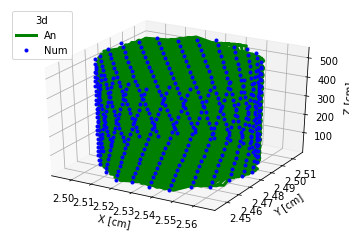

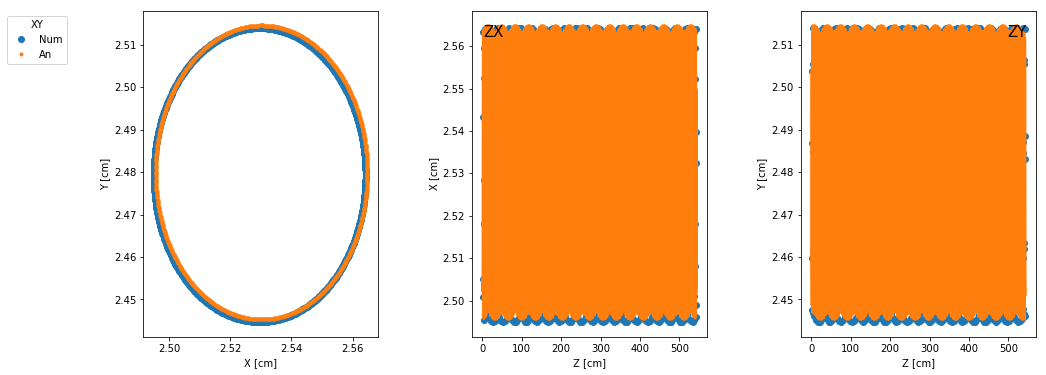

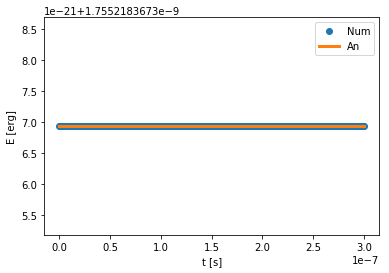

In [22]:
import glob
import os

import h5py
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

def main():
    num = extract_num_trajectory_from_out_files()
    an = eval_an_trajectory_at_num_time_points(num)
    plot_trajectories(num, an)


def extract_num_trajectory_from_out_files():
    out_files = find_necessary_out_files()

    num_trajectory = []
    for f in out_files:
        num_trajectory.append(extract_time_pos_mom(f))

    num_trajectory = remove_empty_and_sort_by_time(num_trajectory)
    num_trajectory = np.array(num_trajectory,
                              dtype=[('t', 'float'),
                                     ('x', 'float'), ('y', 'float'), ('z', 'float'),
                                     ('px', 'float'), ('py', 'float'), ('pz', 'float')])
    return (num_trajectory)


def remove_empty_and_sort_by_time(num_trajectory):
    removed_empty = [x for x in num_trajectory if x]
    sorted_by_time = sorted(removed_empty, key=lambda x: x[0])
    return (sorted_by_time)


def find_necessary_out_files():
    os.chdir("./")
    h5files = []
    for file in glob.glob("long_simulation_[0-9][0-9][0-9][0-9][0-9][0-9][0-9].h5"):
        h5files.append(file)
    return h5files


def extract_time_pos_mom(h5file):
    h5 = h5py.File(h5file, mode="r")
    t = h5["/TimeGrid"].attrs["current_time"]
    t_pos_mom = ()
    if (len(h5["/ParticleSources/emit_single_particle"]) > 0 and
            len(h5["/ParticleSources/emit_single_particle/position_x"]) > 0):
        x = h5["/ParticleSources/emit_single_particle/position_x"][0]
        y = h5["/ParticleSources/emit_single_particle/position_y"][0]
        z = h5["/ParticleSources/emit_single_particle/position_z"][0]
        px = h5["/ParticleSources/emit_single_particle/momentum_x"][0]
        py = h5["/ParticleSources/emit_single_particle/momentum_y"][0]
        pz = h5["/ParticleSources/emit_single_particle/momentum_z"][0]
        t_pos_mom = (t, x, y, z, px, py, pz)
    h5.close()
    return (t_pos_mom)


def eval_an_trajectory_at_num_time_points(num_trajectory):
    initial_out_file = "long_simulation_0000000.h5"
    initial_h5 = h5py.File(initial_out_file, mode="r")
    global B0, q, m
    B0 = extract_magn_field(initial_h5)
    q, m = extract_particle_charge_and_mass(initial_h5)
    global x0, y0, z0, px0, py0, pz0, vx0, vy0, vz0
    x0, y0, z0, px0, py0, pz0 = extract_initial_pos_and_mom(initial_h5)
    vx0, vy0, vz0 = px0 / m, py0 / m, pz0 / m
    initial_h5.close()

    global v_perp_len, v_prll
    v_perp_len = np.sqrt(vx0 ** 2 + vy0 ** 2)
    v_prll = vz0

    global speed_of_light, larmor_rad, larmor_freq
    speed_of_light = 3e10  # todo 
    larmor_rad = m / abs(q) * v_perp_len / B0 * speed_of_light
    larmor_freq = abs(q) / m * B0 / speed_of_light

    an_trajectory = np.empty_like(num_trajectory)
    for i, t in enumerate(num_trajectory['t']):
        x, y, z = coords(t)
        vx, vy, vz = velocities(t)
        px, py, pz = vx * m, vy * m, vz * m
        an_trajectory[i] = (t, x, y, z, px, py, pz)

    return (an_trajectory)


def extract_magn_field(h5):
    B0 = h5["/ExternalFields/mgn_uni"].attrs["magnetic_uniform_field_z"]
    return B0


def extract_particle_charge_and_mass(h5):
    q = h5["/ParticleSources/emit_single_particle"].attrs["charge"]
    m = h5["/ParticleSources/emit_single_particle"].attrs["mass"]
    return (q, m)


def extract_initial_pos_and_mom(h5):
    x0 = h5["/ParticleSources/emit_single_particle/position_x"][0]
    y0 = h5["/ParticleSources/emit_single_particle/position_y"][0]
    z0 = h5["/ParticleSources/emit_single_particle/position_z"][0]
    px0 = h5["/ParticleSources/emit_single_particle/momentum_x"][0]
    py0 = h5["/ParticleSources/emit_single_particle/momentum_y"][0]
    pz0 = h5["/ParticleSources/emit_single_particle/momentum_z"][0]
    return (x0, y0, z0, px0, py0, pz0)


def velocities(t):
    sign_larmor_freq = larmor_freq * np.sign(q)
    vx = vx0 * np.cos(sign_larmor_freq * t) + vy0 * np.sin(sign_larmor_freq * t)
    vy = -vx0 * np.sin(sign_larmor_freq * t) + vy0 * np.cos(sign_larmor_freq * t)
    vz = vz0
    return (vx, vy, vz)


def coords(t):
    sign_larmor_freq = larmor_freq * np.sign(q)
    x = x0 + 1 / sign_larmor_freq * (vx0 * np.sin(sign_larmor_freq * t) -
                                     vy0 * np.cos(sign_larmor_freq * t) + vy0)
    y = y0 + 1 / sign_larmor_freq * (vx0 * np.cos(sign_larmor_freq * t) +
                                     vy0 * np.sin(sign_larmor_freq * t) - vx0)
    z = z0 + vz0 * t
    return (x, y, z)


def plot_trajectories(num, an):
    plot_3d(num, an)
    plot_2d(num, an)
    plot_kin_en(num, an)


def plot_3d(num, an):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(an['x'], an['y'], an['z'], 'g-', linewidth=3, label="An")
    ax.plot(num['x'][::2], num['y'][::2], num['z'][::2], 'b.',
            markersize=6, label="Num")
    ax.set_xlabel('X [cm]')
    ax.set_ylabel('Y [cm]')
    ax.set_zlabel('Z [cm]')
    plt.legend(loc='upper left', title="3d")


def plot_2d(num, an):
    plt.figure(figsize=(16, 6))
    plt.subplots_adjust(left=None, bottom=None,
                        right=None, top=None,
                        wspace=0.4, hspace=None)
    # XY
    ax = plt.subplot(131)
    plt.plot(num['x'], num['y'],
             linestyle='', marker='o',
             label="Num")
    plt.plot(an['x'], an['y'],
             linestyle='', marker='.', lw=3,
             label="An")
    ax.set_xlabel('X [cm]')
    ax.set_ylabel('Y [cm]')
    plt.legend(loc='upper left', title="XY", bbox_to_anchor=(-0.6, 1))
    # ZX
    ax = plt.subplot(132)
    plt.plot(num['z'], num['x'],
             linestyle='', marker='o',
             label="Num")
    plt.plot(an['z'], an['x'],
             linestyle='-', marker='', lw=3,
             label="An")
    ax.set_xlabel('Z [cm]')
    ax.set_ylabel('X [cm]')
    ax.text(0.05, 0.92, 'ZX',
            transform=ax.transAxes, fontsize=15)
    # plt.legend( loc = 'upper left', title="ZX" )
    # ZY
    ax = plt.subplot(133)
    plt.plot(num['z'], num['y'],
             linestyle='', marker='o',
             label="Num")
    plt.plot(an['z'], an['y'],
             linestyle='-', marker='', lw=3,
             label="An")
    ax.set_xlabel('Z [cm]')
    ax.set_ylabel('Y [cm]')
    ax.text(0.88, 0.92, 'ZY',
            transform=ax.transAxes, fontsize=15)
    # plt.legend( loc = 'upper left', title="ZY" )


def plot_kin_en(num, an):
    E_num = (num['px'] ** 2 + num['py'] ** 2 + num['pz'] ** 2) / (2 * m)
    E_an = (an['px'] ** 2 + an['py'] ** 2 + an['pz'] ** 2) / (2 * m)
    t = num['t']
    plt.figure()
    axes = plt.gca()
    axes.set_xlabel("t [s]")
    axes.set_ylabel("E [erg]")
    # axes.set_ylim( [min( E_an.min(), E_num.min() ),
    #                 max( E_an.max(), E_num.max() ) ] )
    line, = plt.plot(t, E_num, 'o')
    line.set_label("Num")
    line, = plt.plot(t, E_an, ls='solid', lw=3)
    line.set_label("An")
    plt.legend(loc='upper right')



main()
